In [5]:
import numpy as np
import torch as th

In [24]:
inputs = th.Tensor([[1,0,0],[0,1,0],[0,0,1]])
messages = th.Tensor([[0,0],[1,1],[2,2]])

batch_size = messages.size(0)

id_sampled_messages = np.arange(batch_size)
sampled_messages = messages[id_sampled_messages]
sampled_messages = sampled_messages.unsqueeze(0)
sampled_messages = sampled_messages.repeat(batch_size, 1, 1)
sampled_messages = sampled_messages.permute(1, 0, 2)
sampled_messages = sampled_messages.reshape([batch_size * batch_size, sampled_messages.size(-1)])
sampled_x = inputs.repeat(batch_size, 1, 1, 1)
sampled_x = sampled_x.reshape([batch_size * batch_size, *inputs.size()[1:]])

print(sampled_x)
print(sampled_messages)

eps=-10**10
log_probs = th.Tensor([0,0,eps,eps,0,eps,eps,eps,0])
#m1|x1, m2|x2, m3|x3, m2|x1, m2|x2, m2|x3, m3|x1, m3|x2, m3|x3

log_pi_m_x = log_probs.reshape([batch_size, batch_size]).T
pi_m_x = th.exp(log_pi_m_x)
p_x = th.ones(batch_size) / batch_size  # Here we set p(x)=1/batch_size
p_x = p_x.to(pi_m_x.device)  # Fix device issue

print(log_pi_m_x)
print("cc")
print(pi_m_x.sum(1))

log_p_x = th.log(p_x)
log_pi_m = th.log((pi_m_x * p_x).sum(1))
log_pi_m_x = th.log(pi_m_x.diagonal(0))

mutual_information = log_pi_m_x + log_p_x - log_pi_m

loss_mi = -1*log_pi_m_x*mutual_information.detach()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [2., 2.],
        [2., 2.],
        [2., 2.]])
tensor([[ 0.0000e+00, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10,  0.0000e+00]])
cc
tensor([1., 2., 1.])


In [34]:
target_messages=[]

for sender_id in ["_","_"]:
    for _ in range(10):
        messages = th.Tensor([[2,2],[1,1]])
        target_messages.append(messages)

target_messages=th.stack(target_messages)

print(target_messages.size())

torch.Size([20, 2, 2])


In [52]:
import collections

C = collections.namedtuple("Batch",["data","sender_id","receiver_id","imitator_id"])

a=C(sender_id=2,receiver_id=3,imitator_id=4,data=2)

if getattr(a, "sender_id", False):
    print("coucou")

coucou


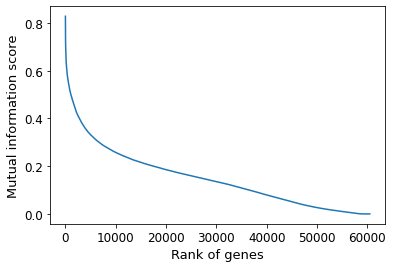

50


In [57]:
import matplotlib.pyplot as plt

mi_values=np.load("/Users/mrita/Desktop/Work/CUP/saved_mi_values.npy")
gene_labels=np.load("/Users/mrita/Desktop/Work/CUP/gene_labels.npy")

ordered_mi_idx = np.argsort(mi_values)[::-1]

plt.plot(mi_values[ordered_mi_idx])
plt.xlabel("Rank of genes",size=13)
plt.ylabel("Mutual information score",size=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

print(np.sum(mi_values>0.7))

In [114]:
voc_size=5

messages=th.Tensor([[2,3,4,5],[2,3,1,5]])
start_token = th.Tensor(messages.size(0)*[voc_size+1]).to(int)
start_token = start_token.unsqueeze(1)
messages = th.cat((start_token,messages),dim=1)

print(messages.size())
print(messages)

torch.Size([2, 5])
tensor([[6., 2., 3., 4., 5.],
        [6., 2., 3., 1., 5.]])


In [115]:
1e-3

0.001

# Language model

In [575]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TextGenerator(torch.nn.ModuleList):

    def __init__(self, batch_size,hidden_dim, max_len, vocab_size,window):
        super(TextGenerator, self).__init__()
    
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = vocab_size
        self.num_classes = vocab_size
        self.sequence_len = window
    
        # Dropout
        self.dropout = nn.Dropout(0.25)
    
        # Embedding layer
        self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
    
        # Bi-LSTM
        self.lstm_cell_forward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.lstm_cell_backward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.sender_norm_h_forward = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_h_backward = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_c_forward = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_c_backward = nn.LayerNorm(self.hidden_dim)
        
        # LSTM layer
        self.lstm_cell = nn.GRUCell(self.hidden_dim, self.hidden_dim)
        self.lstm_cell_2 = nn.GRUCell(self.hidden_dim, self.hidden_dim)
        self.sender_norm_h = nn.LayerNorm(self.hidden_dim)
        self.sender_norm_c = nn.LayerNorm(self.hidden_dim)
    
        # Linear layer
        self.linear = nn.Linear(self.hidden_dim, self.num_classes)
        #self.linear = nn.Linear(self.sequence_len*self.hidden_dim, self.num_classes)
        
        
        
    def forward(self, x,length):
        

        # LSTM
        # hs = [batch_size x hidden_size]
        # cs = [batch_size x hidden_size]
        hs_forward = torch.zeros(x.size(0), self.hidden_dim)
        cs_forward = torch.zeros(x.size(0), self.hidden_dim)
        hs_backward = torch.zeros(x.size(0), self.hidden_dim)
        cs_backward = torch.zeros(x.size(0), self.hidden_dim)

        # LSTM
        # hs = [batch_size x (hidden_size * 2)]
        # cs = [batch_size x (hidden_size * 2)]
        hs_lstm = torch.zeros(x.size(0), self.hidden_dim)
        cs_lstm = torch.zeros(x.size(0), self.hidden_dim)

        # Weights initialization
        #torch.nn.init.kaiming_normal_(hs_forward)
        #torch.nn.init.kaiming_normal_(cs_forward)
        #torch.nn.init.kaiming_normal_(hs_backward)
        #torch.nn.init.kaiming_normal_(cs_backward)
        #torch.nn.init.kaiming_normal_(hs_lstm)
        #torch.nn.init.kaiming_normal_(cs_lstm)

        # From idx to embedding
        out = self.embedding(x)

        # Prepare the shape for LSTM Cells
        out = out.view(self.sequence_len, x.size(0), -1)

        forward = []
        backward = []
        
        """
        for i in range(self.sequence_len):
            hs_forward, cs_forward = self.lstm_cell_forward(out[i], (hs_forward, cs_forward))
            hs_forward = self.sender_norm_h_forward(hs_forward)
            cs_forward = self.sender_norm_c_forward(cs_forward)
            forward.append(hs_forward)

        # Backward
        for i in reversed(range(self.sequence_len)):
            hs_backward, cs_backward = self.lstm_cell_backward(out[i], (hs_backward, cs_backward))
            hs_backward = self.sender_norm_h_backward(hs_backward)
            cs_backward = self.sender_norm_c_backward(cs_backward)
            backward.append(hs_backward)

        # LSTM
        for fwd, bwd in zip(forward, backward):
            input_tensor = torch.cat((fwd, bwd), 1)
            hs_lstm, cs_lstm = self.lstm_cell(input_tensor, (hs_lstm, cs_lstm))
            hs_lstm = self.sender_norm_h(hs_lstm)
            cs_lstm = self.sender_norm_c(cs_lstm)
        """
        hss=[]
        css=[]
        
        for i in range(self.sequence_len):
            hs_lstm = self.lstm_cell(out[i], hs_lstm)
            
            #hs_lstm, cs_lstm = self.lstm_cell(out[i], (hs_lstm, cs_lstm))
            #hs_lstm=torch.nn.functional.normalize(hs_lstm)
            #cs_lstm=torch.nn.functional.normalize(cs_lstm)
            hs_lstm = self.sender_norm_h(hs_lstm)
            #cs_lstm = self.sender_norm_c(cs_lstm)
            hss.append(hs_lstm)
            #css.append(cs_lstm)
        
        #hs_lstm_2 = torch.zeros(x.size(0), self.hidden_dim)
        
        #for i in range(self.sequence_len):
        #    hs_lstm_2 = self.lstm_cell_2(hss[i], hs_lstm_2)
            
        
            
        length = nn.functional.one_hot(length-1,num_classes=self.sequence_len)
        #length=1-torch.cumsum(length,dim=1)
            
        hs_out=torch.stack(hss,dim=1)
        hs_out=length.unsqueeze(2).detach()*hs_out
        hs_out=hs_out.sum(dim=1)
        
        hs_out = self.dropout(hs_out)
        
        #cs_out=torch.stack(css,dim=1)
        #cs_out=length.unsqueeze(2)*cs_out
        #cs_out=cs_out.sum(dim=1)
        
        #hss=torch.stack(hss,dim=1)
        #hss=hss.resize(hss.size(0),hss.size(1)*hss.size(2))
            
        
        #length = nn.functional.one_hot(length,num_classes=self.sequence_len)
        #length=length.unsqueeze(2)
        #length=length.repeat(1,1,self.hidden_dim)
        #length=length.flatten(1)
        # Last hidden state is passed through a linear layer
        #hs_lstm=hs_lstm.repeat(1,self.sequence_len)
    
        #pre_out = hs_lstm * length
        pre_out=hs_out
        out = self.linear(pre_out)

        return out

In [472]:
1-torch.cumsum(torch.Tensor([[0,1,0,0],[0,0,1,0]]),dim=1)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.]])

In [573]:
def train(model,sequences,message_length,num_epochs,batch_size,hidden_dim,max_len,vocab_size,lr):
    
    
    #params=list(model.embedding.parameters())
    #params+=list(model.lstm_cell.parameters())
    #params+=list(model.sender_norm_h.parameters())
    #params+=list(model.sender_norm_c.parameters())
    
    # Optimizer initialization
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
    
    ce = nn.CrossEntropyLoss(reduce=False)
  
    # Defining number of batches
    num_batches = int(len(sequences) / batch_size)
  
    # Set model in training mode
    model.train()
  
    # Training pahse
    for epoch in range(1,num_epochs+1):
    
        # Mini batches
        for i in range(num_batches):
      
            # Batch definition
            try:
                x_batch = sequences[i * batch_size : (i + 1) * batch_size]
                y_batch = targets[i * batch_size : (i + 1) * batch_size]
                len_batch = message_length[i * batch_size : (i + 1) * batch_size]
            except:
                x_batch = sequences[i * batch_size :]
                y_batch = targets[i * batch_size :]
                len_batch = message_length[i * batch_size :]
        
        
            # Convert numpy array into torch tensors
            x = torch.from_numpy(x_batch).type(torch.LongTensor)
            y = torch.from_numpy(y_batch).type(torch.LongTensor)
            length = torch.from_numpy(len_batch).type(torch.LongTensor)
            
            # Feed the model
            y_pred = model(x,length)
            
            # Loss calculation
            loss = ce(y_pred,y.squeeze())
            
            #print(loss)
            
            #print(y_pred,y.squeeze())
            #print(loss)

            # Clean gradients
            optimizer.zero_grad()

            # Calculate gradientes
            loss.mean().backward()

            # Updated parameters
            optimizer.step()
      
        print("Epoch: %d ,  loss: %.5f " % (epoch, loss.mean().item()))
        
        #if epoch%100==0:
        #    scheduler.step()
        
        
def generator(model, sequences, n_chars,window):
  
    # Set the model in evalulation mode
    model.eval()
  
    # Define the softmax function
    softmax = nn.Softmax(dim=1)
  
    # Randomly is selected the index from the set of sequences
    #start = np.random.randint(0, len(sequences)-1)
    start=0
  
    # The pattern is defined given the random idx
    pattern = sequences[start]
  
    # By making use of the dictionaries, it is printed the pattern
    print("\nPattern: \n")
    print(''.join([str(value) for value in pattern]))
  
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
  
    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(n_chars):
    
        # The numpy patterns is transformed into a tesor-type and reshaped
        new_pattern = torch.from_numpy(pattern).type(torch.LongTensor)
        new_pattern=new_pattern[-window:]
        new_pattern = new_pattern.view(1,-1)

        # Make a prediction given the pattern
        prediction = model(new_pattern)
        # It is applied the softmax function to the predicted tensor
        #prediction = softmax(prediction)
        prediction=torch.exp(prediction)
        print(prediction)

        # The prediction tensor is transformed into a numpy array
        prediction = prediction.squeeze().detach().numpy()
        # It is taken the idx with the highest probability
        arg_max = np.argmax(prediction)
        
        print(arg_max)
        
        # The current pattern tensor is transformed into numpy array
        #pattern = pattern.squeeze().detach().numpy()
        # The new pattern is composed by the "old" pattern + the predicted character
        pattern = np.append(pattern, arg_max)

    # The full prediction is saved
    #full_prediction = np.append(full_prediction, arg_max)
        
    print("Prediction: \n")
    print(''.join([str(value) for value in pattern]))
    
def get_prob(model, sequences, PAD=11, max_len=10):
    
    #sequences=np.array([[char] for char in sequences])
  
    # Set the model in evalulation mode
    model.eval()
  
    # Define the softmax function
    softmax = nn.Softmax(dim=1)
  
    # Randomly is selected the index from the set of sequences
    #start = np.random.randint(0, len(sequences)-1)
    start=0
  
    # The pattern is defined given the random idx
    pattern = [sequences[start]] + [PAD]*(max_len-1)
  
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
    probs=[]

    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(1,len(sequences)):
        new_pattern=np.array([pattern])
        # The numpy patterns is transformed into a tesor-type and reshaped
        length = max_len-np.sum(new_pattern==11,axis=1)
        print(length)
        new_pattern = torch.from_numpy(new_pattern).type(torch.LongTensor)
        length = torch.from_numpy(np.array(length)).type(torch.LongTensor)
        new_pattern = new_pattern.view(1,-1)

        # Make a prediction given the pattern
        print(new_pattern)
        prediction = model(new_pattern,length)
        # It is applied the softmax function to the predicted tensor
        prediction = softmax(prediction)

        # The prediction tensor is transformed into a numpy array
        prediction = prediction.squeeze().detach().numpy()
        print(prediction,sequences[i])
        # It is taken the idx with the highest probability
        prob=prediction[sequences[i]]
        arg_max = sequences[i]
        
        # The current pattern tensor is transformed into numpy array
        #pattern = pattern.squeeze().detach().numpy()
        # The new pattern is composed by the "old" pattern + the predicted character
        pattern[i] = arg_max
        probs.append(prob)

    # The full prediction is saved
    #full_prediction = np.append(full_prediction, arg_max)
    print(np.prod(probs))

In [78]:
def build_sequences(text, max_len):
    x = list()
    y = list()
    PAD=11
    
    for seq in text:
        for i in range(1,len(seq)):
            s = seq[:i]+(max_len-i)*[PAD]
            x.append(np.array(s))
            y.append(np.array(seq[i]))
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y

#print(build_sequences(text,window))

In [579]:
text=[]

for i in range(1,1000):
    rd1=np.random.randint(2,4,1)[0]
    #rd2=np.random.randint(2,5,1)[0]
    rd2=rd1
    text.append([0,rd1,rd2,1])


lr=0.001
num_epochs = 1000
batch_size = 10
hidden_dim = 128
max_len = 4
vocab_size = 12

model = TextGenerator(batch_size=batch_size, 
                      hidden_dim=hidden_dim, 
                      max_len=max_len,
                      window=max_len,
                      vocab_size=vocab_size)

sequences, targets = build_sequences(text,max_len=max_len)
message_length = max_len-np.sum(sequences==11,axis=1)

train(model,sequences,message_length,num_epochs,batch_size,hidden_dim,max_len,vocab_size,lr)
#generator(model=model, sequences=np.array([[0]]), n_chars=9,window=window)


#for i in range(1,12):
#    test=[[0,i,1]]
#    get_prob(model,test)

Epoch: 1 ,  loss: 0.44582 
Epoch: 2 ,  loss: 0.43045 
Epoch: 3 ,  loss: 0.43562 
Epoch: 4 ,  loss: 0.45575 
Epoch: 5 ,  loss: 0.49655 
Epoch: 6 ,  loss: 0.46698 
Epoch: 7 ,  loss: 0.45782 
Epoch: 8 ,  loss: 0.46847 
Epoch: 9 ,  loss: 0.46058 
Epoch: 10 ,  loss: 0.45644 
Epoch: 11 ,  loss: 0.45464 
Epoch: 12 ,  loss: 0.43160 
Epoch: 13 ,  loss: 0.43911 
Epoch: 14 ,  loss: 0.44923 
Epoch: 15 ,  loss: 0.45256 
Epoch: 16 ,  loss: 0.46263 
Epoch: 17 ,  loss: 0.45824 
Epoch: 18 ,  loss: 0.46024 
Epoch: 19 ,  loss: 0.44063 
Epoch: 20 ,  loss: 0.45722 
Epoch: 21 ,  loss: 0.45249 
Epoch: 22 ,  loss: 0.48525 
Epoch: 23 ,  loss: 0.46851 
Epoch: 24 ,  loss: 0.49997 
Epoch: 25 ,  loss: 0.46314 
Epoch: 26 ,  loss: 0.44967 
Epoch: 27 ,  loss: 0.46229 
Epoch: 28 ,  loss: 0.45545 
Epoch: 29 ,  loss: 0.47182 


KeyboardInterrupt: 

In [ ]:
1/6*(np.log(2)+np.log(2))

In [580]:
for i in range(2,4):
    j=i
    print(i)
    test=[0,i,j,1]
    get_prob(model,test,max_len=4)
        
#print("Others")
#test=[0,1,2,1,1,1]
#get_prob(model,test)
#test=[0,2,1,1,1,1]
#get_prob(model,test)

2
[1]
tensor([[ 0, 11, 11, 11]])
[3.8784510e-08 5.8387400e-07 4.7987333e-01 5.2012569e-01 4.0020321e-08
 3.4352915e-08 3.7311793e-08 5.9340387e-08 3.0514514e-08 3.8158024e-08
 3.6475978e-08 3.9666187e-08] 2
[2]
tensor([[ 0,  2, 11, 11]])
[3.4308095e-11 3.1778409e-09 5.4009807e-01 4.5990190e-01 4.7046353e-11
 4.3385712e-11 4.1363499e-11 6.1503434e-11 4.0545817e-11 4.4846241e-11
 3.3379698e-11 4.3330142e-11] 2
[3]
tensor([[ 0,  2,  2, 11]])
[1.07474765e-10 5.54179778e-08 5.44645905e-01 4.55354065e-01
 1.32995143e-10 1.22945279e-10 1.16088743e-10 1.64411068e-10
 1.16262909e-10 1.20910906e-10 8.95479524e-11 1.12130576e-10] 1
1.4363158e-08
3
[1]
tensor([[ 0, 11, 11, 11]])
[3.8784510e-08 5.8387400e-07 4.7987333e-01 5.2012569e-01 4.0020321e-08
 3.4352915e-08 3.7311793e-08 5.9340387e-08 3.0514514e-08 3.8158024e-08
 3.6475978e-08 3.9666187e-08] 3
[2]
tensor([[ 0,  3, 11, 11]])
[1.1417826e-08 8.5740581e-08 5.0513369e-01 4.9486622e-01 1.1350623e-08
 9.8442268e-09 1.1332019e-08 1.2481494e-08 9.190

In [458]:
for i in range(1,1000):
    rd1=np.random.randint(2,4,1)[0]
    #rd2=np.random.randint(2,5,1)[0]
    rd2=rd1
    print([0,rd1,rd2,1])

[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]
[0, 3, 3, 1]
[0, 2, 2, 1]

In [365]:
for i in range(1,1000):
    rd1=np.random.randint(0,5,1)[0]
    print(rd1)

4
4
2
3
2
4
4
2
3
4
2
3
3
4
4
4
3
3
2
2
2
4
3
4
4
4
2
4
4
3
2
2
3
4
4
4
3
3
4
3
4
4
3
3
4
4
3
3
4
2
4
2
2
3
2
3
4
4
3
4
4
3
3
3
2
2
2
3
3
3
4
3
3
4
4
2
3
3
4
2
3
4
4
4
2
4
2
2
4
3
3
3
3
4
4
2
2
3
3
4
2
4
4
2
2
4
4
4
2
2
4
2
2
3
2
2
2
2
4
4
3
3
2
4
3
4
2
2
4
2
4
3
2
3
4
2
2
2
4
2
4
4
4
4
4
3
4
2
3
2
4
2
3
3
4
3
2
3
2
2
4
3
2
2
3
4
3
3
2
3
3
4
2
2
4
4
3
2
2
4
2
2
4
2
4
2
3
3
2
4
3
4
3
4
3
3
3
4
3
2
4
4
2
3
3
2
2
2
3
2
4
3
4
4
2
2
2
2
4
4
4
3
3
2
4
3
2
2
4
3
3
4
3
3
3
2
4
4
4
4
2
3
4
4
2
4
3
2
3
4
3
4
2
3
3
4
4
3
2
4
2
3
2
4
4
4
3
2
4
3
3
3
3
2
4
3
4
3
4
2
3
2
2
2
3
4
2
3
2
4
4
3
2
2
2
2
2
2
2
3
2
3
2
2
2
2
2
3
4
3
2
3
3
4
2
3
3
2
3
3
2
4
3
4
4
3
2
2
2
2
3
3
3
2
3
4
4
3
2
2
2
2
3
4
3
2
4
2
2
4
3
3
4
2
4
2
4
2
2
2
4
3
3
3
2
3
2
2
4
4
3
2
3
4
3
3
2
2
4
2
3
4
4
4
4
2
2
2
3
4
4
2
3
3
3
2
2
3
3
4
3
4
3
3
4
2
2
4
2
4
3
4
3
2
4
3
4
2
4
3
3
2
4
2
2
2
3
2
2
2
2
2
4
4
3
2
2
2
4
3
2
2
4
2
4
2
4
3
3
3
3
2
2
4
2
2
3
4
3
4
3
3
4
3
3
2
2
3
4
4
3
3
4
2
2
2
2
4
4
4
4
3
3
2
3
2
3
2
4
2
3
2
2
4
2
3
3
3
4
2


In [215]:
message=th.zeros(20,10,10)
voc_size=10

start_token = th.Tensor(messages.size(0) * [voc_size]).to(int).to(messages.device)
start_token = start_token.unsqueeze(1)

print(start_token)

tensor([[10],
        [10]])


In [2]:
# CUP
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


cancer_types = {'Bladder': 0,
                 'Brain': 1,
                 'Breast': 2,
                 'Cervix': 3,
                 'Colon': 4,
                 'CorpusUteri': 5,
                 'HeadandNeck': 6,
                 'Hematopoietic': 7,
                 'Kidney': 8,
                 'Liver': 9,
                 'Lung': 10,
                 'LymphNodes': 11,
                 'Ovary': 12,
                 'Pancreas': 13,
                 'Prostate': 14,
                 'Skyn': 15,
                 'Stomach': 16,
                 'ThyroidGland': 18}

In [907]:
nb_geness=[]
accuracies=[]
f1_scores=[]
precisions=[]
recalls=[]

for nb_genes in range(10,2950,20):

    cancer_labels = np.load("/Users/mrita/Desktop/Work/CUP/cancer_labels_val.npy")
    cancer_labels = [cancer_types[cancer] for cancer in cancer_labels]
    preds = np.load("/Users/mrita/Desktop/Work/CUP/y_pred/nb_genes_{}.npy".format(nb_genes))

    accuracy = np.sum(cancer_labels==preds)/len(preds)
    f1score=f1_score(cancer_labels,preds,average=None)
    precision, recall, _, _ = precision_recall_fscore_support(cancer_labels,preds)
    
    
    nb_geness.append(nb_genes)
    accuracies.append(accuracy)
    f1_scores.append(np.mean(f1score))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))
    
for nb_genes in range(3000,5000,50):

    cancer_labels = np.load("/Users/mrita/Desktop/Work/CUP/cancer_labels_val.npy")
    cancer_labels = [cancer_types[cancer] for cancer in cancer_labels]
    preds = np.load("/Users/mrita/Desktop/Work/CUP/y_pred/nb_genes_{}.npy".format(nb_genes))

    accuracy = np.sum(cancer_labels==preds)/len(preds)
    f1score=f1_score(cancer_labels,preds,average=None)
    precision, recall, _, _ = precision_recall_fscore_support(cancer_labels,preds)
    
    nb_geness.append(nb_genes)
    accuracies.append(accuracy)
    f1_scores.append(np.mean(f1score))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))

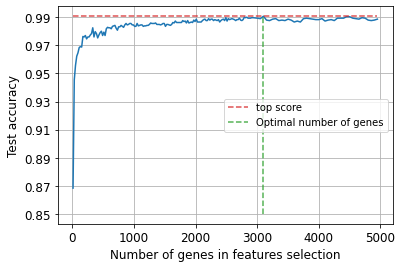

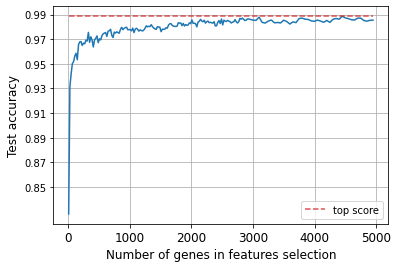

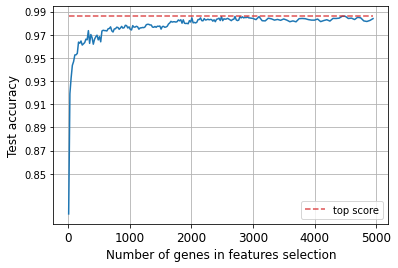

In [908]:
plt.plot(nb_geness,accuracies)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(accuracies),np.max(accuracies)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.plot([nb_geness[np.argmax(accuracies)],nb_geness[np.argmax(accuracies)]],[0.85,np.max(accuracies)],
         c="tab:green",
         linestyle="--",
        alpha=0.8,
        label="Optimal number of genes")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=12)
plt.legend()
plt.show()

plt.plot(nb_geness,precisions)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(precisions),np.max(precisions)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=10)
plt.legend()
plt.show()

plt.plot(nb_geness,recalls)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(recalls),np.max(recalls)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=10)
plt.legend()
plt.show()

In [1077]:
import torch.nn as nn

class BieberLSTM(nn.Module):
    
    def __init__(self, nb_layers, nb_lstm_units=100, embedding_dim=3, batch_size=2,vocab_size=5):
        
        super(BieberLSTM, self).__init__()
        
        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.nb_vocab_words = vocab_size
        self.padding_idx = 0
        
        self.word_embedding = nn.Embedding(
            num_embeddings=self.nb_vocab_words,
            embedding_dim=self.embedding_dim,
            padding_idx=self.padding_idx
        )
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True,
        )
        
        self.hidden_to_symbol = nn.Linear(self.nb_lstm_units, self.nb_vocab_words)

        # build actual NN
        #self.__build_model()

    def __build_model(self):
        # build embedding layer first
        

        # whenever the embedding sees the padding index it'll make the whole vector zeros
        self.word_embedding = nn.Embedding(
            num_embeddings=self.nb_vocab_words,
            embedding_dim=self.embedding_dim,
            padding_idx=self.padding_idx
        )

        # design LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
        )

        # output layer which projects back to tag space
        self.hidden_to_tag = nn.Linear(self.nb_lstm_units, self.nb_tags)

    def init_hidden(self,batch_size):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(1,batch_size, self.nb_lstm_units)*0.
        hidden_b = torch.randn(1,batch_size, self.nb_lstm_units)*0.
        return (hidden_a, hidden_b)
    
    
    def forward(self, X, X_lengths):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        
        batch_size, seq_len = X.size()
        
        hidden = self.init_hidden(batch_size)

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)
        X = self.word_embedding(X)
    

        # ---------------------
        # 2. Run through RNN
        # TRICK 2 ********************************
        # Dim transformation: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, nb_lstm_units)
        
        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, hidden)

        # undo the packing operation
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        print(X.size())

        # ---------------------
        # 3. Project to tag space
        # Dim transformation: (batch_size, seq_len, nb_lstm_units) -> (batch_size * seq_len, nb_lstm_units)

        # this one is a bit tricky as well. First we need to reshape the data so it goes into the linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.hidden_to_symbol(X)

        # ---------------------
        # 4. Create softmax activations bc we're doing classification
        # Dim transformation: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
        X = F.log_softmax(X, dim=1)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, seq_len, self.nb_vocab_words)

        Y_hat = X
        return Y_hat
    
    
    def loss(self, Y_hat, Y, X_lengths):
        # TRICK 3 ********************************
        # before we calculate the negative log likelihood, we need to mask out the activations
        # this means we don't want to take into account padded items in the output vector
        # simplest way to think about this is to flatten ALL sequences into a REALLY long sequence
        # and calculate the loss on that.
        
        # create a mask by filtering out all tokens that ARE NOT the padding token
        mask = nn.functional.one_hot(X_lengths,num_classes=Y_hat.size(1)+1)
        mask= 1-torch.cumsum(mask,dim=1)[:,:-1]
        # flatten all the labels
        print(Y.size())
        Y = Y.view(-1)
        print(Y.size())

        # flatten all predictions
        Y_hat = Y_hat.view(-1, self.nb_vocab_words)
        
        
        # count how many tokens we have
        nb_tokens = int(torch.sum(mask).item())


        # pick the values for the label and zero out the rest with the mask
        Y_hat = Y_hat[range(Y_hat.size(0)), Y] * mask.view(-1)

        # compute cross entropy loss which ignores all <PAD> tokens
        ce_loss = -torch.sum(Y_hat) / nb_tokens

        return ce_loss

NameError: name 'mask' is not defined

In [963]:
def build_dataset(sequences,padding_idx=0,max_len=4):
    
    X=[]
    y=[]
    X_length=[]
    
    for seq in sequences:
        X.append(seq[:-1]+[padding_idx]*(max_len-1-len(seq[:-1])))
        y.append(seq[1:]+[padding_idx]*(max_len-1-len(seq[1:])))
        X_length.append(len(seq)-1)
        
    X=np.array(X)
    y=np.array(y)
    X_length=np.array(X_length)
        
    X=torch.Tensor(X).to(int)
    y=torch.Tensor(y).to(int)
    X_length=torch.Tensor(X_length).to(int)
    
    return X,y,X_length

build_dataset(sequences,max_len=6)

(tensor([[1, 7, 2, 7, 2],
         [1, 7, 7, 0, 0],
         [1, 4, 5, 7, 2],
         ...,
         [1, 6, 3, 2, 2],
         [1, 7, 2, 5, 2],
         [1, 4, 7, 8, 2]]),
 tensor([[ 7,  2,  7,  2,  2],
         [ 7,  7, 10,  0,  0],
         [ 4,  5,  7,  2,  2],
         ...,
         [ 6,  3,  2,  2,  2],
         [ 7,  2,  5,  2,  2],
         [ 4,  7,  8,  2,  2]]),
 tensor([5, 3, 5,  ..., 5, 5, 5]))

In [1078]:
PAD_TOKEN = 0
START_TOKEN = 1
EOS_TOKEN = 2

sequences=[]

for i in range(5000):
    rd1=np.random.randint(1,10,1)[0]
    rd2=np.random.randint(1,10,1)[0]
    rd3=np.random.randint(1,10,1)[0]
    sequences.append([rd1,rd2,rd3,2,2])

for j in range(1000):
    sequences.append([7,7,0,0,0])
    
np.random.shuffle(sequences)

max_len=np.max([len(seq) for seq in sequences])
batch_size=128
vocab_size=10

X,y,X_lengths = build_data_lm(th.Tensor(sequences))

model = BieberLSTM(nb_layers=1,
                   nb_lstm_units=100, 
                   embedding_dim=10, 
                   batch_size=batch_size,
                   vocab_size=vocab_size+2)


tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        ...,
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])
tensor([[ 1.,  7., 10.,  3.,  4.,  4.],
        [ 1.,  4.,  4., 11.,  4.,  4.],
        [ 1., 10.,  6.,  8.,  4.,  4.],
        ...,
        [ 1.,  6.,  9.,  5.,  4.,  4.],
        [ 1., 10.,  3.,  8.,  4.,  4.],
        [ 1., 11.,  7.,  6.,  4.,  4.]])


In [1079]:
lr=0.001
num_epochs=400

optimizer = optim.RMSprop(model.parameters(), lr=lr)

model.train()

num_batches = int(X.size(0) / batch_size)
  
# Training pahse
for epoch in range(1,num_epochs+1):

    # Mini batches
    for i in range(num_batches):

        x_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        len_batch = X_lengths[i * batch_size : (i + 1) * batch_size]
        
        idx_sorted=torch.argsort(len_batch,descending=True)  
        x_batch=x_batch[idx_sorted]
        y_batch=y_batch[idx_sorted]
        len_batch=len_batch[idx_sorted]
    
        Y_hat = model(x_batch,len_batch)
        loss = model.loss(Y_hat=Y_hat, Y=y_batch, X_lengths=len_batch)

        optimizer.zero_grad()

        # Calculate gradientes
        loss.backward()

        # Updated parameters
        optimizer.step()
    
    print("Epoch {} : loss={}".format(epoch,loss.detach().item()))

torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])

torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
Epoch 3 : loss=1.2382601499557495
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Siz

torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torch.Size([640])
torch.Size([128, 5, 100])
torch.Size([128, 5])
torc

KeyboardInterrupt: 

In [1058]:
def get_prob(model,X_test,X_lengths_test,y_test,nb_vocab_words,batch_size,seq_len):
    
    model.eval()

    Y_hat = model(X_test,X_lengths_test)
    mask = nn.functional.one_hot(X_lengths_test,num_classes=seq_len+1)
    mask= 1-torch.cumsum(mask,dim=1)[:,:-1]
    
    Y_hat = Y_hat*mask.unsqueeze(2)
    Y_hat = torch.exp(Y_hat)
    Y_hat = Y_hat.view(-1, nb_vocab_words)

    Y = y_test.view(-1)
    Y_hat=Y_hat[range(Y_hat.size(0)),Y]
    Y_hat=Y_hat.resize(batch_size,seq_len)

    return Y_hat.prod(1)

sequences_test=[]

sequences_test.append([7,7,0,0,0])

for i in range(5000):
    rd1=np.random.randint(1,10,1)[0]
    rd2=np.random.randint(1,10,1)[0]
    rd3=np.random.randint(1,10,1)[0]
    sequences_test.append([rd1,rd2,rd3,2,2])

    
max_len_test=np.max([len(seq) for seq in sequences_test])

X_test,y_test,X_lengths_test = build_data_lm(th.Tensor(sequences_test))

idx_sorted=torch.argsort(X_lengths_test,descending=True)  
idx_sorted_inv = torch.empty_like(idx_sorted)
idx_sorted_inv[idx_sorted] = torch.arange(idx_sorted.size(0), device=idx_sorted.device)
X_test=X_test[idx_sorted]
y_test=y_test[idx_sorted]
X_lengths_test=X_lengths_test[idx_sorted]

vocab_size=12

probs=get_prob(model,X_test,X_lengths_test,y_test,nb_vocab_words=vocab_size,batch_size=X_test.size(0),seq_len=X_test.size(1))

X_test=X_test[idx_sorted_inv]
y_test=y_test[idx_sorted_inv]
X_lengths_test=X_lengths_test[idx_sorted_inv]
probs=probs[idx_sorted_inv]

print(X_test[2])
print(probs[2].mean())
    

tensor([ 1,  4, 11,  7,  4])
tensor(0.0008, grad_fn=<MeanBackward0>)


In [996]:
PAD_TOKEN=0
START_TOKEN=1
EOS_TOKEN=2

def build_data_lm(messages, max_len):
    x = []
    y = []
    x_length = []

    messages = EOS_TOKEN + torch.Tensor(messages)
    messages=torch.cat((torch.Tensor([START_TOKEN]*messages.size(0)).unsqueeze(1),messages),dim=1)

    eos_mask = messages == EOS_TOKEN
    x_lengths = max_len+1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
    x_lengths.add_(1).clamp_(max=max_len+1)

    pad_mask=1-torch.cumsum(1*eos_mask,dim=1)
    messages = messages * pad_mask
    messages += EOS_TOKEN* eos_mask
    
    x=messages[:,:-1]
    y=messages[:,1:]
    x_lengths=message_lengths-1
    

    return x, y, x_length


max_len=10

messages=torch.Tensor([[1,2,3,0,4,3,5,2,9,9],
                      [8,8,8,8,8,0,8,8,8,8],
                      [1,2,3,4,4,3,0,2,9,9]])

build_data_lm(messages,max_len)

(tensor([[ 1.,  3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.],
         [ 1., 10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.],
         [ 1.,  3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.]]),
 tensor([[ 3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
         [10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.,  0.],
         [ 3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.,  0.]]),
 [])

In [947]:
EOS_TOKEN=2
max_len=10

messages=torch.Tensor([[1,2,3,0,4,3,5,2,9,9],
                      [8,8,8,8,8,0,8,8,8,8],
                      [1,2,3,4,4,3,0,2,9,9]])

messages = EOS_TOKEN+messages
messages=torch.cat((torch.Tensor([START_TOKEN]*messages.size(0)).unsqueeze(1),messages),dim=1)

eos_mask = messages == EOS_TOKEN
message_lengths = max_len+1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
message_lengths.add_(1).clamp_(max=max_len+1)

pad_mask=1-torch.cumsum(1*eos_mask,dim=1)
messages = messages * pad_mask
messages += 2* eos_mask

x=messages[:,:-1]
y=messages[:,1:]
x_lengths=message_lengths-1

print(x)
print(y)
print(x_lengths)

tensor([[ 1.,  3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 1., 10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.]])
tensor([[ 3.,  4.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10., 10., 10., 10., 10.,  2.,  0.,  0.,  0.,  0.],
        [ 3.,  4.,  5.,  6.,  6.,  5.,  2.,  0.,  0.,  0.]])
tensor([4, 6, 7])


In [1073]:
PAD_TOKEN = 0
START_TOKEN = 1
EOS_TOKEN = 2

import torch as th
messages=torch.Tensor([[1,2,3,0,4,3,5,2,9,9],
                      [8,8,8,8,8,0,8,8,8,8],
                      [1,2,3,4,4,3,0,2,9,9],
                      [1,2,3,4,4,3,8,2,9,9],
                      [0, 0, 8, 8, 8, 5, 5, 7, 6, 0]]).to(float)

def build_data_lm(messages):

    max_len = messages.size(1)

    messages = EOS_TOKEN + messages
    start_tokens = th.Tensor([START_TOKEN] * messages.size(0)).unsqueeze(1).to(messages.device)
    messages = th.cat((start_tokens, messages), dim=1)

    eos_mask = messages == EOS_TOKEN
    message_lengths = max_len + 1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
    message_lengths.add_(1).clamp_(max=max_len)
    
    pad_mask = 1 - th.cumsum(1 * eos_mask, dim=1).clamp_(max=1)
    messages = messages * pad_mask
    messages += EOS_TOKEN * eos_mask
    
    messages.to(int)

    x = messages[:, :-1].to(int)
    y = messages[:, 1:].to(int)
    x_lengths = (message_lengths).to(int)

    return x, y, x_lengths

build_data_lm(messages)

tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 1.,  3.,  4.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., 10., 10., 10., 10., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  5.,  6.,  6.,  5.,  0.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  5.,  6.,  6.,  5., 10.,  4., 11., 11.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64)


(tensor([[ 1,  3,  4,  5,  2,  0,  0,  0,  0,  0],
         [ 1, 10, 10, 10, 10, 10,  2,  0,  0,  0],
         [ 1,  3,  4,  5,  6,  6,  5,  2,  0,  0],
         [ 1,  3,  4,  5,  6,  6,  5, 10,  4, 11],
         [ 1,  2,  2,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[ 3,  4,  5,  2,  0,  0,  0,  0,  0,  0],
         [10, 10, 10, 10, 10,  2,  0,  0,  0,  0],
         [ 3,  4,  5,  6,  6,  5,  2,  0,  0,  0],
         [ 3,  4,  5,  6,  6,  5, 10,  4, 11, 11],
         [ 2,  2,  0,  0,  0,  0,  0,  0,  0,  2]]),
 tensor([ 5,  7,  8, 10,  2]))

In [1062]:
def build_dataset(sequences,padding_idx=0,max_len=4):
    
    X=[]
    y=[]
    X_length=[]
    
    for seq in sequences:
        X.append(seq[:-1]+[padding_idx]*(max_len-1-len(seq[:-1])))
        y.append(seq[1:]+[padding_idx]*(max_len-1-len(seq[1:])))
        X_length.append(len(seq)-1)
        
    X=np.array(X)
    y=np.array(y)
    X_length=np.array(X_length)
        
    X=torch.Tensor(X).to(int)
    y=torch.Tensor(y).to(int)
    X_length=torch.Tensor(X_length).to(int)
    
    return X,y,X_length

messages=[[1,2,3,0],
          [8,8,8,8,8,0],
          [1,2,3,4,4,3,0],
          [1,2,3,4,4,3,8,2,9,9]]

build_dataset(messages,max_len=10)

(tensor([[1, 2, 3, 0, 0, 0, 0, 0, 0],
         [8, 8, 8, 8, 8, 0, 0, 0, 0],
         [1, 2, 3, 4, 4, 3, 0, 0, 0],
         [1, 2, 3, 4, 4, 3, 8, 2, 9]]),
 tensor([[2, 3, 0, 0, 0, 0, 0, 0, 0],
         [8, 8, 8, 8, 0, 0, 0, 0, 0],
         [2, 3, 4, 4, 3, 0, 0, 0, 0],
         [2, 3, 4, 4, 3, 8, 2, 9, 9]]),
 tensor([3, 5, 6, 9]))

In [1116]:
cell_types = {'rnn': nn.RNNCell, 'gru': nn.GRUCell, 'LSTM': nn.LSTM}
PAD_TOKEN = 0
START_TOKEN = 1
EOS_TOKEN = 2


def build_data_lm(messages):

    max_len = messages.size(1)

    messages = EOS_TOKEN + messages
    start_tokens = th.Tensor([START_TOKEN] * messages.size(0)).unsqueeze(1).to(messages.device)
    messages = th.cat((start_tokens, messages), dim=1)

    eos_mask = messages == EOS_TOKEN
    message_lengths = max_len + 1 - (eos_mask.cumsum(dim=1) > 0).sum(dim=1)
    message_lengths.add_(1).clamp_(max=max_len)

    pad_mask = 1 - th.cumsum(1 * eos_mask, dim=1).clamp_(max=1)
    messages = messages * pad_mask
    messages += EOS_TOKEN * eos_mask
    messages = messages.to(int)

    x = messages[:, :-1]
    y = messages[:, 1:]
    x_lengths = message_lengths - 1

    return x, y, x_lengths


class LanguageModel():

    def __init__(self,
                 model,
                 optimizer,
                 batch_size):

        self.model = model
        self.optimizer = optimizer
        self.batch_size = batch_size

    def get_prob_messages(self, messages):

        # Gerer le pb descending order pour les lengths

        self.model.eval()

        with th.no_grad():
            x_test, y_test, x_lengths_test = build_data_lm(messages=messages)
            
            print(x_test[-10:],x_lengths_test[-10:])
            print(y_test[-10:])

            # Reorder by length
            y_hat = self.model(x_test, x_lengths_test)
            
            print(y_hat[-10:])

            batch_size, seq_len, nb_vocab_words = y_hat.size()
            mask = nn.functional.one_hot(x_lengths_test, num_classes=seq_len + 1)
            mask = 1 - th.cumsum(mask, dim=1)[:, :-1]

            y_hat = y_hat * mask.unsqueeze(2)
            y_hat = th.exp(y_hat)
            y_hat = y_hat.contiguous()
            y_hat = y_hat.view(-1, self.model.voc_size)

            y_test = y_test.contiguous()
            y_hat = y_hat[range(y_hat.size(0)), y_test.view(-1)]
            y_hat = y_hat.resize(batch_size, seq_len)
            
            print(y_hat[-10:])

        return y_hat.prod(1)

    def compute_loss(self, y_hat, y, x_lengths):

        # create a mask by filtering out all tokens that ARE NOT the padding token
        mask = F.one_hot(x_lengths, num_classes=y_hat.size(1) + 1)
        mask = 1 - th.cumsum(mask, dim=1)[:, :-1]
        mask = mask.to(y_hat.device)

        # flatten all the labels
        y = y.contiguous()
        y = y.view(-1)

        # flatten all predictions
        y_hat = y_hat.contiguous()
        y_hat = y_hat.view(-1, self.model.voc_size)

        # count how many tokens we have
        nb_tokens = int(th.sum(mask).item())

        # pick the values for the label and zero out the rest with the mask
        y_hat = y_hat[range(y_hat.size(0)), y] * mask.view(-1)

        # compute cross entropy loss which ignores all <PAD> tokens
        ce_loss = -th.sum(y_hat) / nb_tokens

        return ce_loss

    def train(self,
              messages,
              n_epochs: int = 200,
              threshold: float = 1e-2):

        x, y, x_lengths = build_data_lm(messages=messages)
        
        r=torch.randperm(x.size(0))
        x=x[r]
        y=y[r]
        x_lengths=x_lengths[r]

        self.model.train()

        num_batches = int(x.size(0) / self.batch_size)

        prev_losses = []

        continue_training = True
        epoch = 0

        while continue_training:

            mean_loss=0.

            # Mini batches
            for i in range(num_batches):
                x_batch = x[i * self.batch_size: (i + 1) * self.batch_size]
                y_batch = y[i * self.batch_size: (i + 1) * self.batch_size]
                len_batch = x_lengths[i * self.batch_size: (i + 1) * self.batch_size]

                y_hat = self.model(x_batch, len_batch)
                loss = self.compute_loss(y_hat, y_batch, len_batch)

                self.optimizer.zero_grad()

                # Calculate gradients
                loss.backward()

                # Updated parameters
                self.optimizer.step()

                mean_loss+=loss.item()

            mean_loss/=num_batches
            
            print(mean_loss,abs(mean_loss - np.mean(prev_losses)))

            if (len(prev_losses) > 4 and abs(mean_loss - np.mean(prev_losses)) < threshold) or epoch >= n_epochs:
                continue_training = False
            else:
                prev_losses.append(mean_loss)
                epoch += 1
                if len(prev_losses) > 5 : prev_losses.pop(0)


class LanguageModelNetwork(nn.Module):

    def __init__(self,
                 max_len: int,
                 voc_size: int,
                 num_layers: int = 1,
                 hidden_size: int = 128,
                 embedding_size: int = 20,
                 device : str ="cpu") -> None:
        super(LanguageModelNetwork, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.voc_size = voc_size
        self.max_len = max_len
        self.device=device

        self.word_embedding = nn.Embedding(
            num_embeddings=self.voc_size,
            embedding_dim=self.embedding_size,
            padding_idx=PAD_TOKEN
        )

        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.hidden_to_symbol = nn.Linear(self.hidden_size, self.voc_size)

    def init_hidden(self, batch_size):
        hidden_a = th.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        hidden_b = th.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        return hidden_a, hidden_b

    def forward(self, x, x_lengths):
        batch_size = x.size(0)

        # Prepare data
        hidden = self.init_hidden(batch_size)
        x = self.word_embedding(x)

        x = th.nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # now run through LSTM
        x, hidden = self.lstm(x, hidden)

        # undo the packing operation
        x, _ = th.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        if x.size(1) < self.max_len:
            dummy_tensor = th.zeros((batch_size,self.max_len - x.size(1), x.size(2)),device=self.device)
            x = th.cat([x, dummy_tensor], 1)

        x = x.contiguous()
        x = x.view(-1, x.size(2))

        # Pass through actual linear layer
        y_hat = self.hidden_to_symbol(x)
        y_hat = F.log_softmax(y_hat, dim=1)
        y_hat = y_hat.view(batch_size, self.max_len, self.voc_size)

        return y_hat


def get_language_model(lm_params:dict,game_params:dict,device:str):

    model = LanguageModelNetwork(max_len=game_params["channel"]["max_len"],
                                 voc_size=game_params["channel"]["voc_size"]+2,
                                 num_layers=lm_params["num_layers"],
                                 hidden_size=lm_params["hidden_size"],
                                 embedding_size=lm_params["embedding_size"],
                                 device=device)

    model.to(device)

    optimizer = th.optim.RMSprop(model.parameters(), lr=0.001)

    language_model = LanguageModel(model=model,optimizer=optimizer,batch_size=lm_params["batch_size"])

    return language_model

In [1117]:
LM=get_language_model({"batch_size":128,"num_layers":1,"hidden_size":128,"embedding_size":40},{"channel":{"max_len":5,"voc_size":5}},device="cpu")

sequences=[]

for i in range(5000):
    rd1=np.random.randint(1,4,1)[0]
    rd2=np.random.randint(1,4,1)[0]
    rd3=np.random.randint(1,4,1)[0]
    rd4=np.random.randint(1,4,1)[0]
    sequences.append([rd1,rd2,rd3,rd4,2])

for j in range(1000):
    sequences.append([4,4,0,0,0])
    
messages=th.Tensor(sequences)

LM.train(messages,threshold=1e-4)

1.1557879447937012 nan
1.0798795845197595 0.07590836027394166
1.077527087667714 0.040306676989016355
1.0766051541204038 0.02779305153998779
1.0761058641516643 0.021344078623730445
1.0757886896962705 0.01739243735437812
1.0755648276080256 0.001616448423136907
1.0753940006960994 0.0009243239527161329
1.0752565212871716 0.0006351859673210392
1.0751422825066939 0.00047969818115234375
1.0750439581663713 0.0003853061924810053
1.074955429719842 0.0003248883330302377
1.0748750567436218 0.0002833817316136855
1.074804046879644 0.00025060280509592303
1.0747401273768882 0.00022402742634652917
1.0746815878411997 0.0002021359360735442
1.0746273657549983 0.00018388395724100448
1.0745774870333464 0.00016814988592406266
1.0745317884113477 0.00015433456586766425
1.074488657972087 0.00014301331146926444
1.0744468025539233 0.0001345748486727416
1.0744041670923647 0.0001302532527758249
1.074359030827232 0.0001307497853817452
1.0743153069330298 0.0001307824383609546
1.07427128760711 0.00013150546861728785
1

In [1118]:
LM.get_prob_messages(messages)[-2]

tensor([[1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2],
        [1, 6, 6, 2, 2]]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
tensor([[6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2],
        [6, 6, 2, 2, 2]])
tensor([[[-1.6887e+01, -1.6989e+01, -1.7292e+01, -1.2289e+00, -1.3083e+00,
          -1.2757e+00, -1.8460e+00],
         [-1.9589e+01, -2.0113e+01, -1.6168e+01, -1.4851e+01, -1.4629e+01,
          -1.5075e+01, -1.1921e-06],
         [-1.7242e+01, -1.7313e+01, -1.1921e-07, -2.3737e+01, -2.3813e+01,
          -2.3906e+01, -1.6952e+01],
         [-2.0021e+00, -1.9691e+00, -2.0072e+00, -1.8853e+00, -1.9187e+00,
          -1.9788e+00, -1.8696e+00],
         [-

tensor(0.1579)

In [1148]:
agent_names = ["Speaker_1","Listener_1","Listener_2"]

population_probs = th.zeros((3,3))
population_probs[0,1]=1
population_probs[0,2]=1

population_probs /= population_probs.sum()

population_probs = population_probs.flatten()

print(population_probs.size())

print(population_probs)

sampled_pair_id = th.multinomial(population_probs, 1)

grid_names=[(agent_names[i], agent_names[j]) for i in range(len(agent_names)) for j in range(len(agent_names))]

sender_id=grid_names[sampled_pair_id][0]

receiver_ids=[name[1] for j,name in enumerate(grid_names) if name[0]==sender_id and population_probs[j]>0]

print(receiver_ids)

torch.Size([9])
tensor([0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
['Listener_1', 'Listener2']


In [37]:
import numpy as np
import torch as th

batch_size=1024
n_pairs=100
n_attributes=5
max_len=10

inputs = np.random.randint(0,50,size=(batch_size,n_attributes))
messages = np.random.randint(0,10,size=(batch_size,max_len))
messages_len = 10*np.ones((batch_size),dtype=int)

idx=np.random.randint(0,batch_size,n_pairs*2)

inputs_pairs = inputs[idx].reshape((n_pairs,2,-1))
messages_pairs = inputs[idx].reshape((n_pairs,2,-1))
messages_len_pairs = messages_len[idx].reshape((n_pairs,2))

In [38]:
import editdistance
from scipy.stats import spearmanr

def compute_language_similarity(messages_1 : th.Tensor,
                                messages_2 : th.Tensor,
                                len_messages_1 : th.Tensor = None,
                                len_messages_2 : th.Tensor = None) -> th.Tensor:

    distances = []
    for i in range(len(messages_1)):
        m_1 = messages_1[i]
        m_2 = messages_2[i]
        len_m_1 = len_messages_1[i]
        len_m_2 = len_messages_2[i]
        distances.append(editdistance.eval(m_1[:len_m_1],m_2[:len_m_2])/max(len_m_1,len_m_2))

    similarity = 1 - th.Tensor(distances)

    return similarity

distances_inputs=np.mean(1-1*((inputs_pairs[:,0,:]-inputs_pairs[:,1,:])==0),axis=1)
distances_messages = 1 - compute_language_similarity(messages_1=messages_pairs[:, 0, :],
                                                                         messages_2=messages_pairs[:, 1, :],
                                                                         len_messages_1=messages_len_pairs[:, 0],
                                                                         len_messages_2=messages_len_pairs[:, 1])

top_sim = spearmanr(distances_inputs, distances_messages).correlation

In [49]:
np.where(np.array([0.5,0.6,0.7,0.8,0.9,1.])>1.1)[0]

array([], dtype=int64)

In [117]:
import os
import pandas as pd
from collections import Counter

sample_sheet = "/Users/mrita/Desktop/Work/CUP/cupred/data/T_BRCA/T_BRCA sample_sheet.tsv"

df=pd.read_csv(sample_sheet,sep="\t")

cases=list(df["Case ID"])

print(len(cases))
print(len(list(set(cases))))

c=Counter(cases)

ids_to_keep=[]
ids_to_remove=[]

for case,nb in c.most_common():
    if nb>1:
        idx=np.where(np.array(cases)==case)[0]
        el_to_keep=np.random.choice(len(idx))
        ids_to_keep.append(idx[el_to_keep])
        idx_to_remove=list(idx)
        idx_to_remove.pop(el_to_keep)
        ids_to_remove+=idx_to_remove
    else:
        idx=np.where(np.array(cases)==case)[0]
        ids_to_keep.append(idx[0])
        
#print(len(ids_to_keep),sorted(ids_to_keep))

#len(np.array(df["File ID"])[ids_to_keep])

files_to_keep=np.array(df["File ID"])[ids_to_keep]
files_to_remove=np.array(df["File ID"])[ids_to_remove]
print(files_to_remove)

1558
1365
['e566f7ba-32df-4768-9702-2e4a06b30d66'
 'ee93bf42-2c56-4021-96e4-bf9cddb8c14c'
 '0e7ac479-becc-4d4c-ac40-4ba5bd84c153'
 'e090ca6e-38a4-4d91-8866-622fa9ccfc1c'
 'c27e9aad-2f63-4cef-9061-02f555cf4bce'
 '418712a8-d70f-44f9-b3c2-d34fd36fcf98'
 'eab81411-88bf-4bb3-91b1-e3199663458a'
 '91bb7762-1633-46de-84f6-a7816c456831'
 'f6708c03-25cd-463a-8f84-79076dc448e2'
 '844be2e9-7401-4f3d-843e-513a24a6f47c'
 'ec5f5efa-ac90-4c8c-931e-9d8997988fe2'
 'c804e8f4-bfe7-4ef6-b1ae-ca8cefa53aa7'
 '75ee2909-b949-45f8-b3cb-87806d223efa'
 'c828ab83-ca89-4f6b-8df3-3c71de5a2153'
 'b1d84ba0-bcf9-43be-8413-a20078a866ef'
 '3560fd9a-f134-4e95-ae7e-efc75ad33b3e'
 '64f25d45-926d-466b-bac4-88019de77200'
 '48e2dce5-75ba-4045-8da2-b6de4113fec2'
 'db215295-bcb4-473e-add6-14a647c88259'
 'cec12ab2-ecbd-4408-952e-0712686501ed'
 '2304ceb4-3cad-461c-907c-cd7db14453b8'
 '2dfd1bf5-182a-46f7-b74d-af4190b95144'
 '40f61764-b341-40d5-a2c9-e1cfc093f95e'
 '20a6860d-ef1a-4b21-9d97-8cb3f06d18f1'
 '452471bc-a872-4ddb-8624-5ff9

In [128]:
- T_KC = T_KIRC + T_KIRP = Kidney carcinoma
- T_HBC = T_LIHC + T_CHOL = Hepatobiliary carcinoma
- T_GC = T_OV + T_UCEC = Gynecologic carcinoma
- T_GESCA = T_ESCA + T_STAD = Gastroesophageal carcinoma
- T_COREAD =  T_COAD + T_READ = Colorectal adenocarcinoma 

split_2_convert={"T_KIRC":"T_KC",
                 "T_KIRP":"T_KC",
                 "T_LIHC":"T_HBC",
                 "T_CHOL":"T_HBC",
                 "T_OV":"T_GC",
                 "T_UCEC":"T_GC",
                 "T_ESCA":"T_GESCA",
                 "T_STAD":"T_GESCA",
                 "T_COAD":"T_COREAD",
                 "T_READ":"T_COREAD"}

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [129]:
cancer_names={"T_ACC":0,                                 
"T_BLCA":1,  
"T_BRCA":2,
"T_CESC":3,
"T_HBC":4, 
"T_COREAD":5,
"T_DLBC":6,
"T_GESCA":7,
"T_GBM":8,
"T_HNSC":9,  
"T_KICH":10,
"T_KC":11,
"T_LAML":12,  
"T_LGG":13, 
"T_LUAD":14,
"T_LUSC":15,  
"T_MESO":16,
"T_GC":17,    
"T_PAAD":18,
"T_PANET":19,
"T_PCPG":20,
"T_PRAD":21,
"T_SARC":22,
"T_SCLC":23,
"T_SKCM":24,
"T_TGCT":25,
"T_THCA":26,
"T_THYM":27,
"T_UVM":28}

In [145]:
inv_dict={v:k for k,v in cancer_names.items()}
inv_dict

{0: 'T_ACC',
 1: 'T_BLCA',
 2: 'T_BRCA',
 3: 'T_CESC',
 4: 'T_HBC',
 5: 'T_COREAD',
 6: 'T_DLBC',
 7: 'T_GESCA',
 8: 'T_GBM',
 9: 'T_HNSC',
 10: 'T_KICH',
 11: 'T_KC',
 12: 'T_LAML',
 13: 'T_LGG',
 14: 'T_LUAD',
 15: 'T_LUSC',
 16: 'T_MESO',
 17: 'T_GC',
 18: 'T_PAAD',
 19: 'T_PANET',
 20: 'T_PCPG',
 21: 'T_PRAD',
 22: 'T_SARC',
 23: 'T_SCLC',
 24: 'T_SKCM',
 25: 'T_TGCT',
 26: 'T_THCA',
 27: 'T_THYM',
 28: 'T_UVM'}

In [147]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [224]:
true_labels=np.load("/Users/mrita/Desktop/Work/CUP/results_new/cancer_labels_2_val.npy")
y_true=[cancer_names[lab] for lab in true_labels]

y_pred = np.load("/Users/mrita/Desktop/Work/CUP/results_new/nb_genes_100.npy")

labels_pred=[inv_dict[lab] for lab in y_pred]

cm=confusion_matrix(y_true,y_pred)
cm=cm/cm.sum(1,keepdims=True)

print(np.sum(y_true==y_pred)/len(y_pred))

#disp=ConfusionMatrixDisplay(cm)
#disp.plot()


0.9477124183006536


In [193]:
np.sum(true_labels=="T_LUSC")

130

In [225]:
tot=[]

for i in range(len(cm)):
    print(i,inv_dict[i],cm[i,i])
    tot.append(cm[i,i])
    
print(np.mean(tot))

0 T_ACC 0.75
1 T_BLCA 0.9041095890410958
2 T_BRCA 0.9852941176470589
3 T_CESC 0.8705882352941177
4 T_HBC 1.0
5 T_COREAD 0.990909090909091
6 T_DLBC 0.98
7 T_GESCA 0.9245283018867925
8 T_GBM 0.9142857142857143
9 T_HNSC 0.9
10 T_KICH 0.5833333333333334
11 T_KC 0.9444444444444444
12 T_LAML 0.993006993006993
13 T_LGG 0.9901960784313726
14 T_LUAD 0.9166666666666666
15 T_LUSC 0.8
16 T_MESO 0.9583333333333334
17 T_GC 0.9910714285714286
18 T_PAAD 0.9342105263157895
19 T_PANET 0.9428571428571428
20 T_PCPG 0.9920634920634921
21 T_PRAD 0.9655172413793104
22 T_SARC 0.9279279279279279
23 T_SCLC 0.9
24 T_SKCM 1.0
25 T_TGCT 0.9444444444444444
26 T_THCA 0.9411764705882353
0.9238875767565845


In [192]:
for i in range(len(cm[15,:])):
    print(inv_dict[i],cm[15,i])

T_ACC 0.0
T_BLCA 0.0
T_BRCA 0.0
T_CESC 0.0
T_HBC 0.0
T_COREAD 0.0
T_DLBC 0.0
T_GESCA 0.0
T_GBM 0.0
T_HNSC 0.015384615384615385
T_KICH 0.0
T_KC 0.0
T_LAML 0.0
T_LGG 0.0
T_LUAD 0.15384615384615385
T_LUSC 0.8307692307692308
T_MESO 0.0
T_GC 0.0
T_PAAD 0.0
T_PANET 0.0
T_PCPG 0.0
T_PRAD 0.0
T_SARC 0.0
T_SCLC 0.0
T_SKCM 0.0
T_TGCT 0.0
T_THCA 0.0


In [142]:
confusion_matrix(y_true,y_pred)

array([[  9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0],
       [  0,  66,   0,   1,   0,   0,   0,   0,   0,   3,   0,   0,   0,
          0,   0,   2,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0, 268,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   2,   1,   0,   0,   0,
          0],
       [  0,   2,   1,  74,   0,   1,   0,   1,   0,   5,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,  78,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0, 109,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   1,  9

In [234]:
mi1=np.load("/Users/mrita/Desktop/Work/CUP/results_new/mi/mi1.npy")
mi2=np.load("/Users/mrita/Desktop/Work/CUP/results_new/mi/mi2.npy")
mi3=np.load("/Users/mrita/Desktop/Work/CUP/results_new/mi/mi3.npy")
mi4=np.load("/Users/mrita/Desktop/Work/CUP/results_new/mi/mi4.npy")
mi5=np.load("/Users/mrita/Desktop/Work/CUP/results_new/mi/mi5.npy")


#print(mi1[])

from collections import Counter

nb=10

selected_genes1=list(np.argsort(mi1)[::-1][:nb])
selected_genes2=list(np.argsort(mi2)[::-1][:nb])
selected_genes3=list(np.argsort(mi3)[::-1][:nb])
selected_genes4=list(np.argsort(mi4)[::-1][:nb])
selected_genes5=list(np.argsort(mi5)[::-1][:nb])

selected_genes=selected_genes1+selected_genes2+selected_genes3+selected_genes4+selected_genes5

c=Counter(selected_genes)

cpt5,cpt4=0,0
for gene,count in c.most_common():
    if count==5:
        cpt5+=1
    if count==4:
        cpt4+=1

print(cpt5,cpt4)

4 4


In [226]:
! pip install mygene

In [227]:
import mygene

In [242]:
gene_labels=np.load("/Users/mrita/Desktop/Work/CUP/results_new/gene_labels.npy")
ens=list(gene_labels[selected_genes2])
ens=[gene.split(".")[0] for gene in ens]
print(ens)

['ENSG00000254024', 'ENSG00000185467', 'ENSG00000261437', 'ENSG00000261664', 'ENSG00000227959', 'ENSG00000280032', 'ENSG00000272564', 'ENSG00000118526', 'ENSG00000231920', 'ENSG00000237330']


In [243]:
import mygene
mg = mygene.MyGeneInfo()
ginfo = mg.querymany(ens, scopes='ensembl.gene')

for g in ginfo:
    print(g)
    #for k, v in g.items():
    #    print("- {0: <10}: {1}".format(k, v))

querying 1-10...done.
Finished.
{'query': 'ENSG00000254024', '_id': 'ENSG00000254024', '_score': 26.046291, 'taxid': 9606}
{'query': 'ENSG00000185467', '_id': '402569', '_score': 25.222311, 'entrezgene': '402569', 'name': 'karyopherin subunit alpha 7', 'symbol': 'KPNA7', 'taxid': 9606}
{'query': 'ENSG00000261437', '_id': '100288748', '_score': 25.222319, 'entrezgene': '100288748', 'name': 'long intergenic non-protein coding RNA 2894', 'symbol': 'LINC02894', 'taxid': 9606}
{'query': 'ENSG00000261664', '_id': 'ENSG00000261664', '_score': 26.046291, 'name': 'TTC39A antisense RNA 1', 'symbol': 'TTC39A-AS1', 'taxid': 9606}
{'query': 'ENSG00000227959', '_id': 'ENSG00000227959', '_score': 26.046291, 'taxid': 9606}
{'query': 'ENSG00000280032', '_id': 'ENSG00000280032', '_score': 26.046291, 'taxid': 9606}
{'query': 'ENSG00000272564', '_id': 'ENSG00000272564', '_score': 26.04629, 'taxid': 9606}
{'query': 'ENSG00000118526', '_id': '6943', '_score': 24.679586, 'entrezgene': '6943', 'name': 'transc

In [405]:
exp_matrix=np.load("/Users/mrita/Desktop/Work/CUP/results_new/train_matrix_500.npy")
labels=np.load("/Users/mrita/Desktop/Work/CUP/results_new/cancer_labels_2_train.npy")
val_matrix=np.load("/Users/mrita/Desktop/Work/CUP/results_new/val_matrix_500.npy")
val_labels=np.load("/Users/mrita/Desktop/Work/CUP/results_new/cancer_labels_2_val.npy")
mi_values=np.load("/Users/mrita/Desktop/Work/CUP/results_new/saved_mi_values.npy")
gene_names=np.load("/Users/mrita/Desktop/Work/CUP/results_new/gene_labels.npy")

In [295]:
list(set(labels))

['T_HNSC',
 'T_LUSC',
 'T_GESCA',
 'T_PCPG',
 'T_THYM',
 'T_GC',
 'T_LGG',
 'T_PAAD',
 'T_COREAD',
 'T_BLCA',
 'T_LUAD',
 'T_SKCM',
 'T_ACC',
 'T_THCA',
 'T_KC',
 'T_SARC',
 'T_UVM',
 'T_MESO',
 'T_HBC',
 'T_BRCA',
 'T_TGCT',
 'T_PRAD',
 'T_CESC',
 'T_DLBC',
 'T_KICH',
 'T_LAML',
 'T_GBM']

In [423]:
from sklearn.decomposition import NMF

model = NMF(n_components=26, init='random', random_state=0)
W_train = model.fit_transform(exp_matrix)
H = model.components_

/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [330]:
print(model.reconstruction_err_)

0.03231524958166523


In [304]:
for idx in range(W.shape[0]):
    if labels[idx]=="T_KICH":
        weights=W[idx,:]/W[idx,:].sum()
        
        print(np.where(weights>0.25)[0])

[]
[]
[]
[]
[]
[]
[16]
[]
[2]
[]
[0]
[]
[ 2 16]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0]
[]
[2]
[]
[]
[]
[]
[2]
[2]
[]
[]
[]
[]
[]
[2]
[]
[]
[]
[2]
[]
[]
[]
[16]
[]
[]
[]
[]
[]
[]
[0]
[]
[0]


0


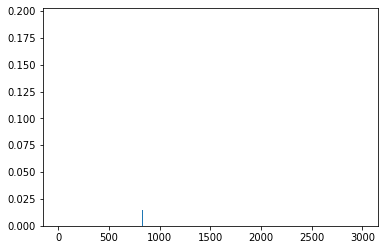

1


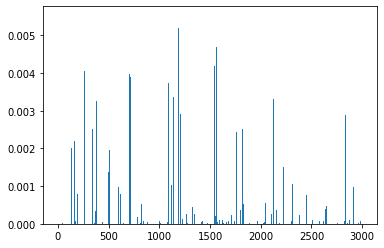

2


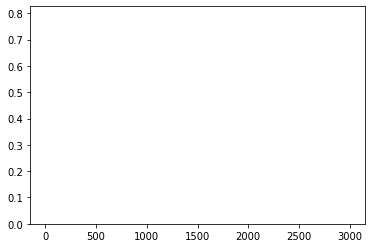

3


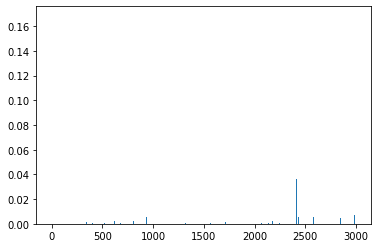

4


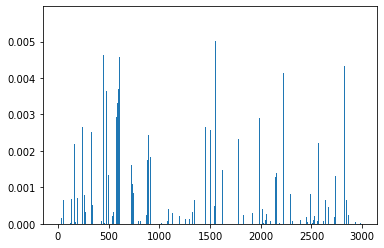

5


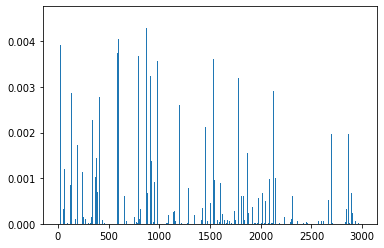

6


KeyboardInterrupt: 

In [360]:
#plt.bar(np.arange(len(H[19])),H[19]/H[19].sum())
#plt.show()
#plt.bar(np.arange(len(H[9])),H[9]/H[9].sum())
#plt.show()
#plt.bar(np.arange(len(H[1])),H[1]/H[1].sum())
#plt.show()

for sign_idx in range(20):
    print(sign_idx)
    plt.bar(np.arange(len(H[sign_idx])),H[sign_idx]/H[sign_idx].sum())
    plt.show()

In [403]:
cancers=[can for can in conv_dict]

for i in range(28):
    if len(np.where(np.sort(y_train)==i)[0])>0:
        id_1=np.min(np.where(np.sort(y_train)==i)[0])
        if len(np.where(np.sort(y_train)==i+1)[0])>0:
            id_2=np.min(np.where(np.sort(y_train)==i+1)[0])
        else:
            id_2=np.min(np.where(np.sort(y_train)==i+2)[0])
    
        print("{} between {} and {}".format(cancers[i],id_1,id_2))

T_ACC between 0 and 67
T_BLCA between 67 and 402
T_BRCA between 402 and 1495
T_CESC between 1495 and 1836
T_HBC between 1836 and 2162
T_COREAD between 2162 and 2661
T_DLBC between 2661 and 3078
T_GESCA between 3078 and 3529
T_GBM between 3529 and 3660
T_HNSC between 3660 and 4051
T_KICH between 4051 and 4105
T_KC between 4105 and 4762
T_LAML between 4762 and 5359
T_LGG between 5359 and 5768
T_LUAD between 5768 and 6259
T_LUSC between 6259 and 6755
T_MESO between 6755 and 6817
T_GC between 6817 and 7268
T_PAAD between 7268 and 7592
T_PCPG between 7592 and 7736
T_PRAD between 7736 and 8204
T_SARC between 8204 and 8405
T_SKCM between 8405 and 8775
T_TGCT between 8775 and 8895
T_THCA between 8895 and 9654
T_THYM between 9654 and 9726


0


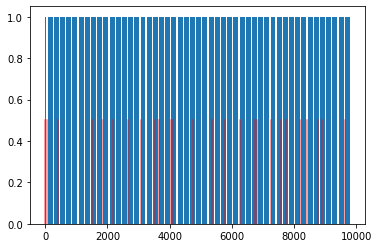

T_ACC =1.0
T_BLCA =1.0
T_BRCA =1.0
T_CESC =1.0
T_HBC =1.0
T_COREAD =1.0
T_DLBC =1.0
T_GESCA =1.0
T_GBM =1.0
T_HNSC =1.0
T_KICH =1.0
T_KC =1.0
T_LAML =1.0
T_LGG =1.0
T_LUAD =1.0
T_LUSC =1.0
T_MESO =1.0
T_GC =1.0
T_PAAD =1.0
T_PCPG =1.0
T_PRAD =1.0
T_SARC =1.0
T_SKCM =1.0
T_TGCT =1.0
T_THCA =1.0
T_THYM =1.0
0


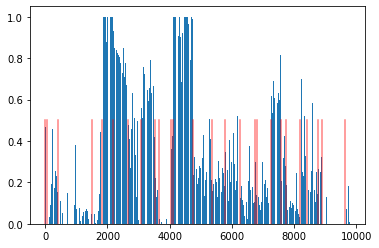

T_ACC =0.5389030575752258
T_BLCA =0.1500844657421112
T_BRCA =0.04588989540934563
T_CESC =0.1055615097284317
T_HBC =0.9655690789222717
T_COREAD =0.8086780309677124
T_DLBC =0.35673412680625916
T_GESCA =0.5514315366744995
T_GBM =0.20046676695346832
T_HNSC =0.019769027829170227
T_KICH =0.3726005256175995
T_KC =0.8957922458648682
T_LAML =0.331206738948822
T_LGG =0.19888350367546082
T_LUAD =0.2877889573574066
T_LUSC =0.10167922079563141
T_MESO =0.24807801842689514
T_GC =0.1718263328075409
T_PAAD =0.619422197341919
T_PCPG =0.32544228434562683
T_PRAD =0.11230095475912094
T_SARC =0.40842413902282715
T_SKCM =0.2111128270626068
T_TGCT =0.34982699155807495
T_THCA =0.0027841271366924047
T_THYM =0.008474472910165787
1


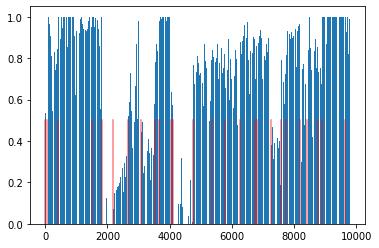

T_ACC =0.461096853017807
T_BLCA =0.8499155640602112
T_BRCA =0.9541100263595581
T_CESC =0.8944385051727295
T_HBC =0.034430891275405884
T_COREAD =0.1913219541311264
T_DLBC =0.6432659029960632
T_GESCA =0.4485684335231781
T_GBM =0.7995333075523376
T_HNSC =0.9802309274673462
T_KICH =0.6273994445800781
T_KC =0.10420771688222885
T_LAML =0.668793261051178
T_LGG =0.8011165857315063
T_LUAD =0.712211012840271
T_LUSC =0.8983207941055298
T_MESO =0.7519219517707825
T_GC =0.8281736969947815
T_PAAD =0.38057783246040344
T_PCPG =0.6745576858520508
T_PRAD =0.8876990079879761
T_SARC =0.5915758609771729
T_SKCM =0.7888871431350708
T_TGCT =0.650173008441925
T_THCA =0.9972158670425415
T_THYM =0.9915255308151245
0


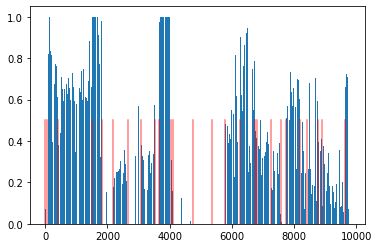

T_ACC =0.08287806808948517
T_BLCA =0.8016091585159302
T_BRCA =0.6120985150337219
T_CESC =0.8462997078895569
T_HBC =0.0296684168279171
T_COREAD =0.2665136158466339
T_DLBC =0.06264927238225937
T_GESCA =0.37639304995536804
T_GBM =0.00534247700124979
T_HNSC =0.9798958897590637
T_KICH =0.22890928387641907
T_KC =0.02295631356537342
T_LAML =0.0010751555673778057
T_LGG =0.0017405911348760128
T_LUAD =0.4630276560783386
T_LUSC =0.7555944323539734
T_MESO =0.44204017519950867
T_GC =0.3507978618144989
T_PAAD =0.2848556339740753
T_PCPG =0.021543992683291435
T_PRAD =0.5457230806350708
T_SARC =0.2036415934562683
T_SKCM =0.31303736567497253
T_TGCT =0.42340224981307983
T_THCA =0.16397470235824585
T_THYM =0.6229785084724426
1


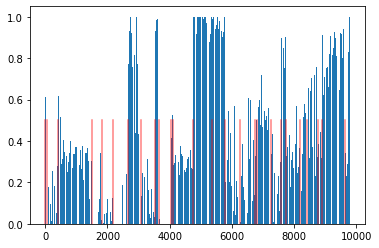

T_ACC =0.5276212692260742
T_BLCA =0.07803469896316528
T_BRCA =0.3565506935119629
T_CESC =0.07344793528318405
T_HBC =0.055660609155893326
T_COREAD =0.0073257144540548325
T_DLBC =0.7924980521202087
T_GESCA =0.14266742765903473
T_GBM =0.9456836581230164
T_HNSC =0.011338738724589348
T_KICH =0.49395090341567993
T_KC =0.31921741366386414
T_LAML =0.9627138376235962
T_LGG =0.9621977210044861
T_LUAD =0.29382747411727905
T_LUSC =0.1690489798784256
T_MESO =0.3739921748638153
T_GC =0.5405706763267517
T_PAAD =0.18254555761814117
T_PCPG =0.8231367468833923
T_PRAD =0.36436083912849426
T_SARC =0.5151674747467041
T_SKCM =0.5549268126487732
T_TGCT =0.2734459638595581
T_THCA =0.8347150087356567
T_THYM =0.3724653422832489
2


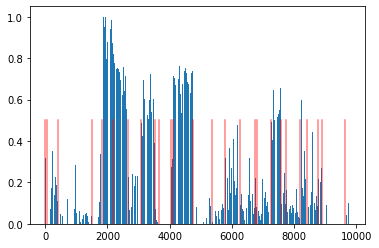

T_ACC =0.3895007371902466
T_BLCA =0.12035612761974335
T_BRCA =0.03135077282786369
T_CESC =0.08025228977203369
T_HBC =0.914671003818512
T_COREAD =0.7261607050895691
T_DLBC =0.14485269784927368
T_GESCA =0.4809395372867584
T_GBM =0.04897383227944374
T_HNSC =0.008765403181314468
T_KICH =0.2771397829055786
T_KC =0.6578262448310852
T_LAML =0.03621098771691322
T_LGG =0.036061663180589676
T_LUAD =0.24314488470554352
T_LUSC =0.07535658776760101
T_MESO =0.18396766483783722
T_GC =0.1086314469575882
T_PAAD =0.5325987935066223
T_PCPG =0.15531927347183228
T_PRAD =0.08991602808237076
T_SARC =0.2811909317970276
T_SKCM =0.13203579187393188
T_TGCT =0.30315181612968445
T_THCA =0.0013102467637509108
T_THYM =0.004556130152195692


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


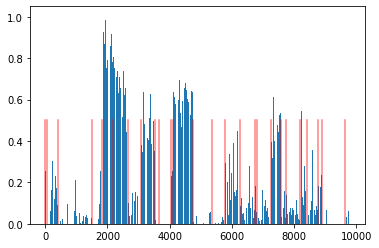

T_ACC =0.3159627318382263
T_BLCA =0.11140105128288269
T_BRCA =0.023325446993112564
T_CESC =0.07223856449127197
T_HBC =0.8495001196861267
T_COREAD =0.6818313598632812
T_DLBC =0.0860312357544899
T_GESCA =0.3998177647590637
T_GBM =0.014423361048102379
T_HNSC =0.007589956745505333
T_KICH =0.22711408138275146
T_KC =0.5739908814430237
T_LAML =0.01772112026810646
T_LGG =0.006907752249389887
T_LUAD =0.21605856716632843
T_LUSC =0.06544219702482224
T_MESO =0.15404577553272247
T_GC =0.07551982998847961
T_PAAD =0.4686621129512787
T_PCPG =0.09168725460767746
T_PRAD =0.07272563874721527
T_SARC =0.22413672506809235
T_SKCM =0.09591516107320786
T_TGCT =0.2748502194881439
T_THCA =0.0006961210165172815
T_THYM =0.003394389059394598
1


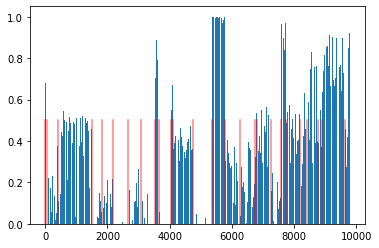

T_ACC =0.5978460311889648
T_BLCA =0.11436942964792252
T_BRCA =0.4045179486274719
T_CESC =0.06007923185825348
T_HBC =0.12144185602664948
T_COREAD =0.0017986857565119863
T_DLBC =0.1094459667801857
T_GESCA =0.02870739810168743
T_GBM =0.7515386939048767
T_HNSC =0.015602693893015385
T_KICH =0.6288316249847412
T_KC =0.40732479095458984
T_LAML =0.005443089175969362
T_LGG =0.9914606213569641
T_LUAD =0.29877808690071106
T_LUSC =0.1427588015794754
T_MESO =0.4250461757183075
T_GC =0.39123618602752686
T_PAAD =0.08652062714099884
T_PCPG =0.8844009041786194
T_PRAD =0.4587607979774475
T_SARC =0.5539409518241882
T_SKCM =0.5782253742218018
T_TGCT =0.3369441330432892
T_THCA =0.764872133731842
T_THYM =0.4378040134906769
2


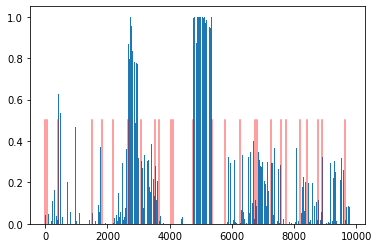

T_ACC =0.040004704147577286
T_BLCA =0.020150206983089447
T_BRCA =0.09064183384180069
T_CESC =0.06752172112464905
T_HBC =0.0029527205042541027
T_COREAD =0.0601080097258091
T_DLBC =0.746009886264801
T_GESCA =0.247846782207489
T_GBM =0.2317325472831726
T_HNSC =0.012019859626889229
T_KICH =0.0022609818261116743
T_KC =0.004319296218454838
T_LAML =0.9746615886688232
T_LGG =0.0011125276796519756
T_LUAD =0.0928596630692482
T_LUSC =0.09414003789424896
T_MESO =0.055513761937618256
T_GC =0.2732817232608795
T_PAAD =0.1840483844280243
T_PCPG =0.016889158636331558
T_PRAD =0.05563574284315109
T_SARC =0.07220059633255005
T_SKCM =0.08904509991407394
T_TGCT =0.03779701888561249
T_THCA =0.14642082154750824
T_THYM =0.058008380234241486
3


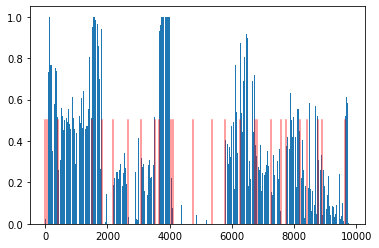

T_ACC =0.046186596155166626
T_BLCA =0.754079282283783
T_BRCA =0.4815147817134857
T_CESC =0.8001605272293091
T_HBC =0.026105312630534172
T_COREAD =0.2562619149684906
T_DLBC =0.058512844145298004
T_GESCA =0.3236280083656311
T_GBM =0.0023053702898323536
T_HNSC =0.9647875428199768
T_KICH =0.14179332554340363
T_KC =0.01436504628509283
T_LAML =0.0021741369273513556
T_LGG =0.0005191840464249253
T_LUAD =0.3923036456108093
T_LUSC =0.6976589560508728
T_MESO =0.36539432406425476
T_GC =0.25996220111846924
T_PAAD =0.2607688903808594
T_PCPG =0.007022686302661896
T_PRAD =0.4128778278827667
T_SARC =0.14972171187400818
T_SKCM =0.23681436479091644
T_TGCT =0.3504085838794708
T_THCA =0.08801090717315674
T_THYM =0.5007932186126709
0


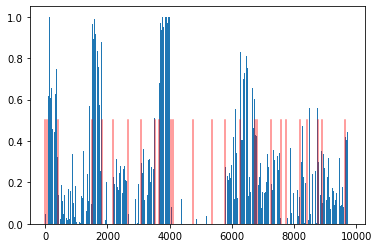

T_ACC =0.07587213814258575
T_BLCA =0.6362161040306091
T_BRCA =0.12704791128635406
T_CESC =0.7246322631835938
T_HBC =0.02762509509921074
T_COREAD =0.25496140122413635
T_DLBC =0.04931611195206642
T_GESCA =0.3022565245628357
T_GBM =0.003098840592429042
T_HNSC =0.9300276637077332
T_KICH =0.038781166076660156
T_KC =0.014301936142146587
T_LAML =0.0028225041460245848
T_LGG =0.0006224148673936725
T_LUAD =0.2893306314945221
T_LUSC =0.624910295009613
T_MESO =0.4195649325847626
T_GC =0.1770864874124527
T_PAAD =0.2817780077457428
T_PCPG =0.001780299236997962
T_PRAD =0.05459292232990265
T_SARC =0.1684936285018921
T_SKCM =0.17855772376060486
T_TGCT =0.2995981276035309
T_THCA =0.14972229301929474
T_THYM =0.39479443430900574
1


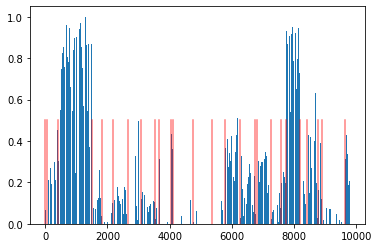

T_ACC =0.056559741497039795
T_BLCA =0.20819781720638275
T_BRCA =0.7301979660987854
T_CESC =0.12423061579465866
T_HBC =0.027479371055960655
T_COREAD =0.0778205618262291
T_DLBC =0.04281771555542946
T_GESCA =0.1148933693766594
T_GBM =0.040295008569955826
T_HNSC =0.034960709512233734
T_KICH =0.36726558208465576
T_KC =0.02295445092022419
T_LAML =0.001284432364627719
T_LGG =0.008098381571471691
T_LUAD =0.2950544059276581
T_LUSC =0.1434136927127838
T_MESO =0.05783173814415932
T_GC =0.2863534092903137
T_PAAD =0.06442006677389145
T_PCPG =0.18379847705364227
T_PRAD =0.816970944404602
T_SARC =0.09152790904045105
T_SKCM =0.2556515038013458
T_TGCT =0.22606156766414642
T_THCA =0.01849530264735222
T_THYM =0.29521381855010986
2


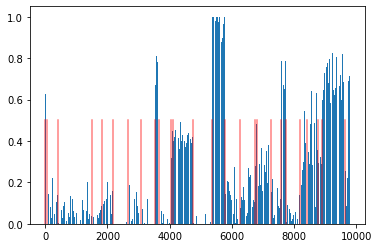

T_ACC =0.5514569282531738
T_BLCA =0.05907684937119484
T_BRCA =0.05377747863531113
T_CESC =0.040718067437410355
T_HBC =0.10645132511854172
T_COREAD =0.00048514484660699964
T_DLBC =0.09840147942304611
T_GESCA =0.01777501404285431
T_GBM =0.7023231983184814
T_HNSC =0.019552579149603844
T_KICH =0.4142570197582245
T_KC =0.4218933880329132
T_LAML =0.00797927938401699
T_LGG =0.9794619083404541
T_LUAD =0.17123237252235413
T_LUSC =0.10394144058227539
T_MESO =0.3625260889530182
T_GC =0.23417241871356964
T_PAAD =0.080511175096035
T_PCPG =0.7232863306999207
T_PRAD =0.048903848975896835
T_SARC =0.4868670701980591
T_SKCM =0.40993642807006836
T_TGCT =0.22139953076839447
T_THCA =0.6950939297676086
T_THYM =0.2606452405452728
3


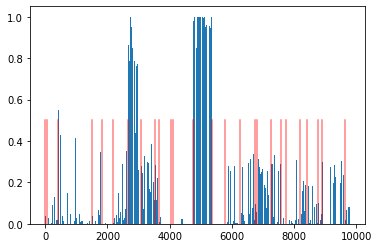

T_ACC =0.03762466832995415
T_BLCA =0.014885404147207737
T_BRCA =0.07942306250333786
T_CESC =0.052734553813934326
T_HBC =0.0028659289237111807
T_COREAD =0.05924483388662338
T_DLBC =0.736068606376648
T_GESCA =0.22838252782821655
T_GBM =0.23706604540348053
T_HNSC =0.00833345577120781
T_KICH =0.0022306370083242655
T_KC =0.003920818213373423
T_LAML =0.972251296043396
T_LGG =0.000863366003613919
T_LUAD =0.0812852680683136
T_LUSC =0.07743211090564728
T_MESO =0.04079701378941536
T_GC =0.24578246474266052
T_PAAD =0.17392003536224365
T_PCPG =0.016972029581665993
T_PRAD =0.049308113753795624
T_SARC =0.06547394394874573
T_SKCM =0.08268535882234573
T_TGCT =0.032867494970560074
T_THCA =0.13627123832702637
T_THYM =0.04720528423786163
4


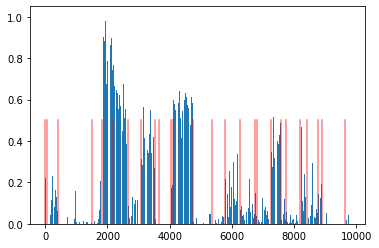

T_ACC =0.27848657965660095
T_BLCA =0.08162388950586319
T_BRCA =0.009553552605211735
T_CESC =0.057684510946273804
T_HBC =0.835578203201294
T_COREAD =0.6074880361557007
T_DLBC =0.07339604943990707
T_GESCA =0.33669260144233704
T_GBM =0.017216907814145088
T_HNSC =0.007125574164092541
T_KICH =0.17746557295322418
T_KC =0.5369294285774231
T_LAML =0.015662480145692825
T_LGG =0.010954024270176888
T_LUAD =0.1630972921848297
T_LUSC =0.050302498042583466
T_MESO =0.11928018927574158
T_GC =0.05660520866513252
T_PAAD =0.3993707299232483
T_PCPG =0.07416284829378128
T_PRAD =0.030224112793803215
T_SARC =0.18763744831085205
T_SKCM =0.07316895574331284
T_TGCT =0.22007332742214203
T_THCA =0.00041718652937561274
T_THYM =0.0021412456408143044


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


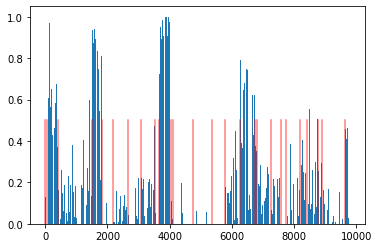

T_ACC =0.11256998777389526
T_BLCA =0.6136730313301086
T_BRCA =0.1503569781780243
T_CESC =0.6972256302833557
T_HBC =0.014047663658857346
T_COREAD =0.09447253495454788
T_DLBC =0.0641719177365303
T_GESCA =0.22155900299549103
T_GBM =0.013655304908752441
T_HNSC =0.9084165096282959
T_KICH =0.04494302347302437
T_KC =0.018952064216136932
T_LAML =0.0035228109918534756
T_LGG =0.002607138128951192
T_LUAD =0.1956913322210312
T_LUSC =0.5841590166091919
T_MESO =0.38965779542922974
T_GC =0.15048551559448242
T_PAAD =0.16442568600177765
T_PCPG =0.009989804588258266
T_PRAD =0.06227317079901695
T_SARC =0.21096277236938477
T_SKCM =0.21306434273719788
T_TGCT =0.2633135914802551
T_THCA =0.034806717187166214
T_THYM =0.39465001225471497
1


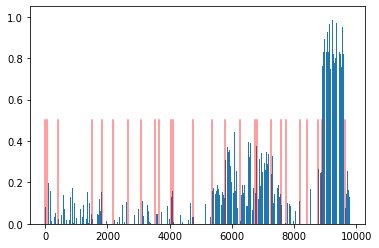

T_ACC =0.12170785665512085
T_BLCA =0.06534428149461746
T_BRCA =0.060105159878730774
T_CESC =0.04515216127038002
T_HBC =0.010424379259347916
T_COREAD =0.012518090195953846
T_DLBC =0.020203670486807823
T_GESCA =0.03412092477083206
T_GBM =0.04729454964399338
T_HNSC =0.016936251893639565
T_KICH =0.2384129762649536
T_KC =0.045671068131923676
T_LAML =0.013564763590693474
T_LGG =0.17230720818042755
T_LUAD =0.30714356899261475
T_LUSC =0.14815223217010498
T_MESO =0.1753515750169754
T_GC =0.24456782639026642
T_PAAD =0.13814479112625122
T_PCPG =0.0426459014415741
T_PRAD =0.043198443949222565
T_SARC =0.03238339349627495
T_SKCM =0.02934500388801098
T_TGCT =0.18329860270023346
T_THCA =0.8310989141464233
T_THYM =0.22216862440109253
2


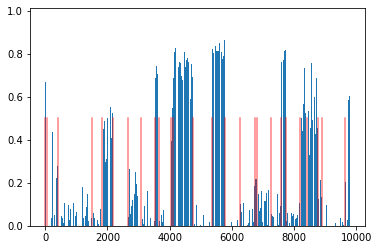

T_ACC =0.6017374396324158
T_BLCA =0.0509115532040596
T_BRCA =0.03829297050833702
T_CESC =0.03857416287064552
T_HBC =0.43915608525276184
T_COREAD =0.004785214550793171
T_DLBC =0.15092788636684418
T_GESCA =0.033613067120313644
T_GBM =0.6622872352600098
T_HNSC =0.02425200119614601
T_KICH =0.3986688256263733
T_KC =0.698971152305603
T_LAML =0.015290469862520695
T_LGG =0.8015414476394653
T_LUAD =0.011019440367817879
T_LUSC =0.02730073593556881
T_MESO =0.30091604590415955
T_GC =0.09733151644468307
T_PAAD =0.05648168921470642
T_PCPG =0.7721701860427856
T_PRAD =0.048611707985401154
T_SARC =0.6117478609085083
T_SKCM =0.5102508664131165
T_TGCT =0.15180829167366028
T_THCA =0.014009895734488964
T_THYM =0.11377342790365219
3


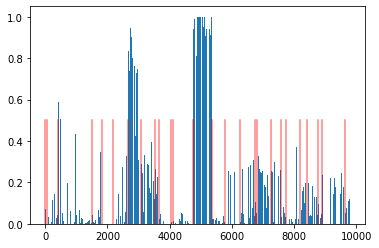

T_ACC =0.05583900585770607
T_BLCA =0.016874825581908226
T_BRCA =0.09266055375337601
T_CESC =0.055236317217350006
T_HBC =0.0022873010020703077
T_COREAD =0.044832535088062286
T_DLBC =0.7054321765899658
T_GESCA =0.22649429738521576
T_GBM =0.2404365837574005
T_HNSC =0.013120044022798538
T_KICH =0.002974187023937702
T_KC =0.009866312146186829
T_LAML =0.953594982624054
T_LGG =0.012111365795135498
T_LUAD =0.06625694036483765
T_LUSC =0.07248157262802124
T_MESO =0.05324463173747063
T_GC =0.24632583558559418
T_PAAD =0.15467418730258942
T_PCPG =0.05410951003432274
T_PRAD =0.05937975272536278
T_SARC =0.09132406860589981
T_SKCM =0.11073198914527893
T_TGCT =0.03396725654602051
T_THCA =0.10842889547348022
T_THYM =0.05525178089737892
4


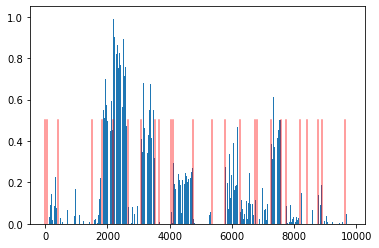

T_ACC =0.06992330402135849
T_BLCA =0.1025666669011116
T_BRCA =0.012861305847764015
T_CESC =0.0734870433807373
T_HBC =0.5269877910614014
T_COREAD =0.7952425479888916
T_DLBC =0.036894939839839935
T_GESCA =0.41078779101371765
T_GBM =0.0
T_HNSC =0.010994264855980873
T_KICH =0.05353119596838951
T_KC =0.21073465049266815
T_LAML =0.013255086727440357
T_LGG =0.0
T_LUAD =0.22411005198955536
T_LUSC =0.07013876736164093
T_MESO =0.04189959168434143
T_GC =0.057379063218832016
T_PAAD =0.4544369876384735
T_PCPG =0.002303074114024639
T_PRAD =0.04130563884973526
T_SARC =0.01547424215823412
T_SKCM =0.004436832387000322
T_TGCT =0.20813018083572388
T_THCA =0.003497410798445344
T_THYM =0.0029283841140568256
5


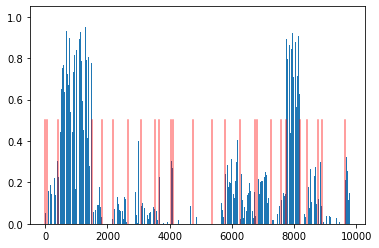

T_ACC =0.03822235390543938
T_BLCA =0.15062959492206573
T_BRCA =0.6457231044769287
T_CESC =0.09032470732927322
T_HBC =0.007096727378666401
T_COREAD =0.04814911633729935
T_DLBC =0.022369375452399254
T_GESCA =0.07342493534088135
T_GBM =0.0363263338804245
T_HNSC =0.02628088928759098
T_KICH =0.2614698112010956
T_KC =0.015804767608642578
T_LAML =0.0007719022105447948
T_LGG =0.011432833969593048
T_LUAD =0.19577865302562714
T_LUSC =0.09776772558689117
T_MESO =0.03893033042550087
T_GC =0.20391027629375458
T_PAAD =0.03183669224381447
T_PCPG =0.11878153681755066
T_PRAD =0.7452313303947449
T_SARC =0.03810764104127884
T_SKCM =0.1321709305047989
T_TGCT =0.15948206186294556
T_THCA =0.008158148266375065
T_THYM =0.21122778952121735
0


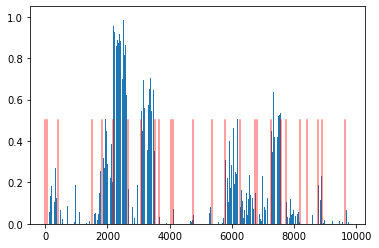

T_ACC =0.04690238833427429
T_BLCA =0.12468096613883972
T_BRCA =0.014991463162004948
T_CESC =0.08636146038770676
T_HBC =0.31624022126197815
T_COREAD =0.8688189387321472
T_DLBC =0.05006474256515503
T_GESCA =0.48486876487731934
T_GBM =0.004269083961844444
T_HNSC =0.01643906906247139
T_KICH =0.00403621094301343
T_KC =0.02285095304250717
T_LAML =0.015722177922725677
T_LGG =0.004374451469630003
T_LUAD =0.2634211480617523
T_LUSC =0.08992725610733032
T_MESO =0.03537925332784653
T_GC =0.06545175611972809
T_PAAD =0.4981197714805603
T_PCPG =0.002882895991206169
T_PRAD =0.06379196047782898
T_SARC =0.01466387789696455
T_SKCM =0.009330227971076965
T_TGCT =0.22044214606285095
T_THCA =0.003825159976258874
T_THYM =0.0037620190996676683
1


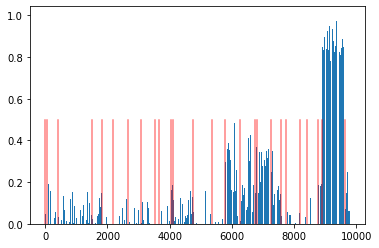

T_ACC =0.09504728764295578
T_BLCA =0.06063379347324371
T_BRCA =0.0587831512093544
T_CESC =0.0464998222887516
T_HBC =0.011349205859005451
T_COREAD =0.011734255589544773
T_DLBC =0.02672855369746685
T_GESCA =0.03338470309972763
T_GBM =0.002158009447157383
T_HNSC =0.015576201491057873
T_KICH =0.2697429358959198
T_KC =0.09532300382852554
T_LAML =0.021206790581345558
T_LGG =0.019214775413274765
T_LUAD =0.3065677583217621
T_LUSC =0.14382199943065643
T_MESO =0.1761080026626587
T_GC =0.266589879989624
T_PAAD =0.13670305907726288
T_PCPG =0.01588020846247673
T_PRAD =0.02263333648443222
T_SARC =0.024400269612669945
T_SKCM =0.016841625794768333
T_TGCT =0.1477799117565155
T_THCA =0.8489782810211182
T_THYM =0.21242263913154602
2


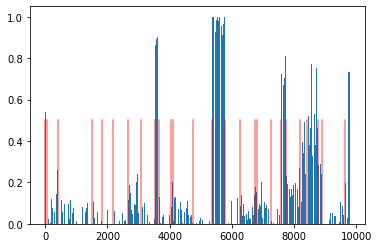

T_ACC =0.41313910484313965
T_BLCA =0.05211475491523743
T_BRCA =0.02674746699631214
T_CESC =0.026255706325173378
T_HBC =0.012083606794476509
T_COREAD =0.008234335109591484
T_DLBC =0.13456866145133972
T_GESCA =0.027057461440563202
T_GBM =0.8524014949798584
T_HNSC =0.02677120640873909
T_KICH =0.09336577355861664
T_KC =0.06059306859970093
T_LAML =0.011908336542546749
T_LGG =0.9630767703056335
T_LUAD =0.017530914396047592
T_LUSC =0.045769937336444855
T_MESO =0.16175274550914764
T_GC =0.0680074617266655
T_PAAD =0.020312953740358353
T_PCPG =0.729516327381134
T_PRAD =0.16167369484901428
T_SARC =0.42208626866340637
T_SKCM =0.5072334408760071
T_TGCT =0.1752680391073227
T_THCA =0.035750482231378555
T_THYM =0.11423970758914948
3


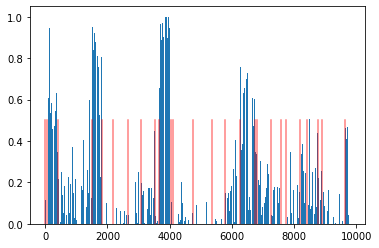

T_ACC =0.10158442705869675
T_BLCA =0.5868542790412903
T_BRCA =0.14908026158809662
T_CESC =0.6924760937690735
T_HBC =0.014464721083641052
T_COREAD =0.03750116378068924
T_DLBC =0.07559627294540405
T_GESCA =0.20342907309532166
T_GBM =0.018113475292921066
T_HNSC =0.8988625407218933
T_KICH =0.03865930065512657
T_KC =0.034452617168426514
T_LAML =0.006136284209787846
T_LGG =0.00456664152443409
T_LUAD =0.16961368918418884
T_LUSC =0.5702331066131592
T_MESO =0.37353765964508057
T_GC =0.15494607388973236
T_PAAD =0.13247807323932648
T_PCPG =0.009640276432037354
T_PRAD =0.05433529242873192
T_SARC =0.19562022387981415
T_SKCM =0.195505291223526
T_TGCT =0.23592808842658997
T_THCA =0.031729042530059814
T_THYM =0.396887868642807
4


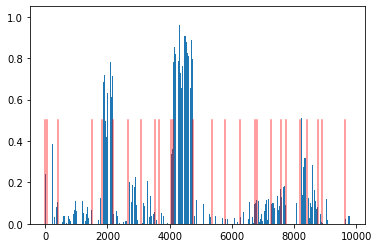

T_ACC =0.2881324291229248
T_BLCA =0.029687702655792236
T_BRCA =0.02892279624938965
T_CESC =0.02836577035486698
T_HBC =0.6301819086074829
T_COREAD =0.02683815360069275
T_DLBC =0.10416992008686066
T_GESCA =0.05690942332148552
T_GBM =0.014808371663093567
T_HNSC =0.010061106644570827
T_KICH =0.3304242491722107
T_KC =0.7486886978149414
T_LAML =0.027867872267961502
T_LGG =0.00500157754868269
T_LUAD =0.021096834912896156
T_LUSC =0.015378529205918312
T_MESO =0.1850305199623108
T_GC =0.06969496607780457
T_PAAD =0.09385492652654648
T_PCPG =0.13918495178222656
T_PRAD =0.010513003915548325
T_SARC =0.2614750862121582
T_SKCM =0.1123587116599083
T_TGCT =0.07466636598110199
T_THCA =0.004377420991659164
T_THYM =0.02878250740468502
5


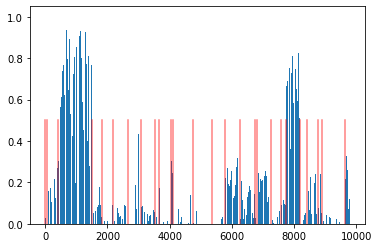

T_ACC =0.027432890608906746
T_BLCA =0.13705861568450928
T_BRCA =0.657304048538208
T_CESC =0.08678711205720901
T_HBC =0.014092676341533661
T_COREAD =0.025113575160503387
T_DLBC =0.029455816373229027
T_GESCA =0.06254785507917404
T_GBM =0.009816843084990978
T_HNSC =0.02464240789413452
T_KICH =0.2617301344871521
T_KC =0.0247073695063591
T_LAML =0.0013759562280029058
T_LGG =0.002170966938138008
T_LUAD =0.1812814623117447
T_LUSC =0.0906875878572464
T_MESO =0.0372115783393383
T_GC =0.2178531289100647
T_PAAD =0.024968937039375305
T_PCPG =0.08085228502750397
T_PRAD =0.6507573127746582
T_SARC =0.031995244324207306
T_SKCM =0.10396188497543335
T_TGCT =0.12968772649765015
T_THCA =0.0076249768026173115
T_THYM =0.21122093498706818
6


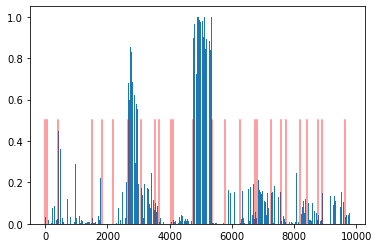

T_ACC =0.02776147611439228
T_BLCA =0.008969848975539207
T_BRCA =0.06417077779769897
T_CESC =0.03325406834483147
T_HBC =0.0015876764664426446
T_COREAD =0.021759577095508575
T_DLBC =0.579416036605835
T_GESCA =0.1318027228116989
T_GBM =0.0984327420592308
T_HNSC =0.007647430058568716
T_KICH =0.0020414250902831554
T_KC =0.013384241610765457
T_LAML =0.9157825112342834
T_LGG =0.0015947713982313871
T_LUAD =0.04048823192715645
T_LUSC =0.044181566685438156
T_MESO =0.03098023310303688
T_GC =0.15745669603347778
T_PAAD =0.0935623049736023
T_PCPG =0.022043075412511826
T_PRAD =0.03629545122385025
T_SARC =0.04975902661681175
T_SKCM =0.05476881563663483
T_TGCT =0.0162277203053236
T_THCA =0.06771465390920639
T_THYM =0.032684311270713806
0


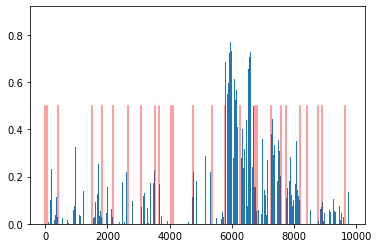

T_ACC =0.0341985784471035
T_BLCA =0.08456646651029587
T_BRCA =0.05350812152028084
T_CESC =0.07023365795612335
T_HBC =0.06999825686216354
T_COREAD =0.013669895939528942
T_DLBC =0.01768154464662075
T_GESCA =0.1335846185684204
T_GBM =0.0057623242028057575
T_HNSC =0.028862858191132545
T_KICH =0.005449530202895403
T_KC =0.013939311727881432
T_LAML =0.05415141209959984
T_LGG =0.011243023909628391
T_LUAD =0.583213210105896
T_LUSC =0.33965930342674255
T_MESO =0.17785456776618958
T_GC =0.11203756928443909
T_PAAD =0.2868175804615021
T_PCPG =0.010687307454645634
T_PRAD =0.1520959883928299
T_SARC =0.01822909340262413
T_SKCM =0.01848183572292328
T_TGCT =0.08135199546813965
T_THCA =0.032977644354104996
T_THYM =0.00917588360607624
1


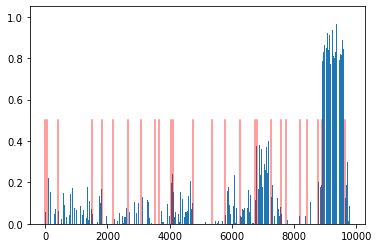

T_ACC =0.10138512402772903
T_BLCA =0.05774570256471634
T_BRCA =0.06625241786241531
T_CESC =0.04370054975152016
T_HBC =0.00790501944720745
T_COREAD =0.019248036667704582
T_DLBC =0.03580334782600403
T_GESCA =0.02219943143427372
T_GBM =0.0028077431488782167
T_HNSC =0.019360311329364777
T_KICH =0.31194573640823364
T_KC =0.11343144625425339
T_LAML =0.0045400941744446754
T_LGG =0.021244676783680916
T_LUAD =0.10437770187854767
T_LUSC =0.04595630615949631
T_MESO =0.1300853192806244
T_GC =0.2597048580646515
T_PAAD =0.05941025912761688
T_PCPG =0.018715493381023407
T_PRAD =0.010789069347083569
T_SARC =0.02782461792230606
T_SKCM =0.014876345172524452
T_TGCT =0.14722301065921783
T_THCA =0.8358686566352844
T_THYM =0.2477983832359314
2


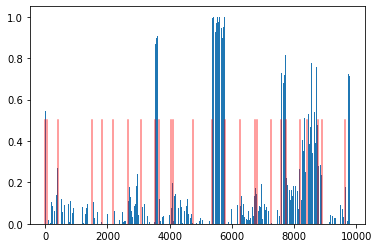

T_ACC =0.41458097100257874
T_BLCA =0.05076194927096367
T_BRCA =0.024550605565309525
T_CESC =0.025052187964320183
T_HBC =0.011777574196457863
T_COREAD =0.010701431892812252
T_DLBC =0.12802134454250336
T_GESCA =0.024420876055955887
T_GBM =0.8525616526603699
T_HNSC =0.026731647551059723
T_KICH =0.08835972845554352
T_KC =0.06593985110521317
T_LAML =0.011152754537761211
T_LGG =0.954269289970398
T_LUAD =0.015012482181191444
T_LUSC =0.041248854249715805
T_MESO =0.16040416061878204
T_GC =0.06107895076274872
T_PAAD =0.016875147819519043
T_PCPG =0.7340986728668213
T_PRAD =0.1536470353603363
T_SARC =0.43091315031051636
T_SKCM =0.513004720211029
T_TGCT =0.17076335847377777
T_THCA =0.0275333933532238
T_THYM =0.10162278264760971
3


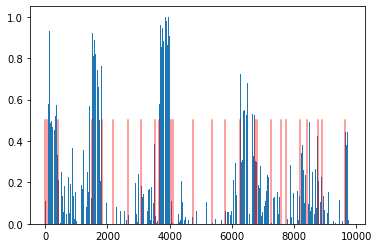

T_ACC =0.09708026796579361
T_BLCA =0.5472550392150879
T_BRCA =0.13676434755325317
T_CESC =0.6562589406967163
T_HBC =0.012259669601917267
T_COREAD =0.036250095814466476
T_DLBC =0.07174531370401382
T_GESCA =0.18092982470989227
T_GBM =0.017621811479330063
T_HNSC =0.8694403171539307
T_KICH =0.04117198660969734
T_KC =0.03273063898086548
T_LAML =0.005931012332439423
T_LGG =0.0037030642852187157
T_LUAD =0.09660658240318298
T_LUSC =0.4734114408493042
T_MESO =0.3163825571537018
T_GC =0.13525575399398804
T_PAAD =0.09689093381166458
T_PCPG =0.008608099073171616
T_PRAD =0.04333512485027313
T_SARC =0.19097387790679932
T_SKCM =0.1876326948404312
T_TGCT =0.2114361971616745
T_THCA =0.026793604716658592
T_THYM =0.3745775520801544
4


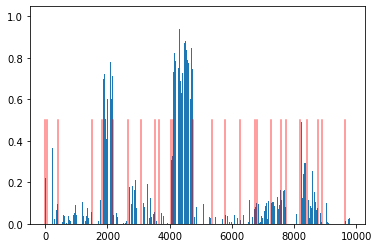

T_ACC =0.2667369842529297
T_BLCA =0.026502268388867378
T_BRCA =0.02565256878733635
T_CESC =0.02582979016005993
T_HBC =0.6236802339553833
T_COREAD =0.022843442857265472
T_DLBC =0.09214793890714645
T_GESCA =0.05503062903881073
T_GBM =0.013340001925826073
T_HNSC =0.009655104018747807
T_KICH =0.29893290996551514
T_KC =0.7147823572158813
T_LAML =0.02155078575015068
T_LGG =0.004154957365244627
T_LUAD =0.025925932452082634
T_LUSC =0.013396140187978745
T_MESO =0.15865708887577057
T_GC =0.06316550821065903
T_PAAD =0.09531210362911224
T_PCPG =0.12318705022335052
T_PRAD =0.009568072855472565
T_SARC =0.23835712671279907
T_SKCM =0.10138337314128876
T_TGCT =0.06825926899909973
T_THCA =0.004188212100416422
T_THYM =0.023746557533740997
5


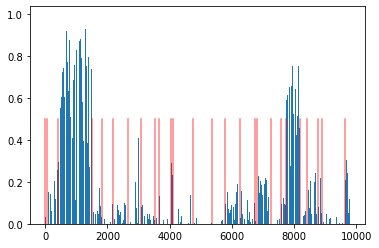

T_ACC =0.026739006862044334
T_BLCA =0.12020833045244217
T_BRCA =0.6247431635856628
T_CESC =0.07885055243968964
T_HBC =0.010446352884173393
T_COREAD =0.030119623988866806
T_DLBC =0.03368498384952545
T_GESCA =0.04964471608400345
T_GBM =0.008762924000620842
T_HNSC =0.02301754429936409
T_KICH =0.24678052961826324
T_KC =0.02380973845720291
T_LAML =0.0013982615200802684
T_LGG =0.0011523256544023752
T_LUAD =0.07544692605733871
T_LUSC =0.042075153440237045
T_MESO =0.023067733272910118
T_GC =0.18780724704265594
T_PAAD =0.013835752382874489
T_PCPG =0.08031366020441055
T_PRAD =0.567841112613678
T_SARC =0.03184890002012253
T_SKCM =0.10391014814376831
T_TGCT =0.11526641994714737
T_THCA =0.008075029589235783
T_THYM =0.20311801135540009
6


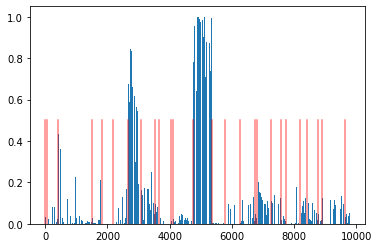

T_ACC =0.027327576652169228
T_BLCA =0.007598630618304014
T_BRCA =0.05519379675388336
T_CESC =0.0288337804377079
T_HBC =0.0012282413663342595
T_COREAD =0.0217970572412014
T_DLBC =0.5720146894454956
T_GESCA =0.11922658979892731
T_GBM =0.09547097235918045
T_HNSC =0.007868965156376362
T_KICH =0.002726036822423339
T_KC =0.01475621573626995
T_LAML =0.8856930136680603
T_LGG =0.00168077670969069
T_LUAD =0.02113882452249527
T_LUSC =0.026661384850740433
T_MESO =0.023141495883464813
T_GC =0.1422521024942398
T_PAAD =0.07323132455348969
T_PCPG =0.02322663925588131
T_PRAD =0.029234930872917175
T_SARC =0.05106664076447487
T_SKCM =0.054537612944841385
T_TGCT =0.016461336985230446
T_THCA =0.05860619992017746
T_THYM =0.03492584079504013
7


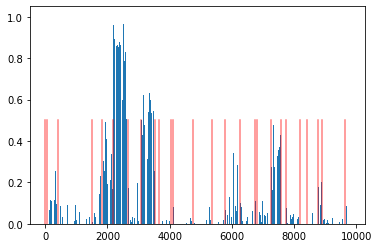

T_ACC =0.03195146098732948
T_BLCA =0.10536164045333862
T_BRCA =0.013334928080439568
T_CESC =0.07124054431915283
T_HBC =0.26270467042922974
T_COREAD =0.8453704118728638
T_DLBC =0.048900824040174484
T_GESCA =0.4149633049964905
T_GBM =0.0036725755780935287
T_HNSC =0.01506322342902422
T_KICH =0.004633537959307432
T_KC =0.020610490813851357
T_LAML =0.015582699328660965
T_LGG =0.002551922807469964
T_LUAD =0.07827834784984589
T_LUSC =0.017591409385204315
T_MESO =0.010407032445073128
T_GC =0.03869800642132759
T_PAAD =0.35762688517570496
T_PCPG =0.0011631319066509604
T_PRAD =0.03348865360021591
T_SARC =0.010786637663841248
T_SKCM =0.006173345725983381
T_TGCT =0.18923839926719666
T_THCA =0.005957225803285837
T_THYM =0.005035014823079109
0


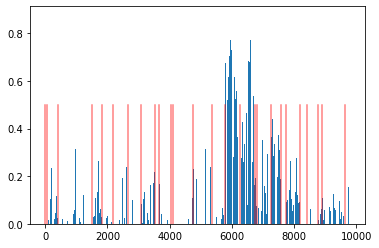

T_ACC =0.020866503939032555
T_BLCA =0.08861333876848221
T_BRCA =0.04644980654120445
T_CESC =0.0737333670258522
T_HBC =0.03187118470668793
T_COREAD =0.015611658804118633
T_DLBC =0.018506433814764023
T_GESCA =0.13498355448246002
T_GBM =0.0064376527443528175
T_HNSC =0.029067065566778183
T_KICH =0.0067327748984098434
T_KC =0.019731944426894188
T_LAML =0.05765940994024277
T_LGG =0.013525184243917465
T_LUAD =0.5866653919219971
T_LUSC =0.3525921106338501
T_MESO =0.2006542831659317
T_GC =0.11899558454751968
T_PAAD =0.28973114490509033
T_PCPG =0.01067577488720417
T_PRAD =0.12233347445726395
T_SARC =0.020830074325203896
T_SKCM =0.019018305465579033
T_TGCT =0.0784730613231659
T_THCA =0.03863924369215965
T_THYM =0.009003070183098316
1


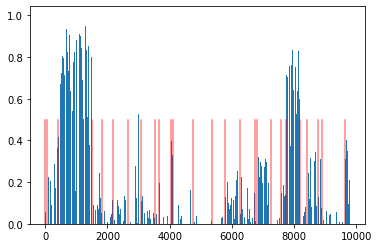

T_ACC =0.03764936700463295
T_BLCA =0.1704465001821518
T_BRCA =0.6996833086013794
T_CESC =0.11133662611246109
T_HBC =0.022083677351474762
T_COREAD =0.03696295619010925
T_DLBC =0.048727571964263916
T_GESCA =0.06725923717021942
T_GBM =0.016396887600421906
T_HNSC =0.03398994356393814
T_KICH =0.3318652808666229
T_KC =0.029795462265610695
T_LAML =0.002058188896626234
T_LGG =0.002376249060034752
T_LUAD =0.10187887400388718
T_LUSC =0.06053746119141579
T_MESO =0.03198453038930893
T_GC =0.2686401605606079
T_PAAD =0.018177108839154243
T_PCPG =0.12387605756521225
T_PRAD =0.6731870174407959
T_SARC =0.045376554131507874
T_SKCM =0.16286742687225342
T_TGCT =0.16908803582191467
T_THCA =0.01378440111875534
T_THYM =0.29017770290374756
2


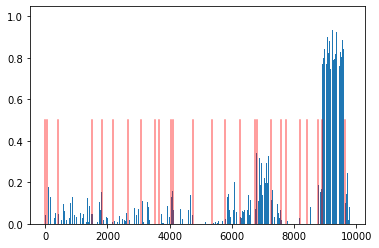

T_ACC =0.09803798049688339
T_BLCA =0.04495636746287346
T_BRCA =0.04447617381811142
T_CESC =0.03394225984811783
T_HBC =0.01631208509206772
T_COREAD =0.013114375062286854
T_DLBC =0.027904542163014412
T_GESCA =0.016582971438765526
T_GBM =0.003185200272127986
T_HNSC =0.017298167571425438
T_KICH =0.2205391228199005
T_KC =0.051211871206760406
T_LAML =0.004502345807850361
T_LGG =0.026018889620900154
T_LUAD =0.08122708648443222
T_LUSC =0.037424616515636444
T_MESO =0.0961439460515976
T_GC =0.19910597801208496
T_PAAD =0.045725829899311066
T_PCPG =0.014060858637094498
T_PRAD =0.00741566950455308
T_SARC =0.019831301644444466
T_SKCM =0.01317611988633871
T_TGCT =0.12470483779907227
T_THCA =0.8188360929489136
T_THYM =0.2079475224018097
3


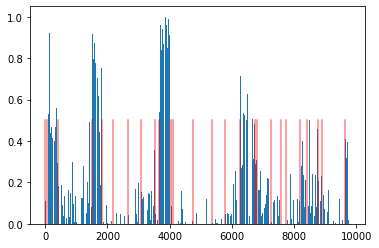

T_ACC =0.09575178474187851
T_BLCA =0.5043657422065735
T_BRCA =0.10588238388299942
T_CESC =0.6234017610549927
T_HBC =0.018224725499749184
T_COREAD =0.026650940999388695
T_DLBC =0.06626439094543457
T_GESCA =0.16859324276447296
T_GBM =0.020570198073983192
T_HNSC =0.8523340821266174
T_KICH =0.031131815165281296
T_KC =0.018737491220235825
T_LAML =0.0060834442265331745
T_LGG =0.004557906184345484
T_LUAD =0.08419379591941833
T_LUSC =0.4499249756336212
T_MESO =0.29947057366371155
T_GC =0.12011834979057312
T_PAAD =0.08461660146713257
T_PCPG =0.007719417568296194
T_PRAD =0.03333451226353645
T_SARC =0.18026725947856903
T_SKCM =0.18635515868663788
T_TGCT =0.2006770819425583
T_THCA =0.028839975595474243
T_THYM =0.3399559259414673
4


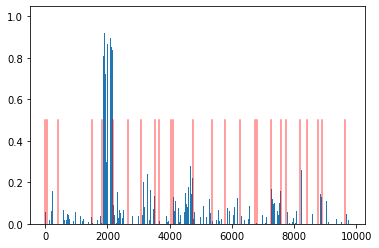

T_ACC =0.23025235533714294
T_BLCA =0.016365906223654747
T_BRCA =0.015442543663084507
T_CESC =0.007978794164955616
T_HBC =0.7897741198539734
T_COREAD =0.0454358346760273
T_DLBC =0.011985997669398785
T_GESCA =0.0700758844614029
T_GBM =0.009720793925225735
T_HNSC =0.014452864415943623
T_KICH =0.034183304756879807
T_KC =0.0824892669916153
T_LAML =0.0241559948772192
T_LGG =0.009928245097398758
T_LUAD =0.026617683470249176
T_LUSC =0.01615532673895359
T_MESO =0.012950212694704533
T_GC =0.0068154106847941875
T_PAAD =0.08411647379398346
T_PCPG =0.009069773368537426
T_PRAD =0.02532101981341839
T_SARC =0.01067670900374651
T_SKCM =0.013961154967546463
T_TGCT =0.08812018483877182
T_THCA =0.0058387648314237595
T_THYM =0.02053902857005596
5


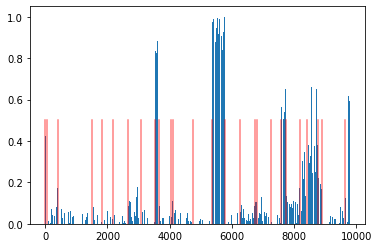

T_ACC =0.30989184975624084
T_BLCA =0.03566480427980423
T_BRCA =0.013296714052557945
T_CESC =0.01632479764521122
T_HBC =0.019472861662507057
T_COREAD =0.006416100077331066
T_DLBC =0.08524712920188904
T_GESCA =0.016779568046331406
T_GBM =0.801378071308136
T_HNSC =0.019897274672985077
T_KICH =0.05019095167517662
T_KC =0.024823036044836044
T_LAML =0.008225323632359505
T_LGG =0.9297733306884766
T_LUAD =0.01060112752020359
T_LUSC =0.030024120584130287
T_MESO =0.10241024941205978
T_GC =0.03587260842323303
T_PAAD =0.011227164417505264
T_PCPG =0.5891751646995544
T_PRAD =0.0922822579741478
T_SARC =0.30816131830215454
T_SKCM =0.39184486865997314
T_TGCT =0.12121402472257614
T_THCA =0.02318045310676098
T_THYM =0.07266028225421906
6


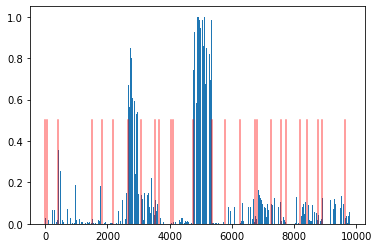

T_ACC =0.02636907249689102
T_BLCA =0.00647300761193037
T_BRCA =0.041688863188028336
T_CESC =0.025127405300736427
T_HBC =0.0036748640704900026
T_COREAD =0.017874035984277725
T_DLBC =0.5464605093002319
T_GESCA =0.10208845138549805
T_GBM =0.1086849495768547
T_HNSC =0.00718985078856349
T_KICH =0.0016706176102161407
T_KC =0.006625608075410128
T_LAML =0.8591567277908325
T_LGG =0.0023786115925759077
T_LUAD =0.018621617928147316
T_LUSC =0.023866591975092888
T_MESO =0.018437255173921585
T_GC =0.12016642838716507
T_PAAD =0.06374913454055786
T_PCPG =0.020290382206439972
T_PRAD =0.02137002721428871
T_SARC =0.04394493252038956
T_SKCM =0.05054395645856857
T_TGCT =0.015167257748544216
T_THCA =0.05917524918913841
T_THYM =0.029204752296209335
7


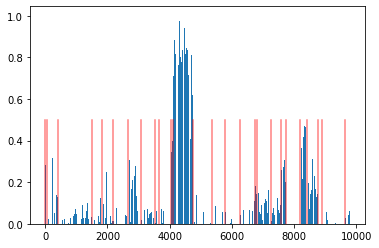

T_ACC =0.174175426363945
T_BLCA =0.032361872494220734
T_BRCA =0.023878134787082672
T_CESC =0.03912855312228203
T_HBC =0.045869968831539154
T_COREAD =0.01931610330939293
T_DLBC =0.14503881335258484
T_GESCA =0.0385560467839241
T_GBM =0.030398892238736153
T_HNSC =0.0117271076887846
T_KICH =0.3168453276157379
T_KC =0.7361400127410889
T_LAML =0.024853622540831566
T_LGG =0.00886095967143774
T_LUAD =0.02055170200765133
T_LUSC =0.014125220477581024
T_MESO =0.22717241942882538
T_GC =0.0975722223520279
T_PAAD =0.06800276786088943
T_PCPG =0.2241394817829132
T_PRAD =0.0022266898304224014
T_SARC =0.3598323464393616
T_SKCM =0.15632326900959015
T_TGCT =0.04391542822122574
T_THCA =0.0054294150322675705
T_THYM =0.026402514427900314
8


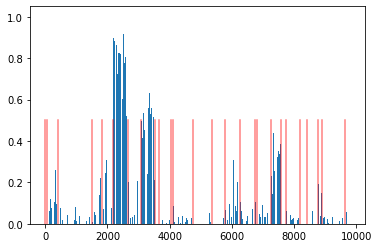

T_ACC =0.007005660329014063
T_BLCA =0.10075244307518005
T_BRCA =0.009202046319842339
T_CESC =0.06902647763490677
T_HBC =0.052716512233018875
T_COREAD =0.8186179995536804
T_DLBC =0.049864672124385834
T_GESCA =0.385081022977829
T_GBM =0.0032273554243147373
T_HNSC =0.014043647795915604
T_KICH =0.006840793415904045
T_KC =0.030445348471403122
T_LAML =0.01330495998263359
T_LGG =0.002580640371888876
T_LUAD =0.06964272260665894
T_LUSC =0.015349564142525196
T_MESO =0.010776570066809654
T_GC =0.032713282853364944
T_PAAD =0.3346537947654724
T_PCPG =0.0009931196691468358
T_PRAD =0.022529326379299164
T_SARC =0.011079498566687107
T_SKCM =0.005909753032028675
T_TGCT =0.1586400866508484
T_THCA =0.006276457570493221
T_THYM =0.004109218250960112
0


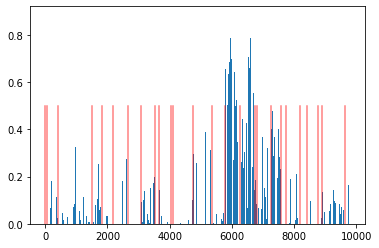

T_ACC =0.020531412214040756
T_BLCA =0.06990452110767365
T_BRCA =0.05431199073791504
T_CESC =0.06833449751138687
T_HBC =0.030062301084399223
T_COREAD =0.014052054844796658
T_DLBC =0.016274167224764824
T_GESCA =0.13178862631320953
T_GBM =0.006712240166962147
T_HNSC =0.024027863517403603
T_KICH =0.00600532628595829
T_KC =0.01915557123720646
T_LAML =0.0746428370475769
T_LGG =0.016280898824334145
T_LUAD =0.5773665904998779
T_LUSC =0.34225544333457947
T_MESO =0.19570067524909973
T_GC =0.12307959049940109
T_PAAD =0.2992071807384491
T_PCPG =0.011105000972747803
T_PRAD =0.04672098904848099
T_SARC =0.01766122505068779
T_SKCM =0.020792348310351372
T_TGCT =0.06531108170747757
T_THCA =0.04634540155529976
T_THYM =0.008447621949017048
1


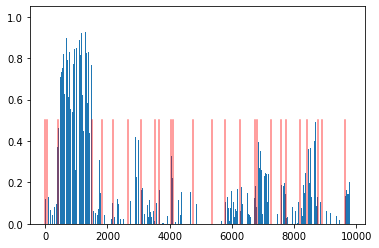

T_ACC =0.05727337300777435
T_BLCA =0.1193988174200058
T_BRCA =0.6952536702156067
T_CESC =0.09931877255439758
T_HBC =0.017813632264733315
T_COREAD =0.01991754025220871
T_DLBC =0.08800989389419556
T_GESCA =0.06825560331344604
T_GBM =0.03167692571878433
T_HNSC =0.034857235848903656
T_KICH =0.25735023617744446
T_KC =0.028651708737015724
T_LAML =0.0007916688919067383
T_LGG =0.0028183262329548597
T_LUAD =0.07829141616821289
T_LUSC =0.05631626769900322
T_MESO =0.12254694104194641
T_GC =0.2667524516582489
T_PAAD =0.018823424354195595
T_PCPG =0.12814348936080933
T_PRAD =0.05319730564951897
T_SARC =0.12354223430156708
T_SKCM =0.2571818232536316
T_TGCT =0.10821771621704102
T_THCA =0.009653453715145588
T_THYM =0.1751946359872818
2


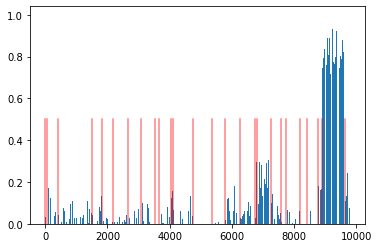

T_ACC =0.08754248172044754
T_BLCA =0.04236841946840286
T_BRCA =0.03682780638337135
T_CESC =0.029669148847460747
T_HBC =0.01471448503434658
T_COREAD =0.011822796426713467
T_DLBC =0.025243928655982018
T_GESCA =0.014290356077253819
T_GBM =0.002181067829951644
T_HNSC =0.015589902177453041
T_KICH =0.21326909959316254
T_KC =0.04838567599654198
T_LAML =0.0030842963606119156
T_LGG =0.021254802122712135
T_LUAD =0.07216273248195648
T_LUSC =0.03138851374387741
T_MESO =0.07279135286808014
T_GC =0.1854594200849533
T_PAAD =0.039344269782304764
T_PCPG =0.012443465180695057
T_PRAD =0.020258858799934387
T_SARC =0.016339614987373352
T_SKCM =0.008906048722565174
T_TGCT =0.12124417722225189
T_THCA =0.8060749769210815
T_THYM =0.20515111088752747
3


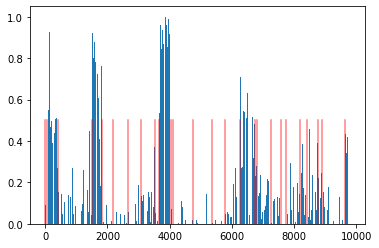

T_ACC =0.08420666307210922
T_BLCA =0.5091288685798645
T_BRCA =0.07601933926343918
T_CESC =0.6189249157905579
T_HBC =0.017616987228393555
T_COREAD =0.026919500902295113
T_DLBC =0.054271601140499115
T_GESCA =0.16618935763835907
T_GBM =0.015428018756210804
T_HNSC =0.8481654524803162
T_KICH =0.023176630958914757
T_KC =0.018159152939915657
T_LAML =0.00755877373740077
T_LGG =0.0037533631548285484
T_LUAD =0.08423206210136414
T_LUSC =0.4505762755870819
T_MESO =0.2652882933616638
T_GC =0.10711102187633514
T_PAAD =0.08506700396537781
T_PCPG =0.0045064520090818405
T_PRAD =0.05515637993812561
T_SARC =0.14456292986869812
T_SKCM =0.14323167502880096
T_TGCT =0.20299027860164642
T_THCA =0.031145047396421432
T_THYM =0.34888389706611633
4


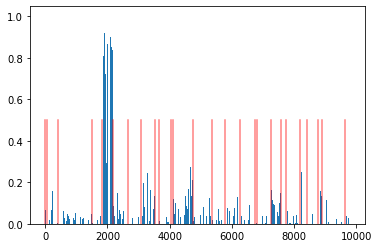

T_ACC =0.23281964659690857
T_BLCA =0.01576601341366768
T_BRCA =0.015507365576922894
T_CESC =0.0075998734682798386
T_HBC =0.7896937131881714
T_COREAD =0.04338332265615463
T_DLBC =0.011425024829804897
T_GESCA =0.06893596053123474
T_GBM =0.010613431222736835
T_HNSC =0.013203728012740612
T_KICH =0.03377101570367813
T_KC =0.07479378581047058
T_LAML =0.023109158501029015
T_LGG =0.01092877984046936
T_LUAD =0.02724958211183548
T_LUSC =0.015728000551462173
T_MESO =0.012649863958358765
T_GC =0.00725228525698185
T_PAAD =0.0818905159831047
T_PCPG =0.009810424409806728
T_PRAD =0.02460414171218872
T_SARC =0.01070798933506012
T_SKCM =0.014636849984526634
T_TGCT =0.08789540827274323
T_THCA =0.005847149528563023
T_THYM =0.018973007798194885
5


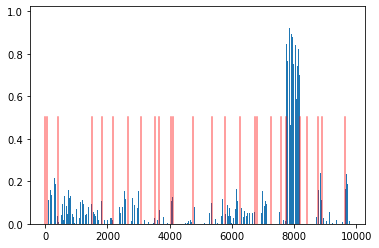

T_ACC =0.021972358226776123
T_BLCA =0.08033280819654465
T_BRCA =0.052598919719457626
T_CESC =0.037391599267721176
T_HBC =0.010916545987129211
T_COREAD =0.029104109853506088
T_DLBC =0.01806231401860714
T_GESCA =0.022807516157627106
T_GBM =0.010608220472931862
T_HNSC =0.014080788940191269
T_KICH =0.09856358170509338
T_KC =0.011641507036983967
T_LAML =0.013402197510004044
T_LGG =0.006452863570302725
T_LUAD =0.04516337439417839
T_LUSC =0.026807770133018494
T_MESO =0.0007138479850254953
T_GC =0.04322429001331329
T_PAAD =0.009495822712779045
T_PCPG =0.027449829503893852
T_PRAD =0.7221651077270508
T_SARC =0.012985289096832275
T_SKCM =0.0024686434771865606
T_TGCT =0.08819195628166199
T_THCA =0.00850736629217863
T_THYM =0.1233089491724968
6


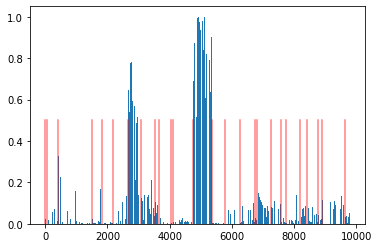

T_ACC =0.022938726469874382
T_BLCA =0.006169384811073542
T_BRCA =0.03296820446848869
T_CESC =0.02289133332669735
T_HBC =0.0033733551390469074
T_COREAD =0.01711123064160347
T_DLBC =0.518109917640686
T_GESCA =0.09436578303575516
T_GBM =0.10091570764780045
T_HNSC =0.007008077576756477
T_KICH =0.0013424239587038755
T_KC =0.006817794404923916
T_LAML =0.8283711671829224
T_LGG =0.0019976659677922726
T_LUAD =0.015214827843010426
T_LUSC =0.020142782479524612
T_MESO =0.013300366699695587
T_GC =0.11072807013988495
T_PAAD =0.05682388320565224
T_PCPG =0.016242558136582375
T_PRAD =0.02776515856385231
T_SARC =0.03601396828889847
T_SKCM =0.04005473479628563
T_TGCT =0.014569040387868881
T_THCA =0.05696435272693634
T_THYM =0.02948799356818199
7


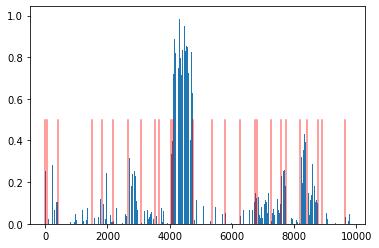

T_ACC =0.15938198566436768
T_BLCA =0.03153140842914581
T_BRCA =0.010427150875329971
T_CESC =0.03579269349575043
T_HBC =0.04564761370420456
T_COREAD =0.01974448561668396
T_DLBC =0.13693535327911377
T_GESCA =0.03557589650154114
T_GBM =0.02291915938258171
T_HNSC =0.011194192804396152
T_KICH =0.3125291168689728
T_KC =0.7399657368659973
T_LAML =0.03065131977200508
T_LGG =0.006629237439483404
T_LUAD =0.017261287197470665
T_LUSC =0.012718587182462215
T_MESO =0.19952671229839325
T_GC =0.08620132505893707
T_PAAD =0.06605011224746704
T_PCPG =0.19983285665512085
T_PRAD =0.008709477260708809
T_SARC =0.32377803325653076
T_SKCM =0.11731800436973572
T_TGCT =0.043240323662757874
T_THCA =0.005433752201497555
T_THYM =0.026232540607452393
8


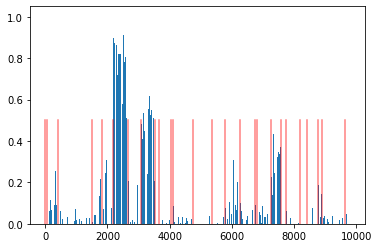

T_ACC =0.006220157723873854
T_BLCA =0.0969490185379982
T_BRCA =0.00923971552401781
T_CESC =0.06652390211820602
T_HBC =0.052027445286512375
T_COREAD =0.8133299350738525
T_DLBC =0.04702815040946007
T_GESCA =0.3812680244445801
T_GBM =0.0035802063066512346
T_HNSC =0.013192571699619293
T_KICH =0.006396861746907234
T_KC =0.028797456994652748
T_LAML =0.011163856834173203
T_LGG =0.0032299875747412443
T_LUAD =0.07207756489515305
T_LUSC =0.015468220226466656
T_MESO =0.010207843966782093
T_GC =0.03392556682229042
T_PAAD =0.331450492143631
T_PCPG =0.0012088147923350334
T_PRAD =0.014347206801176071
T_SARC =0.010368606075644493
T_SKCM =0.0061741662211716175
T_TGCT =0.15785172581672668
T_THCA =0.006670219823718071
T_THYM =0.003936099354177713
9


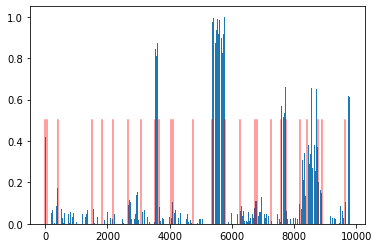

T_ACC =0.3071132302284241
T_BLCA =0.02845076285302639
T_BRCA =0.01684587448835373
T_CESC =0.013553261756896973
T_HBC =0.018133895471692085
T_COREAD =0.00461509870365262
T_DLBC =0.08463964611291885
T_GESCA =0.01652289554476738
T_GBM =0.795365035533905
T_HNSC =0.01868022419512272
T_KICH =0.04759569838643074
T_KC =0.02363167703151703
T_LAML =0.007224674802273512
T_LGG =0.926654040813446
T_LUAD =0.010980532504618168
T_LUSC =0.028598163276910782
T_MESO =0.1072741150856018
T_GC =0.036265987902879715
T_PAAD =0.011847294867038727
T_PCPG =0.5892571210861206
T_PRAD =0.027075307443737984
T_SARC =0.3040400743484497
T_SKCM =0.3892357349395752
T_TGCT =0.11048830300569534
T_THCA =0.023358257487416267
T_THYM =0.06038416922092438
0


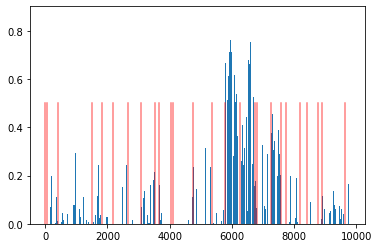

T_ACC =0.012698291800916195
T_BLCA =0.06982005387544632
T_BRCA =0.04910820722579956
T_CESC =0.06076950952410698
T_HBC =0.02854357473552227
T_COREAD =0.01387015264481306
T_DLBC =0.01625361293554306
T_GESCA =0.12976333498954773
T_GBM =0.006438381038606167
T_HNSC =0.027512410655617714
T_KICH =0.005208488553762436
T_KC =0.017849840223789215
T_LAML =0.05695560202002525
T_LGG =0.018120216205716133
T_LUAD =0.5787522196769714
T_LUSC =0.3423282504081726
T_MESO =0.1767435073852539
T_GC =0.08548646420240402
T_PAAD =0.2889651656150818
T_PCPG =0.011119896546006203
T_PRAD =0.04312073439359665
T_SARC =0.017561424523591995
T_SKCM =0.01929772086441517
T_TGCT =0.06204942986369133
T_THCA =0.04074220731854439
T_THYM =0.008509094826877117
1


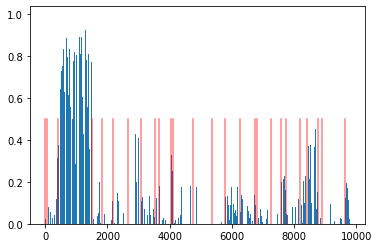

T_ACC =0.024265553802251816
T_BLCA =0.09473751485347748
T_BRCA =0.6835218667984009
T_CESC =0.0712917223572731
T_HBC =0.015730494633316994
T_COREAD =0.023985952138900757
T_DLBC =0.07013968378305435
T_GESCA =0.05598875507712364
T_GBM =0.028658755123615265
T_HNSC =0.03625727444887161
T_KICH =0.26529112458229065
T_KC =0.023163026198744774
T_LAML =0.0010440079495310783
T_LGG =0.0032361026387661695
T_LUAD =0.06637093424797058
T_LUSC =0.052379168570041656
T_MESO =0.056930623948574066
T_GC =0.06272520124912262
T_PAAD =0.010069211944937706
T_PCPG =0.1450144499540329
T_PRAD =0.05770249664783478
T_SARC =0.11090119928121567
T_SKCM =0.26190388202667236
T_TGCT =0.07021665573120117
T_THCA =0.010218545794487
T_THYM =0.1684175729751587
2


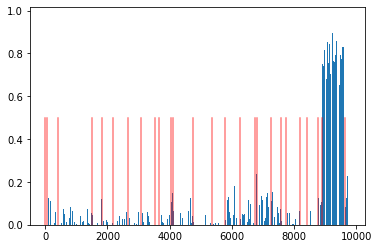

T_ACC =0.05492955446243286
T_BLCA =0.025529960170388222
T_BRCA =0.028164932504296303
T_CESC =0.017396114766597748
T_HBC =0.010603358037769794
T_COREAD =0.012730092741549015
T_DLBC =0.017412059009075165
T_GESCA =0.009988128207623959
T_GBM =0.0005573133239522576
T_HNSC =0.014585253782570362
T_KICH =0.19034843146800995
T_KC =0.0383717305958271
T_LAML =0.008279603905975819
T_LGG =0.021419623866677284
T_LUAD =0.06143985688686371
T_LUSC =0.0295353252440691
T_MESO =0.030326800420880318
T_GC =0.049075257033109665
T_PAAD =0.035777170211076736
T_PCPG =0.012932886369526386
T_PRAD =0.018077954649925232
T_SARC =0.010758810676634312
T_SKCM =0.009190583601593971
T_TGCT =0.07411481440067291
T_THCA =0.7794215083122253
T_THYM =0.17672131955623627
3


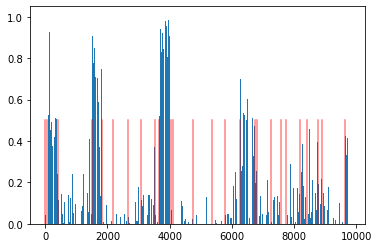

T_ACC =0.05945691093802452
T_BLCA =0.4884468615055084
T_BRCA =0.07132783532142639
T_CESC =0.5950478315353394
T_HBC =0.015662336722016335
T_COREAD =0.027521798387169838
T_DLBC =0.04935362935066223
T_GESCA =0.1573389172554016
T_GBM =0.013909495435655117
T_HNSC =0.8314841985702515
T_KICH =0.02283615991473198
T_KC =0.015677569434046745
T_LAML =0.008902172558009624
T_LGG =0.0037714489735662937
T_LUAD =0.0739210769534111
T_LUSC =0.4394594132900238
T_MESO =0.22529718279838562
T_GC =0.034961238503456116
T_PAAD =0.07745323330163956
T_PCPG =0.0048326184041798115
T_PRAD =0.05063426122069359
T_SARC =0.13551734387874603
T_SKCM =0.14569073915481567
T_TGCT =0.17932084202766418
T_THCA =0.030702007934451103
T_THYM =0.34275710582733154
4


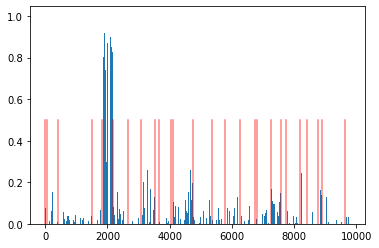

T_ACC =0.2408774048089981
T_BLCA =0.0162142775952816
T_BRCA =0.013517845422029495
T_CESC =0.008858131244778633
T_HBC =0.789872407913208
T_COREAD =0.04344772547483444
T_DLBC =0.010703906416893005
T_GESCA =0.07077791541814804
T_GBM =0.011031514033675194
T_HNSC =0.012242736294865608
T_KICH =0.029014356434345245
T_KC =0.0650535374879837
T_LAML =0.020731033757328987
T_LGG =0.012168357148766518
T_LUAD =0.026658998802304268
T_LUSC =0.014113503508269787
T_MESO =0.018627995625138283
T_GC =0.015160196460783482
T_PAAD =0.08476975560188293
T_PCPG =0.009859797544777393
T_PRAD =0.0234371367841959
T_SARC =0.011349066160619259
T_SKCM =0.015213586390018463
T_TGCT =0.09397689253091812
T_THCA =0.0058916592970490456
T_THYM =0.017777565866708755
5


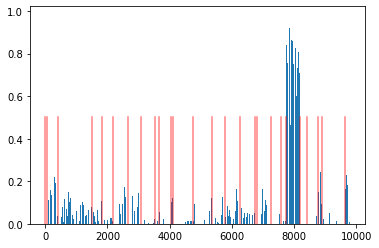

T_ACC =0.017765875905752182
T_BLCA =0.07785824686288834
T_BRCA =0.04457753896713257
T_CESC =0.034874796867370605
T_HBC =0.010259908623993397
T_COREAD =0.031447820365428925
T_DLBC =0.014365822076797485
T_GESCA =0.02130228839814663
T_GBM =0.009272722527384758
T_HNSC =0.01280710007995367
T_KICH =0.09429564327001572
T_KC =0.01173993106931448
T_LAML =0.015854302793741226
T_LGG =0.006950778421014547
T_LUAD =0.04133348539471626
T_LUSC =0.023983797058463097
T_MESO =0.00036991783417761326
T_GC =0.03731401264667511
T_PAAD =0.008943192660808563
T_PCPG =0.02799426205456257
T_PRAD =0.7153170108795166
T_SARC =0.012053989805281162
T_SKCM =0.002661860780790448
T_TGCT =0.08342242985963821
T_THCA =0.007638178765773773
T_THYM =0.12103793025016785
6


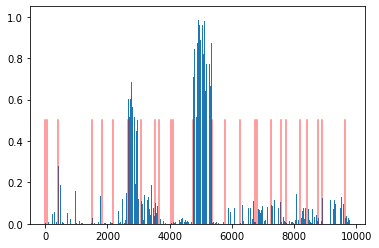

T_ACC =0.010270065627992153
T_BLCA =0.003769988426938653
T_BRCA =0.03061375953257084
T_CESC =0.018982447683811188
T_HBC =0.003234445583075285
T_COREAD =0.01736510545015335
T_DLBC =0.46870437264442444
T_GESCA =0.0873197466135025
T_GBM =0.09613577276468277
T_HNSC =0.007375373039394617
T_KICH =0.0013895841548219323
T_KC =0.006629178766161203
T_LAML =0.8065687417984009
T_LGG =0.002776632783934474
T_LUAD =0.016954783350229263
T_LUSC =0.02124747820198536
T_MESO =0.0036158428993076086
T_GC =0.0654330775141716
T_PAAD =0.057148467749357224
T_PCPG =0.017866777256131172
T_PRAD =0.026132987812161446
T_SARC =0.029799025505781174
T_SKCM =0.039725758135318756
T_TGCT =0.00677240127697587
T_THCA =0.05834116041660309
T_THYM =0.025366755202412605
7


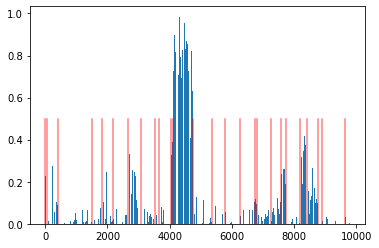

T_ACC =0.14786291122436523
T_BLCA =0.0266592875123024
T_BRCA =0.01050256472080946
T_CESC =0.029138749465346336
T_HBC =0.045339956879615784
T_COREAD =0.020508572459220886
T_DLBC =0.13312508165836334
T_GESCA =0.03271977975964546
T_GBM =0.021965380758047104
T_HNSC =0.01183827593922615
T_KICH =0.3095608353614807
T_KC =0.7363976836204529
T_LAML =0.03729211539030075
T_LGG =0.006567713804543018
T_LUAD =0.016226651147007942
T_LUSC =0.012966539710760117
T_MESO =0.17161470651626587
T_GC =0.043617695569992065
T_PAAD =0.06406308710575104
T_PCPG =0.20561830699443817
T_PRAD =0.007936167530715466
T_SARC =0.3143911361694336
T_SKCM =0.11786151677370071
T_TGCT =0.03598497062921524
T_THCA =0.005980496760457754
T_THYM =0.027207855135202408
8


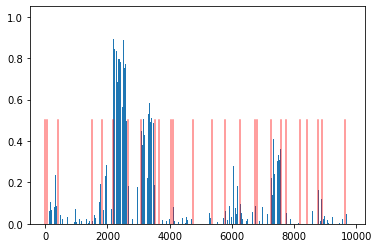

T_ACC =0.0035989952739328146
T_BLCA =0.08568371087312698
T_BRCA =0.00825174804776907
T_CESC =0.059613946825265884
T_HBC =0.04616672545671463
T_COREAD =0.7895065546035767
T_DLBC =0.039305441081523895
T_GESCA =0.3578908145427704
T_GBM =0.0032651161309331656
T_HNSC =0.013063827529549599
T_KICH =0.005319977179169655
T_KC =0.024115798994898796
T_LAML =0.013963308185338974
T_LGG =0.0033888781908899546
T_LUAD =0.060589876025915146
T_LUSC =0.01329002995043993
T_MESO =0.0077398293651640415
T_GC =0.01963747665286064
T_PAAD =0.30964961647987366
T_PCPG =0.0009533345000818372
T_PRAD =0.012054512277245522
T_SARC =0.009166538715362549
T_SKCM =0.005567784421145916
T_TGCT =0.13801568746566772
T_THCA =0.005564333871006966
T_THYM =0.003311748616397381
9


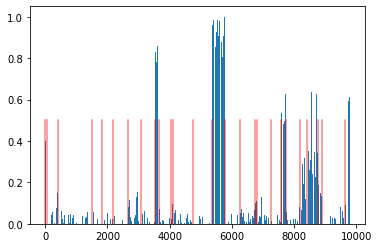

T_ACC =0.28661760687828064
T_BLCA =0.023961132392287254
T_BRCA =0.01350483763962984
T_CESC =0.00979579333215952
T_HBC =0.016532843932509422
T_COREAD =0.003929988946765661
T_DLBC =0.07628443092107773
T_GESCA =0.013793906196951866
T_GBM =0.7751655578613281
T_HNSC =0.014957616105675697
T_KICH =0.04312741011381149
T_KC =0.02294161543250084
T_LAML =0.008354428224265575
T_LGG =0.916553795337677
T_LUAD =0.009153318591415882
T_LUSC =0.023767247796058655
T_MESO =0.0957069993019104
T_GC =0.02813222073018551
T_PAAD =0.009909898974001408
T_PCPG =0.5580178499221802
T_PRAD =0.022661801427602768
T_SARC =0.2827828824520111
T_SKCM =0.3603893518447876
T_TGCT =0.09862206876277924
T_THCA =0.02296924777328968
T_THYM =0.05387603119015694
10


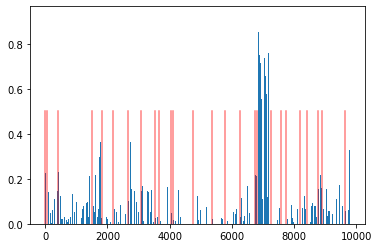

T_ACC =0.141656756401062
T_BLCA =0.08731891959905624
T_BRCA =0.04690883308649063
T_CESC =0.09423096477985382
T_HBC =0.018053963780403137
T_COREAD =0.01568620651960373
T_DLBC =0.1043519675731659
T_GESCA =0.06311642378568649
T_GBM =0.033599983900785446
T_HNSC =0.017875926569104195
T_KICH =0.03360794112086296
T_KC =0.0380600243806839
T_LAML =0.02205468900501728
T_LGG =0.005046404432505369
T_LUAD =0.048598822206258774
T_LUSC =0.026929276064038277
T_MESO =0.21302656829357147
T_GC =0.5584571361541748
T_PAAD =0.05325118824839592
T_PCPG =0.005789872258901596
T_PRAD =0.022924957796931267
T_SARC =0.06571857631206512
T_SKCM =0.022497229278087616
T_TGCT =0.15750379860401154
T_THCA =0.032530661672353745
T_THYM =0.055017001926898956
0


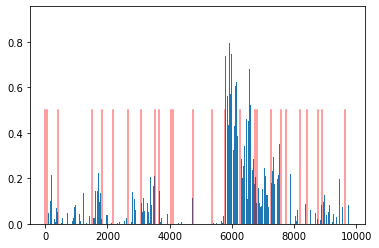

T_ACC =0.02139386534690857
T_BLCA =0.09943564236164093
T_BRCA =0.02166380174458027
T_CESC =0.0714149922132492
T_HBC =0.03428956866264343
T_COREAD =0.015814658254384995
T_DLBC =0.02965553291141987
T_GESCA =0.13327321410179138
T_GBM =0.01045609638094902
T_HNSC =0.026582757011055946
T_KICH =0.008154348470270634
T_KC =0.020994942635297775
T_LAML =6.357911479426548e-05
T_LGG =0.013600875623524189
T_LUAD =0.5819029211997986
T_LUSC =0.31006836891174316
T_MESO =0.21258212625980377
T_GC =0.150346577167511
T_PAAD =0.23161925375461578
T_PCPG =0.005272055510431528
T_PRAD =0.03891459107398987
T_SARC =0.02017248049378395
T_SKCM =0.015899766236543655
T_TGCT =0.09568776935338974
T_THCA =0.03533099591732025
T_THYM =0.011200902983546257
1


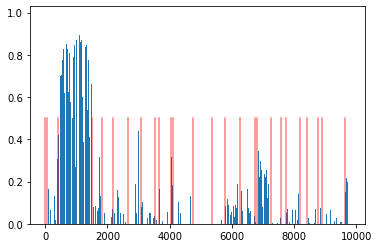

T_ACC =0.001003333949483931
T_BLCA =0.12007753551006317
T_BRCA =0.6774106025695801
T_CESC =0.09131466597318649
T_HBC =0.01826905831694603
T_COREAD =0.02656494453549385
T_DLBC =0.015573074109852314
T_GESCA =0.04020068049430847
T_GBM =0.012709817849099636
T_HNSC =0.034365665167570114
T_KICH =0.2643134593963623
T_KC =0.02834436111152172
T_LAML =0.00020413855963852257
T_LGG =0.005069592036306858
T_LUAD =0.06484322994947433
T_LUSC =0.04272564873099327
T_MESO =0.012494049035012722
T_GC =0.23162882030010223
T_PAAD =0.01369315292686224
T_PCPG =0.005537548568099737
T_PRAD =0.06585729122161865
T_SARC =0.012595666572451591
T_SKCM =0.02222795970737934
T_TGCT =0.08293610066175461
T_THCA =0.009942111559212208
T_THYM =0.19728901982307434
2


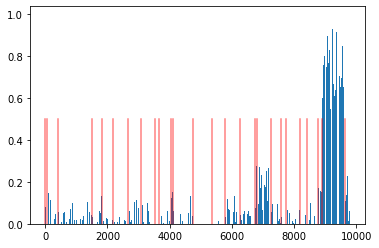

T_ACC =0.0923839583992958
T_BLCA =0.037668608129024506
T_BRCA =0.031462471932172775
T_CESC =0.02234767936170101
T_HBC =0.014540046453475952
T_COREAD =0.01071090903133154
T_DLBC =0.04422858729958534
T_GESCA =0.010816534981131554
T_GBM =0.0022342624142766
T_HNSC =0.01296764612197876
T_KICH =0.19547347724437714
T_KC =0.0426388643682003
T_LAML =0.00041382634663023055
T_LGG =0.01860673539340496
T_LUAD =0.06400448083877563
T_LUSC =0.024123305454850197
T_MESO =0.08964020013809204
T_GC =0.16135546565055847
T_PAAD =0.027215739712119102
T_PCPG =0.014308717101812363
T_PRAD =0.018473677337169647
T_SARC =0.024563418701291084
T_SKCM =0.015370339155197144
T_TGCT =0.1199566125869751
T_THCA =0.7308688163757324
T_THYM =0.19366557896137238
3


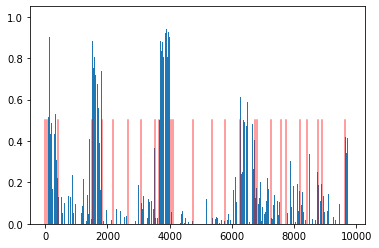

T_ACC =0.02927234210073948
T_BLCA =0.4674299955368042
T_BRCA =0.0691821500658989
T_CESC =0.5708218812942505
T_HBC =0.015255602076649666
T_COREAD =0.029065798968076706
T_DLBC =0.025965599343180656
T_GESCA =0.1399216204881668
T_GBM =0.009103847667574883
T_HNSC =0.7990028262138367
T_KICH =0.017407629638910294
T_KC =0.015251091681420803
T_LAML =0.005386296659708023
T_LGG =0.008258086629211903
T_LUAD =0.05762578547000885
T_LUSC =0.40724945068359375
T_MESO =0.1463201940059662
T_GC =0.08118622750043869
T_PAAD =0.07552081346511841
T_PCPG =0.0
T_PRAD =0.05833646282553673
T_SARC =0.04745594784617424
T_SKCM =0.07934229075908661
T_TGCT =0.17054449021816254
T_THCA =0.02522045373916626
T_THYM =0.3351595103740692
4


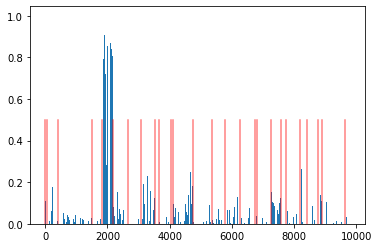

T_ACC =0.22163186967372894
T_BLCA =0.013545357622206211
T_BRCA =0.013704448938369751
T_CESC =0.006625317502766848
T_HBC =0.7738769054412842
T_COREAD =0.04261681064963341
T_DLBC =0.01190077606588602
T_GESCA =0.06549806892871857
T_GBM =0.009285535663366318
T_HNSC =0.01140406634658575
T_KICH =0.025016244500875473
T_KC =0.05680689215660095
T_LAML =0.010019583627581596
T_LGG =0.010464259423315525
T_LUAD =0.025326697155833244
T_LUSC =0.013268603011965752
T_MESO =0.02244172804057598
T_GC =0.005054142791777849
T_PAAD =0.0801316574215889
T_PCPG =0.013186338357627392
T_PRAD =0.02182350866496563
T_SARC =0.021352829411625862
T_SKCM =0.017403341829776764
T_TGCT =0.07894841581583023
T_THCA =0.004264834336936474
T_THYM =0.014718089252710342
5


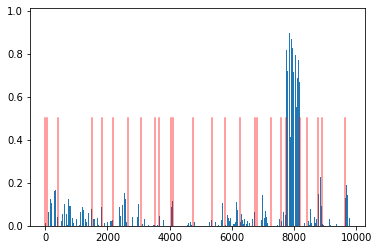

T_ACC =0.023981742560863495
T_BLCA =0.0575878769159317
T_BRCA =0.03559057042002678
T_CESC =0.0278780534863472
T_HBC =0.009790578857064247
T_COREAD =0.030170049518346786
T_DLBC =0.010905707255005836
T_GESCA =0.020247969776391983
T_GBM =0.007344080600887537
T_HNSC =0.009579603560268879
T_KICH =0.08051940053701401
T_KC =0.009077700786292553
T_LAML =0.003971757832914591
T_LGG =0.004831352736800909
T_LUAD =0.021964596584439278
T_LUSC =0.01676669903099537
T_MESO =0.0011648557847365737
T_GC =0.02928994409739971
T_PAAD =0.008288810029625893
T_PCPG =0.0396912544965744
T_PRAD =0.6777238249778748
T_SARC =0.016427047550678253
T_SKCM =0.012471024878323078
T_TGCT =0.07981862872838974
T_THCA =0.005724533926695585
T_THYM =0.09293566644191742
6


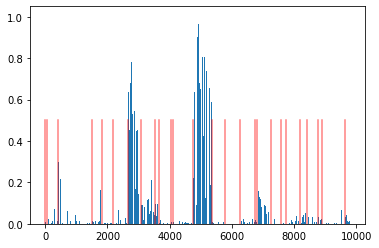

T_ACC =0.010797507129609585
T_BLCA =0.006331435404717922
T_BRCA =0.015431554988026619
T_CESC =0.01193570252507925
T_HBC =0.002980499994009733
T_COREAD =0.01598377153277397
T_DLBC =0.4657861292362213
T_GESCA =0.07502640783786774
T_GBM =0.09083114564418793
T_HNSC =0.004579904489219189
T_KICH =0.00034535385202616453
T_KC =0.0038832565769553185
T_LAML =0.5617401003837585
T_LGG =0.002291199052706361
T_LUAD =0.003808201989158988
T_LUSC =0.005264212843030691
T_MESO =0.00779920257627964
T_GC =0.093413345515728
T_PAAD =0.023422615602612495
T_PCPG =0.00266770226880908
T_PRAD =0.011091451160609722
T_SARC =0.014510327950119972
T_SKCM =0.009395461529493332
T_TGCT =0.014927967451512814
T_THCA =0.016301017254590988
T_THYM =0.031067589297890663
7


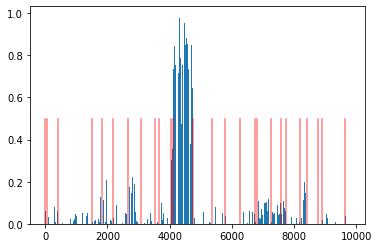

T_ACC =0.04017915576696396
T_BLCA =0.022053739055991173
T_BRCA =0.007733624428510666
T_CESC =0.02656804583966732
T_HBC =0.044132787734270096
T_COREAD =0.022251343354582787
T_DLBC =0.05275575444102287
T_GESCA =0.017357949167490005
T_GBM =0.011514442041516304
T_HNSC =0.00840279832482338
T_KICH =0.2944924533367157
T_KC =0.7255990505218506
T_LAML =0.023401670157909393
T_LGG =0.011493854224681854
T_LUAD =0.012763853184878826
T_LUSC =0.006678527686744928
T_MESO =0.059277381747961044
T_GC =0.06720171868801117
T_PAAD =0.05476193502545357
T_PCPG =0.06325145810842514
T_PRAD =0.00817667692899704
T_SARC =0.12051161378622055
T_SKCM =0.003361266339197755
T_TGCT =0.032072219997644424
T_THCA =0.005170777440071106
T_THYM =0.026699520647525787
8


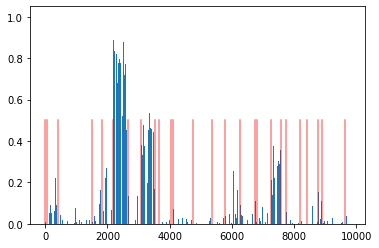

T_ACC =0.004117780830711126
T_BLCA =0.07568317651748657
T_BRCA =0.007683809846639633
T_CESC =0.05453763157129288
T_HBC =0.04471887648105621
T_COREAD =0.772152304649353
T_DLBC =0.03314218297600746
T_GESCA =0.3247684836387634
T_GBM =0.002063244581222534
T_HNSC =0.010986446402966976
T_KICH =0.0040998007170856
T_KC =0.021115753799676895
T_LAML =0.0058317771181464195
T_LGG =0.0038928138092160225
T_LUAD =0.04546395316720009
T_LUSC =0.01014681439846754
T_MESO =0.014721041545271873
T_GC =0.022311387583613396
T_PAAD =0.28779950737953186
T_PCPG =0.0013523426605388522
T_PRAD =0.01222810335457325
T_SARC =0.015993984416127205
T_SKCM =0.008069547824561596
T_TGCT =0.13130563497543335
T_THCA =0.0029425714164972305
T_THYM =0.0032746370416134596
9


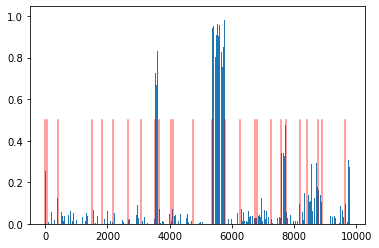

T_ACC =0.17648521065711975
T_BLCA =0.020206710323691368
T_BRCA =0.011981204152107239
T_CESC =0.009663843549787998
T_HBC =0.016257835552096367
T_COREAD =0.004840969108045101
T_DLBC =0.02174459397792816
T_GESCA =0.008534999564290047
T_GBM =0.7009947299957275
T_HNSC =0.01333317905664444
T_KICH =0.038016870617866516
T_KC =0.020342839881777763
T_LAML =0.0041610198095440865
T_LGG =0.8895998001098633
T_LUAD =0.012737000361084938
T_LUSC =0.02250240184366703
T_MESO =0.025793423876166344
T_GC =0.029919158667325974
T_PAAD =0.01058050524443388
T_PCPG =0.4010733366012573
T_PRAD =0.024569425731897354
T_SARC =0.1379212737083435
T_SKCM =0.14321057498455048
T_TGCT =0.08095253258943558
T_THCA =0.024414222687482834
T_THYM =0.060255177319049835
10


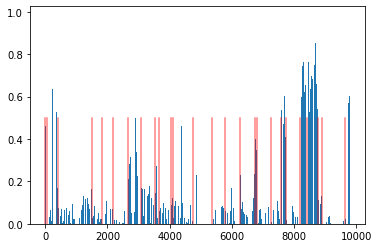

T_ACC =0.3754153549671173
T_BLCA =0.07629689574241638
T_BRCA =0.05770879238843918
T_CESC =0.07270625978708267
T_HBC =0.022414563223719597
T_COREAD =0.018348051235079765
T_DLBC =0.2737044095993042
T_GESCA =0.09617572277784348
T_GBM =0.13625437021255493
T_HNSC =0.06160550191998482
T_KICH =0.06429609656333923
T_KC =0.04424641281366348
T_LAML =0.005677214358001947
T_LGG =0.023454243317246437
T_LUAD =0.03614165261387825
T_LUSC =0.06854613125324249
T_MESO =0.3955114483833313
T_GC =0.05910559743642807
T_PAAD =0.04735768586397171
T_PCPG =0.4390523135662079
T_PRAD =0.016011932864785194
T_SARC =0.5605495572090149
T_SKCM =0.6526054739952087
T_TGCT =0.1095871776342392
T_THCA =0.0057835811749100685
T_THYM =0.03239871561527252
11


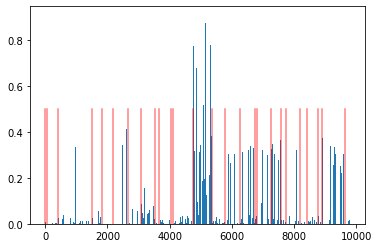

T_ACC =0.003337842645123601
T_BLCA =0.003682973561808467
T_BRCA =0.05044691264629364
T_CESC =0.034185945987701416
T_HBC =0.003473704680800438
T_COREAD =0.011480425484478474
T_DLBC =0.014637644402682781
T_GESCA =0.06817838549613953
T_GBM =0.007208461873233318
T_HNSC =0.007189611438661814
T_KICH =0.007864863611757755
T_KC =0.011698875576257706
T_LAML =0.3791290521621704
T_LGG =0.00843716412782669
T_LUAD =0.07341769337654114
T_LUSC =0.07265982776880264
T_MESO =0.012254386208951473
T_GC =0.06918761879205704
T_PAAD =0.13960833847522736
T_PCPG =0.01460694894194603
T_PRAD =0.04679305851459503
T_SARC =0.00794585794210434
T_SKCM =0.02064293436706066
T_TGCT =0.003262441838160157
T_THCA =0.134036123752594
T_THYM =0.0013355740811675787
0


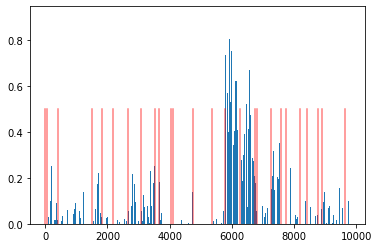

T_ACC =0.009351173415780067
T_BLCA =0.09423763304948807
T_BRCA =0.021431414410471916
T_CESC =0.05488397926092148
T_HBC =0.03195483982563019
T_COREAD =0.014801998622715473
T_DLBC =0.043645214289426804
T_GESCA =0.13093015551567078
T_GBM =0.011743969283998013
T_HNSC =0.03243847191333771
T_KICH =0.00602757977321744
T_KC =0.017562689259648323
T_LAML =0.0005383328534662724
T_LGG =0.01687041111290455
T_LUAD =0.5737123489379883
T_LUSC =0.3265046179294586
T_MESO =0.1799115687608719
T_GC =0.03241060674190521
T_PAAD =0.2146521657705307
T_PCPG =0.007086386904120445
T_PRAD =0.03791404515504837
T_SARC =0.022530298680067062
T_SKCM =0.017215002328157425
T_TGCT =0.08243405073881149
T_THCA =0.03671225905418396
T_THYM =0.01036535669118166
1


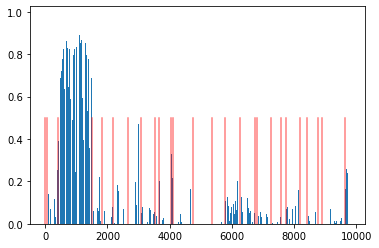

T_ACC =0.0
T_BLCA =0.10908298939466476
T_BRCA =0.6674850583076477
T_CESC =0.06849987804889679
T_HBC =0.01666106842458248
T_COREAD =0.03143578767776489
T_DLBC =0.021156437695026398
T_GESCA =0.03925682231783867
T_GBM =0.013855448924005032
T_HNSC =0.03997083753347397
T_KICH =0.27579668164253235
T_KC =0.023027170449495316
T_LAML =0.001233377493917942
T_LGG =0.005072005558758974
T_LUAD =0.06384643167257309
T_LUSC =0.044574037194252014
T_MESO =0.0050882818177342415
T_GC =0.04516783356666565
T_PAAD =0.009037487208843231
T_PCPG =0.007578438147902489
T_PRAD =0.06838206201791763
T_SARC =0.011416471563279629
T_SKCM =0.024540269747376442
T_TGCT =0.057736560702323914
T_THCA =0.010446100495755672
T_THYM =0.20781148970127106
2


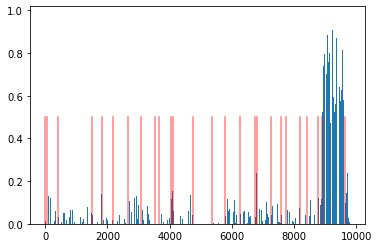

T_ACC =0.0697222501039505
T_BLCA =0.026088494807481766
T_BRCA =0.024626169353723526
T_CESC =0.011355917900800705
T_HBC =0.011500969529151917
T_COREAD =0.01105748862028122
T_DLBC =0.06267361342906952
T_GESCA =0.008262695744633675
T_GBM =0.0017706863582134247
T_HNSC =0.013547105714678764
T_KICH =0.18538621068000793
T_KC =0.034915998578071594
T_LAML =0.00203994894400239
T_LGG =0.01737217791378498
T_LUAD =0.055865827947854996
T_LUSC =0.02171972207725048
T_MESO =0.05157318338751793
T_GC =0.026901820674538612
T_PAAD =0.018395794555544853
T_PCPG =0.01655844785273075
T_PRAD =0.016320189461112022
T_SARC =0.020340409129858017
T_SKCM =0.019719084724783897
T_TGCT =0.079779714345932
T_THCA =0.6840428113937378
T_THYM =0.18558232486248016
3


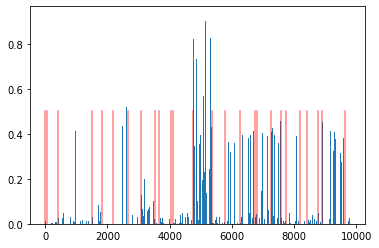

T_ACC =0.005098884925246239
T_BLCA =0.005238634999841452
T_BRCA =0.059061434119939804
T_CESC =0.04713300243020058
T_HBC =0.0044227777980268
T_COREAD =0.015259644947946072
T_DLBC =0.010952549055218697
T_GESCA =0.09201189875602722
T_GBM =0.008363867178559303
T_HNSC =0.009719782508909702
T_KICH =0.009068800136446953
T_KC =0.015149890445172787
T_LAML =0.41390061378479004
T_LGG =0.010420871898531914
T_LUAD =0.08757555484771729
T_LUSC =0.08899188786745071
T_MESO =0.016482122242450714
T_GC =0.09804978221654892
T_PAAD =0.17737022042274475
T_PCPG =0.019971048459410667
T_PRAD =0.056784287095069885
T_SARC =0.010017689317464828
T_SKCM =0.02563113160431385
T_TGCT =0.004064042121171951
T_THCA =0.16562725603580475
T_THYM =0.0011940046679228544
4


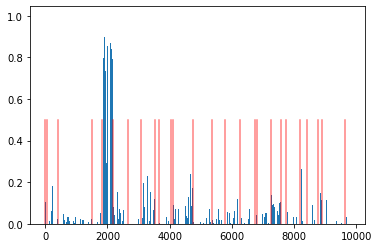

T_ACC =0.22000718116760254
T_BLCA =0.014649655669927597
T_BRCA =0.011267171241343021
T_CESC =0.008420095779001713
T_HBC =0.7727076411247253
T_COREAD =0.04273125156760216
T_DLBC =0.010582532733678818
T_GESCA =0.06371305882930756
T_GBM =0.00925302505493164
T_HNSC =0.011751209385693073
T_KICH =0.021244926378130913
T_KC =0.051693469285964966
T_LAML =0.00934103038161993
T_LGG =0.0100875124335289
T_LUAD =0.02249826118350029
T_LUSC =0.012149475514888763
T_MESO =0.027143411338329315
T_GC =0.014354454353451729
T_PAAD =0.07828860729932785
T_PCPG =0.012423111125826836
T_PRAD =0.02021961100399494
T_SARC =0.02129279635846615
T_SKCM =0.0177704319357872
T_TGCT =0.08442551642656326
T_THCA =0.003666160861030221
T_THYM =0.013986964710056782
5


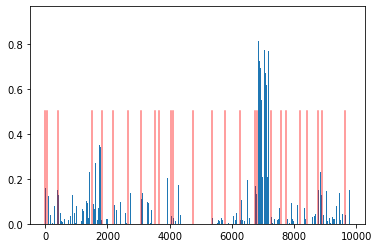

T_ACC =0.08561739325523376
T_BLCA =0.08449186384677887
T_BRCA =0.04127917066216469
T_CESC =0.10363028943538666
T_HBC =0.01860828883945942
T_COREAD =0.015530194155871868
T_DLBC =0.011315817944705486
T_GESCA =0.04242020845413208
T_GBM =0.015957046300172806
T_HNSC =0.017996836453676224
T_KICH =0.03652426600456238
T_KC =0.04370848089456558
T_LAML =0.0017489716410636902
T_LGG =0.00781549233943224
T_LUAD =0.03023647889494896
T_LUSC =0.022147752344608307
T_MESO =0.15445631742477417
T_GC =0.5625920295715332
T_PAAD =0.054073262959718704
T_PCPG =0.002789496211335063
T_PRAD =0.02733524516224861
T_SARC =0.042444922029972076
T_SKCM =0.00930656585842371
T_TGCT =0.15271489322185516
T_THCA =0.02170293591916561
T_THYM =0.04526862874627113
6


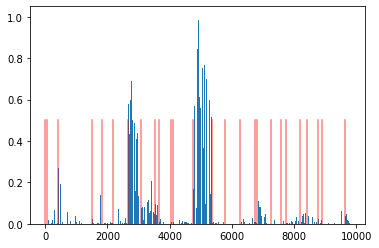

T_ACC =0.006391191389411688
T_BLCA =0.004176348447799683
T_BRCA =0.01390168908983469
T_CESC =0.008710294030606747
T_HBC =0.003025041427463293
T_COREAD =0.016308650374412537
T_DLBC =0.43400657176971436
T_GESCA =0.07213856279850006
T_GBM =0.08687367290258408
T_HNSC =0.005680645350366831
T_KICH =0.0005527374451048672
T_KC =0.004104087594896555
T_LAML =0.5076234936714172
T_LGG =0.002719115698710084
T_LUAD =0.00348234036937356
T_LUSC =0.005875812377780676
T_MESO =0.0027752320747822523
T_GC =0.05589567497372627
T_PAAD =0.021373359486460686
T_PCPG =0.003962540999054909
T_PRAD =0.010421798564493656
T_SARC =0.013900675810873508
T_SKCM =0.010872647166252136
T_TGCT =0.009246330708265305
T_THCA =0.014757927507162094
T_THYM =0.03206072002649307
7


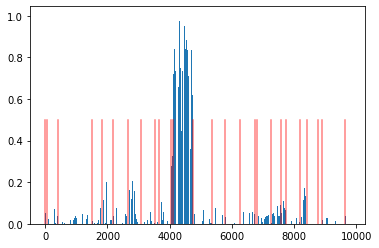

T_ACC =0.036975886672735214
T_BLCA =0.0178134236484766
T_BRCA =0.0072937929071486
T_CESC =0.020284898579120636
T_HBC =0.04116850718855858
T_COREAD =0.02269401028752327
T_DLBC =0.049929793924093246
T_GESCA =0.015968024730682373
T_GBM =0.010542850941419601
T_HNSC =0.00916422251611948
T_KICH =0.27261286973953247
T_KC =0.7027432918548584
T_LAML =0.0278285164386034
T_LGG =0.009969230741262436
T_LUAD =0.010634391568601131
T_LUSC =0.006390908267349005
T_MESO =0.04694399610161781
T_GC =0.027651222422719002
T_PAAD =0.04612555727362633
T_PCPG =0.06356152147054672
T_PRAD =0.006841279100626707
T_SARC =0.11014264822006226
T_SKCM =0.003345134435221553
T_TGCT =0.0254079420119524
T_THCA =0.005273889750242233
T_THYM =0.026686541736125946
8


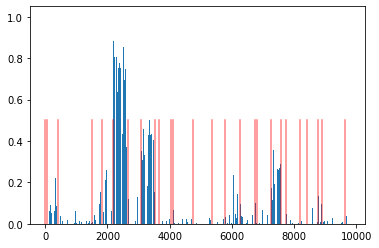

T_ACC =0.003263111226260662
T_BLCA =0.07304979115724564
T_BRCA =0.006307733710855246
T_CESC =0.05264386907219887
T_HBC =0.04098111018538475
T_COREAD =0.7507483959197998
T_DLBC =0.03229506313800812
T_GESCA =0.2987285256385803
T_GBM =0.0021235852036625147
T_HNSC =0.011333619244396687
T_KICH =0.0034594060853123665
T_KC =0.019064057618379593
T_LAML =0.00738742807880044
T_LGG =0.003303012577816844
T_LUAD =0.04212016239762306
T_LUSC =0.009901275858283043
T_MESO =0.012424562126398087
T_GC =0.017206775024533272
T_PAAD =0.2602795958518982
T_PCPG =0.0012272465974092484
T_PRAD =0.010333978570997715
T_SARC =0.0143252769485116
T_SKCM =0.007917984388768673
T_TGCT =0.11761600524187088
T_THCA =0.0027650753036141396
T_THYM =0.002953584771603346
9


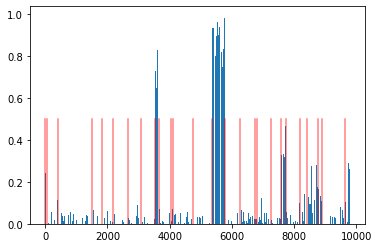

T_ACC =0.17266838252544403
T_BLCA =0.019149746745824814
T_BRCA =0.010695740580558777
T_CESC =0.007925285957753658
T_HBC =0.01599898748099804
T_COREAD =0.004815181717276573
T_DLBC =0.021384811028838158
T_GESCA =0.008150650188326836
T_GBM =0.6892499923706055
T_HNSC =0.01361491996794939
T_KICH =0.03733476623892784
T_KC =0.02231796458363533
T_LAML =0.007902972400188446
T_LGG =0.8805637955665588
T_LUAD =0.009623739868402481
T_LUSC =0.019746311008930206
T_MESO =0.02129526250064373
T_GC =0.021883057430386543
T_PAAD =0.009501136839389801
T_PCPG =0.39037826657295227
T_PRAD =0.022840440273284912
T_SARC =0.1320892870426178
T_SKCM =0.1307746320962906
T_TGCT =0.07823772728443146
T_THCA =0.02274966798722744
T_THYM =0.060923729091882706
10


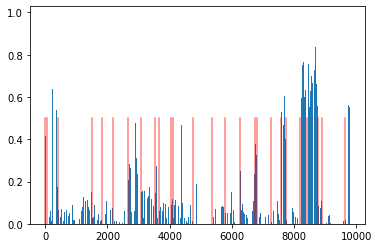

T_ACC =0.35385164618492126
T_BLCA =0.07558182626962662
T_BRCA =0.05187445133924484
T_CESC =0.07131319493055344
T_HBC =0.021456394344568253
T_COREAD =0.017858171835541725
T_DLBC =0.26722556352615356
T_GESCA =0.08948010951280594
T_GBM =0.13485877215862274
T_HNSC =0.06561644375324249
T_KICH =0.06126959249377251
T_KC =0.044797077775001526
T_LAML =0.006428745109587908
T_LGG =0.024532975628972054
T_LUAD =0.03202804550528526
T_LUSC =0.06854771077632904
T_MESO =0.3727472722530365
T_GC =0.0441531166434288
T_PAAD =0.042069386690855026
T_PCPG =0.43417835235595703
T_PRAD =0.01495854090899229
T_SARC =0.5494562983512878
T_SKCM =0.649881899356842
T_TGCT =0.09978346526622772
T_THCA =0.005925216246396303
T_THYM =0.03170859068632126
11


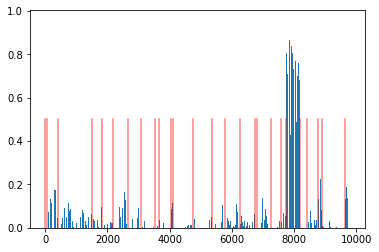

T_ACC =0.017389396205544472
T_BLCA =0.05953270196914673
T_BRCA =0.029643520712852478
T_CESC =0.028539150953292847
T_HBC =0.009336354210972786
T_COREAD =0.031444571912288666
T_DLBC =0.010350578464567661
T_GESCA =0.018809078261256218
T_GBM =0.007176508661359549
T_HNSC =0.009276005439460278
T_KICH =0.07597185671329498
T_KC =0.009162157773971558
T_LAML =0.00716052483767271
T_LGG =0.004903562366962433
T_LUAD =0.020316923037171364
T_LUSC =0.01605929620563984
T_MESO =0.0006046661292202771
T_GC =0.028918776661157608
T_PAAD =0.00815342366695404
T_PCPG =0.0402555987238884
T_PRAD =0.6603589057922363
T_SARC =0.014771736226975918
T_SKCM =0.012220475822687149
T_TGCT =0.07422914355993271
T_THCA =0.004870755132287741
T_THYM =0.09070992469787598
12


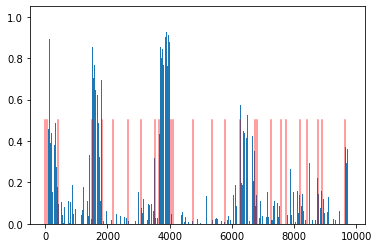

T_ACC =0.019663522019982338
T_BLCA =0.41690686345100403
T_BRCA =0.055132683366537094
T_CESC =0.5166601538658142
T_HBC =0.012178033590316772
T_COREAD =0.02531464584171772
T_DLBC =0.024481430649757385
T_GESCA =0.12013021856546402
T_GBM =0.008230629377067089
T_HNSC =0.7598899006843567
T_KICH =0.01475024688988924
T_KC =0.011753709055483341
T_LAML =0.006866041570901871
T_LGG =0.006369815673679113
T_LUAD =0.048059482127428055
T_LUSC =0.35739120841026306
T_MESO =0.10855421423912048
T_GC =0.02481485903263092
T_PAAD =0.060680001974105835
T_PCPG =2.9562685085693374e-05
T_PRAD =0.04728962108492851
T_SARC =0.03727150708436966
T_SKCM =0.07080475240945816
T_TGCT =0.13432461023330688
T_THCA =0.02145995944738388
T_THYM =0.29074814915657043
0


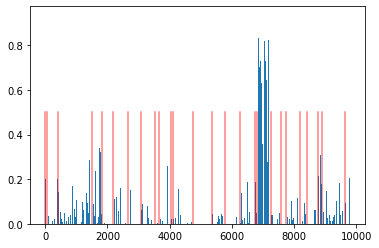

T_ACC =0.10403276234865189
T_BLCA =0.055142469704151154
T_BRCA =0.04988472908735275
T_CESC =0.08694206178188324
T_HBC =0.019020922482013702
T_COREAD =0.02216062881052494
T_DLBC =0.014343428425490856
T_GESCA =0.023664189502596855
T_GBM =0.02285177633166313
T_HNSC =0.025101331993937492
T_KICH =0.0338376984000206
T_KC =0.04048192873597145
T_LAML =0.002131278859451413
T_LGG =0.012180282734334469
T_LUAD =0.031884633004665375
T_LUSC =0.02928614243865013
T_MESO =0.16075316071510315
T_GC =0.6081437468528748
T_PAAD =0.04180414229631424
T_PCPG =0.0040722317062318325
T_PRAD =0.03511415049433708
T_SARC =0.05365623161196709
T_SKCM =0.013881743885576725
T_TGCT =0.2071043998003006
T_THCA =0.029135938733816147
T_THYM =0.0699286237359047
1


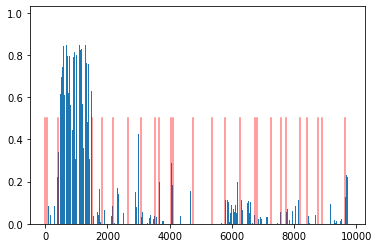

T_ACC =0.0
T_BLCA =0.07766447216272354
T_BRCA =0.6509028673171997
T_CESC =0.05133507400751114
T_HBC =0.01549905352294445
T_COREAD =0.027697477489709854
T_DLBC =0.017152758315205574
T_GESCA =0.028079433366656303
T_GBM =0.012526920065283775
T_HNSC =0.03311055898666382
T_KICH =0.2389960139989853
T_KC =0.019311822950839996
T_LAML =0.000923569081351161
T_LGG =0.004581628832966089
T_LUAD =0.058966245502233505
T_LUSC =0.04031429812312126
T_MESO =0.003722298424690962
T_GC =0.03768116980791092
T_PAAD =0.007156171835958958
T_PCPG =0.007639722898602486
T_PRAD =0.06532532721757889
T_SARC =0.009878918528556824
T_SKCM =0.02099018543958664
T_TGCT =0.04504887014627457
T_THCA =0.010149087756872177
T_THYM =0.18286354839801788
2


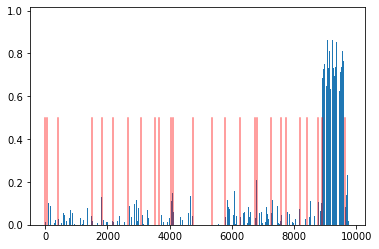

T_ACC =0.06586477160453796
T_BLCA =0.01995064690709114
T_BRCA =0.023550016805529594
T_CESC =0.00997300073504448
T_HBC =0.010632569901645184
T_COREAD =0.010047314688563347
T_DLBC =0.05144447833299637
T_GESCA =0.0059963311068713665
T_GBM =0.0014047621516510844
T_HNSC =0.013043808750808239
T_KICH =0.17458009719848633
T_KC =0.03202299401164055
T_LAML =0.0015419163974002004
T_LGG =0.01720251515507698
T_LUAD =0.06136130914092064
T_LUSC =0.023650653660297394
T_MESO =0.04971931129693985
T_GC =0.02170456200838089
T_PAAD =0.017578331753611565
T_PCPG =0.017375769093632698
T_PRAD =0.01594383828341961
T_SARC =0.019066479057073593
T_SKCM =0.01984982192516327
T_TGCT =0.06465372443199158
T_THCA =0.744268536567688
T_THYM =0.17440563440322876
3


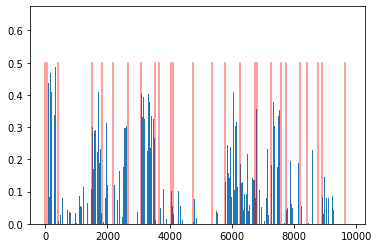

T_ACC =0.027505114674568176
T_BLCA =0.31947681307792664
T_BRCA =0.036566928029060364
T_CESC =0.2545804977416992
T_HBC =0.04560066759586334
T_COREAD =0.11366758495569229
T_DLBC =0.016943160444498062
T_GESCA =0.30566874146461487
T_GBM =0.004737667739391327
T_HNSC =0.08903805911540985
T_KICH =0.08674145489931107
T_KC =0.04704324156045914
T_LAML =0.009434382431209087
T_LGG =0.005123964045196772
T_LUAD =0.18525782227516174
T_LUSC =0.10805027931928635
T_MESO =0.10009682923555374
T_GC =0.059431783854961395
T_PAAD =0.28108224272727966
T_PCPG =0.0016688700998201966
T_PRAD =0.030490383505821228
T_SARC =0.018157975748181343
T_SKCM =0.005039708223193884
T_TGCT =0.0035413848236203194
T_THCA =0.018327321857213974
T_THYM =0.020052088424563408
4


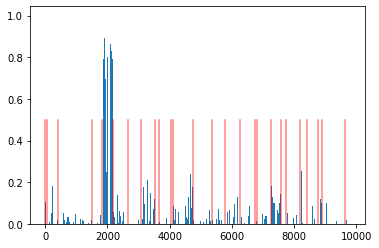

T_ACC =0.2099081575870514
T_BLCA =0.012181950733065605
T_BRCA =0.010969174094498158
T_CESC =0.007158512249588966
T_HBC =0.7598404288291931
T_COREAD =0.03582753613591194
T_DLBC =0.009429567493498325
T_GESCA =0.06540547311306
T_GBM =0.008867054246366024
T_HNSC =0.010775642469525337
T_KICH =0.019785620272159576
T_KC =0.04855585843324661
T_LAML =0.010821900330483913
T_LGG =0.009921218268573284
T_LUAD =0.026080366224050522
T_LUSC =0.012666458263993263
T_MESO =0.02143278159201145
T_GC =0.011290338821709156
T_PAAD =0.08716475963592529
T_PCPG =0.012867670506238937
T_PRAD =0.02073344960808754
T_SARC =0.019774053245782852
T_SKCM =0.017921455204486847
T_TGCT =0.0723600834608078
T_THCA =0.0033972561359405518
T_THYM =0.013363559730350971
5


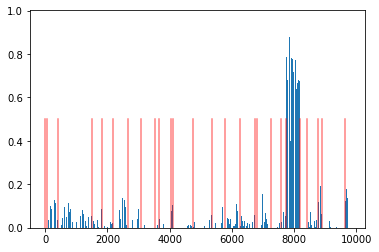

T_ACC =0.01592189446091652
T_BLCA =0.04444214701652527
T_BRCA =0.02857363224029541
T_CESC =0.022039953619241714
T_HBC =0.008267384022474289
T_COREAD =0.026579491794109344
T_DLBC =0.008398039266467094
T_GESCA =0.014576171524822712
T_GBM =0.006863619666546583
T_HNSC =0.007995463907718658
T_KICH =0.06761255115270615
T_KC =0.008100616745650768
T_LAML =0.007242697291076183
T_LGG =0.004783851560205221
T_LUAD =0.022632846608757973
T_LUSC =0.015769945457577705
T_MESO =0.0003530582180246711
T_GC =0.026069484651088715
T_PAAD =0.007553365547209978
T_PCPG =0.040873557329177856
T_PRAD =0.6631003618240356
T_SARC =0.01307416707277298
T_SKCM =0.01140738558024168
T_TGCT =0.05963478237390518
T_THCA =0.004793538711965084
T_THYM =0.08708075433969498
6


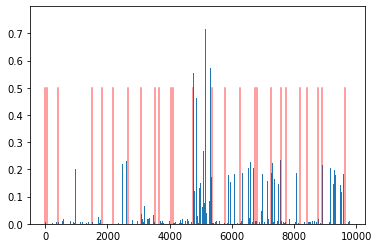

T_ACC =0.0017882274696603417
T_BLCA =0.0013143048854544759
T_BRCA =0.029628977179527283
T_CESC =0.017053602263331413
T_HBC =0.0013748884666711092
T_COREAD =0.0063522979617118835
T_DLBC =0.003694018581882119
T_GESCA =0.029029034078121185
T_GBM =0.0030824614223092794
T_HNSC =0.0034789182245731354
T_KICH =0.002849077805876732
T_KC =0.005561118014156818
T_LAML =0.22083909809589386
T_LGG =0.003999730572104454
T_LUAD =0.045916423201560974
T_LUSC =0.045189786702394485
T_MESO =0.005512707866728306
T_GC =0.04069812595844269
T_PAAD =0.0791914239525795
T_PCPG =0.00838945247232914
T_PRAD =0.025981221348047256
T_SARC =0.004037888720631599
T_SKCM =0.011638590134680271
T_TGCT =0.0014931652694940567
T_THCA =0.07670813053846359
T_THYM =0.00037874316330999136
7


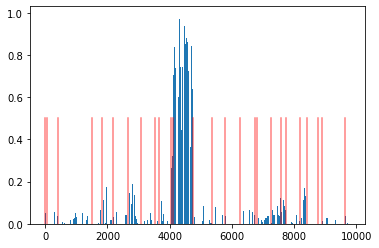

T_ACC =0.03594711422920227
T_BLCA =0.012803863734006882
T_BRCA =0.00722075579687953
T_CESC =0.015568800270557404
T_HBC =0.03939949348568916
T_COREAD =0.018876615911722183
T_DLBC =0.04302627220749855
T_GESCA =0.015542649663984776
T_GBM =0.01086447760462761
T_HNSC =0.00780153414234519
T_KICH =0.2614186406135559
T_KC =0.6915067434310913
T_LAML =0.028563519939780235
T_LGG =0.010833609849214554
T_LUAD =0.012081529945135117
T_LUSC =0.00690351752564311
T_MESO =0.04451639950275421
T_GC =0.025811759755015373
T_PAAD =0.04853770136833191
T_PCPG =0.0667511597275734
T_PRAD =0.006882871501147747
T_SARC =0.10701368004083633
T_SKCM =0.0031445370987057686
T_TGCT =0.023945916444063187
T_THCA =0.00547339441254735
T_THYM =0.026177316904067993
8


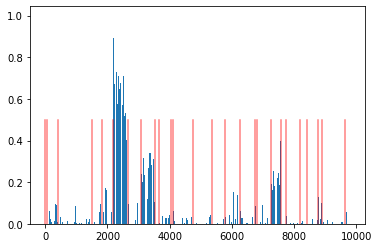

T_ACC =0.0017906218999996781
T_BLCA =0.03353385999798775
T_BRCA =0.006515648681670427
T_CESC =0.02886870689690113
T_HBC =0.03212318941950798
T_COREAD =0.6577128767967224
T_DLBC =0.028928807005286217
T_GESCA =0.2121473103761673
T_GBM =0.0024931663647294044
T_HNSC =0.00992750097066164
T_KICH =0.0029122664127498865
T_KC =0.01614939421415329
T_LAML =0.008199077099561691
T_LGG =0.003425430506467819
T_LUAD =0.02964021824300289
T_LUSC =0.006757745984941721
T_MESO =0.010794384405016899
T_GC =0.01578020304441452
T_PAAD =0.21055127680301666
T_PCPG =0.0012225924292579293
T_PRAD =0.010222227312624454
T_SARC =0.014772939495742321
T_SKCM =0.009423972107470036
T_TGCT =0.11881707608699799
T_THCA =0.0027055784594267607
T_THYM =0.0034309877082705498
9


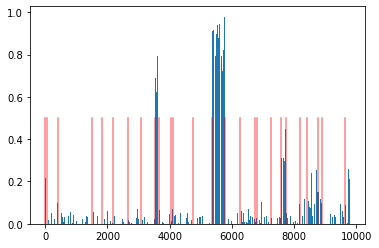

T_ACC =0.15370529890060425
T_BLCA =0.01875409297645092
T_BRCA =0.009514512494206429
T_CESC =0.007569571956992149
T_HBC =0.015057550743222237
T_COREAD =0.004206053446978331
T_DLBC =0.01671135425567627
T_GESCA =0.008665760047733784
T_GBM =0.6549269556999207
T_HNSC =0.011303011327981949
T_KICH =0.03635195270180702
T_KC =0.01997479796409607
T_LAML =0.00809344183653593
T_LGG =0.873539388179779
T_LUAD =0.01018845196813345
T_LUSC =0.018196232616901398
T_MESO =0.01613651216030121
T_GC =0.015346439555287361
T_PAAD =0.010539498180150986
T_PCPG =0.37395179271698
T_PRAD =0.021494649350643158
T_SARC =0.11527343094348907
T_SKCM =0.1106555387377739
T_TGCT =0.06993875652551651
T_THCA =0.02415885403752327
T_THYM =0.05483458563685417
10


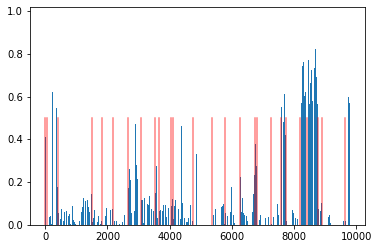

T_ACC =0.3510325849056244
T_BLCA =0.06694479286670685
T_BRCA =0.053316302597522736
T_CESC =0.06080694496631622
T_HBC =0.021105732768774033
T_COREAD =0.016587723046541214
T_DLBC =0.24347740411758423
T_GESCA =0.06934879720211029
T_GBM =0.13848654925823212
T_HNSC =0.06199510022997856
T_KICH =0.06291812658309937
T_KC =0.04532869905233383
T_LAML =0.008250768296420574
T_LGG =0.028763847425580025
T_LUAD =0.028285130858421326
T_LUSC =0.06870865076780319
T_MESO =0.3599962294101715
T_GC =0.038227200508117676
T_PAAD =0.03306043520569801
T_PCPG =0.45258957147598267
T_PRAD =0.015348660759627819
T_SARC =0.5500288605690002
T_SKCM =0.6709016561508179
T_TGCT =0.0971689522266388
T_THCA =0.006800511851906776
T_THYM =0.031105782836675644
11


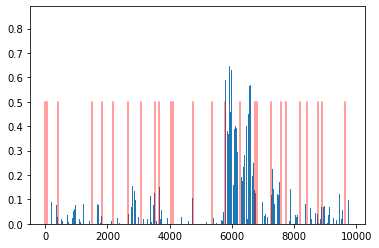

T_ACC =0.006820619106292725
T_BLCA =0.029502032324671745
T_BRCA =0.01933210715651512
T_CESC =0.016529127955436707
T_HBC =0.018854638561606407
T_COREAD =0.012888327240943909
T_DLBC =0.03365788236260414
T_GESCA =0.04961829259991646
T_GBM =0.011833420023322105
T_HNSC =0.019850652664899826
T_KICH =0.003066316246986389
T_KC =0.011090326122939587
T_LAML =0.0008941653068177402
T_LGG =0.01586904563009739
T_LUAD =0.44503656029701233
T_LUSC =0.2633943259716034
T_MESO =0.1283641904592514
T_GC =0.021434081718325615
T_PAAD =0.11730258911848068
T_PCPG =0.0066919648088514805
T_PRAD =0.02997935377061367
T_SARC =0.019496461376547813
T_SKCM =0.017106076702475548
T_TGCT =0.08217842876911163
T_THCA =0.02893383987247944
T_THYM =0.008339162915945053
12


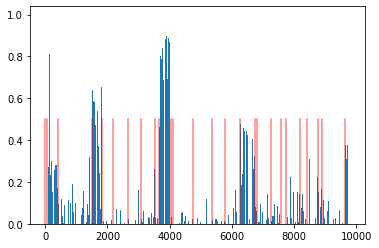

T_ACC =0.0168516393750906
T_BLCA =0.30448707938194275
T_BRCA =0.05466848984360695
T_CESC =0.4125085175037384
T_HBC =0.009135967120528221
T_COREAD =0.02529348060488701
T_DLBC =0.024181228131055832
T_GESCA =0.08768400549888611
T_GBM =0.0077882250770926476
T_HNSC =0.6996962428092957
T_KICH =0.008279618807137012
T_KC =0.009200693108141422
T_LAML =0.007074523717164993
T_LGG =0.005993887782096863
T_LUAD =0.03893490135669708
T_LUSC =0.3537653386592865
T_MESO =0.0944746658205986
T_GC =0.019032208248972893
T_PAAD =0.035833097994327545
T_PCPG =3.886200283886865e-05
T_PRAD =0.043600574135780334
T_SARC =0.036826781928539276
T_SKCM =0.07266853749752045
T_TGCT =0.14185044169425964
T_THCA =0.02123904414474964
T_THYM =0.286249577999115
13


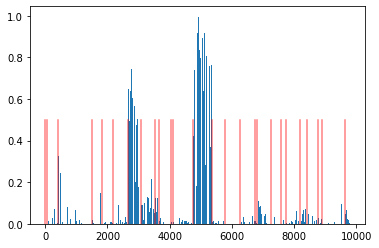

T_ACC =0.008831152692437172
T_BLCA =0.0038014205638319254
T_BRCA =0.019355861470103264
T_CESC =0.009065663442015648
T_HBC =0.004087490029633045
T_COREAD =0.02210257761180401
T_DLBC =0.4886116087436676
T_GESCA =0.08457383513450623
T_GBM =0.11327296495437622
T_HNSC =0.006882139481604099
T_KICH =0.0006505897617898881
T_KC =0.0056717274710536
T_LAML =0.6859896779060364
T_LGG =0.0037816129624843597
T_LUAD =0.0037335162051022053
T_LUSC =0.007346601225435734
T_MESO =0.004127491265535355
T_GC =0.05934883654117584
T_PAAD =0.02264494262635708
T_PCPG =0.0058668325655162334
T_PRAD =0.015782956033945084
T_SARC =0.018942149356007576
T_SKCM =0.015370757319033146
T_TGCT =0.01226403471082449
T_THCA =0.0239089448004961
T_THYM =0.04178963229060173


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


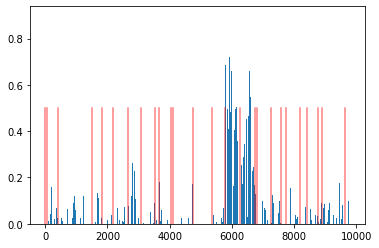

T_ACC =0.006100071128457785
T_BLCA =0.05467742308974266
T_BRCA =0.025572730228304863
T_CESC =0.02103746309876442
T_HBC =0.017703019082546234
T_COREAD =0.02128951996564865
T_DLBC =0.04079949110746384
T_GESCA =0.029122723266482353
T_GBM =0.014307632111012936
T_HNSC =0.021164439618587494
T_KICH =0.0044766683131456375
T_KC =0.01418294571340084
T_LAML =0.0017078263917937875
T_LGG =0.022080177441239357
T_LUAD =0.512534499168396
T_LUSC =0.29941609501838684
T_MESO =0.13178274035453796
T_GC =0.030480967834591866
T_PAAD =0.0476037822663784
T_PCPG =0.005628593266010284
T_PRAD =0.03212479501962662
T_SARC =0.017160655930638313
T_SKCM =0.015977568924427032
T_TGCT =0.10252679139375687
T_THCA =0.03879910334944725
T_THYM =0.011017200537025928
1


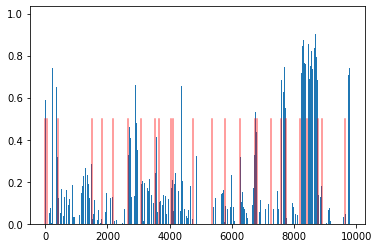

T_ACC =0.4966508150100708
T_BLCA =0.10182870924472809
T_BRCA =0.105531245470047
T_CESC =0.09899318218231201
T_HBC =0.0327947773039341
T_COREAD =0.023939549922943115
T_DLBC =0.3865399658679962
T_GESCA =0.1133323684334755
T_GBM =0.21884213387966156
T_HNSC =0.09242941439151764
T_KICH =0.1063639298081398
T_KC =0.08888369053602219
T_LAML =0.012291994877159595
T_LGG =0.048322271555662155
T_LUAD =0.043262381106615067
T_LUSC =0.09993031620979309
T_MESO =0.5116530656814575
T_GC =0.08287190645933151
T_PAAD =0.05440793186426163
T_PCPG =0.5901165008544922
T_PRAD =0.022628476843237877
T_SARC =0.6928489208221436
T_SKCM =0.7666115164756775
T_TGCT =0.16141359508037567
T_THCA =0.011733737774193287
T_THYM =0.05399859696626663
2


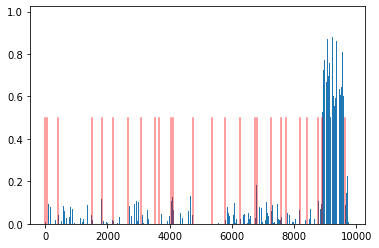

T_ACC =0.05178668722510338
T_BLCA =0.016322238370776176
T_BRCA =0.028798913583159447
T_CESC =0.00841866061091423
T_HBC =0.010626678355038166
T_COREAD =0.008607435040175915
T_DLBC =0.04801756516098976
T_GESCA =0.005333352833986282
T_GBM =0.0012656290782615542
T_HNSC =0.012042631395161152
T_KICH =0.1701662689447403
T_KC =0.03644905984401703
T_LAML =0.0015074416296556592
T_LGG =0.016698716208338737
T_LUAD =0.04097796604037285
T_LUSC =0.016278313472867012
T_MESO =0.042164143174886703
T_GC =0.027835845947265625
T_PAAD =0.022349266335368156
T_PCPG =0.013272136449813843
T_PRAD =0.013647566549479961
T_SARC =0.01447561476379633
T_SKCM =0.01236400380730629
T_TGCT =0.06352071464061737
T_THCA =0.6837135553359985
T_THYM =0.17803949117660522
3


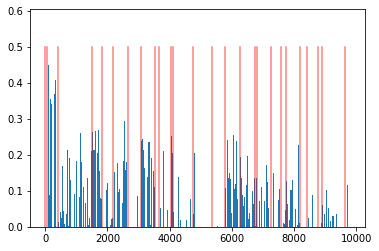

T_ACC =0.018444901332259178
T_BLCA =0.2813130021095276
T_BRCA =0.10166186839342117
T_CESC =0.21977591514587402
T_HBC =0.022359920665621758
T_COREAD =0.09965294599533081
T_DLBC =0.014041289687156677
T_GESCA =0.1695266216993332
T_GBM =0.0005859528901055455
T_HNSC =0.08828644454479218
T_KICH =0.2447049915790558
T_KC =0.0501905120909214
T_LAML =0.022215871140360832
T_LGG =0.0013209403259679675
T_LUAD =0.13121211528778076
T_LUSC =0.0880281999707222
T_MESO =0.023454682901501656
T_GC =0.06595117598772049
T_PAAD =0.07016034424304962
T_PCPG =0.005250437185168266
T_PRAD =0.04911839962005615
T_SARC =0.006112511269748211
T_SKCM =0.006159309297800064
T_TGCT =0.005795763805508614
T_THCA =0.013686148449778557
T_THYM =0.05995962396264076
4


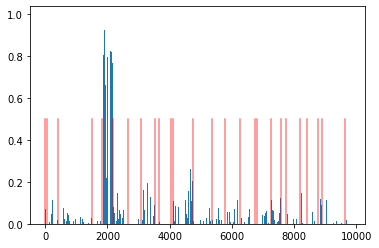

T_ACC =0.1705682873725891
T_BLCA =0.011618765071034431
T_BRCA =0.013868890702724457
T_CESC =0.005726994015276432
T_HBC =0.7569195628166199
T_COREAD =0.04346702992916107
T_DLBC =0.008474109694361687
T_GESCA =0.04705891013145447
T_GBM =0.007564537227153778
T_HNSC =0.008548705838620663
T_KICH =0.0274587944149971
T_KC =0.05889905244112015
T_LAML =0.011444475501775742
T_LGG =0.010038241744041443
T_LUAD =0.020913604646921158
T_LUSC =0.010612579993903637
T_MESO =0.013866244815289974
T_GC =0.013592952862381935
T_PAAD =0.04850668087601662
T_PCPG =0.00900176726281643
T_PRAD =0.01751263439655304
T_SARC =0.013237903825938702
T_SKCM =0.012559903785586357
T_TGCT =0.06830452382564545
T_THCA =0.004004287533462048
T_THYM =0.01592640019953251
5


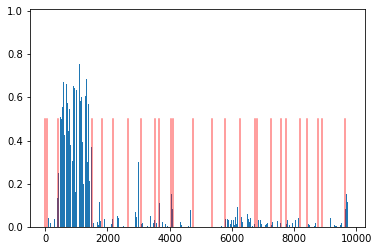

T_ACC =0.0
T_BLCA =0.03664736822247505
T_BRCA =0.46518272161483765
T_CESC =0.02582881785929203
T_HBC =0.00730918301269412
T_COREAD =0.011106078512966633
T_DLBC =0.009561693295836449
T_GESCA =0.015855368226766586
T_GBM =0.00761107262223959
T_HNSC =0.018422991037368774
T_KICH =0.11705131083726883
T_KC =0.011156627908349037
T_LAML =0.0005683518247678876
T_LGG =0.002718917094171047
T_LUAD =0.022122366353869438
T_LUSC =0.018554886803030968
T_MESO =0.002430243417620659
T_GC =0.02406204864382744
T_PAAD =0.007886290550231934
T_PCPG =0.0031227809377014637
T_PRAD =0.029814157634973526
T_SARC =0.004736898932605982
T_SKCM =0.010027401149272919
T_TGCT =0.02830985002219677
T_THCA =0.0055424063466489315
T_THYM =0.11144319921731949
6


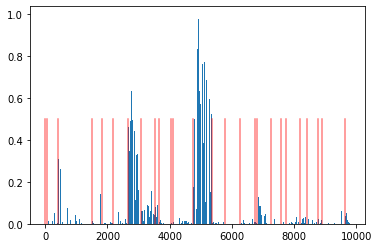

T_ACC =0.005057503469288349
T_BLCA =0.0027500116266310215
T_BRCA =0.016558608040213585
T_CESC =0.006455092690885067
T_HBC =0.0027030701749026775
T_COREAD =0.014432979747653008
T_DLBC =0.35745730996131897
T_GESCA =0.058976948261260986
T_GBM =0.07711247354745865
T_HNSC =0.0048971232026815414
T_KICH =0.0002924287400674075
T_KC =0.0048521701246500015
T_LAML =0.5063875913619995
T_LGG =0.002656593220308423
T_LUAD =0.002179441973567009
T_LUSC =0.004491109866648912
T_MESO =0.002392659429460764
T_GC =0.0589645616710186
T_PAAD =0.018472691997885704
T_PCPG =0.0031058122403919697
T_PRAD =0.008771805092692375
T_SARC =0.00988819357007742
T_SKCM =0.007051643915474415
T_TGCT =0.008085185661911964
T_THCA =0.01480122935026884
T_THYM =0.031924765557050705
7


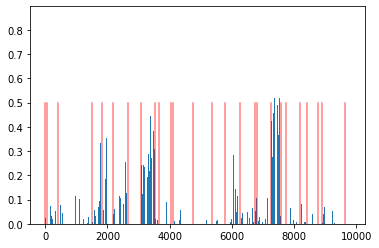

T_ACC =0.017726652324199677
T_BLCA =0.05065318942070007
T_BRCA =0.011257877573370934
T_CESC =0.056396014988422394
T_HBC =0.05931983143091202
T_COREAD =0.061941102147102356
T_DLBC =0.01909632608294487
T_GESCA =0.24747374653816223
T_GBM =0.006947405636310577
T_HNSC =0.017381155863404274
T_KICH =0.002838617190718651
T_KC =0.026130281388759613
T_LAML =0.0020413980819284916
T_LGG =0.002855118364095688
T_LUAD =0.052420370280742645
T_LUSC =0.018576040863990784
T_MESO =0.05053853616118431
T_GC =0.02272256650030613
T_PAAD =0.4207354485988617
T_PCPG =0.0030853848438709974
T_PRAD =0.007022539619356394
T_SARC =0.01440256368368864
T_SKCM =0.0024987293872982264
T_TGCT =0.017338063567876816
T_THCA =0.006293404381722212
T_THYM =0.0019938258919864893
8


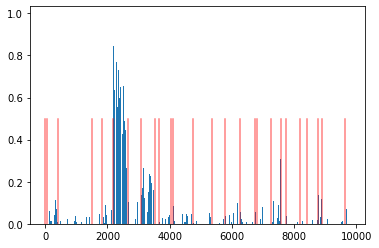

T_ACC =0.0005695119616575539
T_BLCA =0.029170261695981026
T_BRCA =0.00561169721186161
T_CESC =0.018237678334116936
T_HBC =0.01733001507818699
T_COREAD =0.6341280341148376
T_DLBC =0.023822981864213943
T_GESCA =0.12670129537582397
T_GBM =0.002181112766265869
T_HNSC =0.006967601832002401
T_KICH =0.002991029527038336
T_KC =0.0173474233597517
T_LAML =0.00970082264393568
T_LGG =0.00395806971937418
T_LUAD =0.016017867252230644
T_LUSC =0.004188932944089174
T_MESO =0.003067989135161042
T_GC =0.012000168673694134
T_PAAD =0.05442221462726593
T_PCPG =0.0007861611084081233
T_PRAD =0.00814034789800644
T_SARC =0.008558842353522778
T_SKCM =0.006418215110898018
T_TGCT =0.12506982684135437
T_THCA =0.0020876408088952303
T_THYM =0.0034262770786881447
9


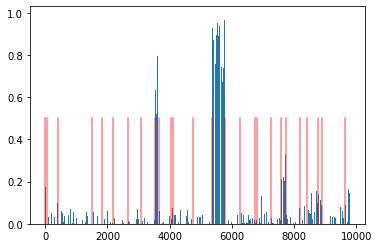

T_ACC =0.12586989998817444
T_BLCA =0.020375531166791916
T_BRCA =0.011830182746052742
T_CESC =0.008108953014016151
T_HBC =0.013554204255342484
T_COREAD =0.0031808086205273867
T_DLBC =0.015465118922293186
T_GESCA =0.008463420905172825
T_GBM =0.6196544766426086
T_HNSC =0.01024687197059393
T_KICH =0.046449676156044006
T_KC =0.024645086377859116
T_LAML =0.008400448597967625
T_LGG =0.8523730635643005
T_LUAD =0.007957068271934986
T_LUSC =0.014265741221606731
T_MESO =0.012116185389459133
T_GC =0.01927776262164116
T_PAAD =0.010507273487746716
T_PCPG =0.2765030860900879
T_PRAD =0.017384231090545654
T_SARC =0.08712368458509445
T_SKCM =0.06940162926912308
T_TGCT =0.06491927802562714
T_THCA =0.021482083946466446
T_THYM =0.055970191955566406
10


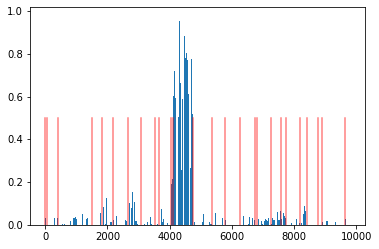

T_ACC =0.02232426218688488
T_BLCA =0.007005121558904648
T_BRCA =0.006214463151991367
T_CESC =0.009800441563129425
T_HBC =0.028637154027819633
T_COREAD =0.011428019031882286
T_DLBC =0.0283525250852108
T_GESCA =0.008307798765599728
T_GBM =0.007397407665848732
T_HNSC =0.005242957267910242
T_KICH =0.19044221937656403
T_KC =0.6011049151420593
T_LAML =0.01957075484097004
T_LGG =0.007336750160902739
T_LUAD =0.006423906423151493
T_LUSC =0.0040940395556390285
T_MESO =0.02464825101196766
T_GC =0.019326897338032722
T_PAAD =0.02920582890510559
T_PCPG =0.036080069839954376
T_PRAD =0.004203501623123884
T_SARC =0.057240888476371765
T_SKCM =0.00141906610224396
T_TGCT =0.01706368662416935
T_THCA =0.0038584547583013773
T_THYM =0.018254995346069336
11


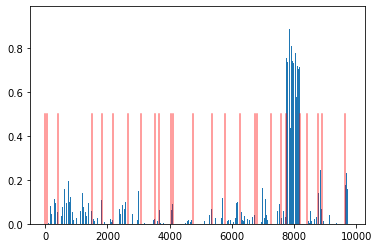

T_ACC =0.01417890191078186
T_BLCA =0.029310453683137894
T_BRCA =0.042204879224300385
T_CESC =0.019437702372670174
T_HBC =0.008668451569974422
T_COREAD =0.016449017450213432
T_DLBC =0.007848486304283142
T_GESCA =0.016584089025855064
T_GBM =0.00858517736196518
T_HNSC =0.009712710976600647
T_KICH =0.05315452441573143
T_KC =0.009553504176437855
T_LAML =0.005830223206430674
T_LGG =0.006055584643036127
T_LUAD =0.014811006374657154
T_LUSC =0.013865216635167599
T_MESO =0.0003383047878742218
T_GC =0.030866866931319237
T_PAAD =0.01868070848286152
T_PCPG =0.03695289418101311
T_PRAD =0.6874959468841553
T_SARC =0.012631706893444061
T_SKCM =0.00882935430854559
T_TGCT =0.07172846049070358
T_THCA =0.005309876520186663
T_THYM =0.11023243516683578
12


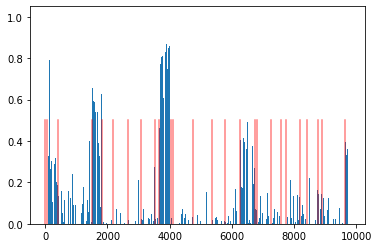

T_ACC =0.014512386173009872
T_BLCA =0.3217076361179352
T_BRCA =0.06658734381198883
T_CESC =0.4148765504360199
T_HBC =0.008203824982047081
T_COREAD =0.023829882964491844
T_DLBC =0.023800788447260857
T_GESCA =0.0834113210439682
T_GBM =0.008330980315804482
T_HNSC =0.6829898953437805
T_KICH =0.006591378711163998
T_KC =0.011361747980117798
T_LAML =0.007807442452758551
T_LGG =0.006703631486743689
T_LUAD =0.038926221430301666
T_LUSC =0.31776726245880127
T_MESO =0.0860884040594101
T_GC =0.024398259818553925
T_PAAD =0.0295033548027277
T_PCPG =2.9060931410640478e-05
T_PRAD =0.04054107889533043
T_SARC =0.028621403500437737
T_SKCM =0.05783877894282341
T_TGCT =0.13724753260612488
T_THCA =0.02302667312324047
T_THYM =0.30388814210891724
13


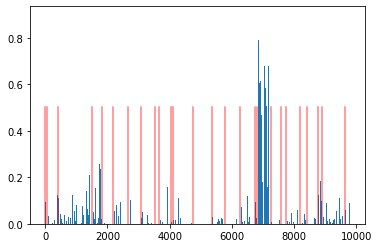

T_ACC =0.0535379983484745
T_BLCA =0.03380272909998894
T_BRCA =0.03726371005177498
T_CESC =0.05331255495548248
T_HBC =0.010704617947340012
T_COREAD =0.013929378241300583
T_DLBC =0.008600616827607155
T_GESCA =0.010991236194968224
T_GBM =0.01317161787301302
T_HNSC =0.014110914431512356
T_KICH =0.020366892218589783
T_KC =0.0302369836717844
T_LAML =0.0014879006193950772
T_LGG =0.0074441381730139256
T_LUAD =0.017518851906061172
T_LUSC =0.015782563015818596
T_MESO =0.08556132763624191
T_GC =0.4791143834590912
T_PAAD =0.020587222650647163
T_PCPG =0.0021620341576635838
T_PRAD =0.016511069610714912
T_SARC =0.025986239314079285
T_SKCM =0.005710628814995289
T_TGCT =0.12439930438995361
T_THCA =0.016790909692645073
T_THYM =0.043016817420721054
14


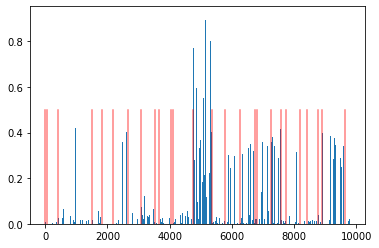

T_ACC =0.00267214048653841
T_BLCA =0.0028175795450806618
T_BRCA =0.06185488775372505
T_CESC =0.03359401971101761
T_HBC =0.003165694884955883
T_COREAD =0.012618212960660458
T_DLBC =0.008121767081320286
T_GESCA =0.058860789984464645
T_GBM =0.00644239317625761
T_HNSC =0.007556137163192034
T_KICH =0.006651314906775951
T_KC =0.015006020665168762
T_LAML =0.38903746008872986
T_LGG =0.009437800385057926
T_LUAD =0.07272233068943024
T_LUSC =0.07414869964122772
T_MESO =0.009897206909954548
T_GC =0.0885336622595787
T_PAAD =0.14697100222110748
T_PCPG =0.014903305098414421
T_PRAD =0.04508348926901817
T_SARC =0.006973942741751671
T_SKCM =0.017132213339209557
T_TGCT =0.004277433268725872
T_THCA =0.14887048304080963
T_THYM =0.0009080261806957424


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


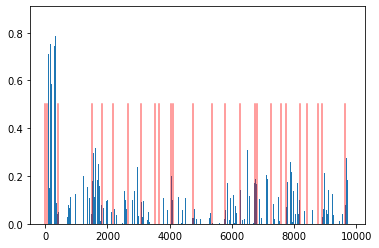

T_ACC =0.024459782987833023
T_BLCA =0.48153528571128845
T_BRCA =0.035704758018255234
T_CESC =0.19816862046718597
T_HBC =0.024370664730668068
T_COREAD =0.03719307482242584
T_DLBC =0.04136424511671066
T_GESCA =0.04402882233262062
T_GBM =0.000540752662345767
T_HNSC =0.05215621739625931
T_KICH =0.13091662526130676
T_KC =0.03043932095170021
T_LAML =0.01299547404050827
T_LGG =0.0021076458506286144
T_LUAD =0.06565526872873306
T_LUSC =0.06794080138206482
T_MESO =0.1345636397600174
T_GC =0.044642601162195206
T_PAAD =0.042290788143873215
T_PCPG =0.0010067136026918888
T_PRAD =0.07438015937805176
T_SARC =0.0349602997303009
T_SKCM =0.0019460729090496898
T_TGCT =0.008099363185465336
T_THCA =0.022915255278348923
T_THYM =0.17062370479106903
1


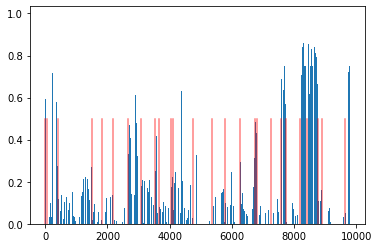

T_ACC =0.4968900680541992
T_BLCA =0.10279374569654465
T_BRCA =0.09588412195444107
T_CESC =0.08899129182100296
T_HBC =0.032712846994400024
T_COREAD =0.02177361585199833
T_DLBC =0.3840474784374237
T_GESCA =0.10479653626680374
T_GBM =0.2221219390630722
T_HNSC =0.07310045510530472
T_KICH =0.11320807039737701
T_KC =0.09000983089208603
T_LAML =0.01531616784632206
T_LGG =0.04952407255768776
T_LUAD =0.046033825725317
T_LUSC =0.09272714704275131
T_MESO =0.4863952696323395
T_GC =0.07219240069389343
T_PAAD =0.0450439453125
T_PCPG =0.5941019058227539
T_PRAD =0.021193940192461014
T_SARC =0.6818852424621582
T_SKCM =0.754143476486206
T_TGCT =0.14811868965625763
T_THCA =0.010254261083900928
T_THYM =0.04801584780216217
2


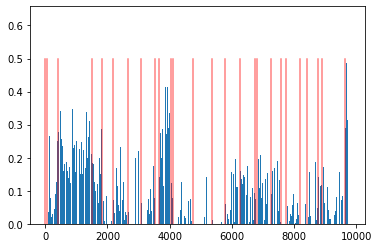

T_ACC =0.002302260370925069
T_BLCA =0.13256476819515228
T_BRCA =0.22501881420612335
T_CESC =0.13755373656749725
T_HBC =0.029872652143239975
T_COREAD =0.08520997315645218
T_DLBC =0.028323719277977943
T_GESCA =0.06685993820428848
T_GBM =0.0022533275187015533
T_HNSC =0.19974543154239655
T_KICH =0.11510948091745377
T_KC =0.030463190749287605
T_LAML =0.007145808078348637
T_LGG =0.005130666773766279
T_LUAD =0.07026723772287369
T_LUSC =0.11374308168888092
T_MESO =0.04007353261113167
T_GC =0.11216778308153152
T_PAAD =0.09698165208101273
T_PCPG =0.003941898234188557
T_PRAD =0.06305082142353058
T_SARC =0.018471142277121544
T_SKCM =0.0465301088988781
T_TGCT =0.21468044817447662
T_THCA =0.05227816104888916
T_THYM =0.29467523097991943
3


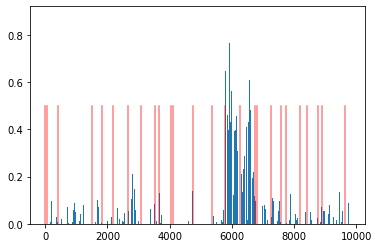

T_ACC =0.005054956767708063
T_BLCA =0.024961505085229874
T_BRCA =0.01775437965989113
T_CESC =0.014490489847958088
T_HBC =0.014464754611253738
T_COREAD =0.017568249255418777
T_DLBC =0.031592294573783875
T_GESCA =0.023788871243596077
T_GBM =0.011195728555321693
T_HNSC =0.01562510058283806
T_KICH =0.003763443324714899
T_KC =0.011220053769648075
T_LAML =0.0014660696033388376
T_LGG =0.017397329211235046
T_LUAD =0.4703094959259033
T_LUSC =0.24983689188957214
T_MESO =0.10549817979335785
T_GC =0.02660035341978073
T_PAAD =0.05169372260570526
T_PCPG =0.004976355005055666
T_PRAD =0.02577754110097885
T_SARC =0.012568886391818523
T_SKCM =0.012627186253666878
T_TGCT =0.07687444984912872
T_THCA =0.0288394782692194
T_THYM =0.007745170034468174
4


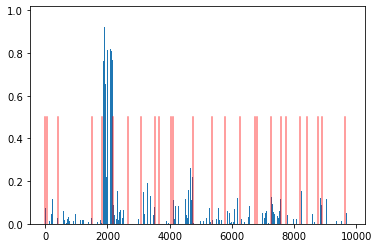

T_ACC =0.1702275574207306
T_BLCA =0.014142652973532677
T_BRCA =0.012528575025498867
T_CESC =0.004711990710347891
T_HBC =0.7500357627868652
T_COREAD =0.04350309818983078
T_DLBC =0.008949614129960537
T_GESCA =0.04137391224503517
T_GBM =0.00794529914855957
T_HNSC =0.006804265081882477
T_KICH =0.025515930727124214
T_KC =0.06066230311989784
T_LAML =0.010495424270629883
T_LGG =0.009855067357420921
T_LUAD =0.020850839093327522
T_LUSC =0.010417040437459946
T_MESO =0.016535306349396706
T_GC =0.013317426666617393
T_PAAD =0.05655039846897125
T_PCPG =0.009571705013513565
T_PRAD =0.017483942210674286
T_SARC =0.0143869798630476
T_SKCM =0.0122983418405056
T_TGCT =0.0757637545466423
T_THCA =0.0037990075070410967
T_THYM =0.014224860817193985
5


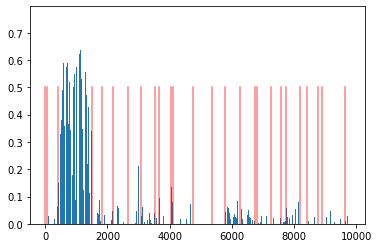

T_ACC =0.0003520209575071931
T_BLCA =0.014729483053088188
T_BRCA =0.38746902346611023
T_CESC =0.024864699691534042
T_HBC =0.006886691320687532
T_COREAD =0.011361295357346535
T_DLBC =0.005648463033139706
T_GESCA =0.023903023451566696
T_GBM =0.008750681765377522
T_HNSC =0.015053809620440006
T_KICH =0.1163831278681755
T_KC =0.010815414600074291
T_LAML =0.0008028657757677138
T_LGG =0.0028055249713361263
T_LUAD =0.030130693688988686
T_LUSC =0.01669524610042572
T_MESO =0.002125293482095003
T_GC =0.022423919290304184
T_PAAD =0.00408542063087225
T_PCPG =0.005538156256079674
T_PRAD =0.030215805396437645
T_SARC =0.003846043022349477
T_SKCM =0.006010804325342178
T_TGCT =0.003778755431994796
T_THCA =0.005065801553428173
T_THYM =0.02952757477760315
6


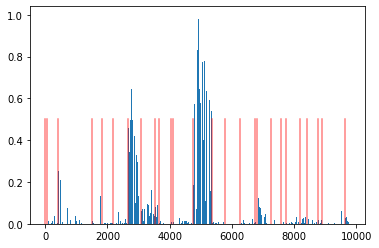

T_ACC =0.004422654397785664
T_BLCA =0.0028604899998754263
T_BRCA =0.014611804857850075
T_CESC =0.0056325956247746944
T_HBC =0.002734704874455929
T_COREAD =0.013861257582902908
T_DLBC =0.3487496078014374
T_GESCA =0.05933266878128052
T_GBM =0.07787083834409714
T_HNSC =0.003249365370720625
T_KICH =0.000508492870721966
T_KC =0.004872222431004047
T_LAML =0.5153390765190125
T_LGG =0.002656752709299326
T_LUAD =0.0026496199425309896
T_LUSC =0.003947461489588022
T_MESO =0.002092603361234069
T_GC =0.05724356323480606
T_PAAD =0.01811240427196026
T_PCPG =0.0031516929157078266
T_PRAD =0.008894763886928558
T_SARC =0.00937807559967041
T_SKCM =0.007024876307696104
T_TGCT =0.007885574363172054
T_THCA =0.014879501424729824
T_THYM =0.025066813454031944
7


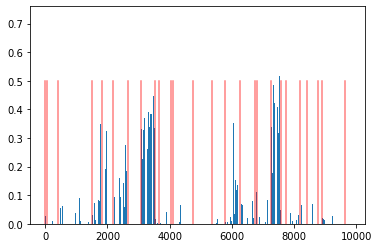

T_ACC =0.015377910807728767
T_BLCA =0.021553119644522667
T_BRCA =0.008567286655306816
T_CESC =0.06494593620300293
T_HBC =0.051363296806812286
T_COREAD =0.07408848404884338
T_DLBC =0.014356452040374279
T_GESCA =0.314151793718338
T_GBM =0.005420041736215353
T_HNSC =0.01747911237180233
T_KICH =0.0033035350497812033
T_KC =0.028187919408082962
T_LAML =0.0019101150101050735
T_LGG =0.0027397386729717255
T_LUAD =0.07746708393096924
T_LUSC =0.01950647681951523
T_MESO =0.023450402542948723
T_GC =0.02488269843161106
T_PAAD =0.3944016695022583
T_PCPG =0.0014531755587086082
T_PRAD =0.005330640822649002
T_SARC =0.008777596056461334
T_SKCM =0.0018920134752988815
T_TGCT =0.009455928578972816
T_THCA =0.0035275721456855536
T_THYM =0.0011429196456447244
8


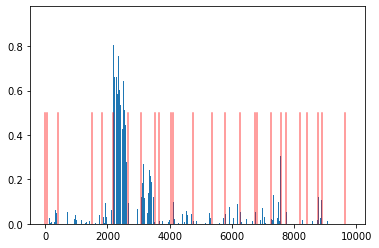

T_ACC =0.0008048719610087574
T_BLCA =0.015216212719678879
T_BRCA =0.0050563812255859375
T_CESC =0.015869051218032837
T_HBC =0.016429640352725983
T_COREAD =0.6078541278839111
T_DLBC =0.02108611911535263
T_GESCA =0.12229008227586746
T_GBM =0.0020422739908099174
T_HNSC =0.006686640903353691
T_KICH =0.0009064602782018483
T_KC =0.018107641488313675
T_LAML =0.011378960683941841
T_LGG =0.003957307431846857
T_LUAD =0.013849823735654354
T_LUSC =0.004626051522791386
T_MESO =0.0037178723141551018
T_GC =0.01207686960697174
T_PAAD =0.05709870159626007
T_PCPG =0.0007191737531684339
T_PRAD =0.006950228475034237
T_SARC =0.008115529082715511
T_SKCM =0.005540322046726942
T_TGCT =0.09609529376029968
T_THCA =0.001171008450910449
T_THYM =0.0002904699940700084
9


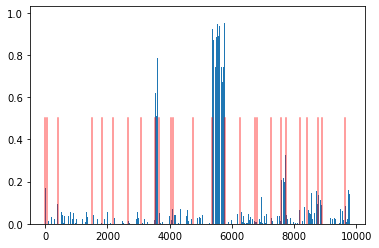

T_ACC =0.11946126073598862
T_BLCA =0.01501319371163845
T_BRCA =0.01177973672747612
T_CESC =0.0055190641433000565
T_HBC =0.013190840370953083
T_COREAD =0.0028167155105620623
T_DLBC =0.014888660050928593
T_GESCA =0.007601745426654816
T_GBM =0.613210916519165
T_HNSC =0.0077652535401284695
T_KICH =0.04022359102964401
T_KC =0.024231839925050735
T_LAML =0.007724531926214695
T_LGG =0.849183201789856
T_LUAD =0.008416661061346531
T_LUSC =0.012428758665919304
T_MESO =0.010906863026320934
T_GC =0.018324512988328934
T_PAAD =0.01161109283566475
T_PCPG =0.272114634513855
T_PRAD =0.017042435705661774
T_SARC =0.08261362463235855
T_SKCM =0.06791947782039642
T_TGCT =0.07010802626609802
T_THCA =0.019423579797148705
T_THYM =0.060999054461717606
10


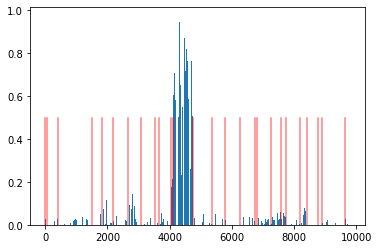

T_ACC =0.01955866627395153
T_BLCA =0.004391346126794815
T_BRCA =0.0050287856720387936
T_CESC =0.008287239819765091
T_HBC =0.026545459404587746
T_COREAD =0.010993888601660728
T_DLBC =0.02534135803580284
T_GESCA =0.008533800952136517
T_GBM =0.006687574554234743
T_HNSC =0.003917676396667957
T_KICH =0.18779410421848297
T_KC =0.5925151109695435
T_LAML =0.018578752875328064
T_LGG =0.006835311651229858
T_LUAD =0.006932610180228949
T_LUSC =0.0036613191477954388
T_MESO =0.020864075049757957
T_GC =0.017710665240883827
T_PAAD =0.02872222103178501
T_PCPG =0.03524267300963402
T_PRAD =0.003792353207245469
T_SARC =0.051336031407117844
T_SKCM =0.0012862365692853928
T_TGCT =0.018125349655747414
T_THCA =0.0036747760605067015
T_THYM =0.01575462333858013
11


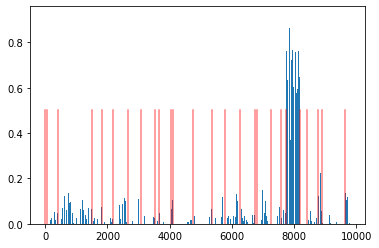

T_ACC =0.013475846499204636
T_BLCA =0.015185185708105564
T_BRCA =0.036217622458934784
T_CESC =0.020441845059394836
T_HBC =0.007924946025013924
T_COREAD =0.018749549984931946
T_DLBC =0.0042250389233231544
T_GESCA =0.023870529606938362
T_GBM =0.007678121328353882
T_HNSC =0.009160312823951244
T_KICH =0.06974757462739944
T_KC =0.010356650687754154
T_LAML =0.006694212090224028
T_LGG =0.005920797120779753
T_LUAD =0.01884729415178299
T_LUSC =0.013861780054867268
T_MESO =0.0001917769986903295
T_GC =0.030648967251181602
T_PAAD =0.013558144681155682
T_PCPG =0.037011757493019104
T_PRAD =0.6382613182067871
T_SARC =0.01007736474275589
T_SKCM =0.008828706108033657
T_TGCT =0.06222088634967804
T_THCA =0.0049917385913431644
T_THYM =0.07617679238319397
12


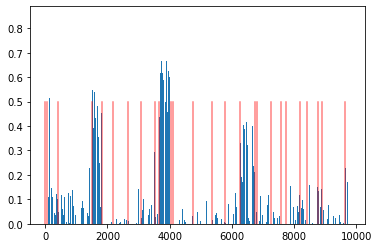

T_ACC =0.018717503175139427
T_BLCA =0.13053256273269653
T_BRCA =0.0441301204264164
T_CESC =0.33170178532600403
T_HBC =0.0042664362117648125
T_COREAD =0.022301964461803436
T_DLBC =0.014813404530286789
T_GESCA =0.0864245817065239
T_GBM =0.012262358330190182
T_HNSC =0.5669152736663818
T_KICH =0.000838703999761492
T_KC =0.00820661149919033
T_LAML =0.007235340774059296
T_LGG =0.008029615506529808
T_LUAD =0.03180670365691185
T_LUSC =0.29108643531799316
T_MESO =0.0477798692882061
T_GC =0.023519573733210564
T_PAAD =0.019445884972810745
T_PCPG =0.0
T_PRAD =0.020625799894332886
T_SARC =0.02285963110625744
T_SKCM =0.04172433540225029
T_TGCT =0.0863928496837616
T_THCA =0.01244596391916275
T_THYM =0.1232081800699234
13


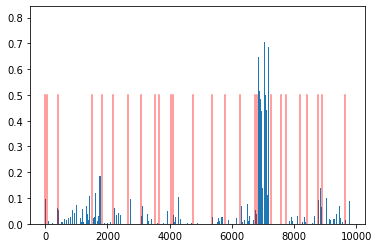

T_ACC =0.05485624447464943
T_BLCA =0.011325872503221035
T_BRCA =0.024053139612078667
T_CESC =0.042251862585544586
T_HBC =0.007104918360710144
T_COREAD =0.010230332612991333
T_DLBC =0.005738699808716774
T_GESCA =0.01248486153781414
T_GBM =0.014357863925397396
T_HNSC =0.009291470982134342
T_KICH =0.014846519567072392
T_KC =0.027557794004678726
T_LAML =0.0015317994402721524
T_LGG =0.007259859703481197
T_LUAD =0.015905365347862244
T_LUSC =0.012966705486178398
T_MESO =0.058158960193395615
T_GC =0.41310417652130127
T_PAAD =0.011245490051805973
T_PCPG =0.0020169978961348534
T_PRAD =0.010927549563348293
T_SARC =0.019511094316840172
T_SKCM =0.004159511532634497
T_TGCT =0.07120523601770401
T_THCA =0.012170771136879921
T_THYM =0.00899489689618349
14


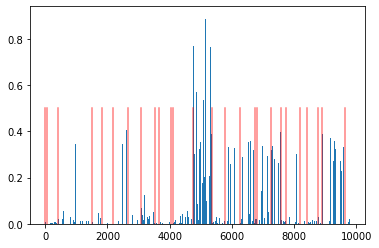

T_ACC =0.00291631487198174
T_BLCA =0.0038146651349961758
T_BRCA =0.05168834328651428
T_CESC =0.029134605079889297
T_HBC =0.0031199129298329353
T_COREAD =0.012223564088344574
T_DLBC =0.007298633456230164
T_GESCA =0.05365045741200447
T_GBM =0.0063349404372274876
T_HNSC =0.003296197159215808
T_KICH =0.007668918464332819
T_KC =0.014810577034950256
T_LAML =0.3800819218158722
T_LGG =0.009037305600941181
T_LUAD =0.07609168440103531
T_LUSC =0.07074117660522461
T_MESO =0.010426604188978672
T_GC =0.08394777029752731
T_PAAD =0.13222576677799225
T_PCPG =0.015193426050245762
T_PRAD =0.04339108243584633
T_SARC =0.007164923474192619
T_SKCM =0.01597701385617256
T_TGCT =0.0029344388749450445
T_THCA =0.14172007143497467
T_THYM =0.0006827606703154743
15


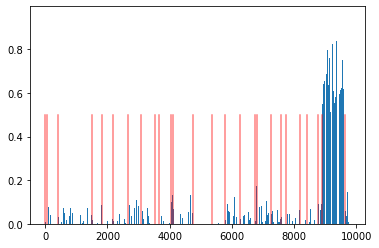

T_ACC =0.05112208053469658
T_BLCA =0.009379900060594082
T_BRCA =0.02450711280107498
T_CESC =0.007435186300426722
T_HBC =0.008976448327302933
T_COREAD =0.010270806960761547
T_DLBC =0.0435762032866478
T_GESCA =0.0069083659909665585
T_GBM =0.0013273356016725302
T_HNSC =0.0097534554079175
T_KICH =0.16926543414592743
T_KC =0.03754350170493126
T_LAML =0.0013034648727625608
T_LGG =0.017559753730893135
T_LUAD =0.04478578269481659
T_LUSC =0.01581360399723053
T_MESO =0.03721974417567253
T_GC =0.027196718379855156
T_PAAD =0.016932714730501175
T_PCPG =0.013959712348878384
T_PRAD =0.012681670486927032
T_SARC =0.014047636650502682
T_SKCM =0.01209152489900589
T_TGCT =0.048260968178510666
T_THCA =0.6628430485725403
T_THYM =0.12287110835313797
0


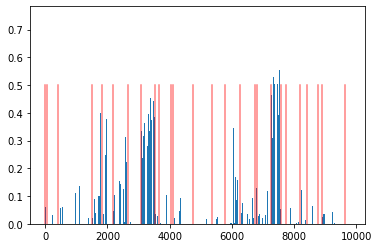

T_ACC =0.027870023623108864
T_BLCA =0.024841852486133575
T_BRCA =0.012578639201819897
T_CESC =0.07130561023950577
T_HBC =0.06811793893575668
T_COREAD =0.08322017639875412
T_DLBC =0.022487126290798187
T_GESCA =0.31997212767601013
T_GBM =0.0123487189412117
T_HNSC =0.023896927013993263
T_KICH =0.002648324938490987
T_KC =0.03892669081687927
T_LAML =0.0029632444493472576
T_LGG =0.0051179793663322926
T_LUAD =0.07438021153211594
T_LUSC =0.02319392003118992
T_MESO =0.03944327309727669
T_GC =0.03363768011331558
T_PAAD =0.45583269000053406
T_PCPG =0.004211080726236105
T_PRAD =0.006534229964017868
T_SARC =0.016034968197345734
T_SKCM =0.003465594258159399
T_TGCT =0.019484370946884155
T_THCA =0.006403271108865738
T_THYM =0.0019524670206010342
1


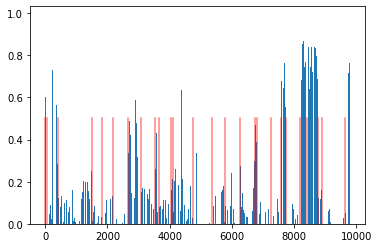

T_ACC =0.4951333701610565
T_BLCA =0.09796147048473358
T_BRCA =0.09098208695650101
T_CESC =0.0837792232632637
T_HBC =0.031734220683574677
T_COREAD =0.018122391775250435
T_DLBC =0.3837878406047821
T_GESCA =0.08804250508546829
T_GBM =0.2288331240415573
T_HNSC =0.07483953982591629
T_KICH =0.10853554308414459
T_KC =0.09291888028383255
T_LAML =0.013978878036141396
T_LGG =0.05196322873234749
T_LUAD =0.040577393025159836
T_LUSC =0.08916498720645905
T_MESO =0.4642798602581024
T_GC =0.07778836041688919
T_PAAD =0.0429014191031456
T_PCPG =0.6012627482414246
T_PRAD =0.01965199038386345
T_SARC =0.6790887117385864
T_SKCM =0.7567622065544128
T_TGCT =0.15673033893108368
T_THCA =0.009594879113137722
T_THYM =0.052308984100818634
2


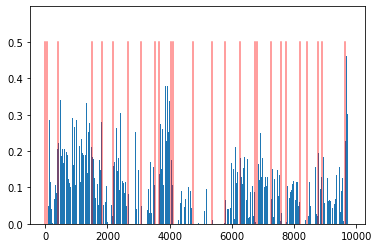

T_ACC =0.002198251895606518
T_BLCA =0.13914604485034943
T_BRCA =0.20613208413124084
T_CESC =0.13481739163398743
T_HBC =0.04124424234032631
T_COREAD =0.15051135420799255
T_DLBC =0.030446471646428108
T_GESCA =0.07736832648515701
T_GBM =0.0012066832277923822
T_HNSC =0.1883866935968399
T_KICH =0.1565724015235901
T_KC =0.03960203751921654
T_LAML =0.0054010627791285515
T_LGG =0.0031771741341799498
T_LUAD =0.07877500355243683
T_LUSC =0.11846884340047836
T_MESO =0.014721227809786797
T_GC =0.1305331587791443
T_PAAD =0.1044972762465477
T_PCPG =0.004993950016796589
T_PRAD =0.11071418970823288
T_SARC =0.009623506106436253
T_SKCM =0.03885238990187645
T_TGCT =0.2442423403263092
T_THCA =0.06922250241041183
T_THYM =0.2760963439941406
3


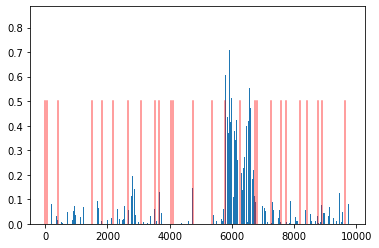

T_ACC =0.005089797079563141
T_BLCA =0.020483097061514854
T_BRCA =0.015582446940243244
T_CESC =0.012659315951168537
T_HBC =0.012737317010760307
T_COREAD =0.015948951244354248
T_DLBC =0.028699563816189766
T_GESCA =0.021375352516770363
T_GBM =0.011932668276131153
T_HNSC =0.01473980862647295
T_KICH =0.004105063620954752
T_KC =0.01104946993291378
T_LAML =0.0014171574730426073
T_LGG =0.0193850789219141
T_LUAD =0.4324641823768616
T_LUSC =0.23748774826526642
T_MESO =0.09565620124340057
T_GC =0.02443360537290573
T_PAAD =0.02976813353598118
T_PCPG =0.004474456887692213
T_PRAD =0.02157723531126976
T_SARC =0.011502839624881744
T_SKCM =0.011723124422132969
T_TGCT =0.07416291534900665
T_THCA =0.026970915496349335
T_THYM =0.00743842450901866
4


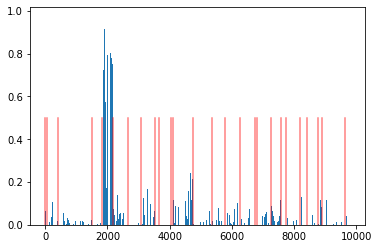

T_ACC =0.16083800792694092
T_BLCA =0.01146868709474802
T_BRCA =0.010570294223725796
T_CESC =0.004052157048135996
T_HBC =0.7220888733863831
T_COREAD =0.03910689428448677
T_DLBC =0.0073258415795862675
T_GESCA =0.036181896924972534
T_GBM =0.00695185037329793
T_HNSC =0.005514753516763449
T_KICH =0.023855241015553474
T_KC =0.05942442640662193
T_LAML =0.01003697607666254
T_LGG =0.009624634869396687
T_LUAD =0.01962258853018284
T_LUSC =0.009153967723250389
T_MESO =0.012582899071276188
T_GC =0.012930542230606079
T_PAAD =0.03967662155628204
T_PCPG =0.008790221065282822
T_PRAD =0.015552062541246414
T_SARC =0.012028411962091923
T_SKCM =0.011780379340052605
T_TGCT =0.06893588602542877
T_THCA =0.0038337265141308308
T_THYM =0.01177538838237524
5


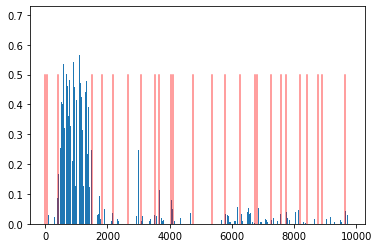

T_ACC =0.00030406442238017917
T_BLCA =0.012804866768419743
T_BRCA =0.3438953459262848
T_CESC =0.01826290972530842
T_HBC =0.006557389162480831
T_COREAD =0.007026769686490297
T_DLBC =0.007204046472907066
T_GESCA =0.01119615975767374
T_GBM =0.012873604893684387
T_HNSC =0.014575657434761524
T_KICH =0.0565313883125782
T_KC =0.006833597086369991
T_LAML =0.0007105009281076491
T_LGG =0.004498523194342852
T_LUAD =0.016898375004529953
T_LUSC =0.014095560647547245
T_MESO =0.005340995732694864
T_GC =0.02123044803738594
T_PAAD =0.004307191353291273
T_PCPG =0.003294159658253193
T_PRAD =0.02226523496210575
T_SARC =0.0056642452254891396
T_SKCM =0.007217119913548231
T_TGCT =0.0044218976981937885
T_THCA =0.0039888788014650345
T_THYM =0.03761028125882149
6


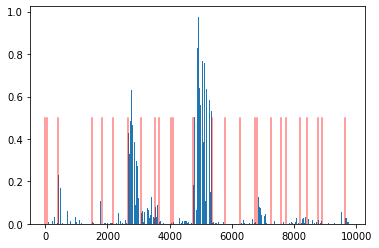

T_ACC =0.0045029167085886
T_BLCA =0.0024112858809530735
T_BRCA =0.012814287096261978
T_CESC =0.004813851322978735
T_HBC =0.0025948656257241964
T_COREAD =0.012357023544609547
T_DLBC =0.3282380700111389
T_GESCA =0.04693134129047394
T_GBM =0.07598677277565002
T_HNSC =0.0031349589116871357
T_KICH =0.00026667932979762554
T_KC =0.004917411133646965
T_LAML =0.505026638507843
T_LGG =0.0026893001049757004
T_LUAD =0.0018680784851312637
T_LUSC =0.0035156847443431616
T_MESO =0.002107504289597273
T_GC =0.055733323097229004
T_PAAD =0.013240971602499485
T_PCPG =0.003160622203722596
T_PRAD =0.007481916341930628
T_SARC =0.009148597717285156
T_SKCM =0.006880440749228001
T_TGCT =0.007491088937968016
T_THCA =0.013942175544798374
T_THYM =0.022549321874976158
7


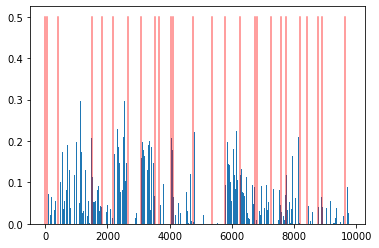

T_ACC =0.00753049599006772
T_BLCA =0.06129159405827522
T_BRCA =0.09145089238882065
T_CESC =0.08888575434684753
T_HBC =0.012098603881895542
T_COREAD =0.11133690178394318
T_DLBC =0.007986576296389103
T_GESCA =0.1345045566558838
T_GBM =0.0004742631281260401
T_HNSC =0.04253063723444939
T_KICH =0.22290602326393127
T_KC =0.04259995371103287
T_LAML =0.018112527206540108
T_LGG =0.0014482284896075726
T_LUAD =0.10782775282859802
T_LUSC =0.05149982124567032
T_MESO =0.0029583866707980633
T_GC =0.04938174784183502
T_PAAD =0.03974875062704086
T_PCPG =0.012136253528296947
T_PRAD =0.053979210555553436
T_SARC =0.0018446212634444237
T_SKCM =0.01093192957341671
T_TGCT =0.03202269226312637
T_THCA =0.011257924139499664
T_THYM =0.02892308123409748
8


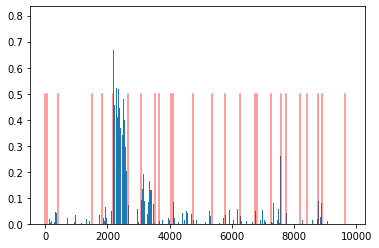

T_ACC =0.001005727332085371
T_BLCA =0.011546909809112549
T_BRCA =0.0032425469253212214
T_CESC =0.01109322253614664
T_HBC =0.013341444544494152
T_COREAD =0.4651438593864441
T_DLBC =0.01758895069360733
T_GESCA =0.08382529020309448
T_GBM =0.002006308175623417
T_HNSC =0.005071699153631926
T_KICH =0.00052365887677297
T_KC =0.016732461750507355
T_LAML =0.010604525916278362
T_LGG =0.004055596422404051
T_LUAD =0.010015716776251793
T_LUSC =0.0030227929819375277
T_MESO =0.0035453035961836576
T_GC =0.009200532920658588
T_PAAD =0.03310733288526535
T_PCPG =0.0005222454783506691
T_PRAD =0.004603846464306116
T_SARC =0.007467165589332581
T_SKCM =0.0048347641713917255
T_TGCT =0.06856532394886017
T_THCA =0.0010160106467083097
T_THYM =3.458803257672116e-05
9


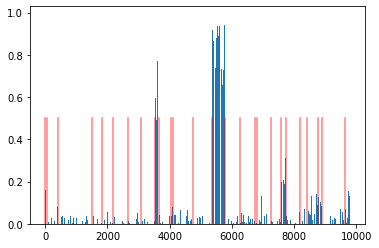

T_ACC =0.11110404133796692
T_BLCA =0.012663951143622398
T_BRCA =0.007977438159286976
T_CESC =0.005440674256533384
T_HBC =0.012266655452549458
T_COREAD =0.0026501526590436697
T_DLBC =0.01285648811608553
T_GESCA =0.006784096360206604
T_GBM =0.5987273454666138
T_HNSC =0.007133930455893278
T_KICH =0.054232582449913025
T_KC =0.024264095351099968
T_LAML =0.007719041313976049
T_LGG =0.8395649790763855
T_LUAD =0.007565703243017197
T_LUSC =0.011312882415950298
T_MESO =0.007615008857101202
T_GC =0.01702982187271118
T_PAAD =0.007564772851765156
T_PCPG =0.2586347758769989
T_PRAD =0.014504396356642246
T_SARC =0.07482285052537918
T_SKCM =0.062425397336483
T_TGCT =0.06420953571796417
T_THCA =0.01860545389354229
T_THYM =0.05263657867908478
10


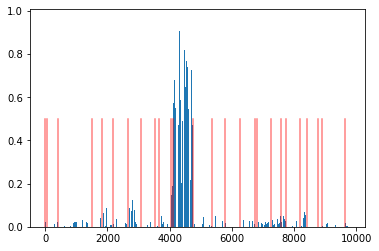

T_ACC =0.0172911137342453
T_BLCA =0.0033605617936700583
T_BRCA =0.0038225771859288216
T_CESC =0.006354566663503647
T_HBC =0.02257019840180874
T_COREAD =0.009133994579315186
T_DLBC =0.02248435840010643
T_GESCA =0.005907840095460415
T_GBM =0.006434527225792408
T_HNSC =0.003165840171277523
T_KICH =0.15797197818756104
T_KC =0.5498757362365723
T_LAML =0.017290757969021797
T_LGG =0.00652372557669878
T_LUAD =0.005750006064772606
T_LUSC =0.0031042415648698807
T_MESO =0.015121185220777988
T_GC =0.015642037615180016
T_PAAD =0.019346250221133232
T_PCPG =0.03175075352191925
T_PRAD =0.0029883794486522675
T_SARC =0.04444136843085289
T_SKCM =0.0011465459829196334
T_TGCT =0.01605483517050743
T_THCA =0.0033555037807673216
T_THYM =0.014070902019739151
11


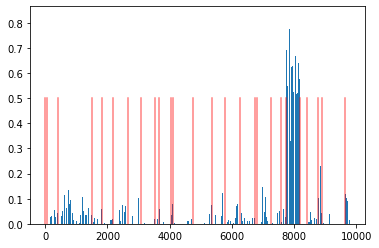

T_ACC =0.014865615405142307
T_BLCA =0.012840604409575462
T_BRCA =0.030496902763843536
T_CESC =0.01502503827214241
T_HBC =0.007686031516641378
T_COREAD =0.013623754493892193
T_DLBC =0.004679549485445023
T_GESCA =0.011211054399609566
T_GBM =0.009577070362865925
T_HNSC =0.007619645446538925
T_KICH =0.03659968078136444
T_KC =0.008759427815675735
T_LAML =0.006073071155697107
T_LGG =0.006807124242186546
T_LUAD =0.013476649299263954
T_LUSC =0.011935601010918617
T_MESO =0.0002608496288303286
T_GC =0.027564924210309982
T_PAAD =0.013147463090717793
T_PCPG =0.03615077584981918
T_PRAD =0.5543988347053528
T_SARC =0.010859083384275436
T_SKCM =0.008092057891190052
T_TGCT =0.05122465267777443
T_THCA =0.004382054787129164
T_THYM =0.06504133343696594
12


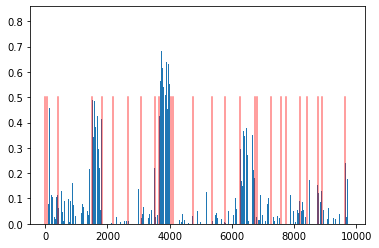

T_ACC =0.014357047155499458
T_BLCA =0.11008073389530182
T_BRCA =0.04272221401333809
T_CESC =0.291042685508728
T_HBC =0.0037070652469992638
T_COREAD =0.018610093742609024
T_DLBC =0.01438142266124487
T_GESCA =0.072227843105793
T_GBM =0.011168018914759159
T_HNSC =0.5248576402664185
T_KICH =0.0011545761954039335
T_KC =0.007478165905922651
T_LAML =0.0069938232190907
T_LGG =0.007796401623636484
T_LUAD =0.027093086391687393
T_LUSC =0.25855696201324463
T_MESO =0.034305986016988754
T_GC =0.02153974398970604
T_PAAD =0.013253739103674889
T_PCPG =6.029950782249216e-06
T_PRAD =0.016215402632951736
T_SARC =0.019105330109596252
T_SKCM =0.04334200918674469
T_TGCT =0.08518261462450027
T_THCA =0.012553584761917591
T_THYM =0.13202455639839172
13


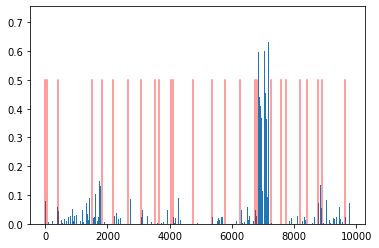

T_ACC =0.046748366206884384
T_BLCA =0.008582578040659428
T_BRCA =0.018928559496998787
T_CESC =0.030900605022907257
T_HBC =0.005593989975750446
T_COREAD =0.008160061202943325
T_DLBC =0.00498642772436142
T_GESCA =0.007028368767350912
T_GBM =0.012807718478143215
T_HNSC =0.008035508915781975
T_KICH =0.00936890859156847
T_KC =0.021133728325366974
T_LAML =0.0013494809390977025
T_LGG =0.006937351077795029
T_LUAD =0.01104019396007061
T_LUSC =0.009831457398831844
T_MESO =0.04959644004702568
T_GC =0.3532629609107971
T_PAAD =0.008588887751102448
T_PCPG =0.001591226551681757
T_PRAD =0.007628570310771465
T_SARC =0.017957447096705437
T_SKCM =0.003387217177078128
T_TGCT =0.05501968786120415
T_THCA =0.009879076853394508
T_THYM =0.00855646375566721
14


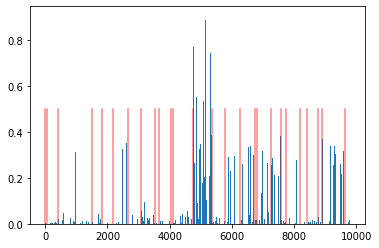

T_ACC =0.001970953308045864
T_BLCA =0.003021228825673461
T_BRCA =0.04709411412477493
T_CESC =0.026017306372523308
T_HBC =0.0028712302446365356
T_COREAD =0.010855644010007381
T_DLBC =0.006981487851589918
T_GESCA =0.04316103830933571
T_GBM =0.005720153450965881
T_HNSC =0.003610398154705763
T_KICH =0.004821131471544504
T_KC =0.014278946444392204
T_LAML =0.3778766691684723
T_LGG =0.008838250301778316
T_LUAD =0.06939723342657089
T_LUSC =0.06592164933681488
T_MESO =0.00808558240532875
T_GC =0.07743991166353226
T_PAAD =0.10685654729604721
T_PCPG =0.013751677237451077
T_PRAD =0.038982633501291275
T_SARC =0.0058968220837414265
T_SKCM =0.014827010221779346
T_TGCT =0.0034838770516216755
T_THCA =0.13397228717803955
T_THYM =0.0009140760521404445
15


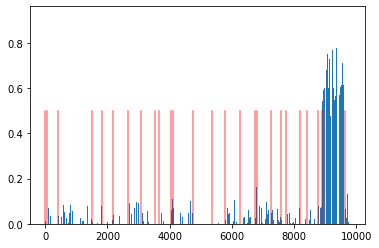

T_ACC =0.0522359274327755
T_BLCA =0.007675687782466412
T_BRCA =0.023953797295689583
T_CESC =0.006025837268680334
T_HBC =0.007831507362425327
T_COREAD =0.007565435487776995
T_DLBC =0.043548475950956345
T_GESCA =0.004327001050114632
T_GBM =0.0014515833463519812
T_HNSC =0.009159501641988754
T_KICH =0.12613113224506378
T_KC =0.033334437757730484
T_LAML =0.001384186209179461
T_LGG =0.018407654017210007
T_LUAD =0.03672746196389198
T_LUSC =0.01470785029232502
T_MESO =0.03891783580183983
T_GC =0.02745688334107399
T_PAAD =0.015857962891459465
T_PCPG =0.013464897871017456
T_PRAD =0.011993324384093285
T_SARC =0.014649461954832077
T_SKCM =0.011747834272682667
T_TGCT =0.035420555621385574
T_THCA =0.6402018666267395
T_THYM =0.11308181285858154
16


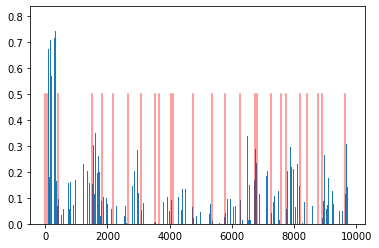

T_ACC =0.03695426508784294
T_BLCA =0.45981884002685547
T_BRCA =0.037755776196718216
T_CESC =0.189523845911026
T_HBC =0.02695847675204277
T_COREAD =0.026626553386449814
T_DLBC =0.056317321956157684
T_GESCA =0.02995523251593113
T_GBM =0.0014996097888797522
T_HNSC =0.06372684985399246
T_KICH =0.03377566859126091
T_KC =0.027870506048202515
T_LAML =0.013061417266726494
T_LGG =0.003164704190567136
T_LUAD =0.04652034491300583
T_LUSC =0.07502605020999908
T_MESO =0.20546147227287292
T_GC =0.04519430547952652
T_PAAD =0.05230400338768959
T_PCPG =0.0018041381845250726
T_PRAD =0.0909285917878151
T_SARC =0.059864576905965805
T_SKCM =0.0025840229354798794
T_TGCT =0.01334740687161684
T_THCA =0.03081989660859108
T_THYM =0.1749853789806366


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


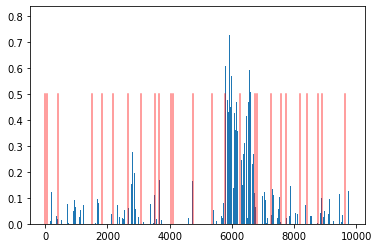

T_ACC =0.008511564694344997
T_BLCA =0.025860846042633057
T_BRCA =0.01887374185025692
T_CESC =0.014726034365594387
T_HBC =0.01909543015062809
T_COREAD =0.019995907321572304
T_DLBC =0.04247124120593071
T_GESCA =0.027835367247462273
T_GBM =0.017229311168193817
T_HNSC =0.016720106825232506
T_KICH =0.004545360337942839
T_KC =0.015378731302917004
T_LAML =0.002631979063153267
T_LGG =0.02442042902112007
T_LUAD =0.4690215289592743
T_LUSC =0.2667433023452759
T_MESO =0.09098890423774719
T_GC =0.0321895033121109
T_PAAD =0.05581219494342804
T_PCPG =0.007227515336126089
T_PRAD =0.03224111348390579
T_SARC =0.01766764186322689
T_SKCM =0.015843465924263
T_TGCT =0.09604600071907043
T_THCA =0.02707253396511078
T_THYM =0.008280117996037006
1


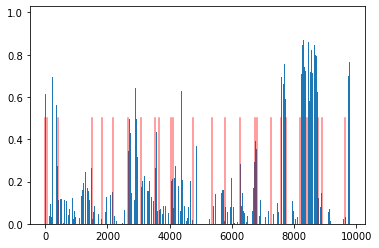

T_ACC =0.5010512471199036
T_BLCA =0.09636016190052032
T_BRCA =0.0905296728014946
T_CESC =0.08620806038379669
T_HBC =0.034286826848983765
T_COREAD =0.02106577157974243
T_DLBC =0.38843733072280884
T_GESCA =0.10374973714351654
T_GBM =0.23199346661567688
T_HNSC =0.0665268674492836
T_KICH =0.13106724619865417
T_KC =0.09535656124353409
T_LAML =0.017502300441265106
T_LGG =0.049488842487335205
T_LUAD =0.04044395312666893
T_LUSC =0.08114076405763626
T_MESO =0.41002780199050903
T_GC =0.0751730352640152
T_PAAD =0.045163121074438095
T_PCPG =0.6074792742729187
T_PRAD =0.021687641739845276
T_SARC =0.6606504321098328
T_SKCM =0.7395866513252258
T_TGCT =0.15296202898025513
T_THCA =0.009876626543700695
T_THYM =0.0432489849627018
2


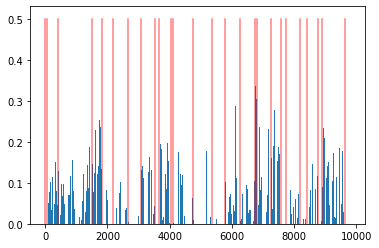

T_ACC =0.024942047894001007
T_BLCA =0.09653778374195099
T_BRCA =0.05377482622861862
T_CESC =0.11195190250873566
T_HBC =0.02668756991624832
T_COREAD =0.049578115344047546
T_DLBC =0.007049466948956251
T_GESCA =0.07518287748098373
T_GBM =0.002439232775941491
T_HNSC =0.08770623058080673
T_KICH =0.005367669742554426
T_KC =0.06858127564191818
T_LAML =0.006225114688277245
T_LGG =0.007440906949341297
T_LUAD =0.09057078510522842
T_LUSC =0.04481254145503044
T_MESO =0.25259920954704285
T_GC =0.07675790041685104
T_PAAD =0.16978669166564941
T_PCPG =0.006687978748232126
T_PRAD =0.02661900967359543
T_SARC =0.032635703682899475
T_SKCM =0.027034970000386238
T_TGCT =0.007016354240477085
T_THCA =0.08289667218923569
T_THYM =0.007746770977973938
3


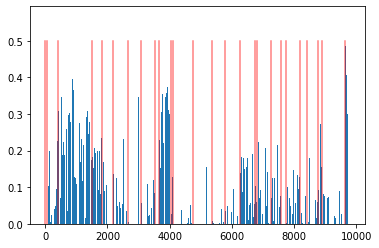

T_ACC =0.0028542650397866964
T_BLCA =0.09100845456123352
T_BRCA =0.21818022429943085
T_CESC =0.13293904066085815
T_HBC =0.018235765397548676
T_COREAD =0.05502577871084213
T_DLBC =0.02608310617506504
T_GESCA =0.05334100127220154
T_GBM =0.004461352247744799
T_HNSC =0.23426863551139832
T_KICH =0.041484665125608444
T_KC =0.017469454556703568
T_LAML =0.0110401576384902
T_LGG =0.007522363215684891
T_LUAD =0.03560776263475418
T_LUSC =0.1317838430404663
T_MESO =0.0696270763874054
T_GC =0.06935413181781769
T_PAAD =0.05196353420615196
T_PCPG =0.0026377816684544086
T_PRAD =0.07417044788599014
T_SARC =0.036096327006816864
T_SKCM =0.04791391268372536
T_TGCT =0.15518684685230255
T_THCA =0.03371531888842583
T_THYM =0.30159032344818115
4


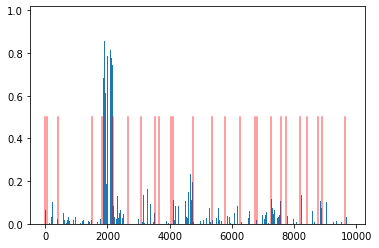

T_ACC =0.15454259514808655
T_BLCA =0.011126585304737091
T_BRCA =0.010664092376828194
T_CESC =0.003993096761405468
T_HBC =0.7238306403160095
T_COREAD =0.040816981345415115
T_DLBC =0.007179511711001396
T_GESCA =0.028741763904690742
T_GBM =0.007079670205712318
T_HNSC =0.005579797085374594
T_KICH =0.018191834911704063
T_KC =0.058351024985313416
T_LAML =0.011031507514417171
T_LGG =0.009216587990522385
T_LUAD =0.015040356665849686
T_LUSC =0.006976305972784758
T_MESO =0.02145201526582241
T_GC =0.011336218565702438
T_PAAD =0.05045953392982483
T_PCPG =0.00848970003426075
T_PRAD =0.01617436669766903
T_SARC =0.012855425477027893
T_SKCM =0.011190097779035568
T_TGCT =0.06329361349344254
T_THCA =0.0029550103936344385
T_THYM =0.010833740234375
5


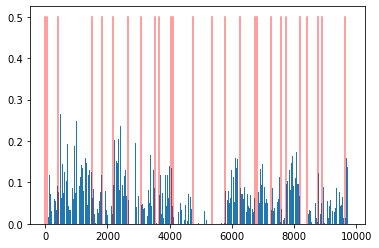

T_ACC =0.0017915185308083892
T_BLCA =0.07388734072446823
T_BRCA =0.11384817957878113
T_CESC =0.06281423568725586
T_HBC =0.02982315607368946
T_COREAD =0.12289763987064362
T_DLBC =0.020888982340693474
T_GESCA =0.0710236057639122
T_GBM =0.002006052527576685
T_HNSC =0.0625419020652771
T_KICH =0.11419562250375748
T_KC =0.029663771390914917
T_LAML =0.0016933637671172619
T_LGG =0.001965644070878625
T_LUAD =0.07678757607936859
T_LUSC =0.05944563448429108
T_MESO =0.00484378170222044
T_GC =0.07887125760316849
T_PAAD =0.0721634030342102
T_PCPG =0.010457674041390419
T_PRAD =0.13190583884716034
T_SARC =0.004033463075757027
T_SKCM =0.015662342309951782
T_TGCT =0.1351664811372757
T_THCA =0.03454798832535744
T_THYM =0.10265044122934341
6


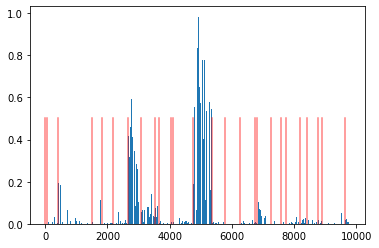

T_ACC =0.00339149939827621
T_BLCA =0.0023660920560359955
T_BRCA =0.01214643195271492
T_CESC =0.004774835892021656
T_HBC =0.0024300895165652037
T_COREAD =0.012784305959939957
T_DLBC =0.3136802613735199
T_GESCA =0.05128425359725952
T_GBM =0.07076697051525116
T_HNSC =0.002607177011668682
T_KICH =0.0003959896566811949
T_KC =0.004853543825447559
T_LAML =0.5070198774337769
T_LGG =0.002445872873067856
T_LUAD =0.0019652151968330145
T_LUSC =0.0029169719200581312
T_MESO =0.003232201561331749
T_GC =0.0510832704603672
T_PAAD =0.015245366841554642
T_PCPG =0.0028004785999655724
T_PRAD =0.008507911115884781
T_SARC =0.008100730367004871
T_SKCM =0.0059678154066205025
T_TGCT =0.006620442494750023
T_THCA =0.013339933939278126
T_THYM =0.01923404447734356
7


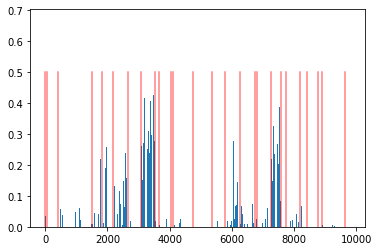

T_ACC =0.01397304330021143
T_BLCA =0.012060302309691906
T_BRCA =0.005796241573989391
T_CESC =0.041776470839977264
T_HBC =0.04230612516403198
T_COREAD =0.05903226509690285
T_DLBC =0.014577810652554035
T_GESCA =0.2681174576282501
T_GBM =0.0054303128272295
T_HNSC =0.011658819392323494
T_KICH =0.004333142656832933
T_KC =0.012769686058163643
T_LAML =0.001898459275253117
T_LGG =0.002232639817520976
T_LUAD =0.04573305323719978
T_LUSC =0.013549056835472584
T_MESO =0.002171811880543828
T_GC =0.019319504499435425
T_PAAD =0.2731923460960388
T_PCPG =0.0017085860017687082
T_PRAD =0.006722781341522932
T_SARC =0.006749860011041164
T_SKCM =0.0005977798718959093
T_TGCT =0.010474286042153835
T_THCA =0.0009513956611044705
T_THYM =0.0015386170707643032
8


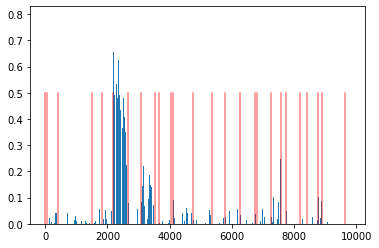

T_ACC =0.0010453573195263743
T_BLCA =0.011102448217570782
T_BRCA =0.0036778191570192575
T_CESC =0.012581201270222664
T_HBC =0.013019025325775146
T_COREAD =0.49828600883483887
T_DLBC =0.016478078439831734
T_GESCA =0.08624090254306793
T_GBM =0.001793361734598875
T_HNSC =0.0046296557411551476
T_KICH =0.00046870505320839584
T_KC =0.01606639288365841
T_LAML =0.011653268709778786
T_LGG =0.0033749323338270187
T_LUAD =0.009389662183821201
T_LUSC =0.0028879567980766296
T_MESO =0.003042871132493019
T_GC =0.009675177745521069
T_PAAD =0.04361153393983841
T_PCPG =0.0004863856884185225
T_PRAD =0.005011162254959345
T_SARC =0.006717953365296125
T_SKCM =0.004852221347391605
T_TGCT =0.07245262712240219
T_THCA =0.0008092284551821649
T_THYM =0.0
9


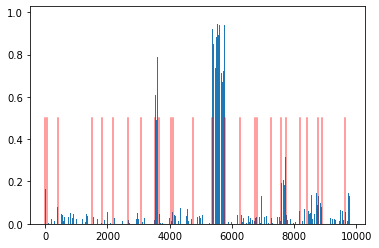

T_ACC =0.11177681386470795
T_BLCA =0.011008535511791706
T_BRCA =0.010934850201010704
T_CESC =0.004513239022344351
T_HBC =0.012577498331665993
T_COREAD =0.002513780491426587
T_DLBC =0.013046286068856716
T_GESCA =0.0068354420363903046
T_GBM =0.6015373468399048
T_HNSC =0.006203170865774155
T_KICH =0.03381403535604477
T_KC =0.024976832792162895
T_LAML =0.007930424995720387
T_LGG =0.8350789546966553
T_LUAD =0.00698633911088109
T_LUSC =0.009255172684788704
T_MESO =0.018541835248470306
T_GC =0.016473431140184402
T_PAAD =0.0114382179453969
T_PCPG =0.2591311037540436
T_PRAD =0.01615636609494686
T_SARC =0.07762295007705688
T_SKCM =0.06302443891763687
T_TGCT =0.060545627027750015
T_THCA =0.01669880375266075
T_THYM =0.043990593403577805
10


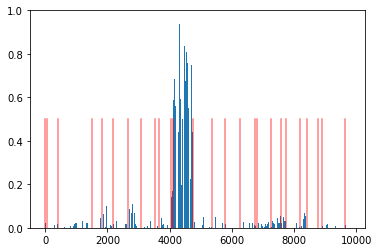

T_ACC =0.016262749210000038
T_BLCA =0.0032967866864055395
T_BRCA =0.00426864018663764
T_CESC =0.007049924228340387
T_HBC =0.024386340752243996
T_COREAD =0.009730431251227856
T_DLBC =0.020784806460142136
T_GESCA =0.007398935034871101
T_GBM =0.005879553966224194
T_HNSC =0.0029601810965687037
T_KICH =0.15482616424560547
T_KC =0.5475066900253296
T_LAML =0.017323771491646767
T_LGG =0.006299261469393969
T_LUAD =0.005341262556612492
T_LUSC =0.0026708650402724743
T_MESO =0.021213717758655548
T_GC =0.01575636677443981
T_PAAD =0.025396954268217087
T_PCPG =0.030302146449685097
T_PRAD =0.003491136711090803
T_SARC =0.043631263077259064
T_SKCM =0.0009981993352994323
T_TGCT =0.014813009649515152
T_THCA =0.0030449707992374897
T_THYM =0.010726193897426128
11


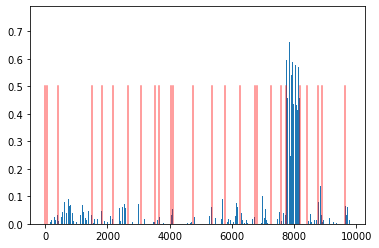

T_ACC =0.01268099993467331
T_BLCA =0.007632103282958269
T_BRCA =0.023195238783955574
T_CESC =0.012170749716460705
T_HBC =0.006375160533934832
T_COREAD =0.012791152112185955
T_DLBC =0.002475318033248186
T_GESCA =0.012680231593549252
T_GBM =0.006570063065737486
T_HNSC =0.005221823696047068
T_KICH =0.031497858464717865
T_KC =0.006810493301600218
T_LAML =0.005945856217294931
T_LGG =0.005040322430431843
T_LUAD =0.010707109235227108
T_LUSC =0.006667602341622114
T_MESO =0.0015515225240960717
T_GC =0.01797991618514061
T_PAAD =0.008442820981144905
T_PCPG =0.026146795600652695
T_PRAD =0.4732692837715149
T_SARC =0.007440784480422735
T_SKCM =0.006337017752230167
T_TGCT =0.031068269163370132
T_THCA =0.003404976101592183
T_THYM =0.03599534556269646
12


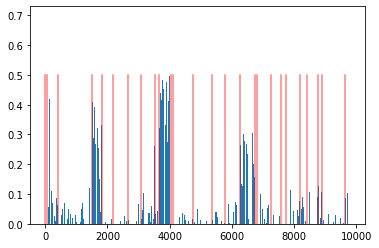

T_ACC =0.016037754714488983
T_BLCA =0.08984953165054321
T_BRCA =0.019250767305493355
T_CESC =0.2486242949962616
T_HBC =0.0034664799459278584
T_COREAD =0.016662761569023132
T_DLBC =0.010015629231929779
T_GESCA =0.07448019832372665
T_GBM =0.012943083420395851
T_HNSC =0.42156627774238586
T_KICH =0.0005866918945685029
T_KC =0.005516321398317814
T_LAML =0.005771800875663757
T_LGG =0.007218760903924704
T_LUAD =0.01916280947625637
T_LUSC =0.21081538498401642
T_MESO =0.007046045735478401
T_GC =0.017499012872576714
T_PAAD =0.01112106442451477
T_PCPG =3.2871805160539225e-05
T_PRAD =0.012204072438180447
T_SARC =0.013995512388646603
T_SKCM =0.02627664804458618
T_TGCT =0.07150790095329285
T_THCA =0.004352277610450983
T_THYM =0.06539438664913177
13


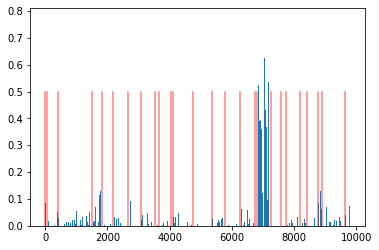

T_ACC =0.04651277884840965
T_BLCA =0.006291619967669249
T_BRCA =0.014802912250161171
T_CESC =0.027542047202587128
T_HBC =0.005200594197958708
T_COREAD =0.007106792647391558
T_DLBC =0.00566930091008544
T_GESCA =0.011542516760528088
T_GBM =0.013813133351504803
T_HNSC =0.005246301647275686
T_KICH =0.011864705011248589
T_KC =0.01500179897993803
T_LAML =0.0013677384704351425
T_LGG =0.0070014153607189655
T_LUAD =0.008342642337083817
T_LUSC =0.009277595207095146
T_MESO =0.017069116234779358
T_GC =0.34102973341941833
T_PAAD =0.006065611727535725
T_PCPG =0.0017990139313042164
T_PRAD =0.008877299726009369
T_SARC =0.014920495450496674
T_SKCM =0.0032919689547270536
T_TGCT =0.06021354719996452
T_THCA =0.009923586621880531
T_THYM =0.012952223420143127
14


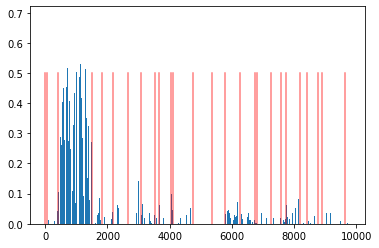

T_ACC =0.0006744267884641886
T_BLCA =0.011495298705995083
T_BRCA =0.30636340379714966
T_CESC =0.021419737488031387
T_HBC =0.006686472333967686
T_COREAD =0.011483490467071533
T_DLBC =0.0036800128873437643
T_GESCA =0.02055586874485016
T_GBM =0.008390350267291069
T_HNSC =0.010229663923382759
T_KICH =0.08305563032627106
T_KC =0.010130973532795906
T_LAML =0.0009442783193662763
T_LGG =0.0024695813190191984
T_LUAD =0.024400150403380394
T_LUSC =0.010512517765164375
T_MESO =0.004927850794047117
T_GC =0.020202461630105972
T_PAAD =0.004011786077171564
T_PCPG =0.006111864931881428
T_PRAD =0.02908330410718918
T_SARC =0.0034897534642368555
T_SKCM =0.0049879420548677444
T_TGCT =0.002219635294750333
T_THCA =0.0036904022563248873
T_THYM =0.01525343768298626
15


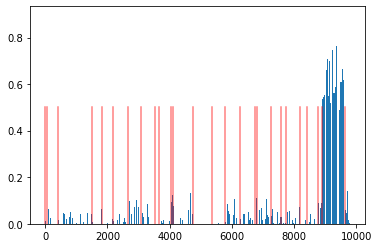

T_ACC =0.04851694032549858
T_BLCA =0.006483359262347221
T_BRCA =0.01947624608874321
T_CESC =0.005023085977882147
T_HBC =0.008366333320736885
T_COREAD =0.00979249831289053
T_DLBC =0.04512811452150345
T_GESCA =0.00826406478881836
T_GBM =0.0012916210107505322
T_HNSC =0.007790292147547007
T_KICH =0.15905015170574188
T_KC =0.032250531017780304
T_LAML =0.0015423782169818878
T_LGG =0.017405830323696136
T_LUAD =0.035091329365968704
T_LUSC =0.0144070815294981
T_MESO =0.017680270597338676
T_GC =0.02594141662120819
T_PAAD =0.013082177378237247
T_PCPG =0.015135271474719048
T_PRAD =0.013079526834189892
T_SARC =0.013272859156131744
T_SKCM =0.011211423203349113
T_TGCT =0.04846562445163727
T_THCA =0.6175029873847961
T_THYM =0.1168949231505394
16


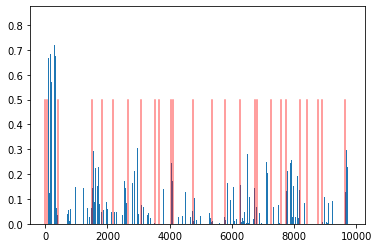

T_ACC =0.03313592076301575
T_BLCA =0.4405733346939087
T_BRCA =0.029543444514274597
T_CESC =0.17686064541339874
T_HBC =0.02066316269338131
T_COREAD =0.03951591998338699
T_DLBC =0.05652362108230591
T_GESCA =0.04833676666021347
T_GBM =0.0010604890994727612
T_HNSC =0.04593897983431816
T_KICH =0.200381338596344
T_KC =0.026180684566497803
T_LAML =0.01977573148906231
T_LGG =0.0033888956531882286
T_LUAD =0.04704774543642998
T_LUSC =0.07076059281826019
T_MESO =0.04408974573016167
T_GC =0.04626556485891342
T_PAAD =0.028333526104688644
T_PCPG =0.0011504533467814326
T_PRAD =0.07965701073408127
T_SARC =0.03520168364048004
T_SKCM =0.0017909285379573703
T_TGCT =0.009822401218116283
T_THCA =0.011102520860731602
T_THYM =0.2030133455991745
17


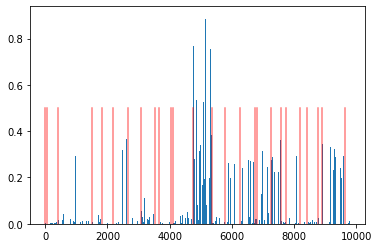

T_ACC =0.002298525534570217
T_BLCA =0.003059398615732789
T_BRCA =0.04467327147722244
T_CESC =0.02503138966858387
T_HBC =0.0025633296463638544
T_COREAD =0.010920400731265545
T_DLBC =0.005831127054989338
T_GESCA =0.0443890318274498
T_GBM =0.005314579699188471
T_HNSC =0.0026041357778012753
T_KICH =0.004873198922723532
T_KC =0.013135245069861412
T_LAML =0.3687019944190979
T_LGG =0.007988706231117249
T_LUAD =0.058360710740089417
T_LUSC =0.0553768090903759
T_MESO =0.00989418476819992
T_GC =0.0750921219587326
T_PAAD =0.11471013724803925
T_PCPG =0.012215133756399155
T_PRAD =0.041141755878925323
T_SARC =0.004917146172374487
T_SKCM =0.013432135805487633
T_TGCT =0.002125270664691925
T_THCA =0.1241147369146347
T_THYM =0.0006564911454916


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


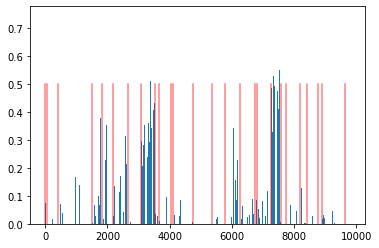

T_ACC =0.03108728863298893
T_BLCA =0.02305680885910988
T_BRCA =0.010467051528394222
T_CESC =0.06626040488481522
T_HBC =0.06401485204696655
T_COREAD =0.07601716369390488
T_DLBC =0.02442961372435093
T_GESCA =0.3057197630405426
T_GBM =0.01325235702097416
T_HNSC =0.022408613935112953
T_KICH =0.006131378002464771
T_KC =0.03541591763496399
T_LAML =0.0029689993243664503
T_LGG =0.004985688719898462
T_LUAD =0.07155602425336838
T_LUSC =0.023445606231689453
T_MESO =0.020813947543501854
T_GC =0.036972157657146454
T_PAAD =0.4587896764278412
T_PCPG =0.005528801586478949
T_PRAD =0.007929314859211445
T_SARC =0.015589484013617039
T_SKCM =0.0028517271857708693
T_TGCT =0.024433931335806847
T_THCA =0.004340383689850569
T_THYM =0.002070758491754532
1


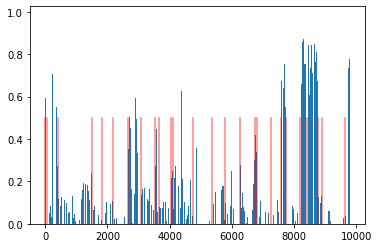

T_ACC =0.47868984937667847
T_BLCA =0.09510510414838791
T_BRCA =0.08474595844745636
T_CESC =0.08035725355148315
T_HBC =0.028458040207624435
T_COREAD =0.01592724770307541
T_DLBC =0.3951447606086731
T_GESCA =0.08372614532709122
T_GBM =0.2385314702987671
T_HNSC =0.0711417868733406
T_KICH =0.15473000705242157
T_KC =0.10044164955615997
T_LAML =0.015227977186441422
T_LGG =0.054034218192100525
T_LUAD =0.036527130752801895
T_LUSC =0.08794047683477402
T_MESO =0.42821162939071655
T_GC =0.07566483318805695
T_PAAD =0.043251533061265945
T_PCPG =0.5939573645591736
T_PRAD =0.020135777071118355
T_SARC =0.6723019480705261
T_SKCM =0.746239423751831
T_TGCT =0.15628543496131897
T_THCA =0.00904938019812107
T_THYM =0.04556904733181
2


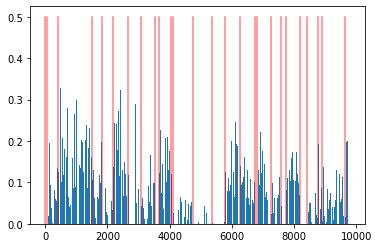

T_ACC =0.002217316534370184
T_BLCA =0.10672184079885483
T_BRCA =0.16146329045295715
T_CESC =0.101400226354599
T_HBC =0.03346853330731392
T_COREAD =0.17092527449131012
T_DLBC =0.032548483461141586
T_GESCA =0.07568667829036713
T_GBM =0.0015740296803414822
T_HNSC =0.11838836222887039
T_KICH =0.08545254170894623
T_KC =0.03395606577396393
T_LAML =0.002340028528124094
T_LGG =0.002134680049493909
T_LUAD =0.11053059250116348
T_LUSC =0.10027576982975006
T_MESO =0.01016958151012659
T_GC =0.11449509859085083
T_PAAD =0.07997101545333862
T_PCPG =0.0055219512432813644
T_PRAD =0.1460087150335312
T_SARC =0.005087682977318764
T_SKCM =0.023035848513245583
T_TGCT =0.20577095448970795
T_THCA =0.05265624076128006
T_THYM =0.14165790379047394
3


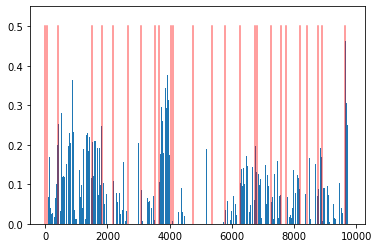

T_ACC =0.004368650261312723
T_BLCA =0.08702012151479721
T_BRCA =0.14246602356433868
T_CESC =0.12462736666202545
T_HBC =0.012515122070908546
T_COREAD =0.051284730434417725
T_DLBC =0.012846379540860653
T_GESCA =0.04549530893564224
T_GBM =0.003063917625695467
T_HNSC =0.19818252325057983
T_KICH =0.004765597637742758
T_KC =0.01582629419863224
T_LAML =0.009072479791939259
T_LGG =0.0074307117611169815
T_LUAD =0.044613514095544815
T_LUSC =0.10829674452543259
T_MESO =0.1409139186143875
T_GC =0.07368425279855728
T_PAAD =0.04829297587275505
T_PCPG =0.003959989175200462
T_PRAD =0.06500522792339325
T_SARC =0.03313427418470383
T_SKCM =0.04883117601275444
T_TGCT =0.1124030277132988
T_THCA =0.04265042021870613
T_THYM =0.24324005842208862
4


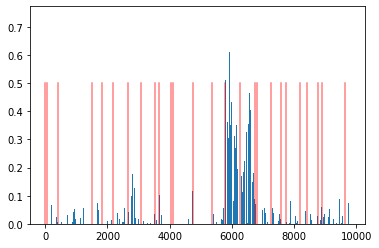

T_ACC =0.004874085541814566
T_BLCA =0.014990189112722874
T_BRCA =0.011584562249481678
T_CESC =0.008945279754698277
T_HBC =0.008559404872357845
T_COREAD =0.010889243334531784
T_DLBC =0.023929376155138016
T_GESCA =0.016042906790971756
T_GBM =0.010647405870258808
T_HNSC =0.010840905830264091
T_KICH =0.0037734832148998976
T_KC =0.009524702094495296
T_LAML =0.0013856675941497087
T_LGG =0.017041677609086037
T_LUAD =0.36281442642211914
T_LUSC =0.19692106544971466
T_MESO =0.08193323016166687
T_GC =0.016931910067796707
T_PAAD =0.017638277262449265
T_PCPG =0.003452327335253358
T_PRAD =0.018139490857720375
T_SARC =0.010295671410858631
T_SKCM =0.010009675286710262
T_TGCT =0.05456169322133064
T_THCA =0.018391847610473633
T_THYM =0.006012436002492905
5


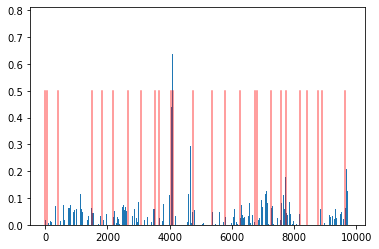

T_ACC =0.02684192731976509
T_BLCA =0.01784611865878105
T_BRCA =0.03867337480187416
T_CESC =0.016904935240745544
T_HBC =0.010458327829837799
T_COREAD =0.025413962081074715
T_DLBC =0.009969866834580898
T_GESCA =0.014765111729502678
T_GBM =0.0007724203169345856
T_HNSC =0.015384024009108543
T_KICH =0.5086513161659241
T_KC =0.05529389902949333
T_LAML =0.021944107487797737
T_LGG =0.006049065385013819
T_LUAD =0.021746015176177025
T_LUSC =0.019077640026807785
T_MESO =0.0006395541713573039
T_GC =0.042736753821372986
T_PAAD =0.019673382863402367
T_PCPG =0.08490479737520218
T_PRAD =0.029771460220217705
T_SARC =0.00727301649749279
T_SKCM =0.00141076126601547
T_TGCT =0.005196616053581238
T_THCA =0.02150905504822731
T_THYM =0.10111667215824127
6


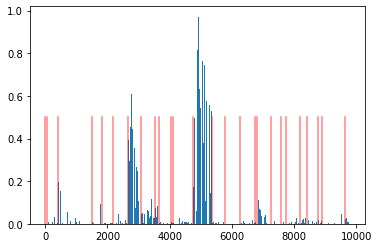

T_ACC =0.003735058242455125
T_BLCA =0.0021167476661503315
T_BRCA =0.011241966858506203
T_CESC =0.004143139813095331
T_HBC =0.001883244956843555
T_COREAD =0.010972580872476101
T_DLBC =0.3019784688949585
T_GESCA =0.0420389398932457
T_GBM =0.0702609121799469
T_HNSC =0.002736125374212861
T_KICH =0.0008209338993765414
T_KC =0.00404842896386981
T_LAML =0.4876880645751953
T_LGG =0.002315750578418374
T_LUAD =0.0015085511840879917
T_LUSC =0.0030939429998397827
T_MESO =0.0022763055749237537
T_GC =0.05043843016028404
T_PAAD =0.011923406273126602
T_PCPG =0.0030911711510270834
T_PRAD =0.0073301782831549644
T_SARC =0.00807938165962696
T_SKCM =0.005955236032605171
T_TGCT =0.00659915991127491
T_THCA =0.011582717299461365
T_THYM =0.02016722410917282
7


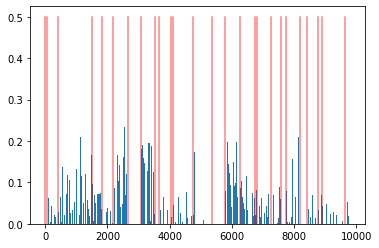

T_ACC =0.004084824118763208
T_BLCA =0.044642139226198196
T_BRCA =0.06729145348072052
T_CESC =0.07915470004081726
T_HBC =0.010720247402787209
T_COREAD =0.09035521000623703
T_DLBC =0.006650563329458237
T_GESCA =0.12690652906894684
T_GBM =0.00032426140387542546
T_HNSC =0.031800661236047745
T_KICH =0.024797474965453148
T_KC =0.03204071521759033
T_LAML =0.01168095599859953
T_LGG =0.0014625068288296461
T_LUAD =0.10253214836120605
T_LUSC =0.03923042491078377
T_MESO =0.020629622042179108
T_GC =0.04436754435300827
T_PAAD =0.040828149765729904
T_PCPG =0.0012942287139594555
T_PRAD =0.03738979622721672
T_SARC =0.0021264911629259586
T_SKCM =0.009930278174579144
T_TGCT =0.024541018530726433
T_THCA =0.009023429825901985
T_THYM =0.016669224947690964
8


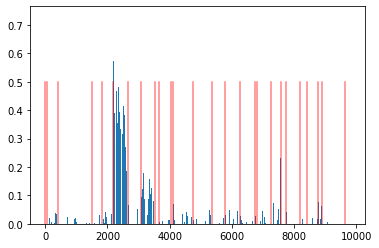

T_ACC =0.0009650384308770299
T_BLCA =0.009327244944870472
T_BRCA =0.002645087195560336
T_CESC =0.01019203756004572
T_HBC =0.009871735237538815
T_COREAD =0.4171201288700104
T_DLBC =0.015808796510100365
T_GESCA =0.08001153916120529
T_GBM =0.0017528495518490672
T_HNSC =0.004181345924735069
T_KICH =0.00081922288518399
T_KC =0.012693230994045734
T_LAML =0.010958528146147728
T_LGG =0.003396078944206238
T_LUAD =0.009318104945123196
T_LUSC =0.0028140691574662924
T_MESO =0.002200953895226121
T_GC =0.00786824431270361
T_PAAD =0.028786523267626762
T_PCPG =0.0003805537708103657
T_PRAD =0.0040483493357896805
T_SARC =0.006326829548925161
T_SKCM =0.004261794034391642
T_TGCT =0.05791078507900238
T_THCA =0.0006354230572469532
T_THYM =4.5662040065508336e-05
9


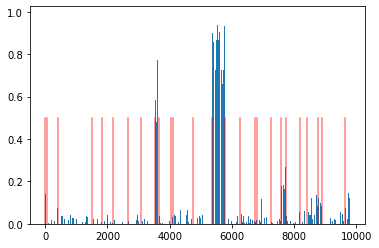

T_ACC =0.09674239158630371
T_BLCA =0.009935841895639896
T_BRCA =0.008249800652265549
T_CESC =0.004468659870326519
T_HBC =0.009579073637723923
T_COREAD =0.0021597379818558693
T_DLBC =0.011238865554332733
T_GESCA =0.006107802968472242
T_GBM =0.5892561078071594
T_HNSC =0.00562411081045866
T_KICH =0.021336643025279045
T_KC =0.022277625277638435
T_LAML =0.007249883841723204
T_LGG =0.8269197940826416
T_LUAD =0.00717129185795784
T_LUSC =0.009206860326230526
T_MESO =0.009897096082568169
T_GC =0.014538045041263103
T_PAAD =0.006562188733369112
T_PCPG =0.23312632739543915
T_PRAD =0.01513980608433485
T_SARC =0.06960220634937286
T_SKCM =0.0575481578707695
T_TGCT =0.06012142449617386
T_THCA =0.014693656004965305
T_THYM =0.048152998089790344
10


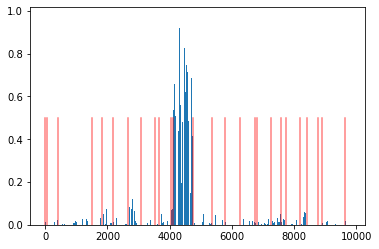

T_ACC =0.012330565601587296
T_BLCA =0.0027772183530032635
T_BRCA =0.0030532660894095898
T_CESC =0.00566625501960516
T_HBC =0.018325814977288246
T_COREAD =0.007855365984141827
T_DLBC =0.019763823598623276
T_GESCA =0.005571330431848764
T_GBM =0.006313230376690626
T_HNSC =0.0029600486159324646
T_KICH =0.07585355639457703
T_KC =0.513894259929657
T_LAML =0.01562584936618805
T_LGG =0.006749827414751053
T_LUAD =0.00501073244959116
T_LUSC =0.0026175794191658497
T_MESO =0.020951783284544945
T_GC =0.01097053661942482
T_PAAD =0.016362156718969345
T_PCPG =0.01747099496424198
T_PRAD =0.002508911769837141
T_SARC =0.04078679159283638
T_SKCM =0.0009012873051688075
T_TGCT =0.01477125659584999
T_THCA =0.002735430607572198
T_THYM =0.007651372812688351
11


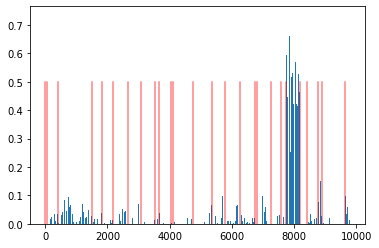

T_ACC =0.011101728305220604
T_BLCA =0.00871051475405693
T_BRCA =0.022283978760242462
T_CESC =0.01069993618875742
T_HBC =0.004526914097368717
T_COREAD =0.009273597039282322
T_DLBC =0.0032418856862932444
T_GESCA =0.007890348322689533
T_GBM =0.007417774293571711
T_HNSC =0.005537528079003096
T_KICH =0.00736137293279171
T_KC =0.0057090455666184425
T_LAML =0.004615664482116699
T_LGG =0.0050902822986245155
T_LUAD =0.010045758448541164
T_LUSC =0.009007039479911327
T_MESO =0.00029528947197832167
T_GC =0.01681584306061268
T_PAAD =0.007741321809589863
T_PCPG =0.016359712928533554
T_PRAD =0.45231667160987854
T_SARC =0.007940761744976044
T_SKCM =0.006582743488252163
T_TGCT =0.036969590932130814
T_THCA =0.002565238391980529
T_THYM =0.04041263088583946
12


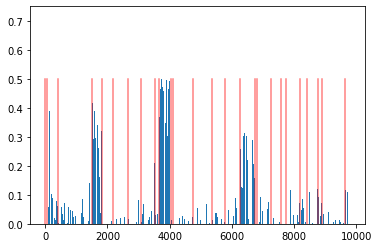

T_ACC =0.013307543471455574
T_BLCA =0.08644334226846695
T_BRCA =0.022319447249174118
T_CESC =0.24298082292079926
T_HBC =0.002628141548484564
T_COREAD =0.015265853144228458
T_DLBC =0.011025428771972656
T_GESCA =0.06228481978178024
T_GBM =0.0115648303180933
T_HNSC =0.4274274706840515
T_KICH =0.0021356733050197363
T_KC =0.00570669723674655
T_LAML =0.0060103656724095345
T_LGG =0.006538813002407551
T_LUAD =0.020094890147447586
T_LUSC =0.2198237180709839
T_MESO =0.010702855885028839
T_GC =0.015230083838105202
T_PAAD =0.009323212318122387
T_PCPG =0.0
T_PRAD =0.010635830461978912
T_SARC =0.014637332409620285
T_SKCM =0.028704555705189705
T_TGCT =0.05985894054174423
T_THCA =0.005581793375313282
T_THYM =0.07269729673862457
13


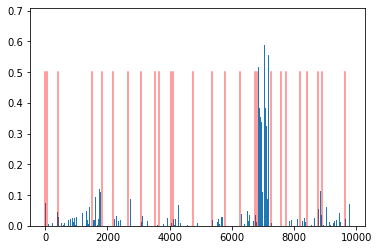

T_ACC =0.04262826591730118
T_BLCA =0.006299304775893688
T_BRCA =0.012810499407351017
T_CESC =0.024094488471746445
T_HBC =0.004047516267746687
T_COREAD =0.0061486391350626945
T_DLBC =0.004991037305444479
T_GESCA =0.004750740714371204
T_GBM =0.013483837246894836
T_HNSC =0.0058077373541891575
T_KICH =0.01833033375442028
T_KC =0.017052752897143364
T_LAML =0.0014972371282055974
T_LGG =0.006969464011490345
T_LUAD =0.008466952480375767
T_LUSC =0.008546794764697552
T_MESO =0.03669770807027817
T_GC =0.30978184938430786
T_PAAD =0.007686017546802759
T_PCPG =0.0013343293685466051
T_PRAD =0.006578796077519655
T_SARC =0.016481392085552216
T_SKCM =0.0032517542131245136
T_TGCT =0.041024092584848404
T_THCA =0.007741936948150396
T_THYM =0.0067848097532987595
14


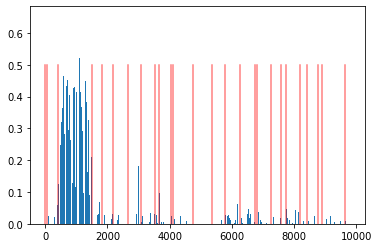

T_ACC =0.00027736229822039604
T_BLCA =0.010752740316092968
T_BRCA =0.29741039872169495
T_CESC =0.015476405620574951
T_HBC =0.004669445101171732
T_COREAD =0.005597049370408058
T_DLBC =0.005877614486962557
T_GESCA =0.010389063507318497
T_GBM =0.01395461056381464
T_HNSC =0.01112004742026329
T_KICH =0.008004279807209969
T_KC =0.003625578014180064
T_LAML =0.0007621775730513036
T_LGG =0.004064673557877541
T_LUAD =0.01589673012495041
T_LUSC =0.011911273002624512
T_MESO =0.0025603261310607195
T_GC =0.01657678373157978
T_PAAD =0.0025838916189968586
T_PCPG =0.0015516240382567048
T_PRAD =0.022107122465968132
T_SARC =0.004789131693542004
T_SKCM =0.006369945593178272
T_TGCT =0.0037024416960775852
T_THCA =0.0026261291932314634
T_THYM =0.01639675348997116
15


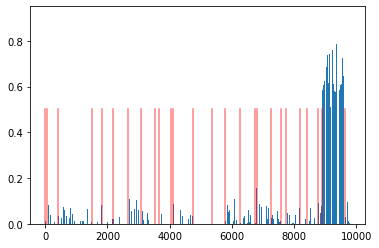

T_ACC =0.047279831022024155
T_BLCA =0.008238382637500763
T_BRCA =0.021530048921704292
T_CESC =0.0059732249937951565
T_HBC =0.006225299090147018
T_COREAD =0.006457940209656954
T_DLBC =0.04995601251721382
T_GESCA =0.004510761238634586
T_GBM =0.001663378905504942
T_HNSC =0.007709540892392397
T_KICH =0.024743329733610153
T_KC =0.02580767497420311
T_LAML =0.0012747793225571513
T_LGG =0.020507602021098137
T_LUAD =0.03953429311513901
T_LUSC =0.014980504289269447
T_MESO =0.03511407971382141
T_GC =0.027127109467983246
T_PAAD =0.014186044223606586
T_PCPG =0.007252764422446489
T_PRAD =0.01139412447810173
T_SARC =0.015527131035923958
T_SKCM =0.013311516493558884
T_TGCT =0.042049162089824677
T_THCA =0.6528323292732239
T_THYM =0.09115640074014664
16


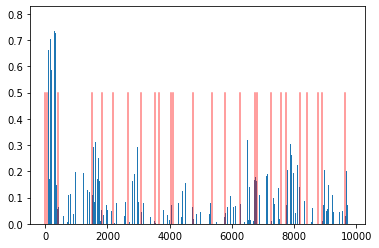

T_ACC =0.032241061329841614
T_BLCA =0.45097723603248596
T_BRCA =0.026935497298836708
T_CESC =0.17033736407756805
T_HBC =0.02083890698850155
T_COREAD =0.023267949000000954
T_DLBC =0.05603408440947533
T_GESCA =0.02818341553211212
T_GBM =0.001405400806106627
T_HNSC =0.049288615584373474
T_KICH =0.021682187914848328
T_KC =0.023102320730686188
T_LAML =0.011293256655335426
T_LGG =0.00318073108792305
T_LUAD =0.043172094970941544
T_LUSC =0.06968363374471664
T_MESO =0.1489882469177246
T_GC =0.04045034199953079
T_PAAD =0.04963313043117523
T_PCPG =0.00156021723523736
T_PRAD =0.08602312207221985
T_SARC =0.049400415271520615
T_SKCM =0.0022569787688553333
T_TGCT =0.010923538357019424
T_THCA =0.0219789557158947
T_THYM =0.12705230712890625
17


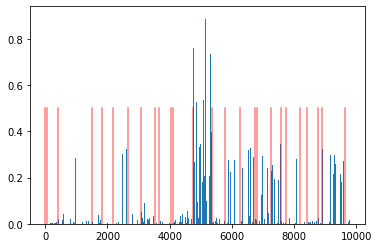

T_ACC =0.0012823512079194188
T_BLCA =0.0025870532263070345
T_BRCA =0.04348040744662285
T_CESC =0.02390897274017334
T_HBC =0.0020490800961852074
T_COREAD =0.009829346090555191
T_DLBC =0.00670479005202651
T_GESCA =0.03991758078336716
T_GBM =0.0058067659847438335
T_HNSC =0.0031428763177245855
T_KICH =0.0018576859729364514
T_KC =0.013902495615184307
T_LAML =0.37441644072532654
T_LGG =0.008633576333522797
T_LUAD =0.06687898188829422
T_LUSC =0.06297937780618668
T_MESO =0.00845500361174345
T_GC =0.07169440388679504
T_PAAD =0.09756887704133987
T_PCPG =0.00939966831356287
T_PRAD =0.03818599507212639
T_SARC =0.005126533098518848
T_SKCM =0.013686484657227993
T_TGCT =0.0031609470024704933
T_THCA =0.11549893766641617
T_THYM =0.0009189233533106744
18


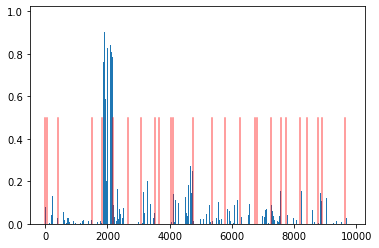

T_ACC =0.18594488501548767
T_BLCA =0.012452024035155773
T_BRCA =0.01134791411459446
T_CESC =0.004408520646393299
T_HBC =0.7471602559089661
T_COREAD =0.045239005237817764
T_DLBC =0.00786014087498188
T_GESCA =0.040001221001148224
T_GBM =0.008954421617090702
T_HNSC =0.0063176448456943035
T_KICH =0.02875293232500553
T_KC =0.06968066841363907
T_LAML =0.013987552374601364
T_LGG =0.012494800612330437
T_LUAD =0.022581811994314194
T_LUSC =0.010147484950721264
T_MESO =0.018548810854554176
T_GC =0.013655804097652435
T_PAAD =0.03919822350144386
T_PCPG =0.00985319446772337
T_PRAD =0.01935129053890705
T_SARC =0.015493549406528473
T_SKCM =0.014860645867884159
T_TGCT =0.07971598207950592
T_THCA =0.003906695172190666
T_THYM =0.012227502651512623


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


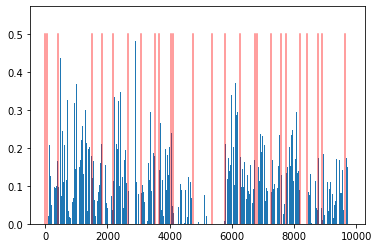

T_ACC =0.0053416090086102486
T_BLCA =0.13254761695861816
T_BRCA =0.17661051452159882
T_CESC =0.1234341710805893
T_HBC =0.051198992878198624
T_COREAD =0.17381493747234344
T_DLBC =0.04131593555212021
T_GESCA =0.13528604805469513
T_GBM =0.003975686151534319
T_HNSC =0.12023670226335526
T_KICH =0.19314587116241455
T_KC =0.056596748530864716
T_LAML =0.0032485893461853266
T_LGG =0.0030764341354370117
T_LUAD =0.17247945070266724
T_LUSC =0.1166771948337555
T_MESO =0.01233432162553072
T_GC =0.14712345600128174
T_PAAD =0.15719905495643616
T_PCPG =0.029619501903653145
T_PRAD =0.2033631056547165
T_SARC =0.009389198385179043
T_SKCM =0.042745500802993774
T_TGCT =0.1923530548810959
T_THCA =0.06614315509796143
T_THYM =0.12156857550144196
1


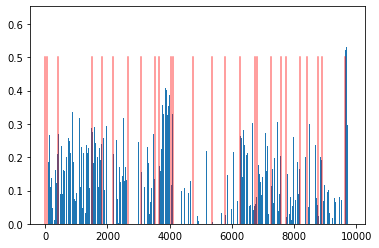

T_ACC =0.00275118974968791
T_BLCA =0.15225057303905487
T_BRCA =0.18510927259922028
T_CESC =0.17903736233711243
T_HBC =0.026097532361745834
T_COREAD =0.13429449498653412
T_DLBC =0.018368419259786606
T_GESCA =0.1167479082942009
T_GBM =0.0029429520945996046
T_HNSC =0.25740155577659607
T_KICH =0.15738274157047272
T_KC =0.0325465053319931
T_LAML =0.02053346484899521
T_LGG =0.006532385945320129
T_LUAD =0.0626273974776268
T_LUSC =0.18003787100315094
T_MESO =0.06564456224441528
T_GC =0.11819053441286087
T_PAAD =0.11488699167966843
T_PCPG =0.0019201317336410284
T_PRAD =0.09130175411701202
T_SARC =0.05881260335445404
T_SKCM =0.08281445503234863
T_TGCT =0.13048775494098663
T_THCA =0.06049111858010292
T_THYM =0.3733121156692505
2


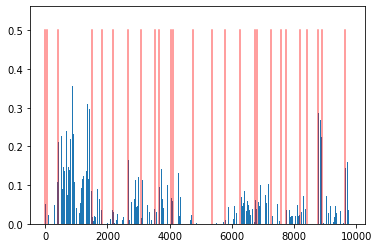

T_ACC =0.01425182819366455
T_BLCA =0.021053744480013847
T_BRCA =0.11460866779088974
T_CESC =0.041636910289525986
T_HBC =0.007854296825826168
T_COREAD =0.012294764630496502
T_DLBC =0.052002061158418655
T_GESCA =0.01762678287923336
T_GBM =0.005305589642375708
T_HNSC =0.04890459403395653
T_KICH =0.019680550321936607
T_KC =0.02392318658530712
T_LAML =0.005530292633920908
T_LGG =0.0059195347130298615
T_LUAD =0.02386937290430069
T_LUSC =0.050142232328653336
T_MESO =0.09649580717086792
T_GC =0.046865664422512054
T_PAAD =0.010690323077142239
T_PCPG =0.00836468581110239
T_PRAD =0.024220088496804237
T_SARC =0.02840954065322876
T_SKCM =0.0053702755831182
T_TGCT =0.2194821685552597
T_THCA =0.01910065859556198
T_THYM =0.07047320902347565
3


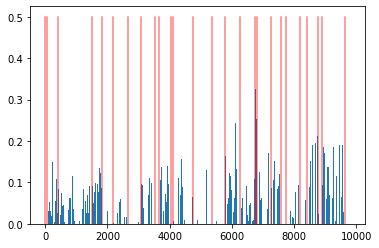

T_ACC =0.025662582367658615
T_BLCA =0.05076507851481438
T_BRCA =0.033309441059827805
T_CESC =0.06715107709169388
T_HBC =0.01023314893245697
T_COREAD =0.04076967015862465
T_DLBC =0.006829294841736555
T_GESCA =0.04422648251056671
T_GBM =0.002676714211702347
T_HNSC =0.05263903737068176
T_KICH =0.002181776100769639
T_KC =0.0454564206302166
T_LAML =0.0027949067298322916
T_LGG =0.009340937249362469
T_LUAD =0.10785219818353653
T_LUSC =0.03872476890683174
T_MESO =0.21318987011909485
T_GC =0.04816018044948578
T_PAAD =0.09047642350196838
T_PCPG =0.009172599762678146
T_PRAD =0.020421257242560387
T_SARC =0.027382059022784233
T_SKCM =0.04657711461186409
T_TGCT =0.005107284523546696
T_THCA =0.08491196483373642
T_THYM =0.003111101221293211
4


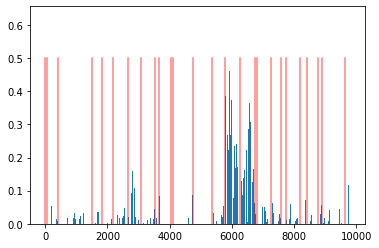

T_ACC =0.0054305922240018845
T_BLCA =0.01102880947291851
T_BRCA =0.00803553406149149
T_CESC =0.006459462456405163
T_HBC =0.008584944531321526
T_COREAD =0.008805772289633751
T_DLBC =0.02659982442855835
T_GESCA =0.015269520692527294
T_GBM =0.01266068872064352
T_HNSC =0.007663157768547535
T_KICH =0.004302369896322489
T_KC =0.008678412064909935
T_LAML =0.0013431576080620289
T_LGG =0.015293153934180737
T_LUAD =0.2722209095954895
T_LUSC =0.1511382758617401
T_MESO =0.062016647309064865
T_GC =0.014533314853906631
T_PAAD =0.018609575927257538
T_PCPG =0.005564498249441385
T_PRAD =0.014848868362605572
T_SARC =0.015052460134029388
T_SKCM =0.012969466857612133
T_TGCT =0.05002950131893158
T_THCA =0.010347395204007626
T_THYM =0.00456395884975791
5


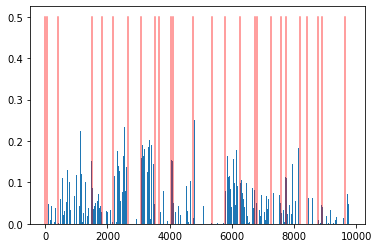

T_ACC =0.010362546890974045
T_BLCA =0.0413302518427372
T_BRCA =0.06493214517831802
T_CESC =0.07099021971225739
T_HBC =0.009111820720136166
T_COREAD =0.0910157635807991
T_DLBC =0.01005527749657631
T_GESCA =0.12766435742378235
T_GBM =0.00039973872480913997
T_HNSC =0.03140559792518616
T_KICH =0.16492195427417755
T_KC =0.036981917917728424
T_LAML =0.023724302649497986
T_LGG =0.0014641180168837309
T_LUAD =0.09119295328855515
T_LUSC =0.04109024256467819
T_MESO =0.006225530058145523
T_GC =0.043192822486162186
T_PAAD =0.036376453936100006
T_PCPG =0.015655215829610825
T_PRAD =0.0434781089425087
T_SARC =0.0019863401539623737
T_SKCM =0.01744501292705536
T_TGCT =0.016033371910452843
T_THCA =0.0079456502571702
T_THYM =0.025182977318763733
6


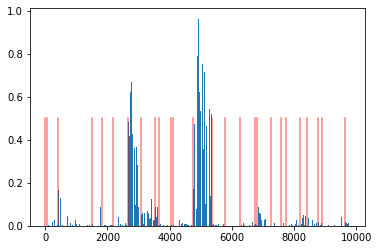

T_ACC =0.004719791002571583
T_BLCA =0.0019521763315424323
T_BRCA =0.009630654938519001
T_CESC =0.0037480350583791733
T_HBC =0.0019956501200795174
T_COREAD =0.009737434796988964
T_DLBC =0.37751325964927673
T_GESCA =0.04411834850907326
T_GBM =0.08238372951745987
T_HNSC =0.002263822127133608
T_KICH =0.00036532856756821275
T_KC =0.0046463338658213615
T_LAML =0.4785109758377075
T_LGG =0.002531541045755148
T_LUAD =0.0016835506539791822
T_LUSC =0.0027219546027481556
T_MESO =0.0038153266068547964
T_GC =0.04219406098127365
T_PAAD =0.012647690251469612
T_PCPG =0.004337186925113201
T_PRAD =0.006654924713075161
T_SARC =0.012969117611646652
T_SKCM =0.010592441074550152
T_TGCT =0.007714546285569668
T_THCA =0.011241566389799118
T_THYM =0.013913068920373917
7


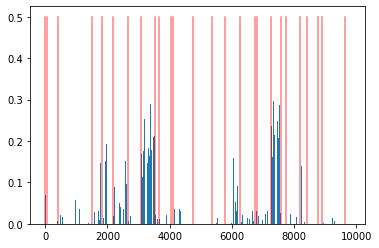

T_ACC =0.026036454364657402
T_BLCA =0.008268882520496845
T_BRCA =0.0036572206299751997
T_CESC =0.028109082952141762
T_HBC =0.03446205332875252
T_COREAD =0.03180539608001709
T_DLBC =0.01856810227036476
T_GESCA =0.17511940002441406
T_GBM =0.007285186555236578
T_HNSC =0.0076964846812188625
T_KICH =0.0008209469961002469
T_KC =0.0139424167573452
T_LAML =0.0012095641577616334
T_LGG =0.0024055493995547295
T_LUAD =0.02655773237347603
T_LUSC =0.008788758888840675
T_MESO =0.011086591519415379
T_GC =0.012997445650398731
T_PAAD =0.2345409095287323
T_PCPG =0.004665864631533623
T_PRAD =0.003430743236094713
T_SARC =0.015153932385146618
T_SKCM =0.0009892171947285533
T_TGCT =0.013674122281372547
T_THCA =0.0009381747804582119
T_THYM =0.0009304617415182292
8


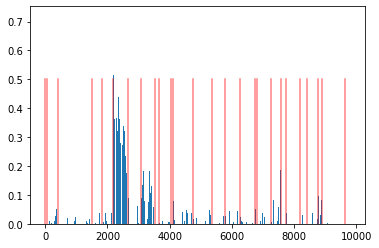

T_ACC =0.0011342368088662624
T_BLCA =0.008581042289733887
T_BRCA =0.002315904712304473
T_CESC =0.009493514895439148
T_HBC =0.009491144679486752
T_COREAD =0.3728448748588562
T_DLBC =0.019221818074584007
T_GESCA =0.07655692845582962
T_GBM =0.0019927325192838907
T_HNSC =0.0034875802230089903
T_KICH =0.0003664947871584445
T_KC =0.015061781741678715
T_LAML =0.010526247322559357
T_LGG =0.003600986674427986
T_LUAD =0.009468062780797482
T_LUSC =0.002395025221630931
T_MESO =0.004752781242132187
T_GC =0.007388667669147253
T_PAAD =0.03061346337199211
T_PCPG =0.0004942900850437582
T_PRAD =0.003889685031026602
T_SARC =0.009004214778542519
T_SKCM =0.006654111668467522
T_TGCT =0.06947597116231918
T_THCA =0.0005768348928540945
T_THYM =0.0
9


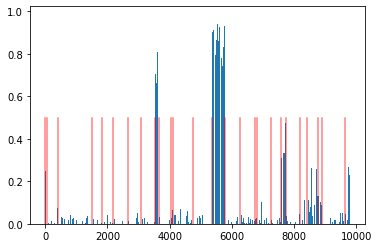

T_ACC =0.14018592238426208
T_BLCA =0.009210688062012196
T_BRCA =0.008064084686338902
T_CESC =0.004063306841999292
T_HBC =0.010026923380792141
T_COREAD =0.0021782820113003254
T_DLBC =0.014364464208483696
T_GESCA =0.006349577568471432
T_GBM =0.6846309900283813
T_HNSC =0.004600986372679472
T_KICH =0.03770134970545769
T_KC =0.023092612624168396
T_LAML =0.007762540131807327
T_LGG =0.8506767153739929
T_LUAD =0.007288029883056879
T_LUSC =0.007827987894415855
T_MESO =0.017757099121809006
T_GC =0.012277625501155853
T_PAAD =0.007677198853343725
T_PCPG =0.3923576772212982
T_PRAD =0.012866409495472908
T_SARC =0.10899922251701355
T_SKCM =0.1064644381403923
T_TGCT =0.062348317354917526
T_THCA =0.013929920271039009
T_THYM =0.03390868753194809
10


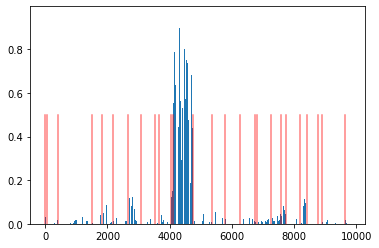

T_ACC =0.02108130417764187
T_BLCA =0.002602774417027831
T_BRCA =0.0031121359206736088
T_CESC =0.005824730731546879
T_HBC =0.01922336034476757
T_COREAD =0.00750022241845727
T_DLBC =0.02512374520301819
T_GESCA =0.005499247927218676
T_GBM =0.0071640401147305965
T_HNSC =0.002299630083143711
T_KICH =0.12896810472011566
T_KC =0.5365603566169739
T_LAML =0.017550615593791008
T_LGG =0.006702133920043707
T_LUAD =0.005857100244611502
T_LUSC =0.002408224157989025
T_MESO =0.02416570484638214
T_GC =0.013263016939163208
T_PAAD =0.019462017342448235
T_PCPG =0.047865550965070724
T_PRAD =0.00254615256562829
T_SARC =0.06908529996871948
T_SKCM =0.001956878462806344
T_TGCT =0.011642090044915676
T_THCA =0.0027168209198862314
T_THYM =0.010217937640845776
11


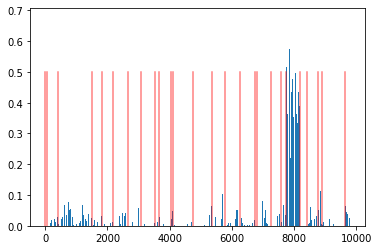

T_ACC =0.015360421501100063
T_BLCA =0.006533974315971136
T_BRCA =0.01836080476641655
T_CESC =0.008860468864440918
T_HBC =0.004511900246143341
T_COREAD =0.008138146251440048
T_DLBC =0.002560841850936413
T_GESCA =0.007414815481752157
T_GBM =0.007673786021769047
T_HNSC =0.004237135872244835
T_KICH =0.021958552300930023
T_KC =0.005755447782576084
T_LAML =0.00496276468038559
T_LGG =0.005246178712695837
T_LUAD =0.009006764739751816
T_LUSC =0.006010435055941343
T_MESO =0.0007015935843810439
T_GC =0.01477746944874525
T_PAAD =0.008435393683612347
T_PCPG =0.04199919477105141
T_PRAD =0.3862939774990082
T_SARC =0.010446340776979923
T_SKCM =0.011115754954516888
T_TGCT =0.016053861007094383
T_THCA =0.0030052708461880684
T_THYM =0.03401820361614227
12


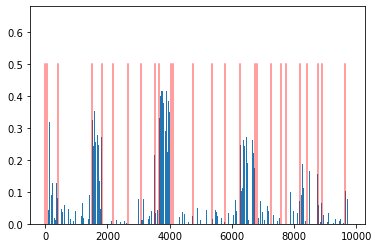

T_ACC =0.018050994724035263
T_BLCA =0.07760856300592422
T_BRCA =0.01508374884724617
T_CESC =0.21078242361545563
T_HBC =0.0034717635717242956
T_COREAD =0.012069454416632652
T_DLBC =0.011020525358617306
T_GESCA =0.06080906465649605
T_GBM =0.01495970506221056
T_HNSC =0.3668862283229828
T_KICH =0.0013789201620966196
T_KC =0.0066191405057907104
T_LAML =0.0046607693657279015
T_LGG =0.0072975438088178635
T_LUAD =0.01600804552435875
T_LUSC =0.19715407490730286
T_MESO =0.0117293456569314
T_GC =0.0134369395673275
T_PAAD =0.011735629290342331
T_PCPG =4.370607712189667e-05
T_PRAD =0.010550936684012413
T_SARC =0.02577151358127594
T_SKCM =0.036252718418836594
T_TGCT =0.037014786154031754
T_THCA =0.004321938846260309
T_THYM =0.0659879744052887
13


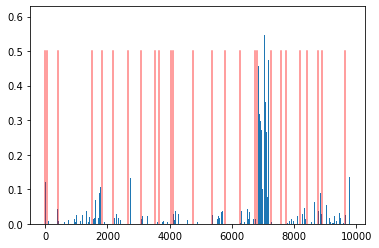

T_ACC =0.05846181511878967
T_BLCA =0.005381752271205187
T_BRCA =0.008473817259073257
T_CESC =0.02025792934000492
T_HBC =0.004287635441869497
T_COREAD =0.005179177038371563
T_DLBC =0.006387816742062569
T_GESCA =0.006737377028912306
T_GBM =0.016491133719682693
T_HNSC =0.003953579347580671
T_KICH =0.009018956683576107
T_KC =0.011488091200590134
T_LAML =0.0012729805894196033
T_LGG =0.00797715038061142
T_LUAD =0.00708321388810873
T_LUSC =0.007403158582746983
T_MESO =0.02508753351867199
T_GC =0.2797849476337433
T_PAAD =0.006709136534482241
T_PCPG =0.0020077787339687347
T_PRAD =0.005974785890430212
T_SARC =0.023707427084445953
T_SKCM =0.00534735806286335
T_TGCT =0.029425114393234253
T_THCA =0.007951151579618454
T_THYM =0.009476923383772373
14


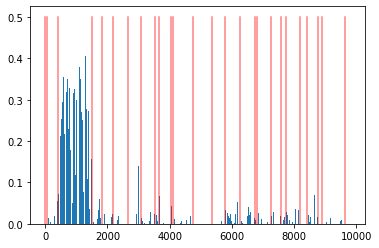

T_ACC =0.0012604373041540384
T_BLCA =0.010144977830350399
T_BRCA =0.23124872148036957
T_CESC =0.01342613622546196
T_HBC =0.005018758587539196
T_COREAD =0.0054554021917283535
T_DLBC =0.005438209045678377
T_GESCA =0.010257858783006668
T_GBM =0.015608131885528564
T_HNSC =0.007763850037008524
T_KICH =0.03257559612393379
T_KC =0.004955842159688473
T_LAML =0.0006281785317696631
T_LGG =0.004095854703336954
T_LUAD =0.015500016510486603
T_LUSC =0.007298842538148165
T_MESO =0.0030860616825520992
T_GC =0.0149691766127944
T_PAAD =0.0045071751810610294
T_PCPG =0.005886109545826912
T_PRAD =0.020854728296399117
T_SARC =0.007030710112303495
T_SKCM =0.01355100329965353
T_TGCT =0.0020810612477362156
T_THCA =0.0023255187552422285
T_THYM =0.01013276632875204
15


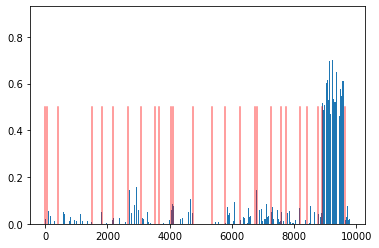

T_ACC =0.07067476958036423
T_BLCA =0.0062744105234742165
T_BRCA =0.01299410592764616
T_CESC =0.0032207295298576355
T_HBC =0.007094195112586021
T_COREAD =0.00537016149610281
T_DLBC =0.059501081705093384
T_GESCA =0.004948919638991356
T_GBM =0.0019396634306758642
T_HNSC =0.005064118653535843
T_KICH =0.11895089596509933
T_KC =0.02803054079413414
T_LAML =0.0010351744713261724
T_LGG =0.019313108175992966
T_LUAD =0.03355567902326584
T_LUSC =0.0135854072868824
T_MESO =0.023856570944190025
T_GC =0.024924784898757935
T_PAAD =0.016601623967289925
T_PCPG =0.02483963966369629
T_PRAD =0.01013702992349863
T_SARC =0.02318616583943367
T_SKCM =0.020904308184981346
T_TGCT =0.01821320131421089
T_THCA =0.5715605020523071
T_THYM =0.081988625228405
16


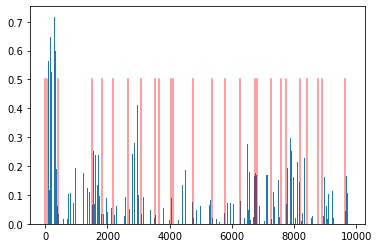

T_ACC =0.061836086213588715
T_BLCA =0.4049646556377411
T_BRCA =0.02474883198738098
T_CESC =0.14894743263721466
T_HBC =0.023805852979421616
T_COREAD =0.020275894552469254
T_DLBC =0.08508430421352386
T_GESCA =0.031761378049850464
T_GBM =0.0027476476971060038
T_HNSC =0.041234634816646576
T_KICH =0.03568857163190842
T_KC =0.02358119562268257
T_LAML =0.016059093177318573
T_LGG =0.005048219580203295
T_LUAD =0.0338224433362484
T_LUSC =0.06969773024320602
T_MESO =0.16962048411369324
T_GC =0.04086991026997566
T_PAAD =0.04952766373753548
T_PCPG =0.004291590768843889
T_PRAD =0.07970224320888519
T_SARC =0.09895049780607224
T_SKCM =0.003640841692686081
T_TGCT =0.011559284292161465
T_THCA =0.011313516646623611
T_THYM =0.11647367477416992
17


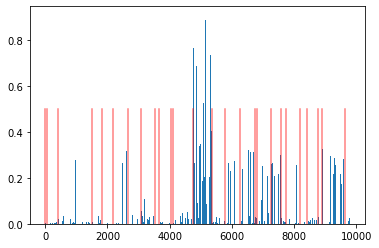

T_ACC =0.0021692973095923662
T_BLCA =0.002436649054288864
T_BRCA =0.03978031873703003
T_CESC =0.022606471553444862
T_HBC =0.001959773013368249
T_COREAD =0.00920808594673872
T_DLBC =0.008313366211950779
T_GESCA =0.04167337343096733
T_GBM =0.006053195334970951
T_HNSC =0.0027724383398890495
T_KICH =0.002756133209913969
T_KC =0.013208162970840931
T_LAML =0.37710070610046387
T_LGG =0.008878432214260101
T_LUAD =0.06629098206758499
T_LUSC =0.06029711663722992
T_MESO =0.013528796844184399
T_GC =0.06785431504249573
T_PAAD =0.1087794378399849
T_PCPG =0.019542094320058823
T_PRAD =0.035399436950683594
T_SARC =0.007107411045581102
T_SKCM =0.02279057912528515
T_TGCT =0.0029059622902423143
T_THCA =0.11481104791164398
T_THYM =0.0006767584127373993
18


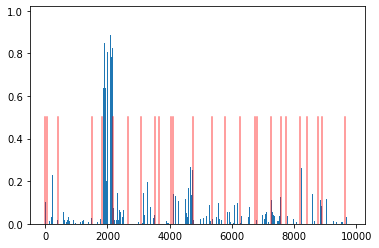

T_ACC =0.25541332364082336
T_BLCA =0.011589420028030872
T_BRCA =0.01148919202387333
T_CESC =0.0042737992480397224
T_HBC =0.7485844492912292
T_COREAD =0.0431060791015625
T_DLBC =0.008294520899653435
T_GESCA =0.036493245512247086
T_GBM =0.008924996480345726
T_HNSC =0.00581522099673748
T_KICH =0.023161813616752625
T_KC =0.07076117396354675
T_LAML =0.014795750379562378
T_LGG =0.01214260421693325
T_LUAD =0.022801637649536133
T_LUSC =0.008176271803677082
T_MESO =0.028367092832922935
T_GC =0.01297714188694954
T_PAAD =0.04225017502903938
T_PCPG =0.014978461898863316
T_PRAD =0.017604395747184753
T_SARC =0.021692855283617973
T_SKCM =0.025953127071261406
T_TGCT =0.062423817813396454
T_THCA =0.0037620447110384703
T_THYM =0.011854308657348156
19


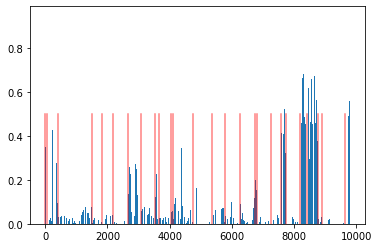

T_ACC =0.2598147690296173
T_BLCA =0.03547392785549164
T_BRCA =0.028434861451387405
T_CESC =0.02767670899629593
T_HBC =0.012985832057893276
T_COREAD =0.006135984323918819
T_DLBC =0.20343713462352753
T_GESCA =0.035439375787973404
T_GBM =0.11418364197015762
T_HNSC =0.023673664778470993
T_KICH =0.04467310011386871
T_KC =0.03811370208859444
T_LAML =0.0067499116994440556
T_LGG =0.022457391023635864
T_LUAD =0.014834493398666382
T_LUSC =0.028424439951777458
T_MESO =0.20653827488422394
T_GC =0.024218518286943436
T_PAAD =0.018273666501045227
T_PCPG =0.3663942217826843
T_PRAD =0.006461377255618572
T_SARC =0.425863116979599
T_SKCM =0.525865375995636
T_TGCT =0.041974734514951706
T_THCA =0.0026057588402181864
T_THYM =0.012208663858473301


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


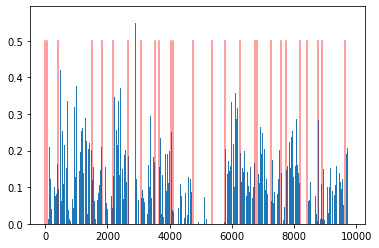

T_ACC =0.004584761802107096
T_BLCA =0.13023991882801056
T_BRCA =0.1833736002445221
T_CESC =0.12338820844888687
T_HBC =0.051855649799108505
T_COREAD =0.1956232786178589
T_DLBC =0.048537056893110275
T_GESCA =0.12985187768936157
T_GBM =0.0036617007572203875
T_HNSC =0.12475277483463287
T_KICH =0.20534923672676086
T_KC =0.05933379381895065
T_LAML =0.0032759378664195538
T_LGG =0.0028728798497468233
T_LUAD =0.17169363796710968
T_LUSC =0.12904027104377747
T_MESO =0.013047975488007069
T_GC =0.15080581605434418
T_PAAD =0.13989031314849854
T_PCPG =0.02733958326280117
T_PRAD =0.21185165643692017
T_SARC =0.009335888549685478
T_SKCM =0.03664282709360123
T_TGCT =0.26577508449554443
T_THCA =0.07158582657575607
T_THYM =0.1475650668144226
1


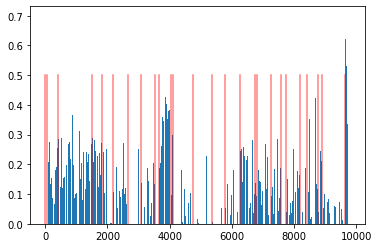

T_ACC =0.007596485782414675
T_BLCA =0.17304717004299164
T_BRCA =0.19882147014141083
T_CESC =0.1913444548845291
T_HBC =0.02486540749669075
T_COREAD =0.09971685707569122
T_DLBC =0.023209521546959877
T_GESCA =0.09907286614179611
T_GBM =0.0041652764193713665
T_HNSC =0.2720630466938019
T_KICH =0.13174226880073547
T_KC =0.03292277827858925
T_LAML =0.018640557304024696
T_LGG =0.00857612770050764
T_LUAD =0.06179524213075638
T_LUSC =0.184390127658844
T_MESO =0.10621866583824158
T_GC =0.1174313873052597
T_PAAD =0.0952986627817154
T_PCPG =0.0038671058136969805
T_PRAD =0.09920267015695572
T_SARC =0.0654396042227745
T_SKCM =0.10886906832456589
T_TGCT =0.1399960219860077
T_THCA =0.04877440258860588
T_THYM =0.4011537432670593
2


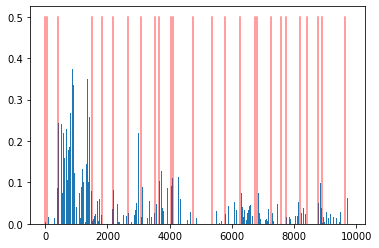

T_ACC =0.004937271121889353
T_BLCA =0.012245905585587025
T_BRCA =0.12132437527179718
T_CESC =0.02979223243892193
T_HBC =0.00776671851053834
T_COREAD =0.01190176885575056
T_DLBC =0.03188998997211456
T_GESCA =0.01309405267238617
T_GBM =0.007814903743565083
T_HNSC =0.03324124217033386
T_KICH =0.040665339678525925
T_KC =0.015125039964914322
T_LAML =0.0026837349869310856
T_LGG =0.00640931585803628
T_LUAD =0.021966436877846718
T_LUSC =0.03318909928202629
T_MESO =0.023480389267206192
T_GC =0.027190515771508217
T_PAAD =0.008802266791462898
T_PCPG =0.007465974427759647
T_PRAD =0.019096264615654945
T_SARC =0.014270666055381298
T_SKCM =0.005683037918061018
T_TGCT =0.06659939140081406
T_THCA =0.01073088962584734
T_THYM =0.01810477115213871
3


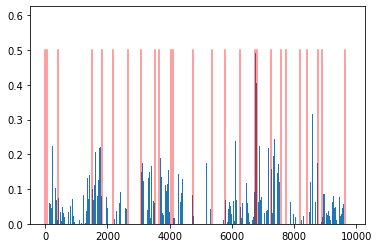

T_ACC =0.024391375482082367
T_BLCA =0.07373083382844925
T_BRCA =0.031497322022914886
T_CESC =0.09664805978536606
T_HBC =0.024048106744885445
T_COREAD =0.04708443954586983
T_DLBC =0.008274421095848083
T_GESCA =0.08540373295545578
T_GBM =0.004424566403031349
T_HNSC =0.07940434664487839
T_KICH =0.007711459416896105
T_KC =0.05942691117525101
T_LAML =0.008318472653627396
T_LGG =0.006736243609338999
T_LUAD =0.07514147460460663
T_LUSC =0.03885464370250702
T_MESO =0.34006375074386597
T_GC =0.06394673138856888
T_PAAD =0.1538800299167633
T_PCPG =0.00903344713151455
T_PRAD =0.010885520838201046
T_SARC =0.07629114389419556
T_SKCM =0.04091235622763634
T_TGCT =0.004913276992738247
T_THCA =0.03186323866248131
T_THYM =0.004399399738758802
4


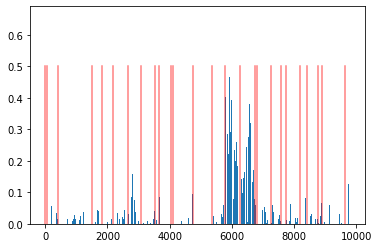

T_ACC =0.006072082556784153
T_BLCA =0.012492786161601543
T_BRCA =0.009337308816611767
T_CESC =0.007668233476579189
T_HBC =0.008404774591326714
T_COREAD =0.009824409149587154
T_DLBC =0.024925945326685905
T_GESCA =0.014939697459340096
T_GBM =0.012903771363198757
T_HNSC =0.00819057784974575
T_KICH =0.0038794148713350296
T_KC =0.009312908165156841
T_LAML =0.0010121798841282725
T_LGG =0.01562527008354664
T_LUAD =0.2807600796222687
T_LUSC =0.15787330269813538
T_MESO =0.08027208596467972
T_GC =0.01572519727051258
T_PAAD =0.02006307989358902
T_PCPG =0.005956556648015976
T_PRAD =0.016111429780721664
T_SARC =0.016461296007037163
T_SKCM =0.015028282068669796
T_TGCT =0.0534270741045475
T_THCA =0.007845055311918259
T_THYM =0.004984606988728046
5


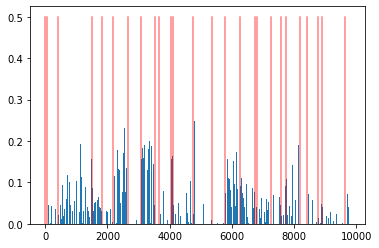

T_ACC =0.008206269703805447
T_BLCA =0.03891242295503616
T_BRCA =0.06252684444189072
T_CESC =0.0698118656873703
T_HBC =0.008328897878527641
T_COREAD =0.09044390916824341
T_DLBC =0.010415692813694477
T_GESCA =0.12389776110649109
T_GBM =0.0003114420978818089
T_HNSC =0.03136610612273216
T_KICH =0.16467198729515076
T_KC =0.035454943776130676
T_LAML =0.025500481948256493
T_LGG =0.0015076748095452785
T_LUAD =0.08766943216323853
T_LUSC =0.04056929051876068
T_MESO =0.005906173959374428
T_GC =0.04142047092318535
T_PAAD =0.034090202301740646
T_PCPG =0.011848362162709236
T_PRAD =0.04236328974366188
T_SARC =0.0018902085721492767
T_SKCM =0.01770741492509842
T_TGCT =0.01944303698837757
T_THCA =0.00799541175365448
T_THYM =0.024575889110565186
6


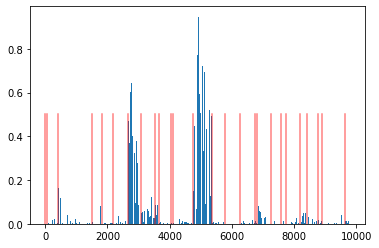

T_ACC =0.00408945232629776
T_BLCA =0.001813537091948092
T_BRCA =0.009037548676133156
T_CESC =0.00346939405426383
T_HBC =0.001956961350515485
T_COREAD =0.009669805876910686
T_DLBC =0.3672613203525543
T_GESCA =0.043036285787820816
T_GBM =0.08213037252426147
T_HNSC =0.002086818451061845
T_KICH =0.0003407130716368556
T_KC =0.0042163594625890255
T_LAML =0.45475101470947266
T_LGG =0.002443963196128607
T_LUAD =0.0016334598185494542
T_LUSC =0.002624650951474905
T_MESO =0.0036965711042284966
T_GC =0.04039638489484787
T_PAAD =0.012119613587856293
T_PCPG =0.004122983198612928
T_PRAD =0.006315490230917931
T_SARC =0.012545647099614143
T_SKCM =0.010064211674034595
T_TGCT =0.006518390960991383
T_THCA =0.011663022451102734
T_THYM =0.012523611076176167
7


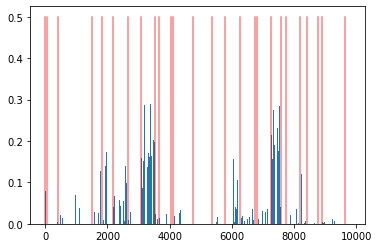

T_ACC =0.029218925163149834
T_BLCA =0.007692665793001652
T_BRCA =0.003857275703921914
T_CESC =0.026495834812521935
T_HBC =0.03307361155748367
T_COREAD =0.03424815461039543
T_DLBC =0.01764204539358616
T_GESCA =0.16835181415081024
T_GBM =0.00849606841802597
T_HNSC =0.007926384918391705
T_KICH =0.0008022890542633832
T_KC =0.011469966731965542
T_LAML =0.0012408880284056067
T_LGG =0.0026372417341917753
T_LUAD =0.026668837293982506
T_LUSC =0.009190293960273266
T_MESO =0.0010465101804584265
T_GC =0.013811280019581318
T_PAAD =0.2160634696483612
T_PCPG =0.0056711663492023945
T_PRAD =0.004731963854283094
T_SARC =0.010295029729604721
T_SKCM =0.0016398875741288066
T_TGCT =0.013414891436696053
T_THCA =0.0012890099314972758
T_THYM =0.0010198442032560706
8


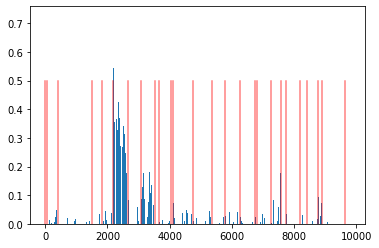

T_ACC =0.0008065146976150572
T_BLCA =0.007808849215507507
T_BRCA =0.0020300764590501785
T_CESC =0.008942588232457638
T_HBC =0.009193823672831059
T_COREAD =0.3728407621383667
T_DLBC =0.01896544173359871
T_GESCA =0.07701560109853745
T_GBM =0.0018144614296033978
T_HNSC =0.0034250973258167505
T_KICH =0.00031873141415417194
T_KC =0.013557991944253445
T_LAML =0.009586007334291935
T_LGG =0.00328134186565876
T_LUAD =0.008520021103322506
T_LUSC =0.002416015136986971
T_MESO =0.0019682978745549917
T_GC =0.006718079559504986
T_PAAD =0.030131593346595764
T_PCPG =0.0004881789209321141
T_PRAD =0.0034101870842278004
T_SARC =0.0077780792489647865
T_SKCM =0.00646001985296607
T_TGCT =0.0614461712539196
T_THCA =0.000670729496050626
T_THYM =0.0
9


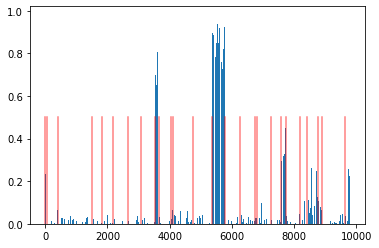

T_ACC =0.13069963455200195
T_BLCA =0.00836960505694151
T_BRCA =0.007154387421905994
T_CESC =0.0037657003849744797
T_HBC =0.009599538519978523
T_COREAD =0.0019851422403007746
T_DLBC =0.012931814417243004
T_GESCA =0.005794702563434839
T_GBM =0.6754320859909058
T_HNSC =0.0042594545520842075
T_KICH =0.03376409038901329
T_KC =0.021054493263363838
T_LAML =0.008039300329983234
T_LGG =0.8348918557167053
T_LUAD =0.00607635360211134
T_LUSC =0.006577759049832821
T_MESO =0.01786106266081333
T_GC =0.011457954533398151
T_PAAD =0.007314211223274469
T_PCPG =0.3810221254825592
T_PRAD =0.011759934015572071
T_SARC =0.10518025606870651
T_SKCM =0.10296547412872314
T_TGCT =0.04855391010642052
T_THCA =0.011296052485704422
T_THYM =0.028721829876303673
10


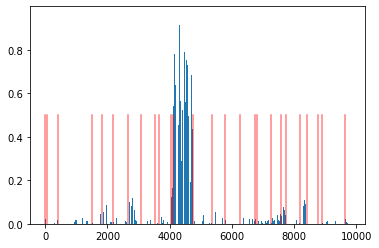

T_ACC =0.019165178760886192
T_BLCA =0.0027961144223809242
T_BRCA =0.0029357741586863995
T_CESC =0.005846564192324877
T_HBC =0.01988976076245308
T_COREAD =0.007442248519510031
T_DLBC =0.024797901511192322
T_GESCA =0.005462121218442917
T_GBM =0.0071170455776154995
T_HNSC =0.0022244667634367943
T_KICH =0.13259011507034302
T_KC =0.5321961641311646
T_LAML =0.017177214846014977
T_LGG =0.006726016756147146
T_LUAD =0.005275084171444178
T_LUSC =0.0023593315854668617
T_MESO =0.028579968959093094
T_GC =0.012814309448003769
T_PAAD =0.019836828112602234
T_PCPG =0.04546191915869713
T_PRAD =0.002561876317486167
T_SARC =0.07012172043323517
T_SKCM =0.0017775039887055755
T_TGCT =0.01285154651850462
T_THCA =0.002695181407034397
T_THYM =0.013424607925117016
11


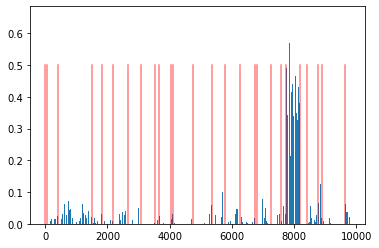

T_ACC =0.01309380866587162
T_BLCA =0.005821302533149719
T_BRCA =0.016617920249700546
T_CESC =0.00789789017289877
T_HBC =0.00417003408074379
T_COREAD =0.007568619213998318
T_DLBC =0.0020964168943464756
T_GESCA =0.006028740666806698
T_GBM =0.007091908250004053
T_HNSC =0.003286957973614335
T_KICH =0.019165383651852608
T_KC =0.005395382642745972
T_LAML =0.004402833990752697
T_LGG =0.005045589990913868
T_LUAD =0.008018646389245987
T_LUSC =0.004680644255131483
T_MESO =0.0024887172039598227
T_GC =0.013245005160570145
T_PAAD =0.007900604046881199
T_PCPG =0.03849504888057709
T_PRAD =0.3710305094718933
T_SARC =0.010264297015964985
T_SKCM =0.00957497674971819
T_TGCT =0.020869266241788864
T_THCA =0.0022396985441446304
T_THYM =0.03176366910338402
12


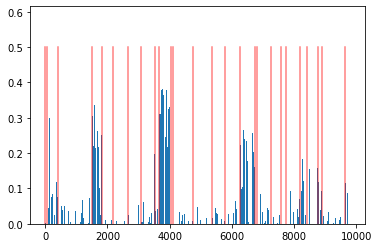

T_ACC =0.017251575365662575
T_BLCA =0.06823881715536118
T_BRCA =0.01227153092622757
T_CESC =0.19322708249092102
T_HBC =0.002936235861852765
T_COREAD =0.010377530939877033
T_DLBC =0.010102448053658009
T_GESCA =0.05639748275279999
T_GBM =0.014923952519893646
T_HNSC =0.3378261625766754
T_KICH =0.001222175662405789
T_KC =0.005265433341264725
T_LAML =0.003548670094460249
T_LGG =0.0071724290028214455
T_LUAD =0.01342693343758583
T_LUSC =0.18540368974208832
T_MESO =0.006977197248488665
T_GC =0.011426156386733055
T_PAAD =0.008812534622848034
T_PCPG =2.160229632863775e-05
T_PRAD =0.010812640190124512
T_SARC =0.02130666933953762
T_SKCM =0.032789092510938644
T_TGCT =0.06272608786821365
T_THCA =0.004492426291108131
T_THYM =0.06722743064165115
13


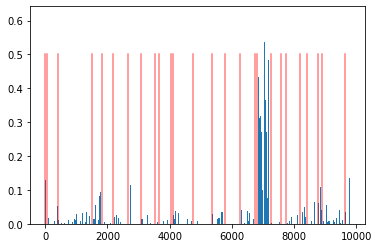

T_ACC =0.06019097566604614
T_BLCA =0.004810672719031572
T_BRCA =0.008938212879002094
T_CESC =0.020017122849822044
T_HBC =0.003960215020924807
T_COREAD =0.005075322464108467
T_DLBC =0.006515312008559704
T_GESCA =0.006778473034501076
T_GBM =0.01657971180975437
T_HNSC =0.0038712341338396072
T_KICH =0.0064546531066298485
T_KC =0.011375273577868938
T_LAML =0.0011768428375944495
T_LGG =0.008052956312894821
T_LUAD =0.0063157170079648495
T_LUSC =0.00716553395614028
T_MESO =0.014273555018007755
T_GC =0.2804422378540039
T_PAAD =0.00567981880158186
T_PCPG =0.0020667454227805138
T_PRAD =0.00696842884644866
T_SARC =0.021774068474769592
T_SKCM =0.0057634152472019196
T_TGCT =0.04068287834525108
T_THCA =0.0073359510861337185
T_THYM =0.010134132578969002
14


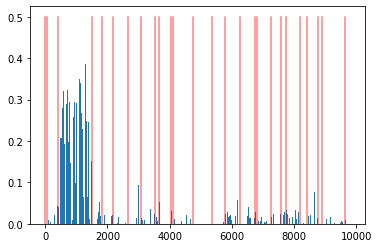

T_ACC =0.001853439025580883
T_BLCA =0.009659482166171074
T_BRCA =0.20967531204223633
T_CESC =0.012399464845657349
T_HBC =0.005276959855109453
T_COREAD =0.005647267214953899
T_DLBC =0.004503198433667421
T_GESCA =0.010230532847344875
T_GBM =0.014957952313125134
T_HNSC =0.005950157064944506
T_KICH =0.024363957345485687
T_KC =0.00467632757499814
T_LAML =0.0005932910717092454
T_LGG =0.0037325650919228792
T_LUAD =0.0144246406853199
T_LUSC =0.006266327574849129
T_MESO =0.0070937504060566425
T_GC =0.014041361398994923
T_PAAD =0.004053669050335884
T_PCPG =0.007106318138539791
T_PRAD =0.020875785499811172
T_SARC =0.007182702422142029
T_SKCM =0.013062188401818275
T_TGCT =0.0027615295257419348
T_THCA =0.0020885816775262356
T_THYM =0.011737317778170109
15


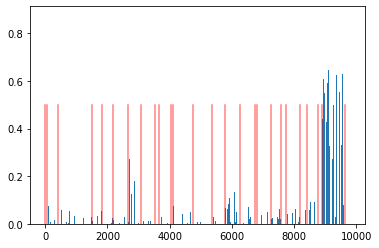

T_ACC =0.03660658374428749
T_BLCA =0.009965491481125355
T_BRCA =0.011218970641493797
T_CESC =0.006865045055747032
T_HBC =0.006581862457096577
T_COREAD =0.008631013333797455
T_DLBC =0.049594856798648834
T_GESCA =0.005429954268038273
T_GBM =0.0024726467672735453
T_HNSC =0.008112616837024689
T_KICH =0.011249520815908909
T_KC =0.017880385741591454
T_LAML =0.004670169670134783
T_LGG =0.02598617970943451
T_LUAD =0.0717659443616867
T_LUSC =0.013666508719325066
T_MESO =0.002647248562425375
T_GC =0.01852319948375225
T_PAAD =0.014307252131402493
T_PCPG =0.0014882497489452362
T_PRAD =0.011978750117123127
T_SARC =0.008129987865686417
T_SKCM =0.03319922089576721
T_TGCT =0.004251524340361357
T_THCA =0.379848837852478
T_THYM =0.012731128372251987
16


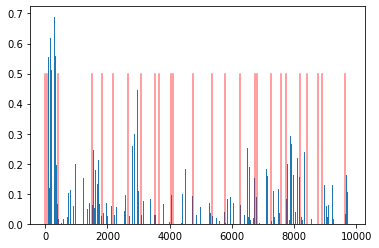

T_ACC =0.06635045260190964
T_BLCA =0.3826560080051422
T_BRCA =0.022149063646793365
T_CESC =0.1363143026828766
T_HBC =0.02099272608757019
T_COREAD =0.021385440602898598
T_DLBC =0.09492020308971405
T_GESCA =0.031239304691553116
T_GBM =0.003311791457235813
T_HNSC =0.0370481014251709
T_KICH =0.044494036585092545
T_KC =0.022477276623249054
T_LAML =0.013345159590244293
T_LGG =0.00541335716843605
T_LUAD =0.0314156748354435
T_LUSC =0.06743030995130539
T_MESO =0.07960879057645798
T_GC =0.03677307814359665
T_PAAD =0.043452050536870956
T_PCPG =0.004658117890357971
T_PRAD =0.08345095068216324
T_SARC =0.08056630939245224
T_SKCM =0.0026244400069117546
T_TGCT =0.013524784706532955
T_THCA =0.0106979263946414
T_THYM =0.11759352684020996
17


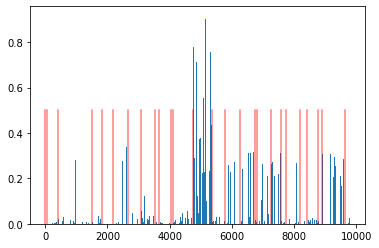

T_ACC =0.0011638787109404802
T_BLCA =0.002461180789396167
T_BRCA =0.039266519248485565
T_CESC =0.022967301309108734
T_HBC =0.0018103920156136155
T_COREAD =0.009522708132863045
T_DLBC =0.010541403666138649
T_GESCA =0.04291355237364769
T_GBM =0.007066786754876375
T_HNSC =0.0024931353982537985
T_KICH =0.0009678660426288843
T_KC =0.012880871072411537
T_LAML =0.40105894207954407
T_LGG =0.009827511385083199
T_LUAD =0.06560634821653366
T_LUSC =0.05952738970518112
T_MESO =0.0063946363516151905
T_GC =0.06898751854896545
T_PAAD =0.10986105352640152
T_PCPG =0.01570029743015766
T_PRAD =0.03704029321670532
T_SARC =0.006004584487527609
T_SKCM =0.02418467029929161
T_TGCT =0.0008522759890183806
T_THCA =0.11250653862953186
T_THYM =0.0002063721331069246
18


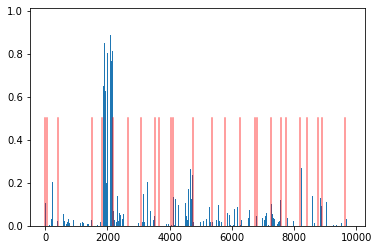

T_ACC =0.2484736144542694
T_BLCA =0.010286219418048859
T_BRCA =0.011008457280695438
T_CESC =0.003923390991985798
T_HBC =0.7378973364830017
T_COREAD =0.041650522500276566
T_DLBC =0.008291089907288551
T_GESCA =0.03428000584244728
T_GBM =0.008375768549740314
T_HNSC =0.005559907294809818
T_KICH =0.027210453525185585
T_KC =0.06638146936893463
T_LAML =0.013894089497625828
T_LGG =0.011747052893042564
T_LUAD =0.020085258409380913
T_LUSC =0.008036994375288486
T_MESO =0.027037598192691803
T_GC =0.011883839033544064
T_PAAD =0.03927101567387581
T_PCPG =0.014862901531159878
T_PRAD =0.016382820904254913
T_SARC =0.02404172345995903
T_SKCM =0.02500927448272705
T_TGCT =0.06674407422542572
T_THCA =0.003651701146736741
T_THYM =0.011549235321581364
19


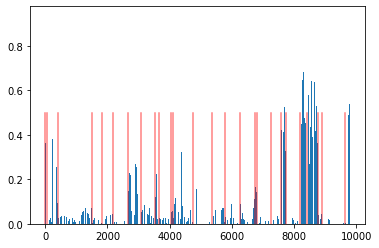

T_ACC =0.25978195667266846
T_BLCA =0.03319484740495682
T_BRCA =0.027417272329330444
T_CESC =0.02643452398478985
T_HBC =0.012725232169032097
T_COREAD =0.005694898776710033
T_DLBC =0.19897262752056122
T_GESCA =0.034948430955410004
T_GBM =0.11359350383281708
T_HNSC =0.022722769528627396
T_KICH =0.04436178877949715
T_KC =0.03636801987886429
T_LAML =0.0066737099550664425
T_LGG =0.02222786284983158
T_LUAD =0.012843240983784199
T_LUSC =0.027853315696120262
T_MESO =0.18827758729457855
T_GC =0.023441514000296593
T_PAAD =0.016885802149772644
T_PCPG =0.3687550723552704
T_PRAD =0.006235021632164717
T_SARC =0.4097135066986084
T_SKCM =0.4985354542732239
T_TGCT =0.05225582420825958
T_THCA =0.002694270573556423
T_THYM =0.011681611649692059
20


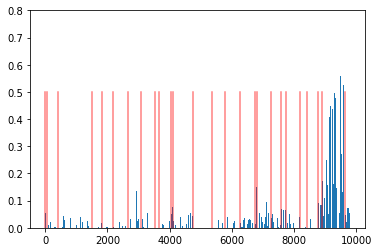

T_ACC =0.05546573922038078
T_BLCA =0.0037561897188425064
T_BRCA =0.009540751576423645
T_CESC =0.002780759474262595
T_HBC =0.004665723070502281
T_COREAD =0.00366587215103209
T_DLBC =0.025611301884055138
T_GESCA =0.005833015311509371
T_GBM =0.0033542397432029247
T_HNSC =0.004188671242445707
T_KICH =0.09867452085018158
T_KC =0.023228183388710022
T_LAML =0.0004104898835066706
T_LGG =0.009086556732654572
T_LUAD =0.008897554129362106
T_LUSC =0.012884508818387985
T_MESO =0.04305947199463844
T_GC =0.01951797679066658
T_PAAD =0.012285956181585789
T_PCPG =0.04456821456551552
T_PRAD =0.006934517528861761
T_SARC =0.021406617015600204
T_SKCM =0.007507189642637968
T_TGCT =0.04239295795559883
T_THCA =0.26803526282310486
T_THYM =0.06890217214822769


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


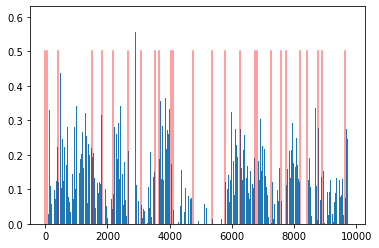

T_ACC =0.0038102709222584963
T_BLCA =0.14485065639019012
T_BRCA =0.1907719224691391
T_CESC =0.15203309059143066
T_HBC =0.0421014241874218
T_COREAD =0.1734439879655838
T_DLBC =0.0511762872338295
T_GESCA =0.104310542345047
T_GBM =0.001991019584238529
T_HNSC =0.21365341544151306
T_KICH =0.1277228146791458
T_KC =0.043262481689453125
T_LAML =0.003406935604289174
T_LGG =0.003472396871075034
T_LUAD =0.1350635439157486
T_LUSC =0.16790257394313812
T_MESO =0.012583861127495766
T_GC =0.16111917793750763
T_PAAD =0.08894064277410507
T_PCPG =0.006349066738039255
T_PRAD =0.20925366878509521
T_SARC =0.009689793922007084
T_SKCM =0.06378670036792755
T_TGCT =0.27545738220214844
T_THCA =0.06263049691915512
T_THYM =0.20132678747177124
1


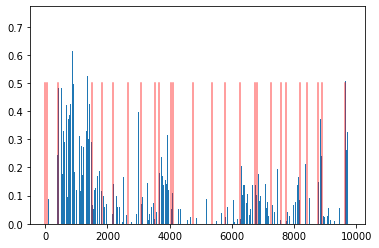

T_ACC =0.005786692723631859
T_BLCA =0.056378308683633804
T_BRCA =0.26750513911247253
T_CESC =0.08753619343042374
T_HBC =0.01328955963253975
T_COREAD =0.03644567355513573
T_DLBC =0.04393523186445236
T_GESCA =0.034580834209918976
T_GBM =0.0074975984171032906
T_HNSC =0.12060041725635529
T_KICH =0.021248523145914078
T_KC =0.012566913850605488
T_LAML =0.010649880394339561
T_LGG =0.010008267126977444
T_LUAD =0.03476749360561371
T_LUSC =0.09699968993663788
T_MESO =0.12685133516788483
T_GC =0.06831767410039902
T_PAAD =0.02332214079797268
T_PCPG =0.005656886380165815
T_PRAD =0.06114441156387329
T_SARC =0.04995405673980713
T_SKCM =0.034590065479278564
T_TGCT =0.20407359302043915
T_THCA =0.025582095608115196
T_THYM =0.27652639150619507
2


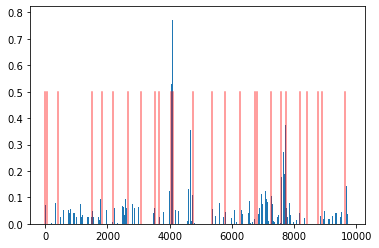

T_ACC =0.06716868281364441
T_BLCA =0.014404911547899246
T_BRCA =0.026765910908579826
T_CESC =0.01741720922291279
T_HBC =0.014497790485620499
T_COREAD =0.023056989535689354
T_DLBC =0.009969398379325867
T_GESCA =0.01276133581995964
T_GBM =0.002345610409975052
T_HNSC =0.009703085757791996
T_KICH =0.564536988735199
T_KC =0.07477379590272903
T_LAML =0.029662081971764565
T_LGG =0.009260755963623524
T_LUAD =0.022755539044737816
T_LUSC =0.01125017274171114
T_MESO =0.001909227343276143
T_GC =0.04826720431447029
T_PAAD =0.03055153414607048
T_PCPG =0.20002184808254242
T_PRAD =0.02847469039261341
T_SARC =0.016555428504943848
T_SKCM =0.004152160603553057
T_TGCT =0.0023278393782675266
T_THCA =0.017868345603346825
T_THYM =0.05015331506729126
3


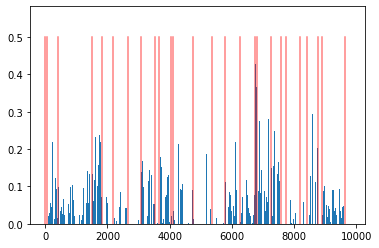

T_ACC =0.021922670304775238
T_BLCA =0.0761738196015358
T_BRCA =0.04030551761388779
T_CESC =0.10404457896947861
T_HBC =0.022124387323856354
T_COREAD =0.042958397418260574
T_DLBC =0.006230776663869619
T_GESCA =0.0731719359755516
T_GBM =0.003799982136115432
T_HNSC =0.06942851096391678
T_KICH =0.015006911009550095
T_KC =0.0692608654499054
T_LAML =0.0085746506229043
T_LGG =0.007311146706342697
T_LUAD =0.08841108530759811
T_LUSC =0.04050688445568085
T_MESO =0.30995672941207886
T_GC =0.09447697550058365
T_PAAD =0.1450108289718628
T_PCPG =0.006672391667962074
T_PRAD =0.014162424951791763
T_SARC =0.06646566092967987
T_SKCM =0.039291027933359146
T_TGCT =0.0035467015113681555
T_THCA =0.036716435104608536
T_THYM =0.0032550161704421043
4


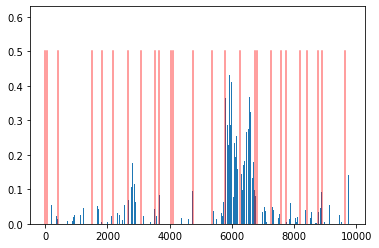

T_ACC =0.0072989980690181255
T_BLCA =0.013272015377879143
T_BRCA =0.007511149160563946
T_CESC =0.005745237227529287
T_HBC =0.008598805405199528
T_COREAD =0.008365348912775517
T_DLBC =0.032234370708465576
T_GESCA =0.01565343327820301
T_GBM =0.014389360323548317
T_HNSC =0.007938322611153126
T_KICH =0.0027295188046991825
T_KC =0.010903875343501568
T_LAML =0.0011436042841523886
T_LGG =0.017044195905327797
T_LUAD =0.2741965055465698
T_LUSC =0.1660952866077423
T_MESO =0.09346719086170197
T_GC =0.012619997374713421
T_PAAD =0.016999486833810806
T_PCPG =0.004858919885009527
T_PRAD =0.014964894391596317
T_SARC =0.021018672734498978
T_SKCM =0.01525676529854536
T_TGCT =0.06881416589021683
T_THCA =0.00842387042939663
T_THYM =0.005008293315768242
5


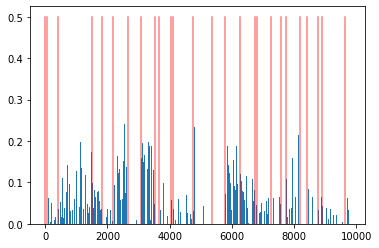

T_ACC =0.006279459223151207
T_BLCA =0.04607369750738144
T_BRCA =0.0667208656668663
T_CESC =0.08843055367469788
T_HBC =0.008577898144721985
T_COREAD =0.08585076779127121
T_DLBC =0.010906978510320187
T_GESCA =0.1242813989520073
T_GBM =0.0003658521454781294
T_HNSC =0.04216663911938667
T_KICH =0.0539531484246254
T_KC =0.02849014475941658
T_LAML =0.01662004552781582
T_LGG =0.0012594610452651978
T_LUAD =0.09596671909093857
T_LUSC =0.05109426751732826
T_MESO =0.007297128438949585
T_GC =0.04303203523159027
T_PAAD =0.03400129824876785
T_PCPG =0.0023617504630237818
T_PRAD =0.0443887859582901
T_SARC =0.0015966389328241348
T_SKCM =0.016851432621479034
T_TGCT =0.027679720893502235
T_THCA =0.008517567999660969
T_THYM =0.022559836506843567
6


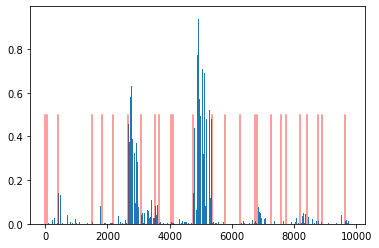

T_ACC =0.003768730442970991
T_BLCA =0.0018399732653051615
T_BRCA =0.00852638017386198
T_CESC =0.003741397289559245
T_HBC =0.00176183320581913
T_COREAD =0.009822805412113667
T_DLBC =0.35896429419517517
T_GESCA =0.03914428502321243
T_GBM =0.07998988032341003
T_HNSC =0.0021942085586488247
T_KICH =0.0007545735570602119
T_KC =0.00371977174654603
T_LAML =0.4408227503299713
T_LGG =0.002294156700372696
T_LUAD =0.0014841522788628936
T_LUSC =0.00247233547270298
T_MESO =0.0034612449817359447
T_GC =0.039366088807582855
T_PAAD =0.011026578955352306
T_PCPG =0.004334204830229282
T_PRAD =0.006105783861130476
T_SARC =0.012444439344108105
T_SKCM =0.010322471149265766
T_TGCT =0.004673416260629892
T_THCA =0.01109578087925911
T_THYM =0.013299918733537197
7


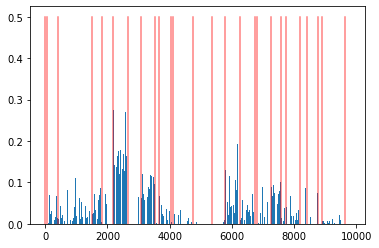

T_ACC =0.002597460290417075
T_BLCA =0.022561095654964447
T_BRCA =0.021634608507156372
T_CESC =0.04901406168937683
T_HBC =0.01736345700919628
T_COREAD =0.18319784104824066
T_DLBC =0.010083143599331379
T_GESCA =0.07681248337030411
T_GBM =0.00864590797573328
T_HNSC =0.03029041178524494
T_KICH =0.0042770602740347385
T_KC =0.012979330494999886
T_LAML =0.005377742927521467
T_LGG =0.00633644126355648
T_LUAD =0.059061262756586075
T_LUSC =0.027989065274596214
T_MESO =0.0023428499698638916
T_GC =0.028653671965003014
T_PAAD =0.0864795446395874
T_PCPG =0.014718049205839634
T_PRAD =0.0197187140583992
T_SARC =0.005756521597504616
T_SKCM =0.013630447909235954
T_TGCT =0.015407507307827473
T_THCA =0.003964594099670649
T_THYM =0.00539977103471756
8


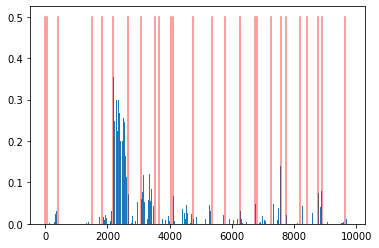

T_ACC =0.0019029100658372045
T_BLCA =0.0075736381113529205
T_BRCA =0.001282328274101019
T_CESC =0.005284461192786694
T_HBC =0.007143785711377859
T_COREAD =0.26795920729637146
T_DLBC =0.0170709490776062
T_GESCA =0.0501321479678154
T_GBM =0.0011901273392140865
T_HNSC =0.0029273820109665394
T_KICH =0.0007785196648910642
T_KC =0.011584308929741383
T_LAML =0.009474926628172398
T_LGG =0.002400305587798357
T_LUAD =0.0054536438547074795
T_LUSC =0.00214833184145391
T_MESO =0.006409686990082264
T_GC =0.004622593522071838
T_PAAD =0.018183408305048943
T_PCPG =0.00020626003970392048
T_PRAD =0.00214624241925776
T_SARC =0.012101073749363422
T_SKCM =0.0058752987533807755
T_TGCT =0.05514632165431976
T_THCA =0.000746975711081177
T_THYM =0.000553991470951587
9


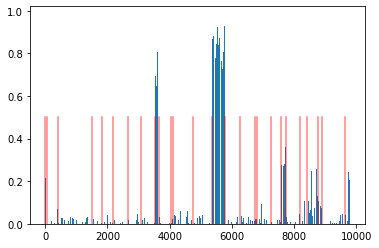

T_ACC =0.12580890953540802
T_BLCA =0.008353670127689838
T_BRCA =0.007031457498669624
T_CESC =0.004058314021676779
T_HBC =0.009027463383972645
T_COREAD =0.001850051456131041
T_DLBC =0.012943803332746029
T_GESCA =0.005516116973012686
T_GBM =0.6711235046386719
T_HNSC =0.004447177052497864
T_KICH =0.014621132984757423
T_KC =0.020465107634663582
T_LAML =0.007355875335633755
T_LGG =0.8271527886390686
T_LUAD =0.005653791595250368
T_LUSC =0.006800179369747639
T_MESO =0.01469478104263544
T_GC =0.010979768820106983
T_PAAD =0.006291305646300316
T_PCPG =0.33308300375938416
T_PRAD =0.012090707197785378
T_SARC =0.1047588586807251
T_SKCM =0.09895569831132889
T_TGCT =0.05238259583711624
T_THCA =0.010908453725278378
T_THYM =0.030495576560497284
10


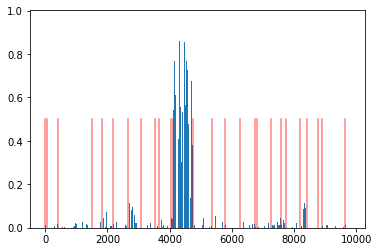

T_ACC =0.015119193121790886
T_BLCA =0.002378803910687566
T_BRCA =0.0026167186442762613
T_CESC =0.005585990846157074
T_HBC =0.017703963443636894
T_COREAD =0.0070089478977024555
T_DLBC =0.025632616132497787
T_GESCA =0.004928240552544594
T_GBM =0.007707844953984022
T_HNSC =0.0024676804896444082
T_KICH =0.05471232160925865
T_KC =0.5090053081512451
T_LAML =0.013396804220974445
T_LGG =0.006874730810523033
T_LUAD =0.0042726388201117516
T_LUSC =0.0022036198060959578
T_MESO =0.026275189593434334
T_GC =0.009636162780225277
T_PAAD =0.014988965354859829
T_PCPG =0.019761644303798676
T_PRAD =0.0018515965202823281
T_SARC =0.06815727800130844
T_SKCM =0.0016912914579734206
T_TGCT =0.011678709648549557
T_THCA =0.0025706859305500984
T_THYM =0.006277564447373152
11


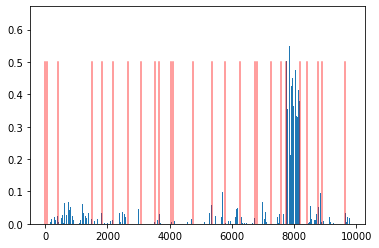

T_ACC =0.010644488036632538
T_BLCA =0.004970949608832598
T_BRCA =0.01564483344554901
T_CESC =0.007423665374517441
T_HBC =0.003449789946898818
T_COREAD =0.006938928738236427
T_DLBC =0.0021184722427278757
T_GESCA =0.005700173322111368
T_GBM =0.0067496635019779205
T_HNSC =0.003519028425216675
T_KICH =0.004487254191190004
T_KC =0.004197556059807539
T_LAML =0.0036214743740856647
T_LGG =0.004543290939182043
T_LUAD =0.008392099291086197
T_LUSC =0.00496742594987154
T_MESO =0.0011277471203356981
T_GC =0.010898956097662449
T_PAAD =0.006739651784300804
T_PCPG =0.01953146606683731
T_PRAD =0.3686329126358032
T_SARC =0.009234531782567501
T_SKCM =0.009382335469126701
T_TGCT =0.015198295935988426
T_THCA =0.001975084887817502
T_THYM =0.01707514375448227
12


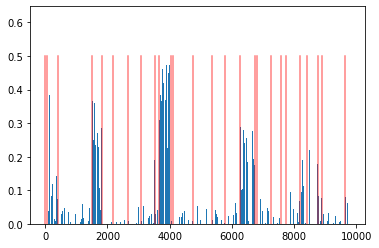

T_ACC =0.018471676856279373
T_BLCA =0.07642742246389389
T_BRCA =0.011058651842176914
T_CESC =0.20763762295246124
T_HBC =0.0027373232878744602
T_COREAD =0.010508852079510689
T_DLBC =0.011424056254327297
T_GESCA =0.05789477750658989
T_GBM =0.013588087633252144
T_HNSC =0.382370263338089
T_KICH =0.002810677280649543
T_KC =0.005468747578561306
T_LAML =0.003792969509959221
T_LGG =0.006060848478227854
T_LUAD =0.01329049002379179
T_LUSC =0.19341535866260529
T_MESO =0.01037092600017786
T_GC =0.010813241824507713
T_PAAD =0.009280574508011341
T_PCPG =3.764736175071448e-05
T_PRAD =0.01007038913667202
T_SARC =0.026185253635048866
T_SKCM =0.044954754412174225
T_TGCT =0.04254256933927536
T_THCA =0.004628566559404135
T_THYM =0.05648231506347656
13


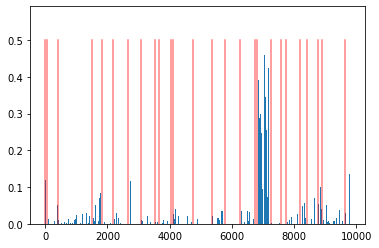

T_ACC =0.06086760014295578
T_BLCA =0.004072979092597961
T_BRCA =0.007554821204394102
T_CESC =0.01626792922616005
T_HBC =0.0036774391774088144
T_COREAD =0.004196253605186939
T_DLBC =0.007260181941092014
T_GESCA =0.0059121595695614815
T_GBM =0.016984377056360245
T_HNSC =0.003949994686990976
T_KICH =0.009777272120118141
T_KC =0.00899215042591095
T_LAML =0.0012775802752003074
T_LGG =0.00786591786891222
T_LUAD =0.005174696911126375
T_LUSC =0.006641910877078772
T_MESO =0.0158514603972435
T_GC =0.26033303141593933
T_PAAD =0.004579220432788134
T_PCPG =0.0018924213945865631
T_PRAD =0.006316123530268669
T_SARC =0.025091534480452538
T_SKCM =0.006135703530162573
T_TGCT =0.038174793124198914
T_THCA =0.0066263629123568535
T_THYM =0.008478601463139057
14


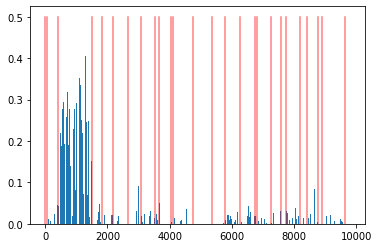

T_ACC =0.0017242146423086524
T_BLCA =0.010038437321782112
T_BRCA =0.20554135739803314
T_CESC =0.009216921404004097
T_HBC =0.004665394313633442
T_COREAD =0.004444857593625784
T_DLBC =0.005031005013734102
T_GESCA =0.011234606616199017
T_GBM =0.015788104385137558
T_HNSC =0.005352087318897247
T_KICH =0.0037008633371442556
T_KC =0.0037888202350586653
T_LAML =0.0005020434618927538
T_LGG =0.003582092234864831
T_LUAD =0.011969062499701977
T_LUSC =0.006346363574266434
T_MESO =0.004746126011013985
T_GC =0.01180898118764162
T_PAAD =0.003042686963453889
T_PCPG =0.0019873983692377806
T_PRAD =0.019916778430342674
T_SARC =0.007764826528728008
T_SKCM =0.012771588750183582
T_TGCT =0.002538311295211315
T_THCA =0.002284721937030554
T_THYM =0.006883417721837759
15


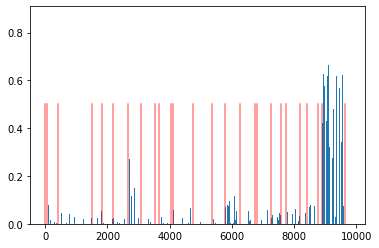

T_ACC =0.03117983788251877
T_BLCA =0.010120435617864132
T_BRCA =0.010139353573322296
T_CESC =0.0067271641455590725
T_HBC =0.005635680630803108
T_COREAD =0.007701276335865259
T_DLBC =0.04648112878203392
T_GESCA =0.004336004611104727
T_GBM =0.0018236348405480385
T_HNSC =0.008754556067287922
T_KICH =0.01565983146429062
T_KC =0.014435295946896076
T_LAML =0.004398528020828962
T_LGG =0.023068513721227646
T_LUAD =0.06623094528913498
T_LUSC =0.01094744261354208
T_MESO =0.000977969728410244
T_GC =0.016588451340794563
T_PAAD =0.011907356791198254
T_PCPG =0.0009237927151843905
T_PRAD =0.011923630721867085
T_SARC =0.006478696130216122
T_SKCM =0.03214623034000397
T_TGCT =0.00345808919519186
T_THCA =0.3827841281890869
T_THYM =0.017140133306384087
16


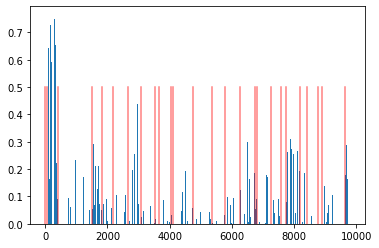

T_ACC =0.03706855699419975
T_BLCA =0.43889734148979187
T_BRCA =0.019233396276831627
T_CESC =0.1451324224472046
T_HBC =0.01715337671339512
T_COREAD =0.0202669408172369
T_DLBC =0.07945796102285385
T_GESCA =0.028274845331907272
T_GBM =0.002291006501764059
T_HNSC =0.04461751878261566
T_KICH =0.01323280856013298
T_KC =0.018679702654480934
T_LAML =0.00695039751008153
T_LGG =0.004113526549190283
T_LUAD =0.028972309082746506
T_LUSC =0.07909625768661499
T_MESO =0.10141689330339432
T_GC =0.03200642764568329
T_PAAD =0.03679128363728523
T_PCPG =0.002472486114129424
T_PRAD =0.09659496694803238
T_SARC =0.07772444933652878
T_SKCM =0.002992547582834959
T_TGCT =0.018749194219708443
T_THCA =0.010675952769815922
T_THYM =0.197345569729805
17


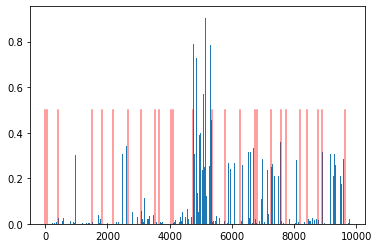

T_ACC =0.0006362782442010939
T_BLCA =0.0026298407465219498
T_BRCA =0.04283643886446953
T_CESC =0.024793868884444237
T_HBC =0.00161179865244776
T_COREAD =0.009829717688262463
T_DLBC =0.011497316882014275
T_GESCA =0.04230691120028496
T_GBM =0.007813040167093277
T_HNSC =0.0030313306488096714
T_KICH =0.0012062290916219354
T_KC =0.013834155164659023
T_LAML =0.41236409544944763
T_LGG =0.010180950164794922
T_LUAD =0.06599757820367813
T_LUSC =0.06195066124200821
T_MESO =0.006426978390663862
T_GC =0.07152479887008667
T_PAAD =0.10536198318004608
T_PCPG =0.011640976183116436
T_PRAD =0.037808608263731
T_SARC =0.006203683093190193
T_SKCM =0.02595880813896656
T_TGCT =0.001253630267456174
T_THCA =0.11502151936292648
T_THYM =0.00039605030906386673
18


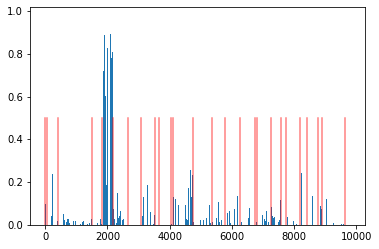

T_ACC =0.23745550215244293
T_BLCA =0.010518655180931091
T_BRCA =0.00974134262651205
T_CESC =0.0048845745623111725
T_HBC =0.7358421087265015
T_COREAD =0.04242326691746712
T_DLBC =0.007386408746242523
T_GESCA =0.028894750401377678
T_GBM =0.009281369857490063
T_HNSC =0.0058766864240169525
T_KICH =0.01931178569793701
T_KC =0.06303194910287857
T_LAML =0.012668311595916748
T_LGG =0.011978945694863796
T_LUAD =0.02108457311987877
T_LUSC =0.007974797859787941
T_MESO =0.024959763512015343
T_GC =0.012089356780052185
T_PAAD =0.03710426390171051
T_PCPG =0.010563201270997524
T_PRAD =0.01687796413898468
T_SARC =0.02105073258280754
T_SKCM =0.0252064261585474
T_TGCT =0.05675118789076805
T_THCA =0.0036046316381543875
T_THYM =0.008787383325397968
19


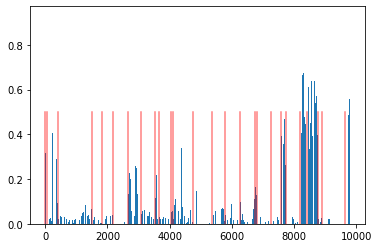

T_ACC =0.23782503604888916
T_BLCA =0.033683549612760544
T_BRCA =0.025315232574939728
T_CESC =0.026792464777827263
T_HBC =0.011698874644935131
T_COREAD =0.005184580106288195
T_DLBC =0.1898062378168106
T_GESCA =0.028775682672858238
T_GBM =0.11102188378572464
T_HNSC =0.023161055520176888
T_KICH =0.04444228112697601
T_KC =0.0355277918279171
T_LAML =0.0056564961560070515
T_LGG =0.022251030430197716
T_LUAD =0.012910701334476471
T_LUSC =0.025750290602445602
T_MESO =0.1768965870141983
T_GC =0.02201087959110737
T_PAAD =0.015191163867712021
T_PCPG =0.3240002393722534
T_PRAD =0.005908813327550888
T_SARC =0.4063773453235626
T_SKCM =0.524559497833252
T_TGCT =0.03736148029565811
T_THCA =0.002549943281337619
T_THYM =0.011024000123143196
20


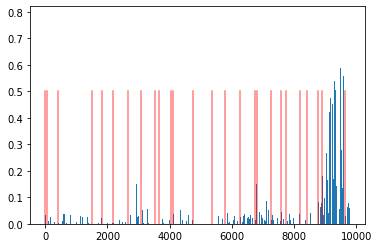

T_ACC =0.042803723365068436
T_BLCA =0.0038263031747192144
T_BRCA =0.008989119902253151
T_CESC =0.0032748037483543158
T_HBC =0.003515416057780385
T_COREAD =0.0035383121576160192
T_DLBC =0.02868076041340828
T_GESCA =0.005427362862974405
T_GBM =0.003707807743921876
T_HNSC =0.0047323633916676044
T_KICH =0.02269195206463337
T_KC =0.016190676018595695
T_LAML =0.00032392010325565934
T_LGG =0.008661637082695961
T_LUAD =0.008656355552375317
T_LUSC =0.013240252621471882
T_MESO =0.03899122029542923
T_GC =0.017788350582122803
T_PAAD =0.008278729394078255
T_PCPG =0.02015151083469391
T_PRAD =0.006371499504894018
T_SARC =0.02190021425485611
T_SKCM =0.00916585884988308
T_TGCT =0.03706555441021919
T_THCA =0.2783679962158203
T_THYM =0.05954544246196747
21


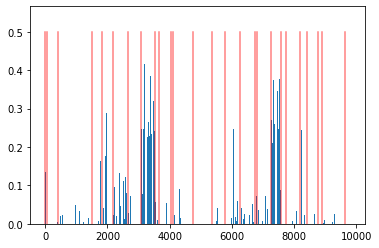

T_ACC =0.05985911935567856
T_BLCA =0.010953504592180252
T_BRCA =0.0032734419219195843
T_CESC =0.024957461282610893
T_HBC =0.04782242700457573
T_COREAD =0.04500698298215866
T_DLBC =0.031708650290966034
T_GESCA =0.23994998633861542
T_GBM =0.0119043393060565
T_HNSC =0.008817866444587708
T_KICH =0.002337557030841708
T_KC =0.018841270357370377
T_LAML =0.001958866836503148
T_LGG =0.004278697073459625
T_LUAD =0.030234843492507935
T_LUSC =0.014206819236278534
T_MESO =0.012985113076865673
T_GC =0.013046206906437874
T_PAAD =0.28592732548713684
T_PCPG =0.00877483282238245
T_PRAD =0.005276380106806755
T_SARC =0.023490319028496742
T_SKCM =0.002322930609807372
T_TGCT =0.025718925520777702
T_THCA =0.002455789363011718
T_THYM =0.0019854495767503977


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


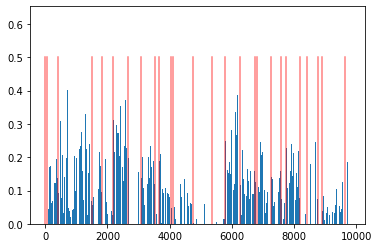

T_ACC =0.004085662309080362
T_BLCA =0.1175280436873436
T_BRCA =0.1532326340675354
T_CESC =0.12054291367530823
T_HBC =0.04194532707333565
T_COREAD =0.2632223069667816
T_DLBC =0.04680652916431427
T_GESCA =0.1373545229434967
T_GBM =0.013757512904703617
T_HNSC =0.09227165579795837
T_KICH =0.035100918263196945
T_KC =0.0507843978703022
T_LAML =0.0055855680257081985
T_LGG =0.011036595329642296
T_LUAD =0.17803268134593964
T_LUSC =0.11874944716691971
T_MESO =0.056110940873622894
T_GC =0.1504439115524292
T_PAAD =0.14660969376564026
T_PCPG =0.0314689539372921
T_PRAD =0.16573770344257355
T_SARC =0.01342726033180952
T_SKCM =0.03026345744729042
T_TGCT =0.08148714154958725
T_THCA =0.040149178355932236
T_THYM =0.09544278681278229
1


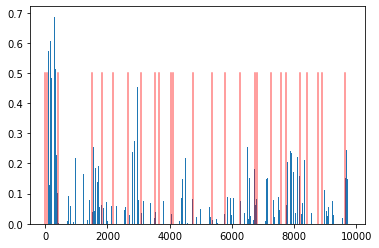

T_ACC =0.0552702359855175
T_BLCA =0.38811808824539185
T_BRCA =0.019921351224184036
T_CESC =0.1309228092432022
T_HBC =0.018517954275012016
T_COREAD =0.017619287595152855
T_DLBC =0.09333250671625137
T_GESCA =0.029659563675522804
T_GBM =0.003056206274777651
T_HNSC =0.039859119802713394
T_KICH =0.013363148085772991
T_KC =0.0194508396089077
T_LAML =0.00839939434081316
T_LGG =0.005210408940911293
T_LUAD =0.028615150600671768
T_LUSC =0.07278628647327423
T_MESO =0.10738708078861237
T_GC =0.03137925639748573
T_PAAD =0.03454168140888214
T_PCPG =0.002844375092536211
T_PRAD =0.08191748708486557
T_SARC =0.09155292063951492
T_SKCM =0.0034498446621000767
T_TGCT =0.01599280908703804
T_THCA =0.009436517022550106
T_THYM =0.16904884576797485
2


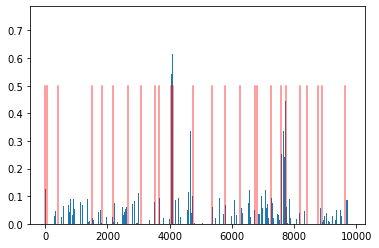

T_ACC =0.09955143928527832
T_BLCA =0.012323080562055111
T_BRCA =0.030559871345758438
T_CESC =0.016391033306717873
T_HBC =0.01605045050382614
T_COREAD =0.01900528185069561
T_DLBC =0.018618911504745483
T_GESCA =0.012267787009477615
T_GBM =0.0027683544903993607
T_HNSC =0.008162863552570343
T_KICH =0.5155361890792847
T_KC =0.07848092168569565
T_LAML =0.0332777202129364
T_LGG =0.011686890386044979
T_LUAD =0.032288458198308945
T_LUSC =0.015280129387974739
T_MESO =0.003447876311838627
T_GC =0.04313575476408005
T_PAAD =0.030517516657710075
T_PCPG =0.25995051860809326
T_PRAD =0.029781971126794815
T_SARC =0.01529362890869379
T_SKCM =0.004548030439764261
T_TGCT =0.003648733487352729
T_THCA =0.014105509035289288
T_THYM =0.041157834231853485
3


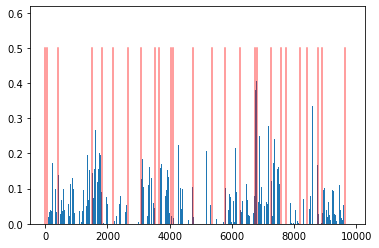

T_ACC =0.019723564386367798
T_BLCA =0.07155485451221466
T_BRCA =0.045808300375938416
T_CESC =0.10378982126712799
T_HBC =0.021404793485999107
T_COREAD =0.03922519460320473
T_DLBC =0.0067698960192501545
T_GESCA =0.07344907522201538
T_GBM =0.003291659289970994
T_HNSC =0.07388889044523239
T_KICH =0.01333643775433302
T_KC =0.06580746173858643
T_LAML =0.010427254252135754
T_LGG =0.007187045644968748
T_LUAD =0.0813266709446907
T_LUSC =0.03832293301820755
T_MESO =0.2947051227092743
T_GC =0.07400641590356827
T_PAAD =0.13812260329723358
T_PCPG =0.005199766717851162
T_PRAD =0.011657820083200932
T_SARC =0.06889204680919647
T_SKCM =0.03662044554948807
T_TGCT =0.004836129955947399
T_THCA =0.03628275543451309
T_THYM =0.003260980127379298
4


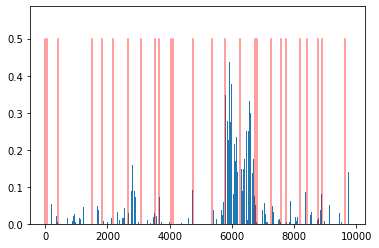

T_ACC =0.006782973650842905
T_BLCA =0.011585017666220665
T_BRCA =0.00871785543859005
T_CESC =0.00719966646283865
T_HBC =0.008527515456080437
T_COREAD =0.007751870900392532
T_DLBC =0.026110801845788956
T_GESCA =0.013399130664765835
T_GBM =0.014864334836602211
T_HNSC =0.008620950393378735
T_KICH =0.0021942565217614174
T_KC =0.00975368544459343
T_LAML =0.0011577073018997908
T_LGG =0.016932370141148567
T_LUAD =0.25660035014152527
T_LUSC =0.15188737213611603
T_MESO =0.07490862160921097
T_GC =0.013184264302253723
T_PAAD =0.014425800181925297
T_PCPG =0.0033193398267030716
T_PRAD =0.014513635076582432
T_SARC =0.018534701317548752
T_SKCM =0.01615210436284542
T_TGCT =0.05672110989689827
T_THCA =0.007644969504326582
T_THYM =0.004486070945858955
5


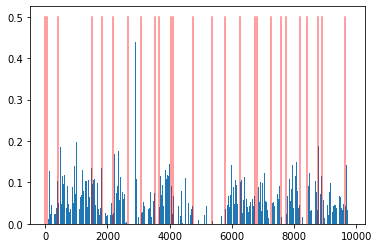

T_ACC =0.0020638126879930496
T_BLCA =0.057679690420627594
T_BRCA =0.0860663503408432
T_CESC =0.0639827772974968
T_HBC =0.02611273154616356
T_COREAD =0.07531780004501343
T_DLBC =0.015619565732777119
T_GESCA =0.05416720360517502
T_GBM =0.0009808314498513937
T_HNSC =0.08566059172153473
T_KICH =0.07107479125261307
T_KC =0.026785951107740402
T_LAML =0.0024652788415551186
T_LGG =0.0012599717592820525
T_LUAD =0.060558028519153595
T_LUSC =0.06694929301738739
T_MESO =0.0068180132657289505
T_GC =0.06141810491681099
T_PAAD =0.04214487969875336
T_PCPG =0.0025052884593605995
T_PRAD =0.09377267956733704
T_SARC =0.007259891834110022
T_SKCM =0.03842261806130409
T_TGCT =0.1495010107755661
T_THCA =0.03408481180667877
T_THYM =0.06807199865579605
6


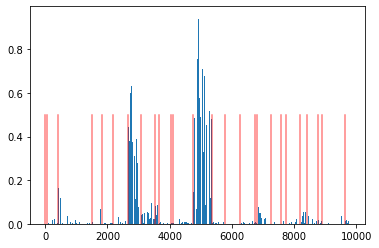

T_ACC =0.004078928381204605
T_BLCA =0.0016680865082889795
T_BRCA =0.008528240956366062
T_CESC =0.0032404994126409292
T_HBC =0.0017689374508336186
T_COREAD =0.00763047905638814
T_DLBC =0.3623883128166199
T_GESCA =0.0359371155500412
T_GBM =0.08075287938117981
T_HNSC =0.001951179699972272
T_KICH =0.0006864644819870591
T_KC =0.0037286756560206413
T_LAML =0.437993586063385
T_LGG =0.0022654386702924967
T_LUAD =0.0013362620957195759
T_LUSC =0.0022805151529610157
T_MESO =0.0036657103337347507
T_GC =0.037811003625392914
T_PAAD =0.00941676739603281
T_PCPG =0.0042635854333639145
T_PRAD =0.0059524355456233025
T_SARC =0.012633731588721275
T_SKCM =0.01027884241193533
T_TGCT =0.006164099555462599
T_THCA =0.010097889229655266
T_THYM =0.012914362363517284
7


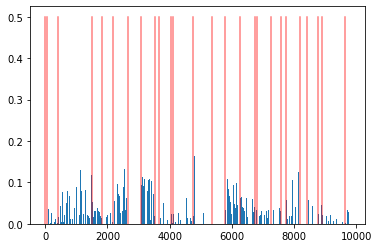

T_ACC =0.0038944976404309273
T_BLCA =0.025433700531721115
T_BRCA =0.042618732899427414
T_CESC =0.045119211077690125
T_HBC =0.005959558300673962
T_COREAD =0.045603398233652115
T_DLBC =0.006762680597603321
T_GESCA =0.0731440857052803
T_GBM =0.00018209137488156557
T_HNSC =0.020506789907813072
T_KICH =0.027981914579868317
T_KC =0.017301104962825775
T_LAML =0.010789266787469387
T_LGG =0.0007561124511994421
T_LUAD =0.05415331944823265
T_LUSC =0.026939833536744118
T_MESO =0.005083826836198568
T_GC =0.025467371568083763
T_PAAD =0.01909354142844677
T_PCPG =0.0010788128711283207
T_PRAD =0.026384059339761734
T_SARC =0.0009937770664691925
T_SKCM =0.012733547948300838
T_TGCT =0.020677683874964714
T_THCA =0.004960295278578997
T_THYM =0.014290915802121162
8


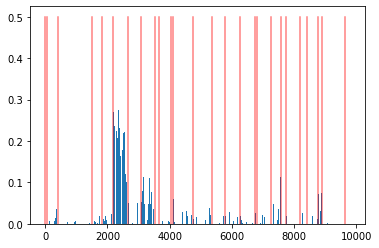

T_ACC =0.0013759166467934847
T_BLCA =0.005626250524073839
T_BRCA =0.0013328766217455268
T_CESC =0.00603516073897481
T_HBC =0.00635595852509141
T_COREAD =0.2214149385690689
T_DLBC =0.014134708791971207
T_GESCA =0.04549083486199379
T_GBM =0.00131214689463377
T_HNSC =0.002249664394184947
T_KICH =0.0004634071374312043
T_KC =0.008892853744328022
T_LAML =0.008794045075774193
T_LGG =0.002553786849603057
T_LUAD =0.006163641810417175
T_LUSC =0.0016179315280169249
T_MESO =0.002776865381747484
T_GC =0.004830353427678347
T_PAAD =0.0172796081751585
T_PCPG =0.00020789681002497673
T_PRAD =0.0020401817746460438
T_SARC =0.0083879129961133
T_SKCM =0.006042062770575285
T_TGCT =0.04849750176072121
T_THCA =0.0005066621233709157
T_THYM =0.0
9


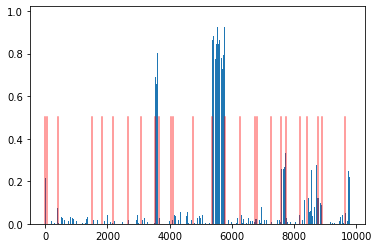

T_ACC =0.1223205029964447
T_BLCA =0.007830587215721607
T_BRCA =0.00701485201716423
T_CESC =0.003452036064118147
T_HBC =0.008984037674963474
T_COREAD =0.0014148443005979061
T_DLBC =0.012743815779685974
T_GESCA =0.005084877368062735
T_GBM =0.6689867973327637
T_HNSC =0.003950228914618492
T_KICH =0.011142738163471222
T_KC =0.019654765725135803
T_LAML =0.007316967938095331
T_LGG =0.8247804641723633
T_LUAD =0.004859243519604206
T_LUSC =0.006147752050310373
T_MESO =0.015815680846571922
T_GC =0.010090496391057968
T_PAAD =0.005707820877432823
T_PCPG =0.3143260180950165
T_PRAD =0.011248801834881306
T_SARC =0.10438472777605057
T_SKCM =0.10429760813713074
T_TGCT =0.05825328081846237
T_THCA =0.009753674268722534
T_THYM =0.03341419994831085
10


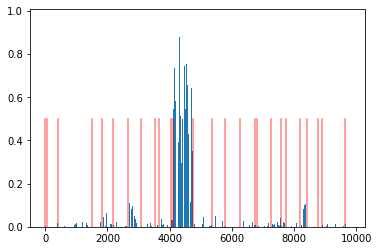

T_ACC =0.012722705490887165
T_BLCA =0.0021369741298258305
T_BRCA =0.0022892276756465435
T_CESC =0.004601967521011829
T_HBC =0.01675776205956936
T_COREAD =0.00539372256025672
T_DLBC =0.024187300354242325
T_GESCA =0.004473485983908176
T_GBM =0.007214330602437258
T_HNSC =0.0021738249342888594
T_KICH =0.04370030388236046
T_KC =0.4816615879535675
T_LAML =0.012743021361529827
T_LGG =0.006616829428821802
T_LUAD =0.0035454982426017523
T_LUSC =0.0016653399216011167
T_MESO =0.02453237771987915
T_GC =0.008069037459790707
T_PAAD =0.011803045868873596
T_PCPG =0.015013656578958035
T_PRAD =0.0016335672698915005
T_SARC =0.06548406183719635
T_SKCM =0.0016471932176500559
T_TGCT =0.012358351610600948
T_THCA =0.0022193219047039747
T_THYM =0.007504662033170462
11


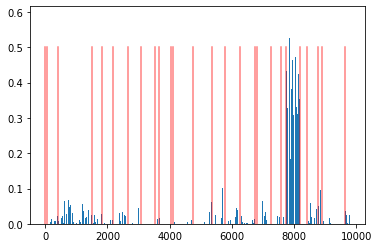

T_ACC =0.010650544427335262
T_BLCA =0.004594426602125168
T_BRCA =0.015917280688881874
T_CESC =0.007513327524065971
T_HBC =0.003594844602048397
T_COREAD =0.00609642593190074
T_DLBC =0.0020705307833850384
T_GESCA =0.005008543375879526
T_GBM =0.007109371945261955
T_HNSC =0.003478089813143015
T_KICH =0.0031549527775496244
T_KC =0.004177632741630077
T_LAML =0.0040395790711045265
T_LGG =0.004642014857381582
T_LUAD =0.00710309948772192
T_LUSC =0.004379392601549625
T_MESO =0.00029568999889306724
T_GC =0.01048553641885519
T_PAAD =0.005519336089491844
T_PCPG =0.015147749334573746
T_PRAD =0.3495389521121979
T_SARC =0.009794928133487701
T_SKCM =0.011005468666553497
T_TGCT =0.013958288356661797
T_THCA =0.00189874111674726
T_THYM =0.017702432349324226
12


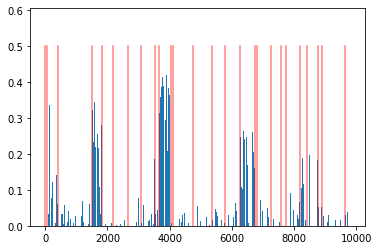

T_ACC =0.020465128123760223
T_BLCA =0.06917231529951096
T_BRCA =0.012897144071757793
T_CESC =0.19878935813903809
T_HBC =0.0030534856487065554
T_COREAD =0.010180188342928886
T_DLBC =0.010890512727200985
T_GESCA =0.05692274495959282
T_GBM =0.015273654833436012
T_HNSC =0.3578454554080963
T_KICH =0.003171805990859866
T_KC =0.005311305169016123
T_LAML =0.004107725340873003
T_LGG =0.007307406980544329
T_LUAD =0.01322973147034645
T_LUSC =0.18689364194869995
T_MESO =0.0059789628721773624
T_GC =0.011625025421380997
T_PAAD =0.008066427893936634
T_PCPG =5.240903556114063e-05
T_PRAD =0.01063846331089735
T_SARC =0.023962611332535744
T_SKCM =0.04116993024945259
T_TGCT =0.027334727346897125
T_THCA =0.004102731589227915
T_THYM =0.038713011890649796
13


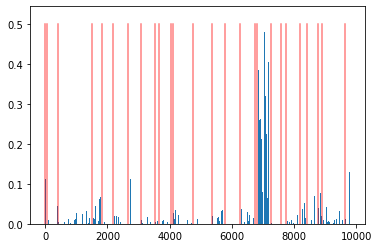

T_ACC =0.05472106486558914
T_BLCA =0.0033858302049338818
T_BRCA =0.007065363693982363
T_CESC =0.014794517308473587
T_HBC =0.003397628664970398
T_COREAD =0.0036824399139732122
T_DLBC =0.006287333555519581
T_GESCA =0.00511584896594286
T_GBM =0.01658637262880802
T_HNSC =0.0033841687254607677
T_KICH =0.007890086621046066
T_KC =0.008694705553352833
T_LAML =0.0011304501676931977
T_LGG =0.007592962123453617
T_LUAD =0.0042265900410711765
T_LUSC =0.005399771500378847
T_MESO =0.01118257362395525
T_GC =0.23794567584991455
T_PAAD =0.003870356595143676
T_PCPG =0.0014666239731013775
T_PRAD =0.005317973904311657
T_SARC =0.02202853001654148
T_SKCM =0.005901984870433807
T_TGCT =0.028752855956554413
T_THCA =0.005784039851278067
T_THYM =0.0043576424941420555
14


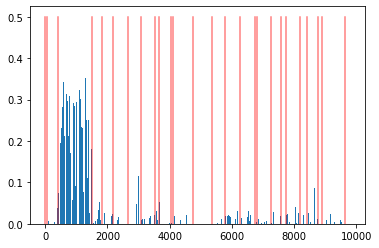

T_ACC =0.0007993631297722459
T_BLCA =0.007593497168272734
T_BRCA =0.21303369104862213
T_CESC =0.010620524175465107
T_HBC =0.004564409144222736
T_COREAD =0.003964537288993597
T_DLBC =0.006690498907119036
T_GESCA =0.00914775300770998
T_GBM =0.017560049891471863
T_HNSC =0.006529609207063913
T_KICH =0.002811835380271077
T_KC =0.0031392364762723446
T_LAML =0.0006208703853189945
T_LGG =0.004181701689958572
T_LUAD =0.011615335009992123
T_LUSC =0.006207003723829985
T_MESO =0.0026742673944681883
T_GC =0.011092334054410458
T_PAAD =0.0026041523087769747
T_PCPG =0.0012978584272786975
T_PRAD =0.018212489783763885
T_SARC =0.008732921443879604
T_SKCM =0.01284219603985548
T_TGCT =0.001699827960692346
T_THCA =0.002270744415000081
T_THYM =0.0037712017074227333
15


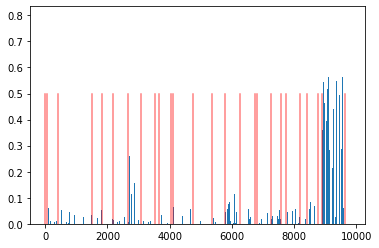

T_ACC =0.029294010251760483
T_BLCA =0.009179791435599327
T_BRCA =0.010426790453493595
T_CESC =0.005203449632972479
T_HBC =0.005381732247769833
T_COREAD =0.006785149220377207
T_DLBC =0.04577703773975372
T_GESCA =0.004456002730876207
T_GBM =0.0019935478921979666
T_HNSC =0.007640017196536064
T_KICH =0.01556359976530075
T_KC =0.013558846898376942
T_LAML =0.004179580137133598
T_LGG =0.023059649392962456
T_LUAD =0.05978185683488846
T_LUSC =0.011256923899054527
T_MESO =0.0018602097406983376
T_GC =0.017246181145310402
T_PAAD =0.010486212559044361
T_PCPG =0.001011210959404707
T_PRAD =0.011176129803061485
T_SARC =0.005950192920863628
T_SKCM =0.029017487540841103
T_TGCT =0.0032947382424026728
T_THCA =0.3288961350917816
T_THYM =0.01304544135928154
16


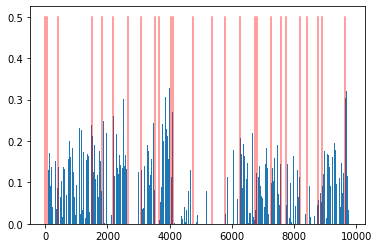

T_ACC =0.0031957386527210474
T_BLCA =0.11084678024053574
T_BRCA =0.11736862361431122
T_CESC =0.1189834475517273
T_HBC =0.02503548003733158
T_COREAD =0.16234175860881805
T_DLBC =0.008004352450370789
T_GESCA =0.1140264943242073
T_GBM =0.000832615012768656
T_HNSC =0.1514638066291809
T_KICH =0.15712758898735046
T_KC =0.0342700220644474
T_LAML =0.015523905865848064
T_LGG =0.0013307639164850116
T_LUAD =0.0467442162334919
T_LUSC =0.10792701691389084
T_MESO =0.03413192927837372
T_GC =0.08299937099218369
T_PAAD =0.10463511943817139
T_PCPG =0.0042744833044707775
T_PRAD =0.05862332880496979
T_SARC =0.030511682853102684
T_SKCM =0.03892771899700165
T_TGCT =0.090593621134758
T_THCA =0.12899355590343475
T_THYM =0.21267098188400269
17


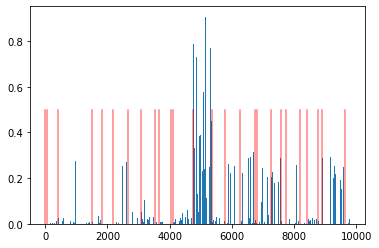

T_ACC =0.0005831708549521863
T_BLCA =0.002385447034612298
T_BRCA =0.04087159037590027
T_CESC =0.02265165001153946
T_HBC =0.001535050105303526
T_COREAD =0.008317135274410248
T_DLBC =0.011378969997167587
T_GESCA =0.03832529857754707
T_GBM =0.007760129868984222
T_HNSC =0.0027851308695971966
T_KICH =0.0008246646029874682
T_KC =0.013343156315386295
T_LAML =0.4055667519569397
T_LGG =0.01017677504569292
T_LUAD =0.06007970869541168
T_LUSC =0.056467872112989426
T_MESO =0.006512358319014311
T_GC =0.0637459009885788
T_PAAD =0.09174806624650955
T_PCPG =0.010680041275918484
T_PRAD =0.035609859973192215
T_SARC =0.006037854589521885
T_SKCM =0.02555202879011631
T_TGCT =0.0012238722993060946
T_THCA =0.10339201986789703
T_THYM =0.0005907963495701551
18


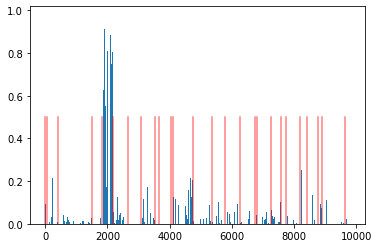

T_ACC =0.227697491645813
T_BLCA =0.009719349443912506
T_BRCA =0.009306607767939568
T_CESC =0.003983885515481234
T_HBC =0.7177676558494568
T_COREAD =0.0333600677549839
T_DLBC =0.006383177824318409
T_GESCA =0.025808662176132202
T_GBM =0.00898861326277256
T_HNSC =0.005312145221978426
T_KICH =0.014430857263505459
T_KC =0.060671452432870865
T_LAML =0.013058356009423733
T_LGG =0.01176395732909441
T_LUAD =0.01696118898689747
T_LUSC =0.006948783528059721
T_MESO =0.02747068554162979
T_GC =0.0106328334659338
T_PAAD =0.030331403017044067
T_PCPG =0.009724133647978306
T_PRAD =0.015508873388171196
T_SARC =0.023093007504940033
T_SKCM =0.026500051841139793
T_TGCT =0.05681496113538742
T_THCA =0.0032325664069503546
T_THYM =0.009563497267663479
19


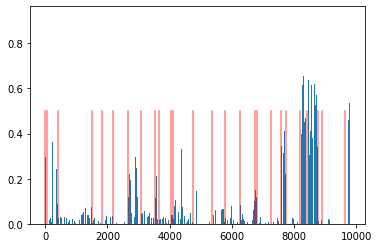

T_ACC =0.222526416182518
T_BLCA =0.029945481568574905
T_BRCA =0.024101879447698593
T_CESC =0.023274587467312813
T_HBC =0.010968689806759357
T_COREAD =0.0041425894014537334
T_DLBC =0.18298806250095367
T_GESCA =0.026299627497792244
T_GBM =0.10663352161645889
T_HNSC =0.020704302936792374
T_KICH =0.034355297684669495
T_KC =0.03335580602288246
T_LAML =0.004874000325798988
T_LGG =0.021033696830272675
T_LUAD =0.011142472736537457
T_LUSC =0.024409880861639977
T_MESO =0.16621066629886627
T_GC =0.020208973437547684
T_PAAD =0.012647728435695171
T_PCPG =0.2845722734928131
T_PRAD =0.005348128732293844
T_SARC =0.38846874237060547
T_SKCM =0.5036171674728394
T_TGCT =0.03385244682431221
T_THCA =0.0022704112343490124
T_THYM =0.00965841207653284
20


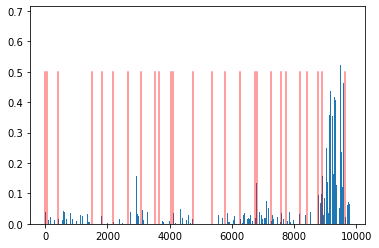

T_ACC =0.04459408298134804
T_BLCA =0.0033944272436201572
T_BRCA =0.010218188166618347
T_CESC =0.002756362548097968
T_HBC =0.0035335274878889322
T_COREAD =0.0024093417450785637
T_DLBC =0.031019428744912148
T_GESCA =0.0052802241407334805
T_GBM =0.004014560952782631
T_HNSC =0.003862345591187477
T_KICH =0.0196369718760252
T_KC =0.015421523712575436
T_LAML =0.0002564546884968877
T_LGG =0.009128016419708729
T_LUAD =0.007245034910738468
T_LUSC =0.012530644424259663
T_MESO =0.043341465294361115
T_GC =0.016800934448838234
T_PAAD =0.006680856458842754
T_PCPG =0.018095089122653008
T_PRAD =0.005606238730251789
T_SARC =0.023366985842585564
T_SKCM =0.009104948490858078
T_TGCT =0.051196880638599396
T_THCA =0.23812487721443176
T_THYM =0.05519237741827965
21


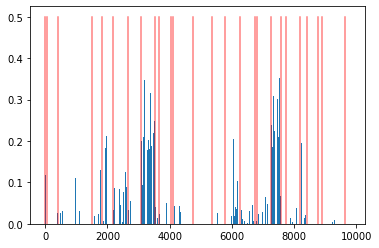

T_ACC =0.047641877084970474
T_BLCA =0.009946074336767197
T_BRCA =0.004965389613062143
T_CESC =0.027733957394957542
T_HBC =0.04304781183600426
T_COREAD =0.039662353694438934
T_DLBC =0.02855433151125908
T_GESCA =0.2040168046951294
T_GBM =0.012806772254407406
T_HNSC =0.009955190122127533
T_KICH =0.0012984351487830281
T_KC =0.01644713617861271
T_LAML =0.0017291988478973508
T_LGG =0.0037323893047869205
T_LUAD =0.03245269134640694
T_LUSC =0.011683961376547813
T_MESO =0.004212419036775827
T_GC =0.013899761252105236
T_PAAD =0.2419094741344452
T_PCPG =0.008515491150319576
T_PRAD =0.005737747065722942
T_SARC =0.01770769990980625
T_SKCM =0.002220285590738058
T_TGCT =0.02306007221341133
T_THCA =0.0012589981779456139
T_THYM =0.001647655968554318
22


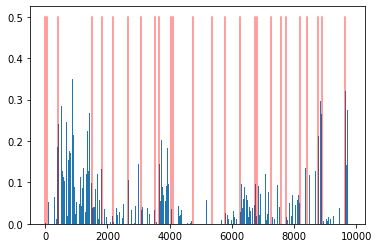

T_ACC =0.005960872396826744
T_BLCA =0.038352206349372864
T_BRCA =0.1277371495962143
T_CESC =0.05841703712940216
T_HBC =0.0057346574030816555
T_COREAD =0.015458865091204643
T_DLBC =0.032480742782354355
T_GESCA =0.021164286881685257
T_GBM =0.003273698501288891
T_HNSC =0.08774399012327194
T_KICH =0.005153220612555742
T_KC =0.009306984953582287
T_LAML =0.005963278468698263
T_LGG =0.005764798726886511
T_LUAD =0.021938784047961235
T_LUSC =0.063268281519413
T_MESO =0.10087665170431137
T_GC =0.04348151013255119
T_PAAD =0.011837915517389774
T_PCPG =0.004984400235116482
T_PRAD =0.03404150530695915
T_SARC =0.03350019082427025
T_SKCM =0.02968500182032585
T_TGCT =0.2100798785686493
T_THCA =0.010533562861382961
T_THYM =0.18349391222000122


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


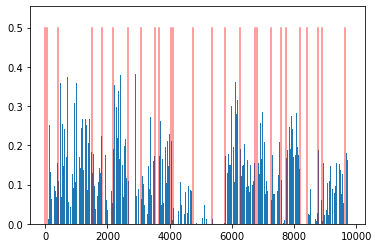

T_ACC =0.0048345779068768024
T_BLCA =0.13791552186012268
T_BRCA =0.18337121605873108
T_CESC =0.13796734809875488
T_HBC =0.05198322981595993
T_COREAD =0.21329976618289948
T_DLBC =0.03936212137341499
T_GESCA =0.12537308037281036
T_GBM =0.0023812525905668736
T_HNSC =0.14623482525348663
T_KICH =0.1559656709432602
T_KC =0.050237517803907394
T_LAML =0.004389059729874134
T_LGG =0.0027362641412764788
T_LUAD =0.16943983733654022
T_LUSC =0.1410943865776062
T_MESO =0.013015191070735455
T_GC =0.1481328010559082
T_PAAD =0.14119459688663483
T_PCPG =0.01597229577600956
T_PRAD =0.2344290316104889
T_SARC =0.008099853992462158
T_SKCM =0.02493073046207428
T_TGCT =0.21269425749778748
T_THCA =0.07065512984991074
T_THYM =0.13316266238689423
1


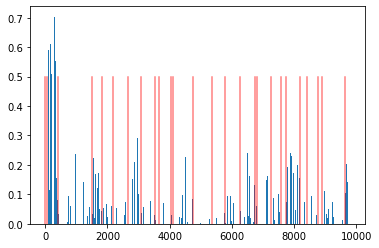

T_ACC =0.02605653926730156
T_BLCA =0.37631186842918396
T_BRCA =0.01881519891321659
T_CESC =0.11614885181188583
T_HBC =0.017589116469025612
T_COREAD =0.0172621738165617
T_DLBC =0.056049223989248276
T_GESCA =0.027632402256131172
T_GBM =0.0025732077192515135
T_HNSC =0.03399122506380081
T_KICH =0.012070759199559689
T_KC =0.017477532848715782
T_LAML =0.0024222193751484156
T_LGG =0.004535774700343609
T_LUAD =0.029976340010762215
T_LUSC =0.06381992995738983
T_MESO =0.05675288662314415
T_GC =0.02939065918326378
T_PAAD =0.035493191331624985
T_PCPG =0.0007690935162827373
T_PRAD =0.0779312252998352
T_SARC =0.034058939665555954
T_SKCM =0.004140361677855253
T_TGCT =0.01251266896724701
T_THCA =0.008991729468107224
T_THYM =0.15127620100975037
2


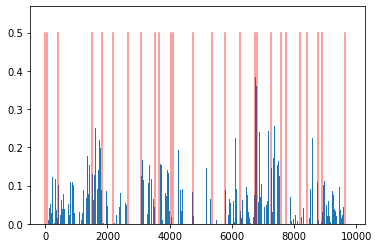

T_ACC =0.01669241487979889
T_BLCA =0.07204452902078629
T_BRCA =0.042118627578020096
T_CESC =0.09841198474168777
T_HBC =0.023756811395287514
T_COREAD =0.038706228137016296
T_DLBC =0.004137696232646704
T_GESCA =0.07072409242391586
T_GBM =0.0024213327560573816
T_HNSC =0.06966038048267365
T_KICH =0.013362227939069271
T_KC =0.06291354447603226
T_LAML =0.007088766433298588
T_LGG =0.006252835039049387
T_LUAD =0.0776139423251152
T_LUSC =0.036512695252895355
T_MESO =0.2747511565685272
T_GC =0.06942840665578842
T_PAAD =0.14961965382099152
T_PCPG =0.004318748600780964
T_PRAD =0.013107528910040855
T_SARC =0.05008215457201004
T_SKCM =0.025228964164853096
T_TGCT =0.0046599251218140125
T_THCA =0.0341573990881443
T_THYM =0.004131777677685022
3


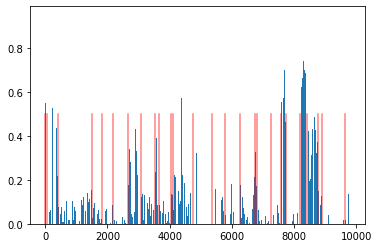

T_ACC =0.39288032054901123
T_BLCA =0.0658641904592514
T_BRCA =0.06380069255828857
T_CESC =0.07241368293762207
T_HBC =0.01982899010181427
T_COREAD =0.011883355677127838
T_DLBC =0.27381885051727295
T_GESCA =0.07089632749557495
T_GBM =0.18483877182006836
T_HNSC =0.05934508889913559
T_KICH =0.09849664568901062
T_KC =0.09479264914989471
T_LAML =0.009327076375484467
T_LGG =0.028930356726050377
T_LUAD =0.024451328441500664
T_LUSC =0.06586580723524094
T_MESO =0.3178860545158386
T_GC =0.051184188574552536
T_PAAD =0.035181138664484024
T_PCPG =0.5057209134101868
T_PRAD =0.01255483366549015
T_SARC =0.5563167333602905
T_SKCM =0.3328295648097992
T_TGCT =0.1326112151145935
T_THCA =0.004199264571070671
T_THYM =0.029956426471471786
4


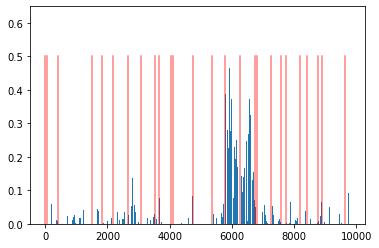

T_ACC =0.0047317068092525005
T_BLCA =0.011702880263328552
T_BRCA =0.008934210985898972
T_CESC =0.006935299839824438
T_HBC =0.00802629254758358
T_COREAD =0.00847394298762083
T_DLBC =0.01882862113416195
T_GESCA =0.013859950006008148
T_GBM =0.012439440004527569
T_HNSC =0.00826994888484478
T_KICH =0.0018337087240070105
T_KC =0.008855778723955154
T_LAML =0.0013569951988756657
T_LGG =0.017731452360749245
T_LUAD =0.27169668674468994
T_LUSC =0.15468157827854156
T_MESO =0.06752660870552063
T_GC =0.013290101662278175
T_PAAD =0.015374762006103992
T_PCPG =0.0025084353983402252
T_PRAD =0.014871863648295403
T_SARC =0.012037165462970734
T_SKCM =0.008330333977937698
T_TGCT =0.05169632285833359
T_THCA =0.007197115104645491
T_THYM =0.005056123714894056
5


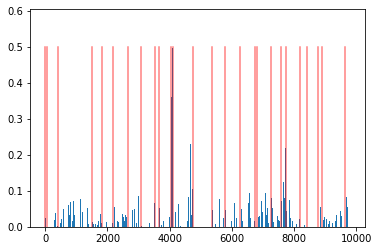

T_ACC =0.045696139335632324
T_BLCA =0.008849200792610645
T_BRCA =0.02142264135181904
T_CESC =0.01033535972237587
T_HBC =0.012643426656723022
T_COREAD =0.013094983994960785
T_DLBC =0.008842826820909977
T_GESCA =0.008910768665373325
T_GBM =0.0012331173056736588
T_HNSC =0.0059941550716757774
T_KICH =0.37698400020599365
T_KC =0.05697863548994064
T_LAML =0.011924074031412601
T_LGG =0.00907938927412033
T_LUAD =0.025514008477330208
T_LUSC =0.010827954858541489
T_MESO =0.0020914226770401
T_GC =0.029298080131411552
T_PAAD =0.022026436403393745
T_PCPG =0.10679369419813156
T_PRAD =0.022758765146136284
T_SARC =0.006550570484250784
T_SKCM =0.004844143521040678
T_TGCT =0.0021856562234461308
T_THCA =0.011833022348582745
T_THYM =0.03161737322807312
6


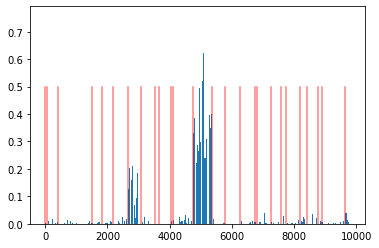

T_ACC =0.0021389953326433897
T_BLCA =0.0021066060289740562
T_BRCA =0.001984484726563096
T_CESC =0.0038797431625425816
T_HBC =0.002457858296111226
T_COREAD =0.003284256672486663
T_DLBC =0.09549268335103989
T_GESCA =0.0034158495254814625
T_GBM =0.0023919972591102123
T_HNSC =0.0009738923981785774
T_KICH =0.0014452117029577494
T_KC =0.006493257824331522
T_LAML =0.35840851068496704
T_LGG =0.004327333997935057
T_LUAD =0.0016192866023629904
T_LUSC =0.002164217410609126
T_MESO =0.0014546572929248214
T_GC =0.005287609063088894
T_PAAD =0.0033824730198830366
T_PCPG =0.0036088558845221996
T_PRAD =0.0020005579572170973
T_SARC =0.009661496616899967
T_SKCM =0.0079663610085845
T_TGCT =0.005697944667190313
T_THCA =0.0016312296502292156
T_THYM =0.026948392391204834
7


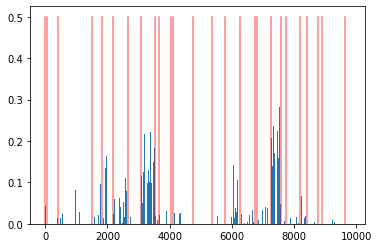

T_ACC =0.018289752304553986
T_BLCA =0.00756611255928874
T_BRCA =0.0035574983339756727
T_CESC =0.02249377965927124
T_HBC =0.03188095614314079
T_COREAD =0.03121444396674633
T_DLBC =0.012682723812758923
T_GESCA =0.13202212750911713
T_GBM =0.0070571801625192165
T_HNSC =0.007059207186102867
T_KICH =0.0009938511066138744
T_KC =0.012134491465985775
T_LAML =0.0022012556437402964
T_LGG =0.0030570297967642546
T_LUAD =0.026730617508292198
T_LUSC =0.008374352939426899
T_MESO =0.0016163518885150552
T_GC =0.011973417364060879
T_PAAD =0.18955469131469727
T_PCPG =0.0036951852962374687
T_PRAD =0.004140924662351608
T_SARC =0.007551880087703466
T_SKCM =0.0025166787672787905
T_TGCT =0.013922000303864479
T_THCA =0.000874938617926091
T_THYM =0.0011676541762426496
8


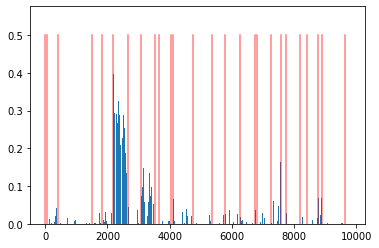

T_ACC =0.0009528282680548728
T_BLCA =0.0067267403937876225
T_BRCA =0.0017802538350224495
T_CESC =0.007342441938817501
T_HBC =0.007806848734617233
T_COREAD =0.2915955185890198
T_DLBC =0.011838151142001152
T_GESCA =0.05977433919906616
T_GBM =0.0016602291725575924
T_HNSC =0.002676555188372731
T_KICH =0.00039520722930319607
T_KC =0.009705008938908577
T_LAML =0.0032149229664355516
T_LGG =0.0030466285534203053
T_LUAD =0.007306821644306183
T_LUSC =0.0019101211801171303
T_MESO =0.0027954275719821453
T_GC =0.006196556147187948
T_PAAD =0.02407543733716011
T_PCPG =0.0004166456637904048
T_PRAD =0.0026638598646968603
T_SARC =0.006875563412904739
T_SKCM =0.004109302069991827
T_TGCT =0.04828506335616112
T_THCA =0.0006108898669481277
T_THYM =0.0
9


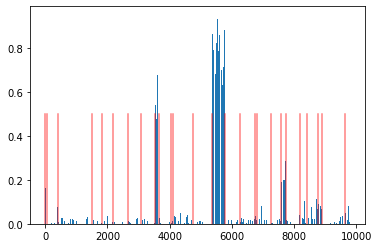

T_ACC =0.10310952365398407
T_BLCA =0.007086537312716246
T_BRCA =0.006039705127477646
T_CESC =0.003365318523719907
T_HBC =0.007551003713160753
T_COREAD =0.001069496851414442
T_DLBC =0.011281328275799751
T_GESCA =0.004903463646769524
T_GBM =0.5321576595306396
T_HNSC =0.00368982320651412
T_KICH =0.012488131411373615
T_KC =0.01770072430372238
T_LAML =0.0030189494136720896
T_LGG =0.7838404178619385
T_LUAD =0.004117707721889019
T_LUSC =0.005900924559682608
T_MESO =0.021124131977558136
T_GC =0.010028422810137272
T_PAAD =0.005570467095822096
T_PCPG =0.24912694096565247
T_PRAD =0.009679920971393585
T_SARC =0.08757222443819046
T_SKCM =0.027909206226468086
T_TGCT =0.046209726482629776
T_THCA =0.008007179014384747
T_THYM =0.03177782520651817
10


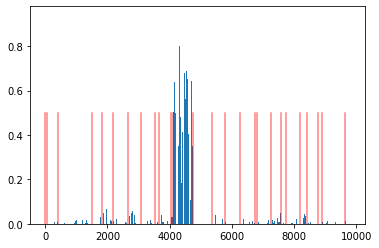

T_ACC =0.005854710936546326
T_BLCA =0.0019252620404586196
T_BRCA =0.001957693137228489
T_CESC =0.0033135386183857918
T_HBC =0.01646394468843937
T_COREAD =0.005736519116908312
T_DLBC =0.009732200764119625
T_GESCA =0.004474376793950796
T_GBM =0.005240371450781822
T_HNSC =0.0018425588496029377
T_KICH =0.04305936396121979
T_KC =0.44902095198631287
T_LAML =0.0023893851321190596
T_LGG =0.005567247048020363
T_LUAD =0.0032139155082404613
T_LUSC =0.0014420375227928162
T_MESO =0.014554277993738651
T_GC =0.007450548466295004
T_PAAD =0.01289528701454401
T_PCPG =0.00651435786858201
T_PRAD =0.0016953585436567664
T_SARC =0.02796522155404091
T_SKCM =0.002839393448084593
T_TGCT =0.009288995526731014
T_THCA =0.0023004566319286823
T_THYM =0.006959226448088884
11


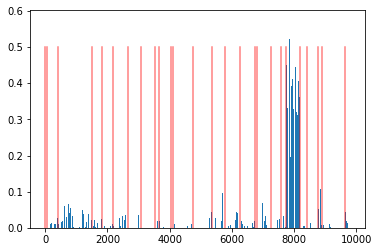

T_ACC =0.011326535604894161
T_BLCA =0.005233339034020901
T_BRCA =0.014319413341581821
T_CESC =0.007757185492664576
T_HBC =0.003699452616274357
T_COREAD =0.006125340238213539
T_DLBC =0.002010148949921131
T_GESCA =0.005312147084623575
T_GBM =0.007604666519910097
T_HNSC =0.003160193096846342
T_KICH =0.00302293011918664
T_KC =0.004283597227185965
T_LAML =0.0026100180111825466
T_LGG =0.004608806222677231
T_LUAD =0.006625560112297535
T_LUSC =0.004855983890593052
T_MESO =0.0015823887661099434
T_GC =0.010568538680672646
T_PAAD =0.006135019473731518
T_PCPG =0.019107887521386147
T_PRAD =0.3467853367328644
T_SARC =0.010222852230072021
T_SKCM =0.002269146265462041
T_TGCT =0.017686370760202408
T_THCA =0.0017556478269398212
T_THYM =0.021122731268405914
12


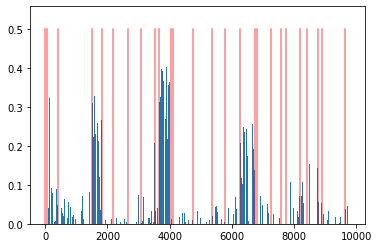

T_ACC =0.0189695805311203
T_BLCA =0.06793294101953506
T_BRCA =0.015488449484109879
T_CESC =0.19238945841789246
T_HBC =0.0029840378556400537
T_COREAD =0.012029418721795082
T_DLBC =0.008772295899689198
T_GESCA =0.052882734686136246
T_GBM =0.012710300274193287
T_HNSC =0.3391834497451782
T_KICH =0.0024313332978636026
T_KC =0.005282319150865078
T_LAML =0.0029680856969207525
T_LGG =0.0073217712342739105
T_LUAD =0.01375173032283783
T_LUSC =0.1823544055223465
T_MESO =0.004657770972698927
T_GC =0.01219851616770029
T_PAAD =0.009376834146678448
T_PCPG =0.0
T_PRAD =0.01138286292552948
T_SARC =0.014951041899621487
T_SKCM =0.03401772305369377
T_TGCT =0.030727680772542953
T_THCA =0.004650669638067484
T_THYM =0.04039504751563072
13


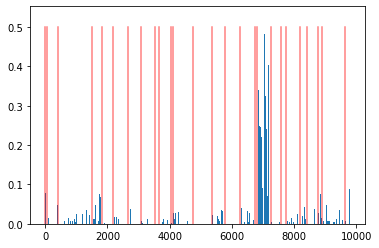

T_ACC =0.04134746268391609
T_BLCA =0.003458900609984994
T_BRCA =0.0077784182503819466
T_CESC =0.016756637021899223
T_HBC =0.003501440864056349
T_COREAD =0.0035311011597514153
T_DLBC =0.0028352097142487764
T_GESCA =0.0035224261227995157
T_GBM =0.010896807536482811
T_HNSC =0.003378023160621524
T_KICH =0.008945504203438759
T_KC =0.009885995648801327
T_LAML =0.0010609532473608851
T_LGG =0.007645591627806425
T_LUAD =0.004786469507962465
T_LUSC =0.005971973296254873
T_MESO =0.008650886826217175
T_GC =0.230889692902565
T_PAAD =0.005068189464509487
T_PCPG =0.0014343588845804334
T_PRAD =0.005690205842256546
T_SARC =0.016508027911186218
T_SKCM =0.002803026931360364
T_TGCT =0.025105543434619904
T_THCA =0.0063414364121854305
T_THYM =0.005782796069979668
14


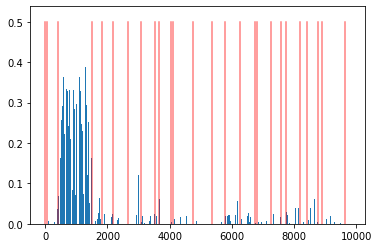

T_ACC =0.00010604450653772801
T_BLCA =0.007444010116159916
T_BRCA =0.2237718105316162
T_CESC =0.011606055311858654
T_HBC =0.0046460567973554134
T_COREAD =0.0045607564970850945
T_DLBC =0.003048095153644681
T_GESCA =0.0077962083742022514
T_GBM =0.010647997260093689
T_HNSC =0.007401257753372192
T_KICH =0.002005037385970354
T_KC =0.0027611106634140015
T_LAML =0.0008106232853606343
T_LGG =0.003545063314959407
T_LUAD =0.012676021084189415
T_LUSC =0.0069774179719388485
T_MESO =0.0028599139768630266
T_GC =0.011333546601235867
T_PAAD =0.002839203691110015
T_PCPG =0.0006712640752084553
T_PRAD =0.018848994746804237
T_SARC =0.004043616354465485
T_SKCM =0.011482588946819305
T_TGCT =0.001594469416886568
T_THCA =0.0017606235342100263
T_THYM =0.006405460648238659
15


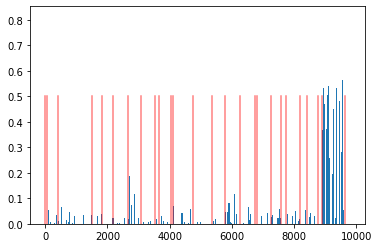

T_ACC =0.03211503475904465
T_BLCA =0.00793263129889965
T_BRCA =0.010825619101524353
T_CESC =0.005562713835388422
T_HBC =0.00527696218341589
T_COREAD =0.006749237887561321
T_DLBC =0.03797545284032822
T_GESCA =0.005380028858780861
T_GBM =0.003020170144736767
T_HNSC =0.0074062892235815525
T_KICH =0.01405616756528616
T_KC =0.014508684165775776
T_LAML =0.0026302430778741837
T_LGG =0.023350968956947327
T_LUAD =0.060022395104169846
T_LUSC =0.012226673774421215
T_MESO =0.002255464671179652
T_GC =0.01554504968225956
T_PAAD =0.011259764432907104
T_PCPG =0.0028393054381012917
T_PRAD =0.009833845309913158
T_SARC =0.00882821623235941
T_SKCM =0.012168250046670437
T_TGCT =0.0032691308297216892
T_THCA =0.32312601804733276
T_THYM =0.009362263604998589
16


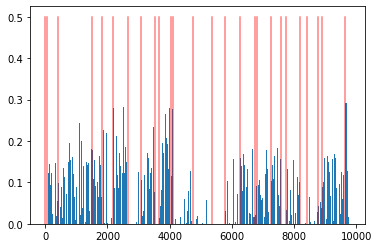

T_ACC =0.0021309847943484783
T_BLCA =0.09778466075658798
T_BRCA =0.10554414242506027
T_CESC =0.1044069454073906
T_HBC =0.02586795575916767
T_COREAD =0.15533021092414856
T_DLBC =0.006610633805394173
T_GESCA =0.10133291780948639
T_GBM =0.0004835190193261951
T_HNSC =0.13060389459133148
T_KICH =0.15406014025211334
T_KC =0.03503819927573204
T_LAML =0.013121326453983784
T_LGG =0.0009246187983080745
T_LUAD =0.042619407176971436
T_LUSC =0.09365887939929962
T_MESO =0.022299006581306458
T_GC =0.07273779064416885
T_PAAD =0.10588859021663666
T_PCPG =0.0023381197825074196
T_PRAD =0.05198841542005539
T_SARC =0.01905708946287632
T_SKCM =0.02560667134821415
T_TGCT =0.07779804617166519
T_THCA =0.11748714745044708
T_THYM =0.19948625564575195
17


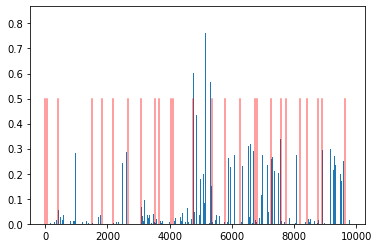

T_ACC =0.0013724359450861812
T_BLCA =0.0022958582267165184
T_BRCA =0.042792387306690216
T_CESC =0.020772583782672882
T_HBC =0.0015044787432998419
T_COREAD =0.009162568487226963
T_DLBC =0.0035896352492272854
T_GESCA =0.04581069201231003
T_GBM =0.01677784137427807
T_HNSC =0.002798299305140972
T_KICH =0.0005328593542799354
T_KC =0.011339547112584114
T_LAML =0.20341655611991882
T_LGG =0.008310770615935326
T_LUAD =0.06447670608758926
T_LUSC =0.058817308396101
T_MESO =0.005461317021399736
T_GC =0.075138159096241
T_PAAD =0.10647465288639069
T_PCPG =0.009480978362262249
T_PRAD =0.03601677343249321
T_SARC =0.004286990966647863
T_SKCM =0.015915758907794952
T_TGCT =0.000634480151347816
T_THCA =0.1089995950460434
T_THYM =4.000128683401272e-06
18


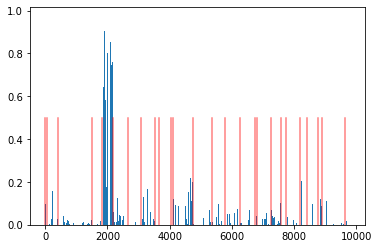

T_ACC =0.19964838027954102
T_BLCA =0.009147032164037228
T_BRCA =0.009134359657764435
T_CESC =0.0037468275986611843
T_HBC =0.7193129658699036
T_COREAD =0.034354161471128464
T_DLBC =0.0065452116541564465
T_GESCA =0.027828898280858994
T_GBM =0.00807760190218687
T_HNSC =0.005085030570626259
T_KICH =0.014856942929327488
T_KC =0.056035369634628296
T_LAML =0.00877579115331173
T_LGG =0.010997065342962742
T_LUAD =0.01579521968960762
T_LUSC =0.007003295235335827
T_MESO =0.033078961074352264
T_GC =0.009880193509161472
T_PAAD =0.03229514881968498
T_PCPG =0.011697440408170223
T_PRAD =0.014759077690541744
T_SARC =0.028883550316095352
T_SKCM =0.009979043155908585
T_TGCT =0.06549938023090363
T_THCA =0.003255645977333188
T_THYM =0.008402479812502861
19


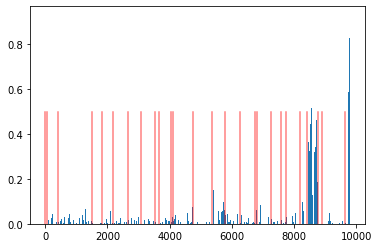

T_ACC =0.012253569439053535
T_BLCA =0.007732348516583443
T_BRCA =0.010180143639445305
T_CESC =0.003146133152768016
T_HBC =0.010785955935716629
T_COREAD =0.007633641362190247
T_DLBC =0.008593236096203327
T_GESCA =0.006681350059807301
T_GBM =0.03386876732110977
T_HNSC =0.005479100625962019
T_KICH =0.009959281422197819
T_KC =0.014976168051362038
T_LAML =0.003067826619371772
T_LGG =0.044394321739673615
T_LUAD =0.012651626020669937
T_LUSC =0.006416840013116598
T_MESO =0.013188865035772324
T_GC =0.00981657300144434
T_PAAD =0.008812117390334606
T_PCPG =0.01938541606068611
T_PRAD =0.010546850971877575
T_SARC =0.028795119374990463
T_SKCM =0.36636650562286377
T_TGCT =0.0012773404596373439
T_THCA =0.005081348121166229
T_THYM =0.0031292217317968607
20


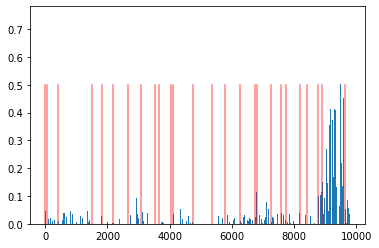

T_ACC =0.04088721424341202
T_BLCA =0.0035419100895524025
T_BRCA =0.011631157249212265
T_CESC =0.0027164912316948175
T_HBC =0.003385029034689069
T_COREAD =0.0022639879025518894
T_DLBC =0.024387376382946968
T_GESCA =0.004024524707347155
T_GBM =0.0037785586901009083
T_HNSC =0.003736884333193302
T_KICH =0.01971423253417015
T_KC =0.015300721861422062
T_LAML =0.0013025072403252125
T_LGG =0.009856687858700752
T_LUAD =0.006473112851381302
T_LUSC =0.011780152097344398
T_MESO =0.04489069804549217
T_GC =0.01527075469493866
T_PAAD =0.006749804597347975
T_PCPG =0.02227555401623249
T_PRAD =0.0053011528216302395
T_SARC =0.021133268252015114
T_SKCM =0.006264863070100546
T_TGCT =0.05839705467224121
T_THCA =0.23720313608646393
T_THYM =0.06975843012332916
21


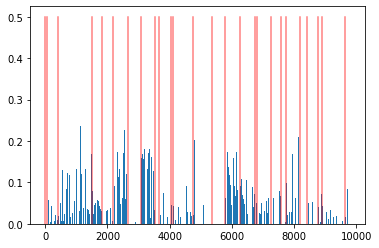

T_ACC =0.00612023426219821
T_BLCA =0.04145801067352295
T_BRCA =0.06887809187173843
T_CESC =0.07142850756645203
T_HBC =0.010343941859900951
T_COREAD =0.08433479815721512
T_DLBC =0.007050329353660345
T_GESCA =0.1221499815583229
T_GBM =0.0003327436570543796
T_HNSC =0.030933229252696037
T_KICH =0.049771640449762344
T_KC =0.02891923114657402
T_LAML =0.012785829603672028
T_LGG =0.0009667255217209458
T_LUAD =0.09102827310562134
T_LUSC =0.04206112027168274
T_MESO =0.009421358816325665
T_GC =0.0415802076458931
T_PAAD =0.035236358642578125
T_PCPG =0.0023524181451648474
T_PRAD =0.044054653495550156
T_SARC =0.002209356287494302
T_SKCM =0.010681736283004284
T_TGCT =0.034100715070962906
T_THCA =0.008256382308900356
T_THYM =0.02835962548851967
22


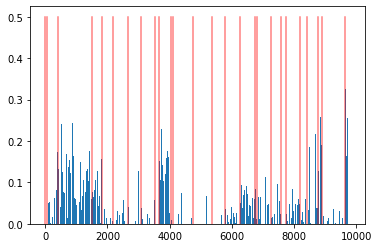

T_ACC =0.004464668221771717
T_BLCA =0.045335546135902405
T_BRCA =0.1087762862443924
T_CESC =0.07257528603076935
T_HBC =0.00577076431363821
T_COREAD =0.020870422944426537
T_DLBC =0.015398938208818436
T_GESCA =0.02480897307395935
T_GBM =0.0029589366167783737
T_HNSC =0.11735404282808304
T_KICH =0.002766852267086506
T_KC =0.010040626861155033
T_LAML =0.0050660730339586735
T_LGG =0.0058716158382594585
T_LUAD =0.024423711001873016
T_LUSC =0.07110686600208282
T_MESO =0.07016948610544205
T_GC =0.035778339952230453
T_PAAD =0.01609761454164982
T_PCPG =0.0042120018042624
T_PRAD =0.03716745227575302
T_SARC =0.025687307119369507
T_SKCM =0.04480001702904701
T_TGCT =0.13789135217666626
T_THCA =0.01123629231005907
T_THYM =0.18229873478412628
23


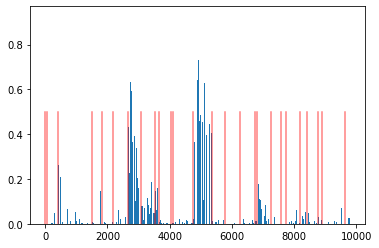

T_ACC =0.008020355366170406
T_BLCA =0.0026033613830804825
T_BRCA =0.01709750108420849
T_CESC =0.004527836572378874
T_HBC =0.0029324728529900312
T_COREAD =0.017433691769838333
T_DLBC =0.33111700415611267
T_GESCA =0.07048234343528748
T_GBM =0.13444752991199493
T_HNSC =0.003742657136172056
T_KICH =0.0007823091582395136
T_KC =0.005318347830325365
T_LAML =0.33664292097091675
T_LGG =0.0031012387480586767
T_LUAD =0.0029892337042838335
T_LUSC =0.004175085108727217
T_MESO =0.00791573990136385
T_GC =0.07760187238454819
T_PAAD =0.01939857378602028
T_PCPG =0.004760062787681818
T_PRAD =0.011790485121309757
T_SARC =0.00862177088856697
T_SKCM =0.011999630369246006
T_TGCT =0.0062546576373279095
T_THCA =0.02038770541548729
T_THYM =0.0034393081441521645


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


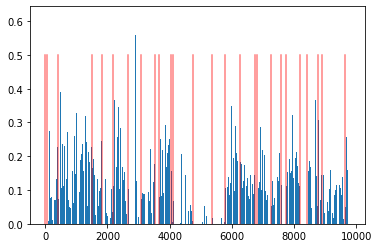

T_ACC =0.0064284526742994785
T_BLCA =0.12473907321691513
T_BRCA =0.17553982138633728
T_CESC =0.13020840287208557
T_HBC =0.04875641316175461
T_COREAD =0.18216200172901154
T_DLBC =0.038597509264945984
T_GESCA =0.11544355005025864
T_GBM =0.00285483174957335
T_HNSC =0.15836572647094727
T_KICH =0.12658153474330902
T_KC =0.04161917418241501
T_LAML =0.0050492361187934875
T_LGG =0.0046438840217888355
T_LUAD =0.14107069373130798
T_LUSC =0.13621786236763
T_MESO =0.0131327910348773
T_GC =0.12383213639259338
T_PAAD =0.1115303710103035
T_PCPG =0.01315612718462944
T_PRAD =0.20277775824069977
T_SARC =0.012662524357438087
T_SKCM =0.07503839582204819
T_TGCT =0.2700512111186981
T_THCA =0.059416670352220535
T_THYM =0.16053660213947296
1


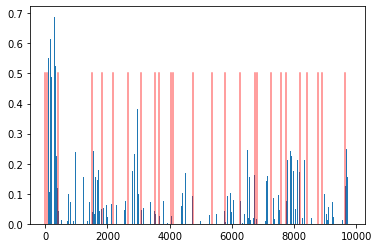

T_ACC =0.04454341530799866
T_BLCA =0.38079580664634705
T_BRCA =0.021872181445360184
T_CESC =0.12356317788362503
T_HBC =0.016753820702433586
T_COREAD =0.01894865185022354
T_DLBC =0.07808088511228561
T_GESCA =0.030417196452617645
T_GBM =0.0039502098225057125
T_HNSC =0.036693669855594635
T_KICH =0.013337084092199802
T_KC =0.01818019710481167
T_LAML =0.003101898357272148
T_LGG =0.005340712610632181
T_LUAD =0.029483892023563385
T_LUSC =0.06870720535516739
T_MESO =0.05741236358880997
T_GC =0.029128573834896088
T_PAAD =0.034650206565856934
T_PCPG =0.0034981933422386646
T_PRAD =0.08278448134660721
T_SARC =0.07954230904579163
T_SKCM =0.003148077055811882
T_TGCT =0.017474869266152382
T_THCA =0.00860199797898531
T_THYM =0.16427506506443024
2


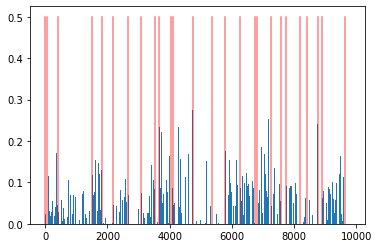

T_ACC =0.028822416439652443
T_BLCA =0.04991881549358368
T_BRCA =0.038810063153505325
T_CESC =0.0809595137834549
T_HBC =0.00881518330425024
T_COREAD =0.05139601230621338
T_DLBC =0.017708128318190575
T_GESCA =0.05632763355970383
T_GBM =0.003974157385528088
T_HNSC =0.08500586450099945
T_KICH =0.03172050043940544
T_KC =0.07217037677764893
T_LAML =0.01741762086749077
T_LGG =0.008999005891382694
T_LUAD =0.0815793126821518
T_LUSC =0.0745595321059227
T_MESO =0.01822514273226261
T_GC =0.0929262638092041
T_PAAD =0.07816753536462784
T_PCPG =0.003581248689442873
T_PRAD =0.03554443642497063
T_SARC =0.011064915917813778
T_SKCM =0.026703597977757454
T_TGCT =0.01967337355017662
T_THCA =0.0657607913017273
T_THYM =0.01059836708009243
3


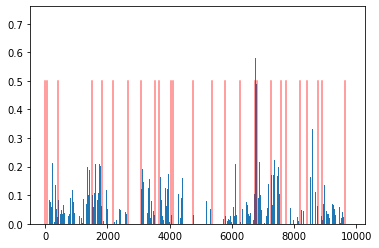

T_ACC =0.02622426114976406
T_BLCA =0.07803273946046829
T_BRCA =0.03860130161046982
T_CESC =0.09130393713712692
T_HBC =0.030323823913931847
T_COREAD =0.034756723791360855
T_DLBC =0.005333760753273964
T_GESCA =0.07279923558235168
T_GBM =0.0027764025144279003
T_HNSC =0.06993349641561508
T_KICH =0.01387720461934805
T_KC =0.04726288840174675
T_LAML =0.006206248886883259
T_LGG =0.005368082784116268
T_LUAD =0.06763535737991333
T_LUSC =0.037988901138305664
T_MESO =0.416122168302536
T_GC =0.06265954673290253
T_PAAD =0.1448509842157364
T_PCPG =0.00915914960205555
T_PRAD =0.013407435268163681
T_SARC =0.09602221101522446
T_SKCM =0.03758116438984871
T_TGCT =0.007548321504145861
T_THCA =0.02830306813120842
T_THYM =0.008593407459557056
4


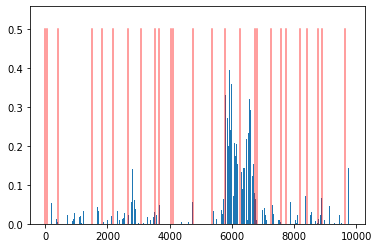

T_ACC =0.005686049349606037
T_BLCA =0.01079745776951313
T_BRCA =0.007569239009171724
T_CESC =0.006671951152384281
T_HBC =0.008899406529963017
T_COREAD =0.008120674639940262
T_DLBC =0.0218430794775486
T_GESCA =0.01422268245369196
T_GBM =0.014941425994038582
T_HNSC =0.007356977090239525
T_KICH =0.0021640604827553034
T_KC =0.00920315645635128
T_LAML =0.0012658879859372973
T_LGG =0.017329560592770576
T_LUAD =0.24120652675628662
T_LUSC =0.14117684960365295
T_MESO =0.07773860543966293
T_GC =0.012027038261294365
T_PAAD =0.014529033564031124
T_PCPG =0.0042305937968194485
T_PRAD =0.014052525162696838
T_SARC =0.018615074455738068
T_SKCM =0.015894457697868347
T_TGCT =0.051466260105371475
T_THCA =0.006202032323926687
T_THYM =0.004617363680154085
5


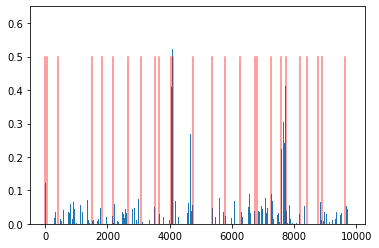

T_ACC =0.10102395713329315
T_BLCA =0.00714428024366498
T_BRCA =0.01981564611196518
T_CESC =0.009245093911886215
T_HBC =0.014007161371409893
T_COREAD =0.011771739460527897
T_DLBC =0.01041095145046711
T_GESCA =0.008935934863984585
T_GBM =0.002723408630117774
T_HNSC =0.004503721836954355
T_KICH =0.3989625871181488
T_KC =0.056368086487054825
T_LAML =0.012337414547801018
T_LGG =0.010358688421547413
T_LUAD =0.021186120808124542
T_LUSC =0.010360845364630222
T_MESO =0.003880427684634924
T_GC =0.028883695602416992
T_PAAD =0.02358364313840866
T_PCPG =0.24776864051818848
T_PRAD =0.018016492947936058
T_SARC =0.016797387972474098
T_SKCM =0.0039055845700204372
T_TGCT =0.002609602641314268
T_THCA =0.009603011421859264
T_THYM =0.026748329401016235
6


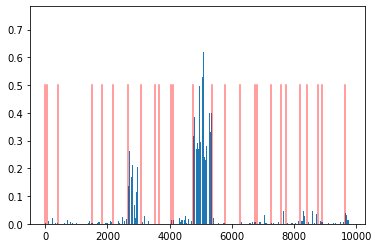

T_ACC =0.002655434189364314
T_BLCA =0.0020283162593841553
T_BRCA =0.0017871105810627341
T_CESC =0.0036877065431326628
T_HBC =0.002646570559591055
T_COREAD =0.0031870014499872923
T_DLBC =0.114377960562706
T_GESCA =0.003264321479946375
T_GBM =0.0027989926747977734
T_HNSC =0.0009724827250465751
T_KICH =0.001621509320102632
T_KC =0.006252960301935673
T_LAML =0.3541621267795563
T_LGG =0.004613804630935192
T_LUAD =0.0014181770384311676
T_LUSC =0.001986617222428322
T_MESO =0.0015537987928837538
T_GC =0.004792740102857351
T_PAAD =0.00325409066863358
T_PCPG =0.0048552085645496845
T_PRAD =0.001935635576955974
T_SARC =0.013176984153687954
T_SKCM =0.013340742327272892
T_TGCT =0.005837989039719105
T_THCA =0.0014721667394042015
T_THYM =0.024835828691720963
7


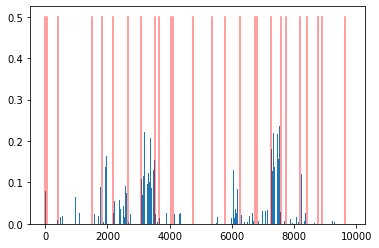

T_ACC =0.02869177982211113
T_BLCA =0.006381637882441282
T_BRCA =0.0030673863366246223
T_CESC =0.019746417179703712
T_HBC =0.029407737776637077
T_COREAD =0.026955965906381607
T_DLBC =0.01441432535648346
T_GESCA =0.12030834704637527
T_GBM =0.006998345721513033
T_HNSC =0.006020319182425737
T_KICH =0.0009964264463633299
T_KC =0.009844333864748478
T_LAML =0.002073698677122593
T_LGG =0.0027388103771954775
T_LUAD =0.023447571322321892
T_LUSC =0.007571263704448938
T_MESO =0.0016792981186881661
T_GC =0.010218081064522266
T_PAAD =0.16794544458389282
T_PCPG =0.006079757586121559
T_PRAD =0.0036120424047112465
T_SARC =0.01082003302872181
T_SKCM =0.001812713802792132
T_TGCT =0.013436580076813698
T_THCA =0.0007350617670454085
T_THYM =0.0012159640900790691
8


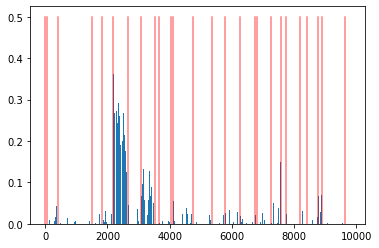

T_ACC =0.000824872637167573
T_BLCA =0.006338180508464575
T_BRCA =0.0015243709785863757
T_CESC =0.006524530705064535
T_HBC =0.006868801079690456
T_COREAD =0.26091331243515015
T_DLBC =0.012308857403695583
T_GESCA =0.05514838546514511
T_GBM =0.001738096005283296
T_HNSC =0.0024328019935637712
T_KICH =0.0004873838624916971
T_KC =0.008842404000461102
T_LAML =0.0029873428866267204
T_LGG =0.0029213845264166594
T_LUAD =0.0066075860522687435
T_LUSC =0.00173092947807163
T_MESO =0.002084684558212757
T_GC =0.0054722679778933525
T_PAAD =0.020985795184969902
T_PCPG =0.0005511848721653223
T_PRAD =0.0025599582586437464
T_SARC =0.0073195286095142365
T_SKCM =0.0061425454914569855
T_TGCT =0.04744267463684082
T_THCA =0.00047505501424893737
T_THYM =0.0
9


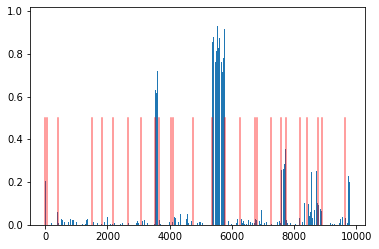

T_ACC =0.11215284466743469
T_BLCA =0.00678456574678421
T_BRCA =0.006073195021599531
T_CESC =0.002922096522524953
T_HBC =0.008285664953291416
T_COREAD =0.0012378476094454527
T_DLBC =0.008804515935480595
T_GESCA =0.004763431381434202
T_GBM =0.6061132550239563
T_HNSC =0.003371474100276828
T_KICH =0.00984230637550354
T_KC =0.01692766696214676
T_LAML =0.0032314297277480364
T_LGG =0.8139161467552185
T_LUAD =0.004107373300939798
T_LUSC =0.0050836894661188126
T_MESO =0.016272159293293953
T_GC =0.008391497656702995
T_PAAD =0.005413999315351248
T_PCPG =0.3201479911804199
T_PRAD =0.009346997365355492
T_SARC =0.09753254801034927
T_SKCM =0.09210135042667389
T_TGCT =0.04297615960240364
T_THCA =0.008175547234714031
T_THYM =0.023674147203564644
10


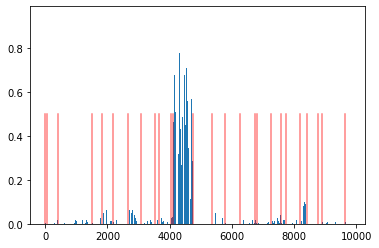

T_ACC =0.012522730976343155
T_BLCA =0.002049168571829796
T_BRCA =0.0018665764946490526
T_CESC =0.0037872386164963245
T_HBC =0.01588364504277706
T_COREAD =0.0048013473860919476
T_DLBC =0.017350032925605774
T_GESCA =0.004916094709187746
T_GBM =0.009005134925246239
T_HNSC =0.0017717761220410466
T_KICH =0.04113604128360748
T_KC =0.42459994554519653
T_LAML =0.002141696633771062
T_LGG =0.00647052563726902
T_LUAD =0.002907905960455537
T_LUSC =0.0012753780465573072
T_MESO =0.026238763704895973
T_GC =0.00643404945731163
T_PAAD =0.011353425681591034
T_PCPG =0.013936135917901993
T_PRAD =0.0013972350861877203
T_SARC =0.06620969623327255
T_SKCM =0.0014612755039706826
T_TGCT =0.010896791703999043
T_THCA =0.0018981071189045906
T_THYM =0.004336791578680277
11


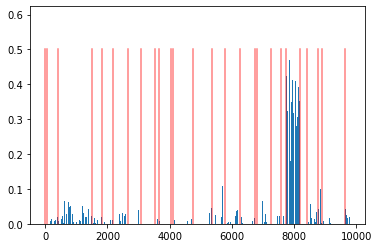

T_ACC =0.00942217092961073
T_BLCA =0.004725924693048
T_BRCA =0.015327083878219128
T_CESC =0.006528127007186413
T_HBC =0.0036333403550088406
T_COREAD =0.005895937792956829
T_DLBC =0.0014499417738988996
T_GESCA =0.005049297586083412
T_GBM =0.007511771284043789
T_HNSC =0.0028685342986136675
T_KICH =0.003178706858307123
T_KC =0.004223814699798822
T_LAML =0.00276239519007504
T_LGG =0.004971897695213556
T_LUAD =0.0064336033537983894
T_LUSC =0.003974353428930044
T_MESO =0.0016686724266037345
T_GC =0.009300115518271923
T_PAAD =0.005999480839818716
T_PCPG =0.01652255840599537
T_PRAD =0.3303881287574768
T_SARC =0.010038896463811398
T_SKCM =0.009849646128714085
T_TGCT =0.01275087334215641
T_THCA =0.0017291769618168473
T_THYM =0.02208060771226883
12


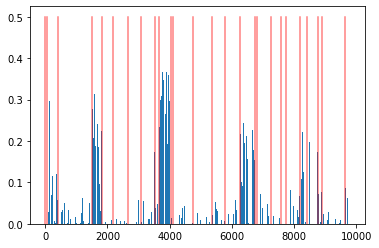

T_ACC =0.02441376820206642
T_BLCA =0.06346975266933441
T_BRCA =0.010524758137762547
T_CESC =0.17598681151866913
T_HBC =0.0029586961027234793
T_COREAD =0.009468927048146725
T_DLBC =0.008934557437896729
T_GESCA =0.04854375496506691
T_GBM =0.016594912856817245
T_HNSC =0.30934756994247437
T_KICH =0.004040616098791361
T_KC =0.005460992455482483
T_LAML =0.0022353376261889935
T_LGG =0.007936473935842514
T_LUAD =0.012040650472044945
T_LUSC =0.16490289568901062
T_MESO =0.005735402926802635
T_GC =0.009845970198512077
T_PAAD =0.008452231995761395
T_PCPG =0.00011071288463426754
T_PRAD =0.009769734926521778
T_SARC =0.026195727288722992
T_SKCM =0.04009132832288742
T_TGCT =0.036187391728162766
T_THCA =0.0036344684194773436
T_THYM =0.056381210684776306
13


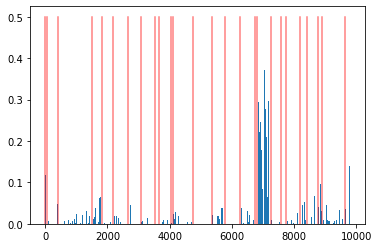

T_ACC =0.05458727478981018
T_BLCA =0.003277318086475134
T_BRCA =0.006784913130104542
T_CESC =0.015368148684501648
T_HBC =0.00347181037068367
T_COREAD =0.0035881437361240387
T_DLBC =0.0031332960352301598
T_GESCA =0.0034076119773089886
T_GBM =0.013157712295651436
T_HNSC =0.0032084579579532146
T_KICH =0.008974827826023102
T_KC =0.008645130321383476
T_LAML =0.001180632272735238
T_LGG =0.008682865649461746
T_LUAD =0.004353589378297329
T_LUSC =0.005171698983758688
T_MESO =0.010189592838287354
T_GC =0.20108437538146973
T_PAAD =0.005215617828071117
T_PCPG =0.0019900554325431585
T_PRAD =0.005209151655435562
T_SARC =0.02342238277196884
T_SKCM =0.006503306329250336
T_TGCT =0.03138834610581398
T_THCA =0.005742135923355818
T_THYM =0.010667474009096622
14


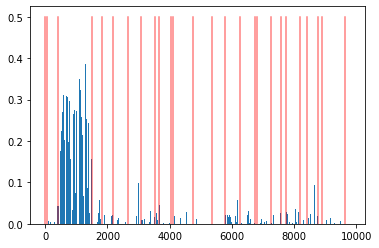

T_ACC =0.0005361631046980619
T_BLCA =0.008165143430233002
T_BRCA =0.2054450660943985
T_CESC =0.011666218750178814
T_HBC =0.004944180604070425
T_COREAD =0.004974666051566601
T_DLBC =0.0035563313867896795
T_GESCA =0.008239995688199997
T_GBM =0.015001830644905567
T_HNSC =0.006036986596882343
T_KICH =0.0025569216813892126
T_KC =0.003286071354523301
T_LAML =0.0006672015297226608
T_LGG =0.003973021637648344
T_LUAD =0.012845072895288467
T_LUSC =0.005733338184654713
T_MESO =0.002651035087183118
T_GC =0.01194331981241703
T_PAAD =0.0033929413184523582
T_PCPG =0.0014096410013735294
T_PRAD =0.018748952075839043
T_SARC =0.00702877901494503
T_SKCM =0.014412479475140572
T_TGCT =0.0018724449910223484
T_THCA =0.0016822733450680971
T_THYM =0.006456693168729544
15


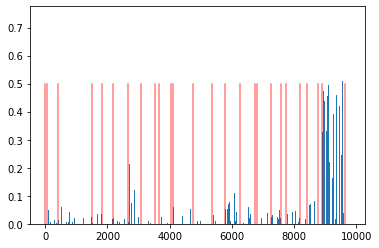

T_ACC =0.030170248821377754
T_BLCA =0.0075289043597877026
T_BRCA =0.009183574467897415
T_CESC =0.004842298571020365
T_HBC =0.004626279231160879
T_COREAD =0.006624558940529823
T_DLBC =0.03255096822977066
T_GESCA =0.0042574903927743435
T_GBM =0.0024947249330580235
T_HNSC =0.006265637930482626
T_KICH =0.012289159931242466
T_KC =0.012389100156724453
T_LAML =0.0026654163375496864
T_LGG =0.0248266514390707
T_LUAD =0.05648597702383995
T_LUSC =0.01085613202303648
T_MESO =0.0016890355618670583
T_GC =0.012948268093168736
T_PAAD =0.010279054753482342
T_PCPG =0.0010230839252471924
T_PRAD =0.008911531418561935
T_SARC =0.005898317787796259
T_SKCM =0.03184012323617935
T_TGCT =0.0024771515745669603
T_THCA =0.28547507524490356
T_THYM =0.009453107602894306
16


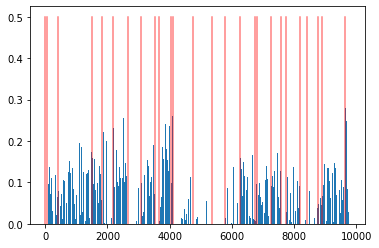

T_ACC =0.002112083835527301
T_BLCA =0.08522895723581314
T_BRCA =0.0886988639831543
T_CESC =0.0927935540676117
T_HBC =0.0207174401730299
T_COREAD =0.13222000002861023
T_DLBC =0.005508622620254755
T_GESCA =0.08909494429826736
T_GBM =0.0006342114065773785
T_HNSC =0.11787593364715576
T_KICH =0.13689996302127838
T_KC =0.027628500014543533
T_LAML =0.012245611287653446
T_LGG =0.001150596421211958
T_LUAD =0.035773761570453644
T_LUSC =0.08359981328248978
T_MESO =0.02485945262014866
T_GC =0.059380773454904556
T_PAAD =0.0898464247584343
T_PCPG =0.0035393494181334972
T_PRAD =0.04474232345819473
T_SARC =0.027025360614061356
T_SKCM =0.03176342323422432
T_TGCT =0.0702875629067421
T_THCA =0.09795796126127243
T_THYM =0.17134563624858856
17


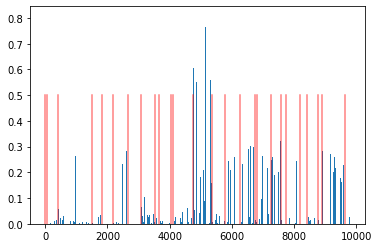

T_ACC =0.0009940477320924401
T_BLCA =0.002258391585201025
T_BRCA =0.04097314924001694
T_CESC =0.020495496690273285
T_HBC =0.0016056968597695231
T_COREAD =0.00888032652437687
T_DLBC =0.004089834168553352
T_GESCA =0.04563979431986809
T_GBM =0.01931898295879364
T_HNSC =0.002941864775493741
T_KICH =0.0007551609887741506
T_KC =0.01165949460119009
T_LAML =0.20549125969409943
T_LGG =0.009372418746352196
T_LUAD =0.060047637671232224
T_LUSC =0.05601980537176132
T_MESO =0.0056878975592553616
T_GC =0.07010805606842041
T_PAAD =0.10201052576303482
T_PCPG =0.01155618205666542
T_PRAD =0.034133389592170715
T_SARC =0.0057459305971860886
T_SKCM =0.021735943853855133
T_TGCT =0.000762979791034013
T_THCA =0.10289168357849121
T_THYM =7.1496233431389555e-06
18


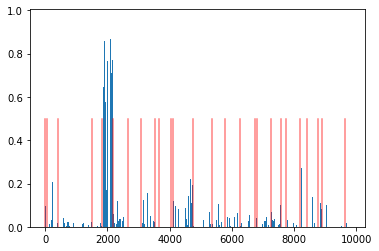

T_ACC =0.22746457159519196
T_BLCA =0.008962337858974934
T_BRCA =0.008854828774929047
T_CESC =0.003533159149810672
T_HBC =0.6911409497261047
T_COREAD =0.03321003541350365
T_DLBC =0.006034462247043848
T_GESCA =0.02690170146524906
T_GBM =0.008712833747267723
T_HNSC =0.0048402766697108746
T_KICH =0.014287000522017479
T_KC =0.05576058477163315
T_LAML =0.008927479386329651
T_LGG =0.01238735020160675
T_LUAD =0.014668845571577549
T_LUSC =0.0063616069965064526
T_MESO =0.024725044146180153
T_GC =0.008417771197855473
T_PAAD =0.0303360503166914
T_PCPG =0.00976462010294199
T_PRAD =0.013404782861471176
T_SARC =0.023574866354465485
T_SKCM =0.025987450033426285
T_TGCT =0.0597638264298439
T_THCA =0.0028575570322573185
T_THYM =0.007223261054605246
19


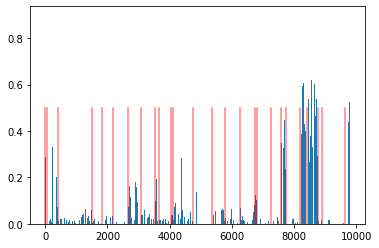

T_ACC =0.2091432511806488
T_BLCA =0.025530509650707245
T_BRCA =0.01979856938123703
T_CESC =0.018774081021547318
T_HBC =0.010246791876852512
T_COREAD =0.003586730221286416
T_DLBC =0.12969888746738434
T_GESCA =0.02225416526198387
T_GBM =0.09210216999053955
T_HNSC =0.016581600531935692
T_KICH =0.03216177225112915
T_KC =0.029049081727862358
T_LAML =0.003453158773481846
T_LGG =0.02085031010210514
T_LUAD =0.009086951613426208
T_LUSC =0.01944415271282196
T_MESO =0.14260484278202057
T_GC =0.01577485352754593
T_PAAD =0.01274051796644926
T_PCPG =0.2895399332046509
T_PRAD =0.004344272427260876
T_SARC =0.360750675201416
T_SKCM =0.4722825288772583
T_TGCT =0.02750289812684059
T_THCA =0.001960942056030035
T_THYM =0.008604584261775017
20


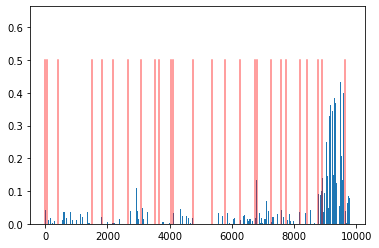

T_ACC =0.046874579042196274
T_BLCA =0.003311708103865385
T_BRCA =0.009171321988105774
T_CESC =0.002311032498255372
T_HBC =0.0036974004469811916
T_COREAD =0.0022527126129716635
T_DLBC =0.02707538567483425
T_GESCA =0.003970310091972351
T_GBM =0.0038113510236144066
T_HNSC =0.0032828100956976414
T_KICH =0.018713736906647682
T_KC =0.014393291436135769
T_LAML =0.0010839798487722874
T_LGG =0.010602965019643307
T_LUAD =0.005892451386898756
T_LUSC =0.01001791562885046
T_MESO =0.0445859394967556
T_GC =0.01325123943388462
T_PAAD =0.00642154086381197
T_PCPG =0.019986357539892197
T_PRAD =0.005067999940365553
T_SARC =0.025480113923549652
T_SKCM =0.009949193336069584
T_TGCT =0.04828279837965965
T_THCA =0.21770399808883667
T_THYM =0.05861775577068329
21


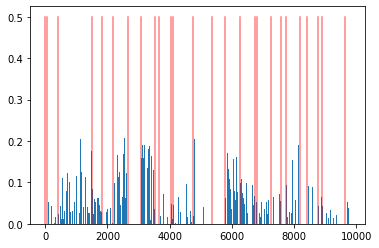

T_ACC =0.004814240615814924
T_BLCA =0.03953292593359947
T_BRCA =0.06478063017129898
T_CESC =0.072513647377491
T_HBC =0.009378859773278236
T_COREAD =0.08194898813962936
T_DLBC =0.008783496916294098
T_GESCA =0.12241252511739731
T_GBM =0.00032355650910176337
T_HNSC =0.03205603361129761
T_KICH =0.057145364582538605
T_KC =0.03042249195277691
T_LAML =0.013463909737765789
T_LGG =0.0014691348187625408
T_LUAD =0.0872320607304573
T_LUSC =0.041950903832912445
T_MESO =0.0062676966190338135
T_GC =0.03877459466457367
T_PAAD =0.03442801535129547
T_PCPG =0.001686110277660191
T_PRAD =0.03924499452114105
T_SARC =0.002020918531343341
T_SKCM =0.019632870331406593
T_TGCT =0.031166881322860718
T_THCA =0.007802032865583897
T_THYM =0.018266646191477776
22


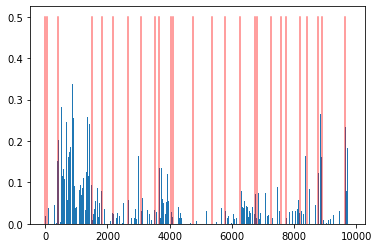

T_ACC =0.006776985712349415
T_BLCA =0.02541501633822918
T_BRCA =0.1263158917427063
T_CESC =0.03965364024043083
T_HBC =0.004952156450599432
T_COREAD =0.01269802637398243
T_DLBC =0.03116239234805107
T_GESCA =0.017142590135335922
T_GBM =0.006031894590705633
T_HNSC =0.056427791714668274
T_KICH =0.0047853621654212475
T_KC =0.007770423777401447
T_LAML =0.0036697036121040583
T_LGG =0.007438198197633028
T_LUAD =0.01743767037987709
T_LUSC =0.045867059379816055
T_MESO =0.06891806423664093
T_GC =0.026010069996118546
T_PAAD =0.008757028728723526
T_PCPG =0.005903335753828287
T_PRAD =0.024098897352814674
T_SARC =0.0340246856212616
T_SKCM =0.021526381373405457
T_TGCT =0.13245852291584015
T_THCA =0.008377130143344402
T_THYM =0.11815418303012848
23


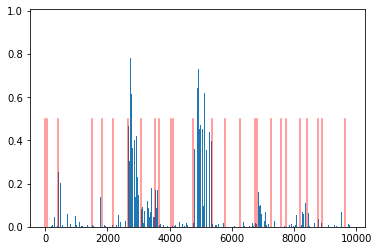

T_ACC =0.013043093495070934
T_BLCA =0.0026728427037596703
T_BRCA =0.016277965158224106
T_CESC =0.004469625651836395
T_HBC =0.0029358970932662487
T_COREAD =0.016272757202386856
T_DLBC =0.38821330666542053
T_GESCA =0.06945423781871796
T_GBM =0.15563173592090607
T_HNSC =0.003714615711942315
T_KICH =0.0010610324097797275
T_KC =0.005546801257878542
T_LAML =0.32972341775894165
T_LGG =0.0029571782797574997
T_LUAD =0.002781020011752844
T_LUSC =0.004319867584854364
T_MESO =0.011267798952758312
T_GC =0.06921583414077759
T_PAAD =0.01812385953962803
T_PCPG =0.009439719840884209
T_PRAD =0.010837827809154987
T_SARC =0.017091788351535797
T_SKCM =0.012025171890854836
T_TGCT =0.007505736779421568
T_THCA =0.01866815984249115
T_THYM =0.003018261631950736
24


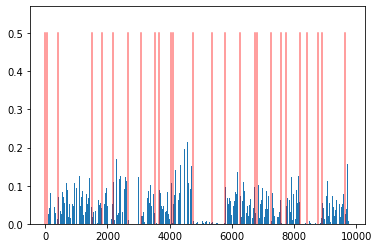

T_ACC =7.132181781344116e-05
T_BLCA =0.0449102483689785
T_BRCA =0.06133650615811348
T_CESC =0.052444081753492355
T_HBC =0.045042235404253006
T_COREAD =0.07412690669298172
T_DLBC =0.010578528046607971
T_GESCA =0.0470847561955452
T_GBM =0.0007981183589436114
T_HNSC =0.05812360718846321
T_KICH =0.0624237023293972
T_KC =0.07249308377504349
T_LAML =0.0024559437297284603
T_LGG =0.0006803240394219756
T_LUAD =0.054270196706056595
T_LUSC =0.05512140318751335
T_MESO =0.014809335581958294
T_GC =0.06917887181043625
T_PAAD =0.047732166945934296
T_PCPG =0.00056406733347103
T_PRAD =0.06566300988197327
T_SARC =0.001938314875587821
T_SKCM =0.0052702766843140125
T_TGCT =0.04817875102162361
T_THCA =0.0528738871216774
T_THYM =0.08029156178236008


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


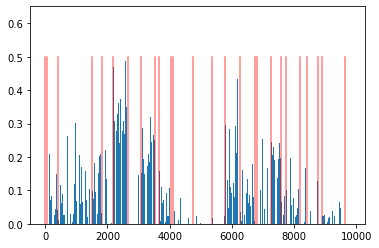

T_ACC =0.009638807736337185
T_BLCA =0.06413814425468445
T_BRCA =0.06828618049621582
T_CESC =0.13675926625728607
T_HBC =0.05034094676375389
T_COREAD =0.3459556996822357
T_DLBC =0.020802585408091545
T_GESCA =0.18739254772663116
T_GBM =0.011935930699110031
T_HNSC =0.08471156656742096
T_KICH =0.011781458742916584
T_KC =0.03424471244215965
T_LAML =0.013895501382648945
T_LGG =0.014201808720827103
T_LUAD =0.15324588119983673
T_LUSC =0.07919040322303772
T_MESO =0.00934627465903759
T_GC =0.08153210580348969
T_PAAD =0.23007160425186157
T_PCPG =0.038045816123485565
T_PRAD =0.05766192823648453
T_SARC =0.012976461090147495
T_SKCM =0.0204812940210104
T_TGCT =0.04032033309340477
T_THCA =0.013380619697272778
T_THYM =0.020180348306894302
1


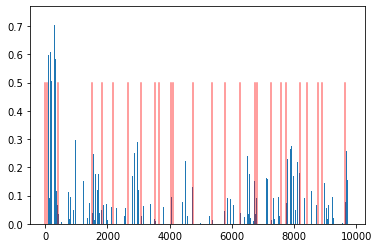

T_ACC =0.030575815588235855
T_BLCA =0.3939240872859955
T_BRCA =0.022999724373221397
T_CESC =0.11466994881629944
T_HBC =0.02006707899272442
T_COREAD =0.013369518332183361
T_DLBC =0.056369882076978683
T_GESCA =0.02657891809940338
T_GBM =0.0023148702457547188
T_HNSC =0.03435878828167915
T_KICH =0.037397462874650955
T_KC =0.020866673439741135
T_LAML =0.002656000666320324
T_LGG =0.004737053066492081
T_LUAD =0.02856777422130108
T_LUSC =0.06415631622076035
T_MESO =0.07428506016731262
T_GC =0.031305067241191864
T_PAAD =0.034179963171482086
T_PCPG =0.000777586130425334
T_PRAD =0.08605246245861053
T_SARC =0.037282079458236694
T_SKCM =0.004352489486336708
T_TGCT =0.011718112044036388
T_THCA =0.01083380077034235
T_THYM =0.15284045040607452
2


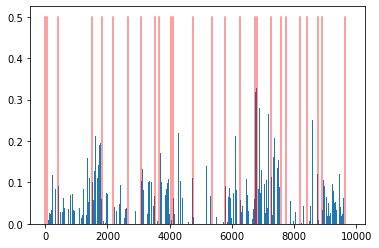

T_ACC =0.018171584233641624
T_BLCA =0.06480710953474045
T_BRCA =0.03397495672106743
T_CESC =0.08775097131729126
T_HBC =0.021916227415204048
T_COREAD =0.03519515320658684
T_DLBC =0.004226807504892349
T_GESCA =0.06194531172513962
T_GBM =0.0032090754248201847
T_HNSC =0.06068380922079086
T_KICH =0.01104679238051176
T_KC =0.07015540450811386
T_LAML =0.006750541273504496
T_LGG =0.0068588899448513985
T_LUAD =0.0764286145567894
T_LUSC =0.03302370384335518
T_MESO =0.21843107044696808
T_GC =0.08156850188970566
T_PAAD =0.12404484301805496
T_PCPG =0.003123214468359947
T_PRAD =0.00919071864336729
T_SARC =0.04903377220034599
T_SKCM =0.022950604557991028
T_TGCT =0.003462498774752021
T_THCA =0.036943934857845306
T_THYM =0.001578224473632872
3


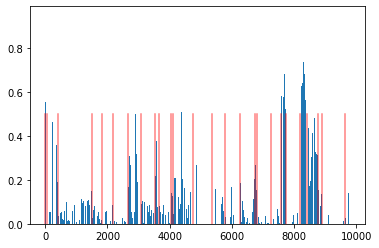

T_ACC =0.3951060175895691
T_BLCA =0.05977996066212654
T_BRCA =0.057947561144828796
T_CESC =0.064116470515728
T_HBC =0.019489966332912445
T_COREAD =0.00886722281575203
T_DLBC =0.25205498933792114
T_GESCA =0.05680667981505394
T_GBM =0.1749599725008011
T_HNSC =0.053429197520017624
T_KICH =0.10025209188461304
T_KC =0.08915559202432632
T_LAML =0.007907376624643803
T_LGG =0.027876123785972595
T_LUAD =0.02078852988779545
T_LUSC =0.057288430631160736
T_MESO =0.28042396903038025
T_GC =0.043986063450574875
T_PAAD =0.02828819304704666
T_PCPG =0.520129919052124
T_PRAD =0.011683743447065353
T_SARC =0.5353823304176331
T_SKCM =0.3188072443008423
T_TGCT =0.13623186945915222
T_THCA =0.003903329838067293
T_THYM =0.03009464405477047
4


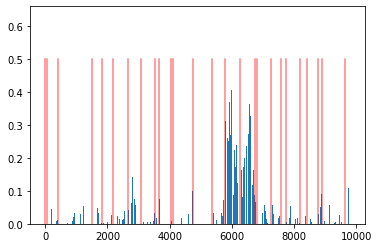

T_ACC =0.0055196043103933334
T_BLCA =0.011727516539394855
T_BRCA =0.008159077726304531
T_CESC =0.0048864493146538734
T_HBC =0.00930755864828825
T_COREAD =0.00664536701515317
T_DLBC =0.0222332701086998
T_GESCA =0.012848236598074436
T_GBM =0.013007819652557373
T_HNSC =0.006901374086737633
T_KICH =0.0063506863079965115
T_KC =0.01129054743796587
T_LAML =0.0014421839732676744
T_LGG =0.01913086697459221
T_LUAD =0.26297059655189514
T_LUSC =0.1599801927804947
T_MESO =0.07794313877820969
T_GC =0.01256912387907505
T_PAAD =0.017021870240569115
T_PCPG =0.004272341262549162
T_PRAD =0.016094667837023735
T_SARC =0.014141229912638664
T_SKCM =0.008539894595742226
T_TGCT =0.07069829106330872
T_THCA =0.009296269156038761
T_THYM =0.006030967924743891
5


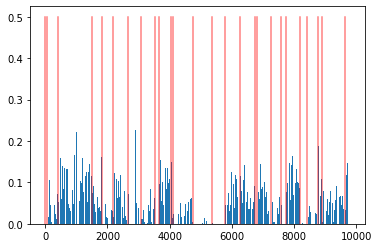

T_ACC =0.0024301139637827873
T_BLCA =0.06247849017381668
T_BRCA =0.09811944514513016
T_CESC =0.06509824097156525
T_HBC =0.02160838432610035
T_COREAD =0.05616221949458122
T_DLBC =0.01932923123240471
T_GESCA =0.04097576439380646
T_GBM =0.000600210449192673
T_HNSC =0.09561777114868164
T_KICH =0.10559967905282974
T_KC =0.028907328844070435
T_LAML =0.0010160790989175439
T_LGG =0.001118399086408317
T_LUAD =0.058143164962530136
T_LUSC =0.07550302892923355
T_MESO =0.004339376464486122
T_GC =0.07264558970928192
T_PAAD =0.03271086886525154
T_PCPG =0.004719118122011423
T_PRAD =0.12099891901016235
T_SARC =0.003815023461356759
T_SKCM =0.015088698826730251
T_TGCT =0.1694560945034027
T_THCA =0.04125292971730232
T_THYM =0.0986596867442131
6


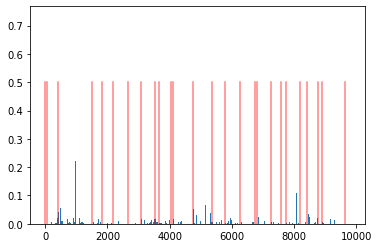

T_ACC =0.00019846500072162598
T_BLCA =0.002283828565850854
T_BRCA =0.041255075484514236
T_CESC =0.002489506732672453
T_HBC =0.0010325915645807981
T_COREAD =0.0010700843995437026
T_DLBC =0.002139706164598465
T_GESCA =0.00890231691300869
T_GBM =0.0133628249168396
T_HNSC =0.0021788699086755514
T_KICH =0.0003365958109498024
T_KC =0.0013675125082954764
T_LAML =0.014896118082106113
T_LGG =0.0011987310135737062
T_LUAD =0.002693885937333107
T_LUSC =0.002398887649178505
T_MESO =0.00031183153623715043
T_GC =0.008080683648586273
T_PAAD =0.001962115988135338
T_PCPG =0.0018391923513263464
T_PRAD =0.00821105670183897
T_SARC =0.0007910363492555916
T_SKCM =0.008078628219664097
T_TGCT =0.0008237281581386924
T_THCA =0.002236861502751708
T_THYM =0.0007261715363711119
7


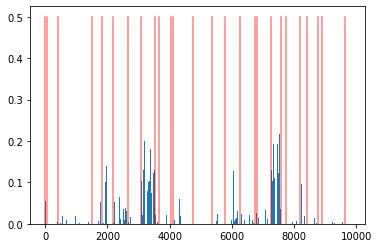

T_ACC =0.02670416049659252
T_BLCA =0.005263104569166899
T_BRCA =0.0016768535133451223
T_CESC =0.011515882797539234
T_HBC =0.027775904163718224
T_COREAD =0.018655532971024513
T_DLBC =0.011026048101484776
T_GESCA =0.1105455607175827
T_GBM =0.005309817381203175
T_HNSC =0.003873907495290041
T_KICH =0.00047631864435970783
T_KC =0.010328208096325397
T_LAML =0.0017378737684339285
T_LGG =0.0028615070041269064
T_LUAD =0.015284521505236626
T_LUSC =0.006126830819994211
T_MESO =0.004226569086313248
T_GC =0.005445003509521484
T_PAAD =0.1384057104587555
T_PCPG =0.00463623134419322
T_PRAD =0.0029304269701242447
T_SARC =0.008349363692104816
T_SKCM =0.0018169095274060965
T_TGCT =0.01368918176740408
T_THCA =0.0008510256884619594
T_THYM =0.0006631760043092072
8


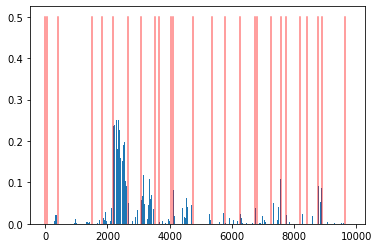

T_ACC =0.0018390481127426028
T_BLCA =0.006343562621623278
T_BRCA =0.0015194830484688282
T_CESC =0.004212949424982071
T_HBC =0.008114520460367203
T_COREAD =0.19850237667560577
T_DLBC =0.01286629494279623
T_GESCA =0.046602990478277206
T_GBM =0.0014480686513707042
T_HNSC =0.0025004525668919086
T_KICH =0.00036998980795033276
T_KC =0.014067902229726315
T_LAML =0.002326410263776779
T_LGG =0.0029788322281092405
T_LUAD =0.004514825530350208
T_LUSC =0.0018822153797373176
T_MESO =0.004231832455843687
T_GC =0.004200406838208437
T_PAAD =0.017305053770542145
T_PCPG =0.0001382093469146639
T_PRAD =0.0022131772711873055
T_SARC =0.009424754418432713
T_SKCM =0.003718994790688157
T_TGCT =0.06302698701620102
T_THCA =0.0007193741039372981
T_THYM =5.2755625802092254e-05
9


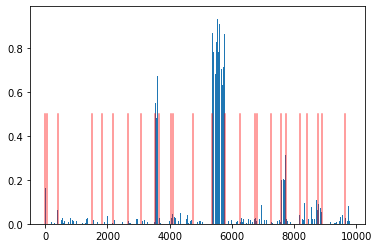

T_ACC =0.10116823762655258
T_BLCA =0.006837423425167799
T_BRCA =0.006280013360083103
T_CESC =0.0032118516974151134
T_HBC =0.00705215148627758
T_COREAD =0.0010733733652159572
T_DLBC =0.00985494814813137
T_GESCA =0.0042998590506613255
T_GBM =0.5286248922348022
T_HNSC =0.00338622834533453
T_KICH =0.030729912221431732
T_KC =0.017462795600295067
T_LAML =0.0026975609362125397
T_LGG =0.7691887617111206
T_LUAD =0.0043883915059268475
T_LUSC =0.005701495800167322
T_MESO =0.014658946543931961
T_GC =0.009627328254282475
T_PAAD =0.005306167993694544
T_PCPG =0.25277164578437805
T_PRAD =0.009278103709220886
T_SARC =0.082221120595932
T_SKCM =0.02666383981704712
T_TGCT =0.043407782912254333
T_THCA =0.008249555714428425
T_THYM =0.023919591680169106
10


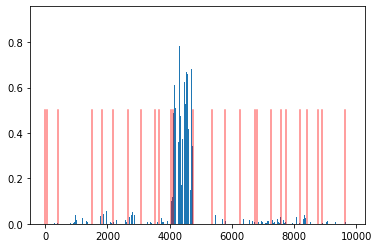

T_ACC =0.006486928556114435
T_BLCA =0.0016529943095520139
T_BRCA =0.002425783546641469
T_CESC =0.003442120272666216
T_HBC =0.014952115714550018
T_COREAD =0.004667365457862616
T_DLBC =0.007439584005624056
T_GESCA =0.003237728262320161
T_GBM =0.004773695953190327
T_HNSC =0.0015722977695986629
T_KICH =0.1069561094045639
T_KC =0.4410843849182129
T_LAML =0.002217840403318405
T_LGG =0.005040187854319811
T_LUAD =0.0034718334209173918
T_LUSC =0.0013609619345515966
T_MESO =0.010758493095636368
T_GC =0.008957072161138058
T_PAAD =0.011707787401974201
T_PCPG =0.01195443794131279
T_PRAD =0.0021817951928824186
T_SARC =0.024116123095154762
T_SKCM =0.0027215813752263784
T_TGCT =0.007025612518191338
T_THCA =0.0023077994119375944
T_THYM =0.007200686261057854
11


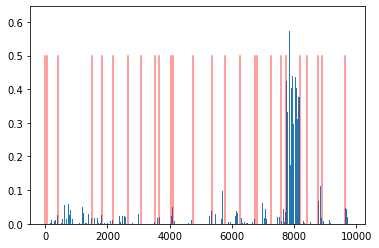

T_ACC =0.01222118828445673
T_BLCA =0.0046774279326200485
T_BRCA =0.011853404343128204
T_CESC =0.006446436978876591
T_HBC =0.003556780284270644
T_COREAD =0.004618797451257706
T_DLBC =0.0017883062828332186
T_GESCA =0.0045380485244095325
T_GBM =0.007300236728042364
T_HNSC =0.002687522443011403
T_KICH =0.022970175370573997
T_KC =0.0050306073389947414
T_LAML =0.0025722961872816086
T_LGG =0.004705716855823994
T_LUAD =0.00618647551164031
T_LUSC =0.0037470730021595955
T_MESO =0.0011805642861872911
T_GC =0.010636386461555958
T_PAAD =0.0056816572323441505
T_PCPG =0.030228618532419205
T_PRAD =0.3531133234500885
T_SARC =0.00939937587827444
T_SKCM =0.0019567152485251427
T_TGCT =0.02110411413013935
T_THCA =0.0018915891414508224
T_THYM =0.025523550808429718
12


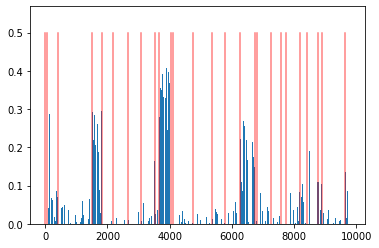

T_ACC =0.015423630364239216
T_BLCA =0.06828588247299194
T_BRCA =0.01228916272521019
T_CESC =0.1769140064716339
T_HBC =0.0025513432919979095
T_COREAD =0.007349472958594561
T_DLBC =0.009016642346978188
T_GESCA =0.04833158850669861
T_GBM =0.011143192648887634
T_HNSC =0.33667707443237305
T_KICH =0.0007478788611479104
T_KC =0.005391380749642849
T_LAML =0.0020199003629386425
T_LGG =0.006535029970109463
T_LUAD =0.012025329284369946
T_LUSC =0.17487984895706177
T_MESO =0.013494898565113544
T_GC =0.009388361126184464
T_PAAD =0.008090819232165813
T_PCPG =0.0
T_PRAD =0.010551508516073227
T_SARC =0.016819996759295464
T_SKCM =0.03815126791596413
T_TGCT =0.060717321932315826
T_THCA =0.00491781672462821
T_THYM =0.07811429351568222
13


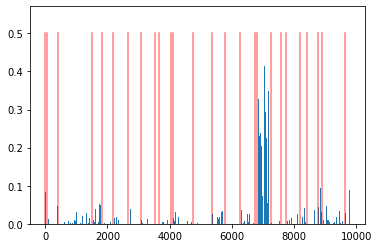

T_ACC =0.042188771069049835
T_BLCA =0.0034857059363275766
T_BRCA =0.006637493148446083
T_CESC =0.012541837058961391
T_HBC =0.0033809305168688297
T_COREAD =0.0020782658830285072
T_DLBC =0.0027347735594958067
T_GESCA =0.003468310460448265
T_GBM =0.010339372791349888
T_HNSC =0.0027319281361997128
T_KICH =0.008144554682075977
T_KC =0.007666962221264839
T_LAML =0.0009173126891255379
T_LGG =0.007662875112146139
T_LUAD =0.004243606235831976
T_LUSC =0.005041989032179117
T_MESO =0.010297744534909725
T_GC =0.20616789162158966
T_PAAD =0.003457144368439913
T_PCPG =0.0014140477869659662
T_PRAD =0.005720462184399366
T_SARC =0.016858035698533058
T_SKCM =0.0027287970297038555
T_TGCT =0.03432105854153633
T_THCA =0.006304134614765644
T_THYM =0.00927632674574852
14


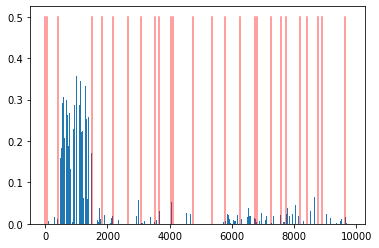

T_ACC =0.0015688103158026934
T_BLCA =0.007207721006125212
T_BRCA =0.1924227923154831
T_CESC =0.00726790726184845
T_HBC =0.004043665248900652
T_COREAD =0.003531963797286153
T_DLBC =0.0019240607507526875
T_GESCA =0.005974842235445976
T_GBM =0.004242051392793655
T_HNSC =0.0035770051181316376
T_KICH =0.04104478657245636
T_KC =0.004909859504550695
T_LAML =0.0003305520222056657
T_LGG =0.0021219176705926657
T_LUAD =0.010569259524345398
T_LUSC =0.005037979688495398
T_MESO =0.0038370462134480476
T_GC =0.008823768235743046
T_PAAD =0.0031982166692614555
T_PCPG =0.002176606096327305
T_PRAD =0.018945738673210144
T_SARC =0.004209640435874462
T_SKCM =0.00760059617459774
T_TGCT =0.002107716863974929
T_THCA =0.002566969022154808
T_THYM =0.013922508805990219
15


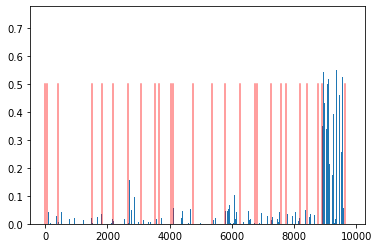

T_ACC =0.03136414662003517
T_BLCA =0.006889852695167065
T_BRCA =0.007861807011067867
T_CESC =0.005712280515581369
T_HBC =0.0047543952241539955
T_COREAD =0.00449159974232316
T_DLBC =0.030540168285369873
T_GESCA =0.0044595832005143166
T_GBM =0.002738252282142639
T_HNSC =0.007161638233810663
T_KICH =0.014861439354717731
T_KC =0.014100877568125725
T_LAML =0.0015460103750228882
T_LGG =0.021548418328166008
T_LUAD =0.05083199962973595
T_LUSC =0.009404473006725311
T_MESO =0.0013247998431324959
T_GC =0.013056683354079723
T_PAAD =0.007690681144595146
T_PCPG =0.0022119907662272453
T_PRAD =0.009058669209480286
T_SARC =0.009883769787847996
T_SKCM =0.011855975724756718
T_TGCT =0.002031004521995783
T_THCA =0.30289798974990845
T_THYM =0.0032799122855067253
16


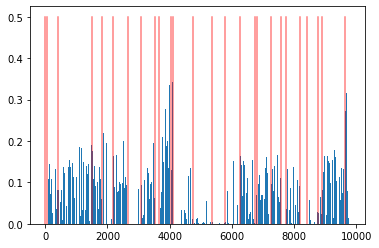

T_ACC =0.0029978672973811626
T_BLCA =0.09264572709798813
T_BRCA =0.09975897520780563
T_CESC =0.09409685432910919
T_HBC =0.02350345067679882
T_COREAD =0.10654568672180176
T_DLBC =0.006120036356151104
T_GESCA =0.08474846184253693
T_GBM =0.00046339243999682367
T_HNSC =0.12331590056419373
T_KICH =0.19484122097492218
T_KC =0.03613552823662758
T_LAML =0.012174779549241066
T_LGG =0.0017387596890330315
T_LUAD =0.04000497981905937
T_LUSC =0.08685450255870819
T_MESO =0.017222058027982712
T_GC =0.0718323215842247
T_PAAD =0.09244661033153534
T_PCPG =0.0038841990754008293
T_PRAD =0.05415147915482521
T_SARC =0.019978642463684082
T_SKCM =0.026200132444500923
T_TGCT =0.07674016803503036
T_THCA =0.12516628205776215
T_THYM =0.19242781400680542
17


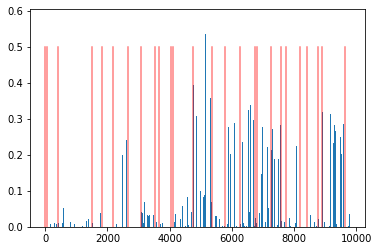

T_ACC =0.004313087090849876
T_BLCA =0.0022335087414830923
T_BRCA =0.012875660322606564
T_CESC =0.020100539550185204
T_HBC =0.0017115338705480099
T_COREAD =0.00819140300154686
T_DLBC =0.003883352968841791
T_GESCA =0.035635657608509064
T_GBM =0.009065786376595497
T_HNSC =0.002913829404860735
T_KICH =0.006445846054702997
T_KC =0.015102875418961048
T_LAML =0.1263214498758316
T_LGG =0.010702215135097504
T_LUAD =0.06668443232774734
T_LUSC =0.061447687447071075
T_MESO =0.012322288006544113
T_GC =0.06940684467554092
T_PAAD =0.09951144456863403
T_PCPG =0.010752168484032154
T_PRAD =0.037429459393024445
T_SARC =0.010151884518563747
T_SKCM =0.01587611995637417
T_TGCT =0.0012516573769971728
T_THCA =0.12084025144577026
T_THYM =0.00014631426893174648
18


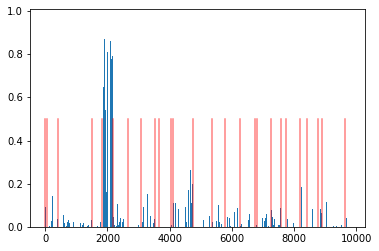

T_ACC =0.20194832980632782
T_BLCA =0.008197757415473461
T_BRCA =0.011029383167624474
T_CESC =0.004161848686635494
T_HBC =0.7099996209144592
T_COREAD =0.027416378259658813
T_DLBC =0.005854697898030281
T_GESCA =0.02313050627708435
T_GBM =0.007856464944779873
T_HNSC =0.004596662241965532
T_KICH =0.028246380388736725
T_KC =0.05810098722577095
T_LAML =0.0069434200413525105
T_LGG =0.011012392118573189
T_LUAD =0.016981229186058044
T_LUSC =0.007031274493783712
T_MESO =0.02544025145471096
T_GC =0.011690006591379642
T_PAAD =0.030036119744181633
T_PCPG =0.014039863832294941
T_PRAD =0.015756050124764442
T_SARC =0.024393223226070404
T_SKCM =0.009655945003032684
T_TGCT =0.05105634406208992
T_THCA =0.0034638294018805027
T_THYM =0.011651214212179184
19


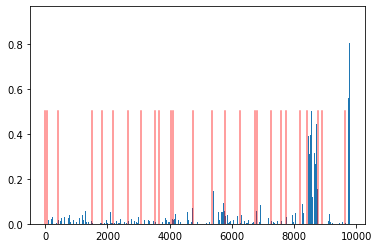

T_ACC =0.00996375735849142
T_BLCA =0.006750904023647308
T_BRCA =0.011178211309015751
T_CESC =0.002665654057636857
T_HBC =0.010079102590680122
T_COREAD =0.0061782002449035645
T_DLBC =0.007622119504958391
T_GESCA =0.006157310679554939
T_GBM =0.03197542205452919
T_HNSC =0.004737377632409334
T_KICH =0.006762167438864708
T_KC =0.013986132107675076
T_LAML =0.0024685438256710768
T_LGG =0.04145196080207825
T_LUAD =0.011538623832166195
T_LUSC =0.005626489408314228
T_MESO =0.009582016617059708
T_GC =0.00887785293161869
T_PAAD =0.006604335270822048
T_PCPG =0.015056893229484558
T_PRAD =0.011268092319369316
T_SARC =0.02444511651992798
T_SKCM =0.34854069352149963
T_TGCT =0.0014227790525183082
T_THCA =0.004664503503590822
T_THYM =0.00408322224393487
20


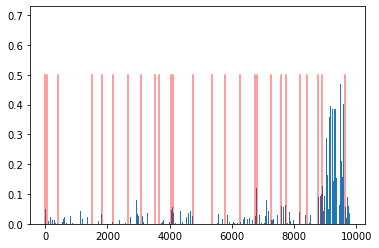

T_ACC =0.04833916202187538
T_BLCA =0.003357300767675042
T_BRCA =0.006392002571374178
T_CESC =0.0025950621347874403
T_HBC =0.003850532928481698
T_COREAD =0.0019266430754214525
T_DLBC =0.021358713507652283
T_GESCA =0.0031652210745960474
T_GBM =0.0033966193441301584
T_HNSC =0.0035106209106743336
T_KICH =0.07837186008691788
T_KC =0.02089882828295231
T_LAML =0.0010492686415091157
T_LGG =0.010348278097808361
T_LUAD =0.005105659365653992
T_LUSC =0.008554310537874699
T_MESO =0.04317847266793251
T_GC =0.013901840895414352
T_PAAD =0.006330146454274654
T_PCPG =0.04048091918230057
T_PRAD =0.005636368412524462
T_SARC =0.017169026657938957
T_SKCM =0.0059037278406322
T_TGCT =0.04963628202676773
T_THCA =0.2317902147769928
T_THYM =0.07488492131233215
21


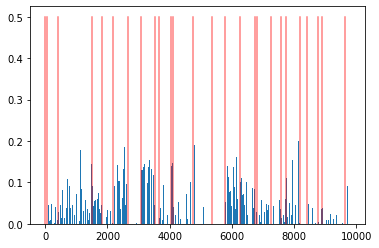

T_ACC =0.009115227498114109
T_BLCA =0.04025913029909134
T_BRCA =0.05057984218001366
T_CESC =0.07193039357662201
T_HBC =0.006801133509725332
T_COREAD =0.06884224712848663
T_DLBC =0.0079879155382514
T_GESCA =0.10141352564096451
T_GBM =0.00045121158473193645
T_HNSC =0.037679873406887054
T_KICH =0.1587144285440445
T_KC =0.034164272248744965
T_LAML =0.01476133894175291
T_LGG =0.0012874113162979484
T_LUAD =0.07597219198942184
T_LUSC =0.04333779215812683
T_MESO =0.005234471056610346
T_GC =0.0385734960436821
T_PAAD =0.025001561269164085
T_PCPG =0.008236486464738846
T_PRAD =0.04422912746667862
T_SARC =0.0024602427147328854
T_SKCM =0.008622540161013603
T_TGCT =0.015695421025156975
T_THCA =0.007332453969866037
T_THYM =0.025679510086774826
22


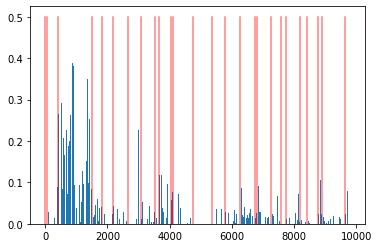

T_ACC =0.0024364006239920855
T_BLCA =0.013307970948517323
T_BRCA =0.12356171011924744
T_CESC =0.025708241388201714
T_HBC =0.007120930124074221
T_COREAD =0.008041796274483204
T_DLBC =0.01329005230218172
T_GESCA =0.011429608799517155
T_GBM =0.0054487925954163074
T_HNSC =0.03564298152923584
T_KICH =0.02373211644589901
T_KC =0.008700279518961906
T_LAML =0.0018044332973659039
T_LGG =0.0075212144292891026
T_LUAD =0.016196468845009804
T_LUSC =0.03025994822382927
T_MESO =0.017421046271920204
T_GC =0.02237706072628498
T_PAAD =0.006655076518654823
T_PCPG =0.001299560535699129
T_PRAD =0.018980324268341064
T_SARC =0.007638711016625166
T_SKCM =0.013836883939802647
T_TGCT =0.048968780785799026
T_THCA =0.008548938669264317
T_THYM =0.02760905958712101
23


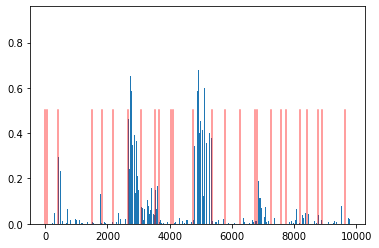

T_ACC =0.007066179532557726
T_BLCA =0.0024176803417503834
T_BRCA =0.015327717177569866
T_CESC =0.004680182784795761
T_HBC =0.002816032152622938
T_COREAD =0.013759773224592209
T_DLBC =0.33978089690208435
T_GESCA =0.06497596204280853
T_GBM =0.13771578669548035
T_HNSC =0.0037976219318807125
T_KICH =3.0351237001013942e-05
T_KC =0.005887716077268124
T_LAML =0.31109848618507385
T_LGG =0.0032195874955505133
T_LUAD =0.002894662320613861
T_LUSC =0.0044844490475952625
T_MESO =0.0069284155033528805
T_GC =0.07819993793964386
T_PAAD =0.017210260033607483
T_PCPG =0.004617717117071152
T_PRAD =0.012723483145236969
T_SARC =0.009324660524725914
T_SKCM =0.011189901269972324
T_TGCT =0.007482843939214945
T_THCA =0.022117072716355324
T_THYM =0.003548196516931057
24


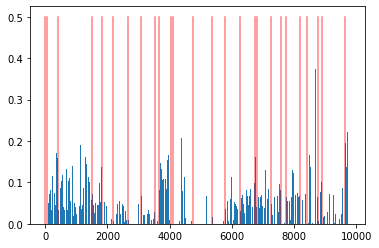

T_ACC =0.010418840683996677
T_BLCA =0.05840330570936203
T_BRCA =0.0917835608124733
T_CESC =0.061573486775159836
T_HBC =0.01075525488704443
T_COREAD =0.04302084073424339
T_DLBC =0.009816547855734825
T_GESCA =0.0373370461165905
T_GBM =0.0044081201776862144
T_HNSC =0.08031251281499863
T_KICH =0.0026262386236339808
T_KC =0.022112322971224785
T_LAML =0.0029466303531080484
T_LGG =0.008920757099986076
T_LUAD =0.04836080223321915
T_LUSC =0.06482204794883728
T_MESO =0.13193930685520172
T_GC =0.07030018419027328
T_PAAD =0.04277712479233742
T_PCPG =0.017616430297493935
T_PRAD =0.07295026630163193
T_SARC =0.03762665018439293
T_SKCM =0.05390234291553497
T_TGCT =0.05821354314684868
T_THCA =0.024880148470401764
T_THYM =0.15013565123081207
25


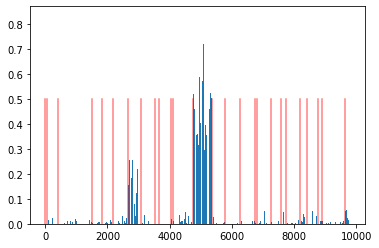

T_ACC =0.0027958413120359182
T_BLCA =0.0026438774075359106
T_BRCA =0.0038041353691369295
T_CESC =0.005451595410704613
T_HBC =0.0034178593195974827
T_COREAD =0.0038430022541433573
T_DLBC =0.11993837356567383
T_GESCA =0.005098412744700909
T_GBM =0.00390815082937479
T_HNSC =0.0014431994641199708
T_KICH =0.0011634423863142729
T_KC =0.008880320936441422
T_LAML =0.45550209283828735
T_LGG =0.006032269913703203
T_LUAD =0.0019062731880694628
T_LUSC =0.0028576990589499474
T_MESO =0.001640105969272554
T_GC =0.006850400008261204
T_PAAD =0.004304667469114065
T_PCPG =0.005576740484684706
T_PRAD =0.00298866699449718
T_SARC =0.012107745744287968
T_SKCM =0.010758202522993088
T_TGCT =0.00939047709107399
T_THCA =0.0026423484086990356
T_THYM =0.03777078911662102


/Users/mrita/opt/anaconda3/envs/env_phd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


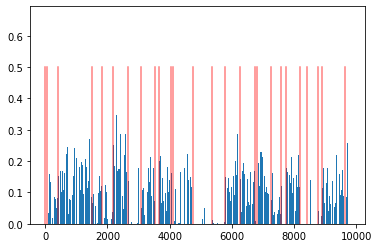

T_ACC =0.008432217873632908
T_BLCA =0.1034945696592331
T_BRCA =0.14449916779994965
T_CESC =0.11293846368789673
T_HBC =0.04730600863695145
T_COREAD =0.17762523889541626
T_DLBC =0.036189354956150055
T_GESCA =0.1045537069439888
T_GBM =0.0018488052301108837
T_HNSC =0.13032053411006927
T_KICH =0.11804123222827911
T_KC =0.06751352548599243
T_LAML =0.003974741790443659
T_LGG =0.0029677797574549913
T_LUAD =0.1281123012304306
T_LUSC =0.12475435435771942
T_MESO =0.014617814682424068
T_GC =0.1612006425857544
T_PAAD =0.10305535048246384
T_PCPG =0.013331998139619827
T_PRAD =0.1603924185037613
T_SARC =0.005162885412573814
T_SKCM =0.018788309767842293
T_TGCT =0.1269112378358841
T_THCA =0.10415369272232056
T_THYM =0.13667041063308716
1


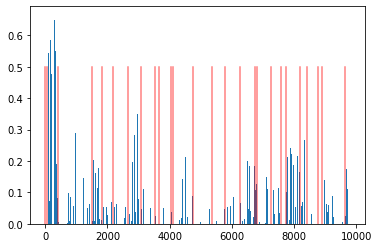

T_ACC =0.053472280502319336
T_BLCA =0.3657558858394623
T_BRCA =0.019242487847805023
T_CESC =0.09912056475877762
T_HBC =0.020532596856355667
T_COREAD =0.01706167683005333
T_DLBC =0.08607766777276993
T_GESCA =0.03442218899726868
T_GBM =0.004258840344846249
T_HNSC =0.02920900471508503
T_KICH =0.015553105622529984
T_KC =0.022545423358678818
T_LAML =0.00273753865621984
T_LGG =0.006177591159939766
T_LUAD =0.025416679680347443
T_LUSC =0.06500424444675446
T_MESO =0.13372394442558289
T_GC =0.026706788688898087
T_PAAD =0.031639464199543
T_PCPG =0.005472067277878523
T_PRAD =0.08234410732984543
T_SARC =0.10536206513643265
T_SKCM =0.003960614092648029
T_TGCT =0.015415717847645283
T_THCA =0.009874220937490463
T_THYM =0.11307389289140701
2


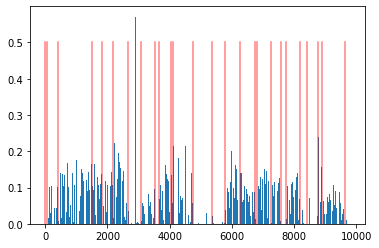

T_ACC =0.0019718511030077934
T_BLCA =0.0637204498052597
T_BRCA =0.0928683653473854
T_CESC =0.07479260116815567
T_HBC =0.07563219219446182
T_COREAD =0.10680608451366425
T_DLBC =0.021188795566558838
T_GESCA =0.07032383233308792
T_GBM =0.003646348835900426
T_HNSC =0.08323892951011658
T_KICH =0.09932231158018112
T_KC =0.07867638766765594
T_LAML =0.0014421188971027732
T_LGG =0.00205101422034204
T_LUAD =0.07356126606464386
T_LUSC =0.07375740259885788
T_MESO =0.01794646494090557
T_GC =0.09487082064151764
T_PAAD =0.06760800629854202
T_PCPG =0.001629149541258812
T_PRAD =0.09704073518514633
T_SARC =0.011744443327188492
T_SKCM =0.018110984936356544
T_TGCT =0.17968155443668365
T_THCA =0.03944483771920204
T_THYM =0.016110366210341454
3


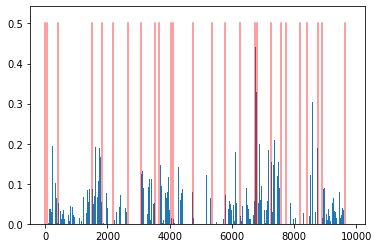

T_ACC =0.025565842166543007
T_BLCA =0.06029432639479637
T_BRCA =0.026545988395810127
T_CESC =0.07841693609952927
T_HBC =0.01963113807141781
T_COREAD =0.03855178877711296
T_DLBC =0.004256151616573334
T_GESCA =0.06342370063066483
T_GBM =0.0027650799602270126
T_HNSC =0.052957501262426376
T_KICH =0.012266136705875397
T_KC =0.05531497299671173
T_LAML =0.006505240220576525
T_LGG =0.006624741945415735
T_LUAD =0.06979460269212723
T_LUSC =0.030348332598805428
T_MESO =0.2955993115901947
T_GC =0.06077354773879051
T_PAAD =0.12912344932556152
T_PCPG =0.009419204667210579
T_PRAD =0.008823288604617119
T_SARC =0.06370101124048233
T_SKCM =0.03859177231788635
T_TGCT =0.0024959309957921505
T_THCA =0.02875407412648201
T_THYM =0.0022384028416126966
4


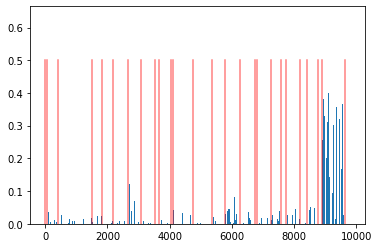

T_ACC =0.02177569828927517
T_BLCA =0.005640259478241205
T_BRCA =0.0050379568710923195
T_CESC =0.0034606282133609056
T_HBC =0.00289785023778677
T_COREAD =0.004297010134905577
T_DLBC =0.018435640260577202
T_GESCA =0.002982247620820999
T_GBM =0.0013591046445071697
T_HNSC =0.004386129789054394
T_KICH =0.009440827183425426
T_KC =0.008928787894546986
T_LAML =0.0011955790687352419
T_LGG =0.016849612817168236
T_LUAD =0.03999011218547821
T_LUSC =0.006869888864457607
T_MESO =0.001043825875967741
T_GC =0.008708138018846512
T_PAAD =0.0060602715238928795
T_PCPG =0.0005284149665385485
T_PRAD =0.007022997364401817
T_SARC =0.004667488858103752
T_SKCM =0.019967177882790565
T_TGCT =0.001220641890540719
T_THCA =0.21155066788196564
T_THYM =0.002578924410045147
5


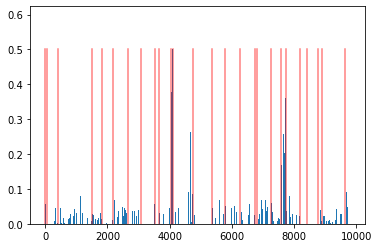

T_ACC =0.05762380361557007
T_BLCA =0.010683462955057621
T_BRCA =0.017220202833414078
T_CESC =0.012677259743213654
T_HBC =0.010053510777652264
T_COREAD =0.0158573929220438
T_DLBC =0.006608936935663223
T_GESCA =0.007969857193529606
T_GBM =0.0021335892379283905
T_HNSC =0.0064574177376925945
T_KICH =0.393736332654953
T_KC =0.055079709738492966
T_LAML =0.012661045417189598
T_LGG =0.00856530386954546
T_LUAD =0.02131151780486107
T_LUSC =0.006827058270573616
T_MESO =0.0016049410915002227
T_GC =0.027958622202277184
T_PAAD =0.016637323424220085
T_PCPG =0.19338259100914001
T_PRAD =0.02317526750266552
T_SARC =0.00861566886305809
T_SKCM =0.003513580420985818
T_TGCT =0.0031963721849024296
T_THCA =0.010242484509944916
T_THYM =0.03268038481473923
6


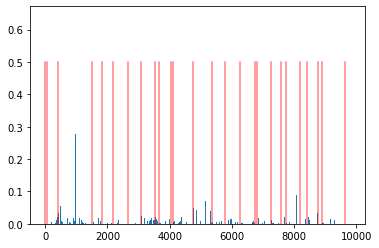

T_ACC =0.0008962456486187875
T_BLCA =0.0022542900405824184
T_BRCA =0.04283478483557701
T_CESC =0.002356746233999729
T_HBC =0.0009934226982295513
T_COREAD =0.0014851127052679658
T_DLBC =0.0025134829338639975
T_GESCA =0.010690553113818169
T_GBM =0.018312908709049225
T_HNSC =0.002042663050815463
T_KICH =0.00024983345065265894
T_KC =0.0012961336178705096
T_LAML =0.014851504936814308
T_LGG =0.0015459524001926184
T_LUAD =0.0027589083183556795
T_LUSC =0.002305684145539999
T_MESO =0.0007761467713862658
T_GC =0.008188562467694283
T_PAAD =0.0026663464959710836
T_PCPG =0.006322344299405813
T_PRAD =0.00692750746384263
T_SARC =0.0016804183833301067
T_SKCM =0.006023433990776539
T_TGCT =0.0009171906276606023
T_THCA =0.0016470018308609724
T_THYM =0.000679373333696276
7


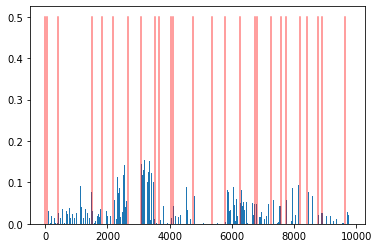

T_ACC =0.004166160244494677
T_BLCA =0.020203590393066406
T_BRCA =0.02442924492061138
T_CESC =0.031098194420337677
T_HBC =0.006552886217832565
T_COREAD =0.05510928854346275
T_DLBC =0.005103128030896187
T_GESCA =0.09182659536600113
T_GBM =0.0006154170841909945
T_HNSC =0.015768766403198242
T_KICH =0.01797017641365528
T_KC =0.018129101023077965
T_LAML =0.006065382622182369
T_LGG =0.0014522961573675275
T_LUAD =0.038970597088336945
T_LUSC =0.02405952662229538
T_MESO =0.006598751526325941
T_GC =0.022932598367333412
T_PAAD =0.023128580302000046
T_PCPG =0.0009570141555741429
T_PRAD =0.018106773495674133
T_SARC =0.001355494256131351
T_SKCM =0.012955313548445702
T_TGCT =0.014096414670348167
T_THCA =0.004613969940692186
T_THYM =0.010801133699715137
8


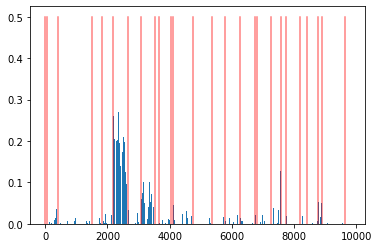

T_ACC =0.0005192140233702958
T_BLCA =0.004719904158264399
T_BRCA =0.0013816234422847629
T_CESC =0.004568019416183233
T_HBC =0.004926902242004871
T_COREAD =0.20900902152061462
T_DLBC =0.008745839819312096
T_GESCA =0.04435695335268974
T_GBM =0.0012467196211218834
T_HNSC =0.001761972438544035
T_KICH =0.00042651573312468827
T_KC =0.007264019921422005
T_LAML =0.0016780924052000046
T_LGG =0.0021947803907096386
T_LUAD =0.00463238637894392
T_LUSC =0.001156033598817885
T_MESO =0.0018678742926567793
T_GC =0.004195099696516991
T_PAAD =0.015777746215462685
T_PCPG =0.00027467880863696337
T_PRAD =0.0018858162220567465
T_SARC =0.00540370587259531
T_SKCM =0.004355653654783964
T_TGCT =0.03686913475394249
T_THCA =0.00041863671503961086
T_THYM =0.0
9


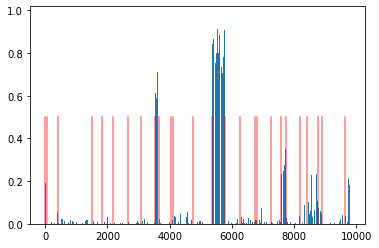

T_ACC =0.10598485171794891
T_BLCA =0.006456710863858461
T_BRCA =0.005064412951469421
T_CESC =0.002927928464487195
T_HBC =0.0073113092221319675
T_COREAD =0.0011840838706120849
T_DLBC =0.006852331571280956
T_GESCA =0.004623138811439276
T_GBM =0.5934662818908691
T_HNSC =0.00320194149389863
T_KICH =0.010528791695833206
T_KC =0.016836831346154213
T_LAML =0.0028796247206628323
T_LGG =0.8095334768295288
T_LUAD =0.0045177387073636055
T_LUSC =0.005434330552816391
T_MESO =0.011971398256719112
T_GC =0.008256985805928707
T_PAAD =0.005384540650993586
T_PCPG =0.31114262342453003
T_PRAD =0.009151890873908997
T_SARC =0.08670753985643387
T_SKCM =0.08807197958230972
T_TGCT =0.03426237031817436
T_THCA =0.007517381105571985
T_THYM =0.025049995630979538
10


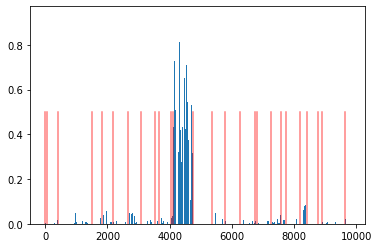

T_ACC =0.011181079782545567
T_BLCA =0.0016655660001561046
T_BRCA =0.0019332331139594316
T_CESC =0.0036612136755138636
T_HBC =0.013370390981435776
T_COREAD =0.004640623461455107
T_DLBC =0.012679300270974636
T_GESCA =0.003991441335529089
T_GBM =0.007978941313922405
T_HNSC =0.0014113492798060179
T_KICH =0.04041145369410515
T_KC =0.4176759421825409
T_LAML =0.0019058318575844169
T_LGG =0.005974136758595705
T_LUAD =0.0032709797378629446
T_LUSC =0.0011944735888391733
T_MESO =0.021564191207289696
T_GC =0.006415000185370445
T_PAAD =0.00964969489723444
T_PCPG =0.015286590903997421
T_PRAD =0.0013750394573435187
T_SARC =0.053162503987550735
T_SKCM =0.0010412289993837476
T_TGCT =0.008920836262404919
T_THCA =0.0019120959332212806
T_THYM =0.008677616715431213
11


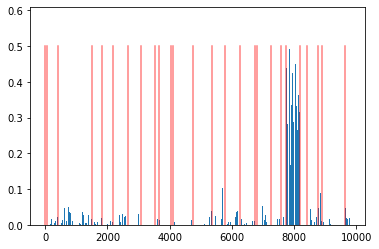

T_ACC =0.008433667942881584
T_BLCA =0.004003093112260103
T_BRCA =0.011307560838758945
T_CESC =0.0054222834296524525
T_HBC =0.002634639386087656
T_COREAD =0.005551636219024658
T_DLBC =0.001138382009230554
T_GESCA =0.004290301818400621
T_GBM =0.006439457181841135
T_HNSC =0.0021659976337105036
T_KICH =0.0033049925696104765
T_KC =0.0035427871625870466
T_LAML =0.0021239740308374166
T_LGG =0.004518822301179171
T_LUAD =0.0066893151961266994
T_LUSC =0.003342857351526618
T_MESO =0.0009897479321807623
T_GC =0.008078123442828655
T_PAAD =0.004492464475333691
T_PCPG =0.017203206196427345
T_PRAD =0.3191935122013092
T_SARC =0.00796154048293829
T_SKCM =0.008379051461815834
T_TGCT =0.014976894482970238
T_THCA =0.001602805801667273
T_THYM =0.020012907683849335
12


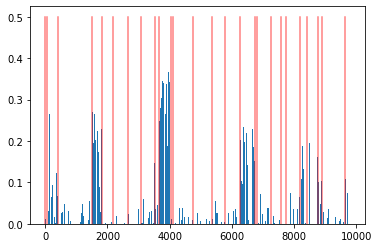

T_ACC =0.02234475314617157
T_BLCA =0.06171916425228119
T_BRCA =0.010756510309875011
T_CESC =0.16369281709194183
T_HBC =0.002794584957882762
T_COREAD =0.008839706890285015
T_DLBC =0.009511902928352356
T_GESCA =0.04779456555843353
T_GBM =0.016096794977784157
T_HNSC =0.2946893870830536
T_KICH =0.003461796324700117
T_KC =0.00615425780415535
T_LAML =0.0017863467801362276
T_LGG =0.007183931302279234
T_LUAD =0.009849660098552704
T_LUSC =0.16211174428462982
T_MESO =0.013555068522691727
T_GC =0.00878088641911745
T_PAAD =0.007211741060018539
T_PCPG =0.0001373888662783429
T_PRAD =0.009292266331613064
T_SARC =0.03115309774875641
T_SKCM =0.03832491114735603
T_TGCT =0.057672541588544846
T_THCA =0.004347724840044975
T_THYM =0.06333313882350922
13


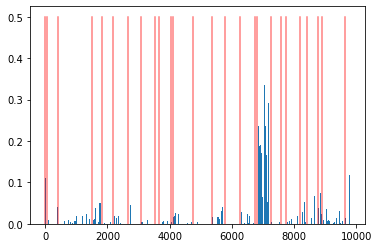

T_ACC =0.05091645196080208
T_BLCA =0.0028744691517204046
T_BRCA =0.005377429071813822
T_CESC =0.012335256673395634
T_HBC =0.0029422708321362734
T_COREAD =0.0030575725249946117
T_DLBC =0.002800632268190384
T_GESCA =0.002832667203620076
T_GBM =0.012301039882004261
T_HNSC =0.0024402395356446505
T_KICH =0.008858054876327515
T_KC =0.008499267511069775
T_LAML =0.0009420347632840276
T_LGG =0.007862106896936893
T_LUAD =0.003894809866324067
T_LUSC =0.004160542506724596
T_MESO =0.010710910893976688
T_GC =0.17181731760501862
T_PAAD =0.003953584004193544
T_PCPG =0.0017784788506105542
T_PRAD =0.004585168324410915
T_SARC =0.021517155691981316
T_SKCM =0.00475594587624073
T_TGCT =0.025962388142943382
T_THCA =0.005224219523370266
T_THYM =0.004507175646722317
14


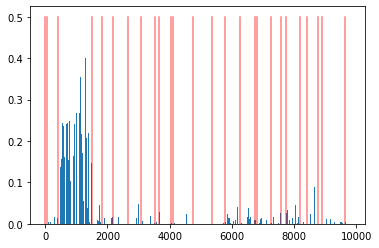

T_ACC =0.001286087790504098
T_BLCA =0.006998486816883087
T_BRCA =0.16924671828746796
T_CESC =0.008017271757125854
T_HBC =0.0031914571300148964
T_COREAD =0.0037531086709350348
T_DLBC =0.002043310087174177
T_GESCA =0.0041673616506159306
T_GBM =0.004979235120117664
T_HNSC =0.0034580877982079983
T_KICH =0.003984476439654827
T_KC =0.0023684522602707148
T_LAML =0.0003165366651955992
T_LGG =0.00224451906979084
T_LUAD =0.010473555885255337
T_LUSC =0.0045705391094088554
T_MESO =0.003519101068377495
T_GC =0.008049488998949528
T_PAAD =0.003381064161658287
T_PCPG =0.0012000307906419039
T_PRAD =0.016601156443357468
T_SARC =0.00482845539227128
T_SKCM =0.009294827468693256
T_TGCT =0.0019040274200960994
T_THCA =0.0017854176694527268
T_THYM =0.008463583886623383
15


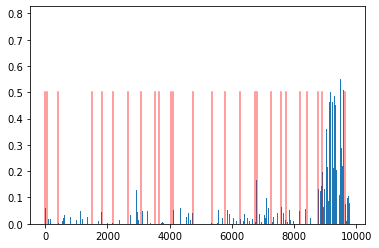

T_ACC =0.06500369310379028
T_BLCA =0.004133045673370361
T_BRCA =0.008266382850706577
T_CESC =0.0037551624700427055
T_HBC =0.004590803757309914
T_COREAD =0.0036022167187184095
T_DLBC =0.03162139281630516
T_GESCA =0.0038076748605817556
T_GBM =0.005078567191958427
T_HNSC =0.004174328409135342
T_KICH =0.030290547758340836
T_KC =0.021421844139695168
T_LAML =0.0018381240079179406
T_LGG =0.015319721773266792
T_LUAD =0.008772401139140129
T_LUSC =0.010429736226797104
T_MESO =0.050509288907051086
T_GC =0.017424289137125015
T_PAAD =0.007287874817848206
T_PCPG =0.03456483781337738
T_PRAD =0.007208327762782574
T_SARC =0.02551322616636753
T_SKCM =0.00951860100030899
T_TGCT =0.07273974269628525
T_THCA =0.3029062747955322
T_THYM =0.09432259202003479
16


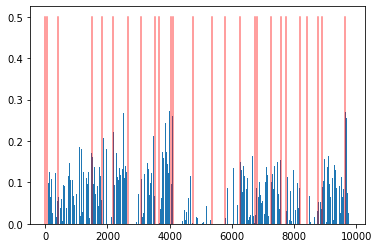

T_ACC =0.002362226601690054
T_BLCA =0.08202829957008362
T_BRCA =0.08244815468788147
T_CESC =0.08952460438013077
T_HBC =0.019861938431859016
T_COREAD =0.13886991143226624
T_DLBC =0.0050133513286709785
T_GESCA =0.08887158334255219
T_GBM =0.0004943381645716727
T_HNSC =0.11091729998588562
T_KICH =0.13819213211536407
T_KC =0.029362794011831284
T_LAML =0.011655152775347233
T_LGG =0.0008917702361941338
T_LUAD =0.03748038411140442
T_LUSC =0.0816231220960617
T_MESO =0.02395542897284031
T_GC =0.06119019165635109
T_PAAD =0.09150366485118866
T_PCPG =0.0027387868613004684
T_PRAD =0.04478219524025917
T_SARC =0.02341943234205246
T_SKCM =0.0279522892087698
T_TGCT =0.0681452602148056
T_THCA =0.10453513264656067
T_THYM =0.16294795274734497
17


In [ ]:
for N_sig in range(1,30):

    model = NMF(n_components=N_sig, init='random', random_state=0)
    W_train = model.fit_transform(exp_matrix)
    H = model.components_

    W_norm=W_train/W_train.sum(1,keepdims=True)
    y_train = [conv_dict[label] for label in labels]
    for id_sig in range(N_sig):
        print(id_sig)
        for i in range(28):
            if len(np.where(np.sort(y_train)==i)[0])>0:
                ind_sep=np.min(np.where(np.sort(y_train)==i)[0])
                plt.plot([ind_sep,ind_sep],[0,0.5],c="red",alpha=0.5)
        plt.bar(np.arange(len(W_norm)),W_norm[:,id_sig][np.argsort(y_train)])
        plt.show()
        
        for i in range(28):
            if len(np.where(np.sort(y_train)==i)[0])>0:
                id_1=np.min(np.where(np.sort(y_train)==i)[0])
                if len(np.where(np.sort(y_train)==i+1)[0])>0:
                    id_2=np.min(np.where(np.sort(y_train)==i+1)[0])
                else:
                    id_2=np.min(np.where(np.sort(y_train)==i+2)[0])

                print("{} ={}".format(cancers[i],np.mean(W_norm[np.argsort(y_train)][id_1:id_2,id_sig])))

In [ ]:
# TO DO
# Regarder si pour les signatures de tout le monde ça correspond à des gènes connus du cancer,
# SInon la pertinence des signatures



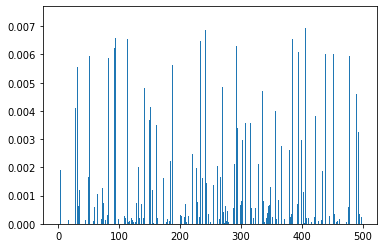

(array([], dtype=int64),)

In [420]:
sig_id=9

plt.bar(np.arange(len(H[sig_id])),H[sig_id])
plt.show()

#print(H[sig_id])
#print(H[0][194])

np.where(H[sig_id]>0.1)

In [412]:
gene_names[np.argsort(mi_values)[::-1][375]]

'ENSG00000005001.8'

In [324]:
conv_dict={"T_ACC":0,                                 
"T_BLCA":1,  
"T_BRCA":2,
"T_CESC":3,
"T_HBC":4, 
"T_COREAD":5,
"T_DLBC":6,
"T_GESCA":7,
"T_GBM":8,
"T_HNSC":9,  
"T_KICH":10,
"T_KC":11,
"T_LAML":12,  
"T_LGG":13, 
"T_LUAD":14,
"T_LUSC":15,  
"T_MESO":16,
"T_GC":17,    
"T_PAAD":18,
"T_PANET":19,
"T_PCPG":20,
"T_PRAD":21,
"T_SARC":22,
"T_SCLC":23,
"T_SKCM":24,
"T_TGCT":25,
"T_THCA":26,
"T_THYM":27,
"T_UVM":28}

In [358]:
from sklearn.ensemble import RandomForestClassifier

#predictor = XGBClassifier(learning_rate=0.35,n_estimators = n_estim)
predictor = RandomForestClassifier(n_estimators=300)

y_train = [conv_dict[label] for label in labels]

predictor.fit(W_train,y_train)
#predictor.fit(exp_matrix,y_train)


RandomForestClassifier(n_estimators=300)

In [359]:
y_test=[conv_dict[label] for label in val_labels]
W_eval = model.transform(val_matrix)
y_pred=predictor.predict(W_eval)
#y_pred=predictor.predict(val_matrix)

print(np.sum(y_test==y_pred)/len(y_pred))

0.954248366013072


In [18]:
import torch as th

0.5+0.5*th.normal(th.zeros(10))

tensor([ 0.2634,  0.7114,  0.8421,  1.3982,  0.2362,  1.0081,  0.6106, -0.0844,
         0.1654,  1.1836])